##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# 過学習と学習不足について知る

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/keras/overfit_and_underfit"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab で実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

いつものように、この例のプログラムは `tf.keras` APIを使用します。詳しくは TensorFlow の [Keras ガイド](https://www.tensorflow.org/guide/keras)を参照してください。

これまでの例、つまり、映画レビューの分類と燃費の推定では、検証用データでのモデルの精度が、数エポックでピークを迎え、その後低下するという現象が見られました。

言い換えると、モデルがトレーニング用データを<strong>過学習</strong>したと考えられます。過学習への対処の仕方を学ぶことは重要です。<strong>トレーニング用データセット</strong>で高い精度を達成することは難しくありませんが、（これまで見たこともない）<strong>テスト用データ</strong>に汎化したモデルを開発したいのです。

過学習の反対語は**学習不足**（underfitting）です。学習不足は、モデルがテストデータに対してまだ改善の余地がある場合に発生します。学習不足の原因は様々です。モデルが十分強力でないとか、正則化のしすぎだとか、単にトレーニング時間が短すぎるといった理由があります。学習不足は、トレーニング用データの中の関連したパターンを学習しきっていないということを意味します。

モデルのトレーニングをやりすぎると、モデルは過学習を始め、トレーニング用データの中のパターンで、テストデータには一般的ではないパターンを学習します。そのため、過学習と学習不足の中間を目指す必要があります。これから見ていくように、ちょうどよいエポック数だけトレーニングを行う必要があります。

過学習を防止するための、最良の解決策は、より多くのトレーニング用データを使うことです。データセットには、モデルが処理するあらゆる入力が含まれる必要があります。追加のデータは、新しく興味深いケースに対応する場合にのみ役立ちます。

多くのデータでトレーニングを行えば行うほど、当然のことながらモデルの汎化​性能が高くなります。これが不可能な場合、次善の策は正則化のようなテクニックを使うことです。正則化は、モデルに保存される情報の量とタイプに制約をを課します。ネットワークが少数のパターンしか記憶できない場合、最適化プロセスにより、最も顕著なパターンに焦点を合わせるように強制されます。これにより、汎化​性能が高くなる可能性があります。

このノートブックでは、いくつかの一般的な正則化手法を使用して分類モデルを改善する方法を見ていきます。

## セットアップ

まず、必要なパッケージをインポートします。

In [3]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2024-01-11 21:25:30.468416: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 21:25:30.468462: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 21:25:30.470009: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0


In [4]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to /tmpfs/tmp/pip-req-build-k49dt90m
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmpfs/tmp/pip-req-build-k49dt90m


  Resolved https://github.com/tensorflow/docs to commit 5ed8fbe64df2a05c6532919591219b545e61ef5f


  Preparing metadata (setup.py) ... -

 done


  Using cached astor-0.8.1-py2.py3-none-any.whl (27 kB)


 \

 done


  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.1.11.719-py3-none-any.whl size=181231 sha256=53df528ec0c38e941241fc8f7cee7ff7b60c208c19a4c03624f2b65908d3de12
  Stored in directory: /tmpfs/tmp/pip-ephem-wheel-cache-4_tm64vh/wheels/fc/f8/3b/5d21409a59cb1be9b1ade11f682039ced75b84de9dd6a0c8de
Successfully built tensorflow-docs


In [5]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile


In [6]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

## Higgs データセット

このチュートリアルの目的は素粒子物理学を行うことではないので、データセットの詳細にこだわる必要はありませんが、これには 11,000,000 のサンプルが含まれていて、各サンプルには 28 の特徴量とバイナリクラスラベルがあります。

In [7]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

      8192/2816407858 [..............................] - ETA: 1s

     40960/2816407858 [..............................] - ETA: 58:41

     81920/2816407858 [..............................] - ETA: 58:07

    147456/2816407858 [..............................] - ETA: 48:14

    270336/2816407858 [..............................] - ETA: 35:03

    499712/2816407858 [..............................] - ETA: 23:40

    811008/2816407858 [..............................] - ETA: 17:31

   1114112/2816407858 [..............................] - ETA: 14:53

   1425408/2816407858 [..............................] - ETA: 13:19

   1728512/2816407858 [..............................] - ETA: 12:21

   2031616/2816407858 [..............................] - ETA: 11:41

   2342912/2816407858 [..............................] - ETA: 11:09

   2654208/2816407858 [..............................] - ETA: 10:44

   2965504/2816407858 [..............................] - ETA: 10:24

   3276800/2816407858 [..............................] - ETA: 10:08

   3588096/2816407858 [..............................] - ETA: 9:56 

   3899392/2816407858 [..............................] - ETA: 9:44

   4210688/2816407858 [..............................] - ETA: 9:35

   4513792/2816407858 [..............................] - ETA: 9:28

   4816896/2816407858 [..............................] - ETA: 9:21

   5128192/2816407858 [..............................] - ETA: 9:15

   5431296/2816407858 [..............................] - ETA: 9:10

   5742592/2816407858 [..............................] - ETA: 9:05

   6053888/2816407858 [..............................] - ETA: 9:01

   6365184/2816407858 [..............................] - ETA: 8:57

   6660096/2816407858 [..............................] - ETA: 8:54

   6963200/2816407858 [..............................] - ETA: 8:51

   7274496/2816407858 [..............................] - ETA: 8:48

   7585792/2816407858 [..............................] - ETA: 8:45

   7897088/2816407858 [..............................] - ETA: 8:42

   8208384/2816407858 [..............................] - ETA: 8:40

   8519680/2816407858 [..............................] - ETA: 8:37

   8830976/2816407858 [..............................] - ETA: 8:35

   9142272/2816407858 [..............................] - ETA: 8:33

   9453568/2816407858 [..............................] - ETA: 8:31

   9764864/2816407858 [..............................] - ETA: 8:29

  10084352/2816407858 [..............................] - ETA: 8:27

  10387456/2816407858 [..............................] - ETA: 8:26

  10682368/2816407858 [..............................] - ETA: 8:25

  10985472/2816407858 [..............................] - ETA: 8:24

  11296768/2816407858 [..............................] - ETA: 8:22

  11599872/2816407858 [..............................] - ETA: 8:21

  11902976/2816407858 [..............................] - ETA: 8:20

  12214272/2816407858 [..............................] - ETA: 8:19

  12525568/2816407858 [..............................] - ETA: 8:18

  12836864/2816407858 [..............................] - ETA: 8:17

  13139968/2816407858 [..............................] - ETA: 8:16

  13451264/2816407858 [..............................] - ETA: 8:15

  13762560/2816407858 [..............................] - ETA: 8:14

  14073856/2816407858 [..............................] - ETA: 8:13

  14385152/2816407858 [..............................] - ETA: 8:12

  14696448/2816407858 [..............................] - ETA: 8:11

  15007744/2816407858 [..............................] - ETA: 8:11

  15319040/2816407858 [..............................] - ETA: 8:10

  15630336/2816407858 [..............................] - ETA: 8:09

  15941632/2816407858 [..............................] - ETA: 8:08

  16244736/2816407858 [..............................] - ETA: 8:08

  16556032/2816407858 [..............................] - ETA: 8:07

  16850944/2816407858 [..............................] - ETA: 8:07

  17154048/2816407858 [..............................] - ETA: 8:07

  17465344/2816407858 [..............................] - ETA: 8:06

  17776640/2816407858 [..............................] - ETA: 8:05

  18087936/2816407858 [..............................] - ETA: 8:05

  18399232/2816407858 [..............................] - ETA: 8:04

  18710528/2816407858 [..............................] - ETA: 8:04

  19021824/2816407858 [..............................] - ETA: 8:03

  19333120/2816407858 [..............................] - ETA: 8:03

  19644416/2816407858 [..............................] - ETA: 8:02

  19955712/2816407858 [..............................] - ETA: 8:02

  20258816/2816407858 [..............................] - ETA: 8:02

  20570112/2816407858 [..............................] - ETA: 8:01

  20881408/2816407858 [..............................] - ETA: 8:01

  21192704/2816407858 [..............................] - ETA: 8:00

  21504000/2816407858 [..............................] - ETA: 8:00

  21823488/2816407858 [..............................] - ETA: 7:59

  22134784/2816407858 [..............................] - ETA: 7:59

  22446080/2816407858 [..............................] - ETA: 7:58

  22749184/2816407858 [..............................] - ETA: 7:58

  23044096/2816407858 [..............................] - ETA: 7:58

  23347200/2816407858 [..............................] - ETA: 7:58

  23658496/2816407858 [..............................] - ETA: 7:57

  23969792/2816407858 [..............................] - ETA: 7:57

  24281088/2816407858 [..............................] - ETA: 7:57

  24592384/2816407858 [..............................] - ETA: 7:56

  24903680/2816407858 [..............................] - ETA: 7:56

  25214976/2816407858 [..............................] - ETA: 7:56

  25526272/2816407858 [..............................] - ETA: 7:55

  25837568/2816407858 [..............................] - ETA: 7:55

  26148864/2816407858 [..............................] - ETA: 7:55

  26451968/2816407858 [..............................] - ETA: 7:55

  26763264/2816407858 [..............................] - ETA: 7:54

  27074560/2816407858 [..............................] - ETA: 7:54

  27385856/2816407858 [..............................] - ETA: 7:54

  27697152/2816407858 [..............................] - ETA: 7:54

  28008448/2816407858 [..............................] - ETA: 7:53

  28311552/2816407858 [..............................] - ETA: 7:53

  28606464/2816407858 [..............................] - ETA: 7:53

  28909568/2816407858 [..............................] - ETA: 7:53

  29220864/2816407858 [..............................] - ETA: 7:53

  29532160/2816407858 [..............................] - ETA: 7:52

  29835264/2816407858 [..............................] - ETA: 7:52

  30146560/2816407858 [..............................] - ETA: 7:52

  30457856/2816407858 [..............................] - ETA: 7:52

  30769152/2816407858 [..............................] - ETA: 7:51

  31072256/2816407858 [..............................] - ETA: 7:51

  31383552/2816407858 [..............................] - ETA: 7:51

  31686656/2816407858 [..............................] - ETA: 7:51

  31989760/2816407858 [..............................] - ETA: 7:51

  32301056/2816407858 [..............................] - ETA: 7:51

  32612352/2816407858 [..............................] - ETA: 7:50

  32915456/2816407858 [..............................] - ETA: 7:50

  33226752/2816407858 [..............................] - ETA: 7:50

  33538048/2816407858 [..............................] - ETA: 7:50

  33857536/2816407858 [..............................] - ETA: 7:50

  34177024/2816407858 [..............................] - ETA: 7:49

  34488320/2816407858 [..............................] - ETA: 7:49

  34791424/2816407858 [..............................] - ETA: 7:49

  35094528/2816407858 [..............................] - ETA: 7:49

  35397632/2816407858 [..............................] - ETA: 7:49

  35708928/2816407858 [..............................] - ETA: 7:48

  36020224/2816407858 [..............................] - ETA: 7:48

  36331520/2816407858 [..............................] - ETA: 7:48

  36642816/2816407858 [..............................] - ETA: 7:48

  36954112/2816407858 [..............................] - ETA: 7:48

  37265408/2816407858 [..............................] - ETA: 7:48

  37568512/2816407858 [..............................] - ETA: 7:48

  37879808/2816407858 [..............................] - ETA: 7:47

  38191104/2816407858 [..............................] - ETA: 7:47

  38494208/2816407858 [..............................] - ETA: 7:47

  38805504/2816407858 [..............................] - ETA: 7:47

  39108608/2816407858 [..............................] - ETA: 7:47

  39419904/2816407858 [..............................] - ETA: 7:47

  39731200/2816407858 [..............................] - ETA: 7:46

  40042496/2816407858 [..............................] - ETA: 7:46

  40353792/2816407858 [..............................] - ETA: 7:46

  40665088/2816407858 [..............................] - ETA: 7:46

  40968192/2816407858 [..............................] - ETA: 7:46

  41263104/2816407858 [..............................] - ETA: 7:46

  41566208/2816407858 [..............................] - ETA: 7:46

  41877504/2816407858 [..............................] - ETA: 7:46

  42188800/2816407858 [..............................] - ETA: 7:46

  42491904/2816407858 [..............................] - ETA: 7:45

  42803200/2816407858 [..............................] - ETA: 7:45

  43114496/2816407858 [..............................] - ETA: 7:45

  43425792/2816407858 [..............................] - ETA: 7:45

  43737088/2816407858 [..............................] - ETA: 7:45

  44048384/2816407858 [..............................] - ETA: 7:45

  44359680/2816407858 [..............................] - ETA: 7:45

  44679168/2816407858 [..............................] - ETA: 7:44

  44990464/2816407858 [..............................] - ETA: 7:44

  45301760/2816407858 [..............................] - ETA: 7:44

  45613056/2816407858 [..............................] - ETA: 7:44

  45932544/2816407858 [..............................] - ETA: 7:44

  46243840/2816407858 [..............................] - ETA: 7:44

  46546944/2816407858 [..............................] - ETA: 7:44

  46850048/2816407858 [..............................] - ETA: 7:43

  47161344/2816407858 [..............................] - ETA: 7:43

  47464448/2816407858 [..............................] - ETA: 7:43

  47775744/2816407858 [..............................] - ETA: 7:43

  48095232/2816407858 [..............................] - ETA: 7:43

  48406528/2816407858 [..............................] - ETA: 7:43

  48717824/2816407858 [..............................] - ETA: 7:43

  49029120/2816407858 [..............................] - ETA: 7:43

  49348608/2816407858 [..............................] - ETA: 7:42

  49659904/2816407858 [..............................] - ETA: 7:42

  49971200/2816407858 [..............................] - ETA: 7:42

  50282496/2816407858 [..............................] - ETA: 7:42

  50593792/2816407858 [..............................] - ETA: 7:42

  50896896/2816407858 [..............................] - ETA: 7:42

  51208192/2816407858 [..............................] - ETA: 7:42

  51519488/2816407858 [..............................] - ETA: 7:42

  51830784/2816407858 [..............................] - ETA: 7:41

  52142080/2816407858 [..............................] - ETA: 7:41

  52453376/2816407858 [..............................] - ETA: 7:41

  52764672/2816407858 [..............................] - ETA: 7:41

  53075968/2816407858 [..............................] - ETA: 7:41

  53379072/2816407858 [..............................] - ETA: 7:41

  53682176/2816407858 [..............................] - ETA: 7:41

  53993472/2816407858 [..............................] - ETA: 7:41

  54304768/2816407858 [..............................] - ETA: 7:41

  54616064/2816407858 [..............................] - ETA: 7:41

  54927360/2816407858 [..............................] - ETA: 7:40

  55238656/2816407858 [..............................] - ETA: 7:40

  55558144/2816407858 [..............................] - ETA: 7:40

  55869440/2816407858 [..............................] - ETA: 7:40

  56180736/2816407858 [..............................] - ETA: 7:40

  56483840/2816407858 [..............................] - ETA: 7:40

  56786944/2816407858 [..............................] - ETA: 7:40

  57098240/2816407858 [..............................] - ETA: 7:40

  57409536/2816407858 [..............................] - ETA: 7:40

  57712640/2816407858 [..............................] - ETA: 7:39

  58015744/2816407858 [..............................] - ETA: 7:39

  58327040/2816407858 [..............................] - ETA: 7:39

  58630144/2816407858 [..............................] - ETA: 7:39

  58933248/2816407858 [..............................] - ETA: 7:39

  59244544/2816407858 [..............................] - ETA: 7:39

  59547648/2816407858 [..............................] - ETA: 7:39

  59850752/2816407858 [..............................] - ETA: 7:39

  60162048/2816407858 [..............................] - ETA: 7:39

  60473344/2816407858 [..............................] - ETA: 7:39

  60792832/2816407858 [..............................] - ETA: 7:39

  61104128/2816407858 [..............................] - ETA: 7:39

  61407232/2816407858 [..............................] - ETA: 7:39

  61718528/2816407858 [..............................] - ETA: 7:38

  62029824/2816407858 [..............................] - ETA: 7:38

  62341120/2816407858 [..............................] - ETA: 7:38

  62652416/2816407858 [..............................] - ETA: 7:38

  62963712/2816407858 [..............................] - ETA: 7:38

  63266816/2816407858 [..............................] - ETA: 7:38

  63578112/2816407858 [..............................] - ETA: 7:38

  63889408/2816407858 [..............................] - ETA: 7:38

  64200704/2816407858 [..............................] - ETA: 7:38

  64512000/2816407858 [..............................] - ETA: 7:38

  64823296/2816407858 [..............................] - ETA: 7:37

  65134592/2816407858 [..............................] - ETA: 7:37

  65445888/2816407858 [..............................] - ETA: 7:37

  65748992/2816407858 [..............................] - ETA: 7:37

  66060288/2816407858 [..............................] - ETA: 7:37

  66371584/2816407858 [..............................] - ETA: 7:37

  66674688/2816407858 [..............................] - ETA: 7:37

  66977792/2816407858 [..............................] - ETA: 7:37

  67289088/2816407858 [..............................] - ETA: 7:37

  67592192/2816407858 [..............................] - ETA: 7:37

  67895296/2816407858 [..............................] - ETA: 7:37

  68206592/2816407858 [..............................] - ETA: 7:37

  68517888/2816407858 [..............................] - ETA: 7:37

  68829184/2816407858 [..............................] - ETA: 7:36

  69132288/2816407858 [..............................] - ETA: 7:36

  69451776/2816407858 [..............................] - ETA: 7:36

  69763072/2816407858 [..............................] - ETA: 7:36

  70074368/2816407858 [..............................] - ETA: 7:36

  70393856/2816407858 [..............................] - ETA: 7:36

  70705152/2816407858 [..............................] - ETA: 7:36

  71016448/2816407858 [..............................] - ETA: 7:36

  71327744/2816407858 [..............................] - ETA: 7:36

  71639040/2816407858 [..............................] - ETA: 7:36

  71942144/2816407858 [..............................] - ETA: 7:36

  72253440/2816407858 [..............................] - ETA: 7:36

  72564736/2816407858 [..............................] - ETA: 7:35

  72867840/2816407858 [..............................] - ETA: 7:35

  73179136/2816407858 [..............................] - ETA: 7:35

  73490432/2816407858 [..............................] - ETA: 7:35

  73809920/2816407858 [..............................] - ETA: 7:35

  74129408/2816407858 [..............................] - ETA: 7:35

  74440704/2816407858 [..............................] - ETA: 7:35

  74752000/2816407858 [..............................] - ETA: 7:35

  75063296/2816407858 [..............................] - ETA: 7:35

  75374592/2816407858 [..............................] - ETA: 7:35

  75685888/2816407858 [..............................] - ETA: 7:35

  75997184/2816407858 [..............................] - ETA: 7:34

  76308480/2816407858 [..............................] - ETA: 7:34

  76619776/2816407858 [..............................] - ETA: 7:34

  76931072/2816407858 [..............................] - ETA: 7:34

  77242368/2816407858 [..............................] - ETA: 7:34

  77553664/2816407858 [..............................] - ETA: 7:34

  77856768/2816407858 [..............................] - ETA: 7:34

  78168064/2816407858 [..............................] - ETA: 7:34

  78479360/2816407858 [..............................] - ETA: 7:34

  78790656/2816407858 [..............................] - ETA: 7:34

  79101952/2816407858 [..............................] - ETA: 7:34

  79405056/2816407858 [..............................] - ETA: 7:34

  79716352/2816407858 [..............................] - ETA: 7:34

  80027648/2816407858 [..............................] - ETA: 7:34

  80338944/2816407858 [..............................] - ETA: 7:33

  80650240/2816407858 [..............................] - ETA: 7:33

  80961536/2816407858 [..............................] - ETA: 7:33

  81272832/2816407858 [..............................] - ETA: 7:33

  81584128/2816407858 [..............................] - ETA: 7:33

  81895424/2816407858 [..............................] - ETA: 7:33

  82206720/2816407858 [..............................] - ETA: 7:33

  82526208/2816407858 [..............................] - ETA: 7:33

  82837504/2816407858 [..............................] - ETA: 7:33

  83148800/2816407858 [..............................] - ETA: 7:33

  83460096/2816407858 [..............................] - ETA: 7:33

  83771392/2816407858 [..............................] - ETA: 7:32

  84066304/2816407858 [..............................] - ETA: 7:32

  84369408/2816407858 [..............................] - ETA: 7:32

  84680704/2816407858 [..............................] - ETA: 7:32

  84992000/2816407858 [..............................] - ETA: 7:32

  85303296/2816407858 [..............................] - ETA: 7:32

  85614592/2816407858 [..............................] - ETA: 7:32

  85925888/2816407858 [..............................] - ETA: 7:32

  86237184/2816407858 [..............................] - ETA: 7:32

  86540288/2816407858 [..............................] - ETA: 7:32

  86851584/2816407858 [..............................] - ETA: 7:32

  87162880/2816407858 [..............................] - ETA: 7:32

  87474176/2816407858 [..............................] - ETA: 7:32

  87785472/2816407858 [..............................] - ETA: 7:32

  88096768/2816407858 [..............................] - ETA: 7:32

  88408064/2816407858 [..............................] - ETA: 7:31

  88719360/2816407858 [..............................] - ETA: 7:31

  89030656/2816407858 [..............................] - ETA: 7:31

  89333760/2816407858 [..............................] - ETA: 7:31

  89645056/2816407858 [..............................] - ETA: 7:31

  89956352/2816407858 [..............................] - ETA: 7:31

  90259456/2816407858 [..............................] - ETA: 7:31

  90570752/2816407858 [..............................] - ETA: 7:31

  90873856/2816407858 [..............................] - ETA: 7:31

  91185152/2816407858 [..............................] - ETA: 7:31

  91496448/2816407858 [..............................] - ETA: 7:31

  91807744/2816407858 [..............................] - ETA: 7:31

  92119040/2816407858 [..............................] - ETA: 7:31

  92430336/2816407858 [..............................] - ETA: 7:31

  92733440/2816407858 [..............................] - ETA: 7:31

  93044736/2816407858 [..............................] - ETA: 7:30

  93356032/2816407858 [..............................] - ETA: 7:30

  93667328/2816407858 [..............................] - ETA: 7:30

  93978624/2816407858 [>.............................] - ETA: 7:30

  94289920/2816407858 [>.............................] - ETA: 7:30

  94601216/2816407858 [>.............................] - ETA: 7:30

  94912512/2816407858 [>.............................] - ETA: 7:30

  95223808/2816407858 [>.............................] - ETA: 7:30

  95543296/2816407858 [>.............................] - ETA: 7:30

  95854592/2816407858 [>.............................] - ETA: 7:30

  96157696/2816407858 [>.............................] - ETA: 7:30

  96460800/2816407858 [>.............................] - ETA: 7:30

  96772096/2816407858 [>.............................] - ETA: 7:30

  97083392/2816407858 [>.............................] - ETA: 7:29

  97386496/2816407858 [>.............................] - ETA: 7:29

  97697792/2816407858 [>.............................] - ETA: 7:29

  98009088/2816407858 [>.............................] - ETA: 7:29

  98320384/2816407858 [>.............................] - ETA: 7:29

  98631680/2816407858 [>.............................] - ETA: 7:29

  98942976/2816407858 [>.............................] - ETA: 7:29

  99254272/2816407858 [>.............................] - ETA: 7:29

  99565568/2816407858 [>.............................] - ETA: 7:29

  99876864/2816407858 [>.............................] - ETA: 7:29

 100188160/2816407858 [>.............................] - ETA: 7:29

 100499456/2816407858 [>.............................] - ETA: 7:29

 100810752/2816407858 [>.............................] - ETA: 7:29

 101122048/2816407858 [>.............................] - ETA: 7:28

 101425152/2816407858 [>.............................] - ETA: 7:28

 101736448/2816407858 [>.............................] - ETA: 7:28

 102047744/2816407858 [>.............................] - ETA: 7:28

 102350848/2816407858 [>.............................] - ETA: 7:28

 102662144/2816407858 [>.............................] - ETA: 7:28

 102973440/2816407858 [>.............................] - ETA: 7:28

 103284736/2816407858 [>.............................] - ETA: 7:28

 103596032/2816407858 [>.............................] - ETA: 7:28

 103907328/2816407858 [>.............................] - ETA: 7:28

 104210432/2816407858 [>.............................] - ETA: 7:28

 104521728/2816407858 [>.............................] - ETA: 7:28

 104833024/2816407858 [>.............................] - ETA: 7:28

 105144320/2816407858 [>.............................] - ETA: 7:28

 105447424/2816407858 [>.............................] - ETA: 7:28

 105758720/2816407858 [>.............................] - ETA: 7:28

 106078208/2816407858 [>.............................] - ETA: 7:27

 106397696/2816407858 [>.............................] - ETA: 7:27

 106708992/2816407858 [>.............................] - ETA: 7:27

 107020288/2816407858 [>.............................] - ETA: 7:27

 107339776/2816407858 [>.............................] - ETA: 7:27

 107659264/2816407858 [>.............................] - ETA: 7:27

 107970560/2816407858 [>.............................] - ETA: 7:27

 108273664/2816407858 [>.............................] - ETA: 7:27

 108560384/2816407858 [>.............................] - ETA: 7:27

 108871680/2816407858 [>.............................] - ETA: 7:27

 109182976/2816407858 [>.............................] - ETA: 7:27

 109494272/2816407858 [>.............................] - ETA: 7:27

 109805568/2816407858 [>.............................] - ETA: 7:27

 110108672/2816407858 [>.............................] - ETA: 7:27

 110428160/2816407858 [>.............................] - ETA: 7:26

 110731264/2816407858 [>.............................] - ETA: 7:26

 111050752/2816407858 [>.............................] - ETA: 7:26

 111362048/2816407858 [>.............................] - ETA: 7:26

 111673344/2816407858 [>.............................] - ETA: 7:26

 111992832/2816407858 [>.............................] - ETA: 7:26

 112304128/2816407858 [>.............................] - ETA: 7:26

 112623616/2816407858 [>.............................] - ETA: 7:26

 112934912/2816407858 [>.............................] - ETA: 7:26

 113254400/2816407858 [>.............................] - ETA: 7:26

 113557504/2816407858 [>.............................] - ETA: 7:26

 113860608/2816407858 [>.............................] - ETA: 7:26

 114171904/2816407858 [>.............................] - ETA: 7:26

 114466816/2816407858 [>.............................] - ETA: 7:26

 114769920/2816407858 [>.............................] - ETA: 7:26

 115073024/2816407858 [>.............................] - ETA: 7:25

 115384320/2816407858 [>.............................] - ETA: 7:25

 115687424/2816407858 [>.............................] - ETA: 7:25

 115990528/2816407858 [>.............................] - ETA: 7:25

 116310016/2816407858 [>.............................] - ETA: 7:25

 116629504/2816407858 [>.............................] - ETA: 7:25

 116948992/2816407858 [>.............................] - ETA: 7:25

 117260288/2816407858 [>.............................] - ETA: 7:25

 117555200/2816407858 [>.............................] - ETA: 7:25

 117866496/2816407858 [>.............................] - ETA: 7:25

 118177792/2816407858 [>.............................] - ETA: 7:25

 118480896/2816407858 [>.............................] - ETA: 7:25

 118792192/2816407858 [>.............................] - ETA: 7:25

 119087104/2816407858 [>.............................] - ETA: 7:25

 119398400/2816407858 [>.............................] - ETA: 7:25

 119717888/2816407858 [>.............................] - ETA: 7:25

 120029184/2816407858 [>.............................] - ETA: 7:24

 120340480/2816407858 [>.............................] - ETA: 7:24

 120651776/2816407858 [>.............................] - ETA: 7:24

 120954880/2816407858 [>.............................] - ETA: 7:24

 121249792/2816407858 [>.............................] - ETA: 7:24

 121561088/2816407858 [>.............................] - ETA: 7:24

 121856000/2816407858 [>.............................] - ETA: 7:24

 122175488/2816407858 [>.............................] - ETA: 7:24

 122494976/2816407858 [>.............................] - ETA: 7:24

 122814464/2816407858 [>.............................] - ETA: 7:24

 123133952/2816407858 [>.............................] - ETA: 7:24

 123445248/2816407858 [>.............................] - ETA: 7:24

 123772928/2816407858 [>.............................] - ETA: 7:24

 124084224/2816407858 [>.............................] - ETA: 7:24

 124395520/2816407858 [>.............................] - ETA: 7:24

 124706816/2816407858 [>.............................] - ETA: 7:24

 125009920/2816407858 [>.............................] - ETA: 7:23

 125337600/2816407858 [>.............................] - ETA: 7:23

 125648896/2816407858 [>.............................] - ETA: 7:23

 125960192/2816407858 [>.............................] - ETA: 7:23

 126279680/2816407858 [>.............................] - ETA: 7:23

 126599168/2816407858 [>.............................] - ETA: 7:23

 126910464/2816407858 [>.............................] - ETA: 7:23

 127205376/2816407858 [>.............................] - ETA: 7:23

 127516672/2816407858 [>.............................] - ETA: 7:23

 127819776/2816407858 [>.............................] - ETA: 7:23

 128139264/2816407858 [>.............................] - ETA: 7:23

 128458752/2816407858 [>.............................] - ETA: 7:23

 128770048/2816407858 [>.............................] - ETA: 7:23

 129089536/2816407858 [>.............................] - ETA: 7:23

 129409024/2816407858 [>.............................] - ETA: 7:22

 129728512/2816407858 [>.............................] - ETA: 7:22

 130031616/2816407858 [>.............................] - ETA: 7:22

 130334720/2816407858 [>.............................] - ETA: 7:22

 130629632/2816407858 [>.............................] - ETA: 7:22

 130949120/2816407858 [>.............................] - ETA: 7:22

 131268608/2816407858 [>.............................] - ETA: 7:22

 131579904/2816407858 [>.............................] - ETA: 7:22

 131891200/2816407858 [>.............................] - ETA: 7:22

 132202496/2816407858 [>.............................] - ETA: 7:22

 132521984/2816407858 [>.............................] - ETA: 7:22

 132841472/2816407858 [>.............................] - ETA: 7:22

 133120000/2816407858 [>.............................] - ETA: 7:22

 133431296/2816407858 [>.............................] - ETA: 7:22

 133726208/2816407858 [>.............................] - ETA: 7:22

 134053888/2816407858 [>.............................] - ETA: 7:22

 134373376/2816407858 [>.............................] - ETA: 7:21

 134684672/2816407858 [>.............................] - ETA: 7:21

 134995968/2816407858 [>.............................] - ETA: 7:21

 135315456/2816407858 [>.............................] - ETA: 7:21

 135634944/2816407858 [>.............................] - ETA: 7:21

 135929856/2816407858 [>.............................] - ETA: 7:21

 136232960/2816407858 [>.............................] - ETA: 7:21

 136519680/2816407858 [>.............................] - ETA: 7:21

 136839168/2816407858 [>.............................] - ETA: 7:21

 137158656/2816407858 [>.............................] - ETA: 7:21

 137478144/2816407858 [>.............................] - ETA: 7:21

 137789440/2816407858 [>.............................] - ETA: 7:21

 138100736/2816407858 [>.............................] - ETA: 7:21

 138420224/2816407858 [>.............................] - ETA: 7:21

 138739712/2816407858 [>.............................] - ETA: 7:21

 139034624/2816407858 [>.............................] - ETA: 7:21

 139337728/2816407858 [>.............................] - ETA: 7:21

 139632640/2816407858 [>.............................] - ETA: 7:21

 139952128/2816407858 [>.............................] - ETA: 7:21

 140263424/2816407858 [>.............................] - ETA: 7:20

 140566528/2816407858 [>.............................] - ETA: 7:20

 140877824/2816407858 [>.............................] - ETA: 7:20

 141197312/2816407858 [>.............................] - ETA: 7:20

 141516800/2816407858 [>.............................] - ETA: 7:20

 141811712/2816407858 [>.............................] - ETA: 7:20

 142123008/2816407858 [>.............................] - ETA: 7:20

 142417920/2816407858 [>.............................] - ETA: 7:20

 142737408/2816407858 [>.............................] - ETA: 7:20

 143056896/2816407858 [>.............................] - ETA: 7:20

 143376384/2816407858 [>.............................] - ETA: 7:20

 143687680/2816407858 [>.............................] - ETA: 7:20

 143998976/2816407858 [>.............................] - ETA: 7:20

 144318464/2816407858 [>.............................] - ETA: 7:20

 144629760/2816407858 [>.............................] - ETA: 7:19

 144916480/2816407858 [>.............................] - ETA: 7:19

 145211392/2816407858 [>.............................] - ETA: 7:19

 145506304/2816407858 [>.............................] - ETA: 7:19

 145825792/2816407858 [>.............................] - ETA: 7:19

 146145280/2816407858 [>.............................] - ETA: 7:19

 146456576/2816407858 [>.............................] - ETA: 7:19

 146767872/2816407858 [>.............................] - ETA: 7:19

 147087360/2816407858 [>.............................] - ETA: 7:19

 147406848/2816407858 [>.............................] - ETA: 7:19

 147701760/2816407858 [>.............................] - ETA: 7:19

 148004864/2816407858 [>.............................] - ETA: 7:19

 148299776/2816407858 [>.............................] - ETA: 7:19

 148619264/2816407858 [>.............................] - ETA: 7:19

 148938752/2816407858 [>.............................] - ETA: 7:19

 149258240/2816407858 [>.............................] - ETA: 7:19

 149577728/2816407858 [>.............................] - ETA: 7:19

 149889024/2816407858 [>.............................] - ETA: 7:19

 150208512/2816407858 [>.............................] - ETA: 7:18

 150511616/2816407858 [>.............................] - ETA: 7:18

 150822912/2816407858 [>.............................] - ETA: 7:18

 151126016/2816407858 [>.............................] - ETA: 7:18

 151412736/2816407858 [>.............................] - ETA: 7:18

 151732224/2816407858 [>.............................] - ETA: 7:18

 152051712/2816407858 [>.............................] - ETA: 7:18

 152363008/2816407858 [>.............................] - ETA: 7:18

 152674304/2816407858 [>.............................] - ETA: 7:18

 152993792/2816407858 [>.............................] - ETA: 7:18

 153313280/2816407858 [>.............................] - ETA: 7:18

 153600000/2816407858 [>.............................] - ETA: 7:18

 153903104/2816407858 [>.............................] - ETA: 7:18

 154189824/2816407858 [>.............................] - ETA: 7:18

 154509312/2816407858 [>.............................] - ETA: 7:18

 154828800/2816407858 [>.............................] - ETA: 7:18

 155140096/2816407858 [>.............................] - ETA: 7:18

 155451392/2816407858 [>.............................] - ETA: 7:18

 155770880/2816407858 [>.............................] - ETA: 7:18

 156098560/2816407858 [>.............................] - ETA: 7:17

 156401664/2816407858 [>.............................] - ETA: 7:17

 156704768/2816407858 [>.............................] - ETA: 7:17

 156999680/2816407858 [>.............................] - ETA: 7:17

 157319168/2816407858 [>.............................] - ETA: 7:17

 157622272/2816407858 [>.............................] - ETA: 7:17

 157933568/2816407858 [>.............................] - ETA: 7:17

 158236672/2816407858 [>.............................] - ETA: 7:17

 158556160/2816407858 [>.............................] - ETA: 7:17

 158875648/2816407858 [>.............................] - ETA: 7:17

 159195136/2816407858 [>.............................] - ETA: 7:17

 159481856/2816407858 [>.............................] - ETA: 7:17

 159793152/2816407858 [>.............................] - ETA: 7:17

 160096256/2816407858 [>.............................] - ETA: 7:17

 160423936/2816407858 [>.............................] - ETA: 7:17

 160743424/2816407858 [>.............................] - ETA: 7:17

 161054720/2816407858 [>.............................] - ETA: 7:17

 161366016/2816407858 [>.............................] - ETA: 7:16

 161685504/2816407858 [>.............................] - ETA: 7:16

 162004992/2816407858 [>.............................] - ETA: 7:16

 162299904/2816407858 [>.............................] - ETA: 7:16

 162611200/2816407858 [>.............................] - ETA: 7:16

 162906112/2816407858 [>.............................] - ETA: 7:16

 163225600/2816407858 [>.............................] - ETA: 7:16

 163536896/2816407858 [>.............................] - ETA: 7:16

 163840000/2816407858 [>.............................] - ETA: 7:16

 164151296/2816407858 [>.............................] - ETA: 7:16

 164470784/2816407858 [>.............................] - ETA: 7:16

 164790272/2816407858 [>.............................] - ETA: 7:16

 165093376/2816407858 [>.............................] - ETA: 7:16

 165396480/2816407858 [>.............................] - ETA: 7:16

 165691392/2816407858 [>.............................] - ETA: 7:16

 166010880/2816407858 [>.............................] - ETA: 7:16

 166330368/2816407858 [>.............................] - ETA: 7:16

 166641664/2816407858 [>.............................] - ETA: 7:16

 166952960/2816407858 [>.............................] - ETA: 7:16

 167264256/2816407858 [>.............................] - ETA: 7:15

 167591936/2816407858 [>.............................] - ETA: 7:15

 167911424/2816407858 [>.............................] - ETA: 7:15

 168198144/2816407858 [>.............................] - ETA: 7:15

 168501248/2816407858 [>.............................] - ETA: 7:15

 168804352/2816407858 [>.............................] - ETA: 7:15

 169123840/2816407858 [>.............................] - ETA: 7:15

 169443328/2816407858 [>.............................] - ETA: 7:15

 169738240/2816407858 [>.............................] - ETA: 7:15

 170049536/2816407858 [>.............................] - ETA: 7:15

 170369024/2816407858 [>.............................] - ETA: 7:15

 170688512/2816407858 [>.............................] - ETA: 7:15

 170983424/2816407858 [>.............................] - ETA: 7:15

 171286528/2816407858 [>.............................] - ETA: 7:15

 171581440/2816407858 [>.............................] - ETA: 7:15

 171900928/2816407858 [>.............................] - ETA: 7:15

 172220416/2816407858 [>.............................] - ETA: 7:15

 172531712/2816407858 [>.............................] - ETA: 7:15

 172851200/2816407858 [>.............................] - ETA: 7:14

 173162496/2816407858 [>.............................] - ETA: 7:14

 173481984/2816407858 [>.............................] - ETA: 7:14

 173793280/2816407858 [>.............................] - ETA: 7:14

 174088192/2816407858 [>.............................] - ETA: 7:14

 174399488/2816407858 [>.............................] - ETA: 7:14

 174694400/2816407858 [>.............................] - ETA: 7:14

 175013888/2816407858 [>.............................] - ETA: 7:14

 175333376/2816407858 [>.............................] - ETA: 7:14

 175644672/2816407858 [>.............................] - ETA: 7:14

 175947776/2816407858 [>.............................] - ETA: 7:14

 176275456/2816407858 [>.............................] - ETA: 7:14

 176603136/2816407858 [>.............................] - ETA: 7:14

 176898048/2816407858 [>.............................] - ETA: 7:14

 177209344/2816407858 [>.............................] - ETA: 7:14

 177496064/2816407858 [>.............................] - ETA: 7:14

 177823744/2816407858 [>.............................] - ETA: 7:14

 178151424/2816407858 [>.............................] - ETA: 7:13

 178462720/2816407858 [>.............................] - ETA: 7:13

 178774016/2816407858 [>.............................] - ETA: 7:13

 179085312/2816407858 [>.............................] - ETA: 7:13

 179404800/2816407858 [>.............................] - ETA: 7:13

 179707904/2816407858 [>.............................] - ETA: 7:13

 180011008/2816407858 [>.............................] - ETA: 7:13

 180305920/2816407858 [>.............................] - ETA: 7:13

 180633600/2816407858 [>.............................] - ETA: 7:13

 180953088/2816407858 [>.............................] - ETA: 7:13

 181272576/2816407858 [>.............................] - ETA: 7:13

 181583872/2816407858 [>.............................] - ETA: 7:13

 181886976/2816407858 [>.............................] - ETA: 7:13

 182198272/2816407858 [>.............................] - ETA: 7:13

 182517760/2816407858 [>.............................] - ETA: 7:13

 182804480/2816407858 [>.............................] - ETA: 7:13

 183107584/2816407858 [>.............................] - ETA: 7:13

 183394304/2816407858 [>.............................] - ETA: 7:13

 183713792/2816407858 [>.............................] - ETA: 7:12

 184033280/2816407858 [>.............................] - ETA: 7:12

 184344576/2816407858 [>.............................] - ETA: 7:12

 184655872/2816407858 [>.............................] - ETA: 7:12

 184975360/2816407858 [>.............................] - ETA: 7:12

 185294848/2816407858 [>.............................] - ETA: 7:12

 185589760/2816407858 [>.............................] - ETA: 7:12

 185892864/2816407858 [>.............................] - ETA: 7:12

 186187776/2816407858 [>.............................] - ETA: 7:12

 186507264/2816407858 [>.............................] - ETA: 7:12

 186826752/2816407858 [>.............................] - ETA: 7:12

 187138048/2816407858 [>.............................] - ETA: 7:12

 187449344/2816407858 [>.............................] - ETA: 7:12

 187768832/2816407858 [=>............................] - ETA: 7:12

 188080128/2816407858 [=>............................] - ETA: 7:12

 188391424/2816407858 [=>............................] - ETA: 7:12

 188686336/2816407858 [=>............................] - ETA: 7:12

 188981248/2816407858 [=>............................] - ETA: 7:12

 189284352/2816407858 [=>............................] - ETA: 7:11

 189603840/2816407858 [=>............................] - ETA: 7:11

 189923328/2816407858 [=>............................] - ETA: 7:11

 190234624/2816407858 [=>............................] - ETA: 7:11

 190554112/2816407858 [=>............................] - ETA: 7:11

 190873600/2816407858 [=>............................] - ETA: 7:11

 191193088/2816407858 [=>............................] - ETA: 7:11

 191488000/2816407858 [=>............................] - ETA: 7:11

 191791104/2816407858 [=>............................] - ETA: 7:11

 192086016/2816407858 [=>............................] - ETA: 7:11

 192405504/2816407858 [=>............................] - ETA: 7:11

 192724992/2816407858 [=>............................] - ETA: 7:11

 193036288/2816407858 [=>............................] - ETA: 7:11

 193347584/2816407858 [=>............................] - ETA: 7:11

 193658880/2816407858 [=>............................] - ETA: 7:11

 193978368/2816407858 [=>............................] - ETA: 7:11

 194273280/2816407858 [=>............................] - ETA: 7:11

 194576384/2816407858 [=>............................] - ETA: 7:10

 194879488/2816407858 [=>............................] - ETA: 7:10

 195190784/2816407858 [=>............................] - ETA: 7:10

 195510272/2816407858 [=>............................] - ETA: 7:10

 195829760/2816407858 [=>............................] - ETA: 7:10

 196141056/2816407858 [=>............................] - ETA: 7:10

 196452352/2816407858 [=>............................] - ETA: 7:10

 196763648/2816407858 [=>............................] - ETA: 7:10

 197083136/2816407858 [=>............................] - ETA: 7:10

 197369856/2816407858 [=>............................] - ETA: 7:10

 197672960/2816407858 [=>............................] - ETA: 7:10

 197967872/2816407858 [=>............................] - ETA: 7:10

 198287360/2816407858 [=>............................] - ETA: 7:10

 198606848/2816407858 [=>............................] - ETA: 7:10

 198918144/2816407858 [=>............................] - ETA: 7:10

 199229440/2816407858 [=>............................] - ETA: 7:10

 199548928/2816407858 [=>............................] - ETA: 7:10

 199868416/2816407858 [=>............................] - ETA: 7:10

 200163328/2816407858 [=>............................] - ETA: 7:10

 200458240/2816407858 [=>............................] - ETA: 7:09

 200753152/2816407858 [=>............................] - ETA: 7:09

 201072640/2816407858 [=>............................] - ETA: 7:09

 201392128/2816407858 [=>............................] - ETA: 7:09

 201703424/2816407858 [=>............................] - ETA: 7:09

 202014720/2816407858 [=>............................] - ETA: 7:09

 202326016/2816407858 [=>............................] - ETA: 7:09

 202645504/2816407858 [=>............................] - ETA: 7:09

 202964992/2816407858 [=>............................] - ETA: 7:09

 203251712/2816407858 [=>............................] - ETA: 7:09

 203563008/2816407858 [=>............................] - ETA: 7:09

 203857920/2816407858 [=>............................] - ETA: 7:09

 204177408/2816407858 [=>............................] - ETA: 7:09

 204488704/2816407858 [=>............................] - ETA: 7:09

 204800000/2816407858 [=>............................] - ETA: 7:09

 205103104/2816407858 [=>............................] - ETA: 7:09

 205414400/2816407858 [=>............................] - ETA: 7:09

 205725696/2816407858 [=>............................] - ETA: 7:09

 206012416/2816407858 [=>............................] - ETA: 7:09

 206315520/2816407858 [=>............................] - ETA: 7:09

 206602240/2816407858 [=>............................] - ETA: 7:09

 206929920/2816407858 [=>............................] - ETA: 7:08

 207249408/2816407858 [=>............................] - ETA: 7:08

 207568896/2816407858 [=>............................] - ETA: 7:08

 207880192/2816407858 [=>............................] - ETA: 7:08

 208199680/2816407858 [=>............................] - ETA: 7:08

 208519168/2816407858 [=>............................] - ETA: 7:08

 208830464/2816407858 [=>............................] - ETA: 7:08

 209108992/2816407858 [=>............................] - ETA: 7:08

 209403904/2816407858 [=>............................] - ETA: 7:08

 209707008/2816407858 [=>............................] - ETA: 7:08

 210026496/2816407858 [=>............................] - ETA: 7:08

 210345984/2816407858 [=>............................] - ETA: 7:08

 210649088/2816407858 [=>............................] - ETA: 7:08

 210968576/2816407858 [=>............................] - ETA: 7:08

 211288064/2816407858 [=>............................] - ETA: 7:08

 211607552/2816407858 [=>............................] - ETA: 7:08

 211894272/2816407858 [=>............................] - ETA: 7:08

 212189184/2816407858 [=>............................] - ETA: 7:08

 212475904/2816407858 [=>............................] - ETA: 7:08

 212787200/2816407858 [=>............................] - ETA: 7:07

 213106688/2816407858 [=>............................] - ETA: 7:07

 213426176/2816407858 [=>............................] - ETA: 7:07

 213737472/2816407858 [=>............................] - ETA: 7:07

 214048768/2816407858 [=>............................] - ETA: 7:07

 214368256/2816407858 [=>............................] - ETA: 7:07

 214679552/2816407858 [=>............................] - ETA: 7:07

 214974464/2816407858 [=>............................] - ETA: 7:07

 215277568/2816407858 [=>............................] - ETA: 7:07

 215572480/2816407858 [=>............................] - ETA: 7:07

 215891968/2816407858 [=>............................] - ETA: 7:07

 216211456/2816407858 [=>............................] - ETA: 7:07

 216522752/2816407858 [=>............................] - ETA: 7:07

 216834048/2816407858 [=>............................] - ETA: 7:07

 217145344/2816407858 [=>............................] - ETA: 7:07

 217464832/2816407858 [=>............................] - ETA: 7:07

 217767936/2816407858 [=>............................] - ETA: 7:07

 218071040/2816407858 [=>............................] - ETA: 7:07

 218357760/2816407858 [=>............................] - ETA: 7:07

 218652672/2816407858 [=>............................] - ETA: 7:06

 218963968/2816407858 [=>............................] - ETA: 7:06

 219283456/2816407858 [=>............................] - ETA: 7:06

 219594752/2816407858 [=>............................] - ETA: 7:06

 219906048/2816407858 [=>............................] - ETA: 7:06

 220217344/2816407858 [=>............................] - ETA: 7:06

 220545024/2816407858 [=>............................] - ETA: 7:06

 220839936/2816407858 [=>............................] - ETA: 7:06

 221143040/2816407858 [=>............................] - ETA: 7:06

 221446144/2816407858 [=>............................] - ETA: 7:06

 221765632/2816407858 [=>............................] - ETA: 7:06

 222085120/2816407858 [=>............................] - ETA: 7:06

 222404608/2816407858 [=>............................] - ETA: 7:06

 222707712/2816407858 [=>............................] - ETA: 7:06

 223019008/2816407858 [=>............................] - ETA: 7:06

 223330304/2816407858 [=>............................] - ETA: 7:06

 223625216/2816407858 [=>............................] - ETA: 7:06

 223920128/2816407858 [=>............................] - ETA: 7:06

 224206848/2816407858 [=>............................] - ETA: 7:06

 224518144/2816407858 [=>............................] - ETA: 7:06

 224829440/2816407858 [=>............................] - ETA: 7:05

 225148928/2816407858 [=>............................] - ETA: 7:05

 225460224/2816407858 [=>............................] - ETA: 7:05

 225771520/2816407858 [=>............................] - ETA: 7:05

 226091008/2816407858 [=>............................] - ETA: 7:05

 226410496/2816407858 [=>............................] - ETA: 7:05

 226697216/2816407858 [=>............................] - ETA: 7:05

 227000320/2816407858 [=>............................] - ETA: 7:05

 227287040/2816407858 [=>............................] - ETA: 7:05

 227606528/2816407858 [=>............................] - ETA: 7:05

 227926016/2816407858 [=>............................] - ETA: 7:05

 228237312/2816407858 [=>............................] - ETA: 7:05

 228540416/2816407858 [=>............................] - ETA: 7:05

 228859904/2816407858 [=>............................] - ETA: 7:05

 229187584/2816407858 [=>............................] - ETA: 7:05

 229482496/2816407858 [=>............................] - ETA: 7:05

 229785600/2816407858 [=>............................] - ETA: 7:05

 230080512/2816407858 [=>............................] - ETA: 7:05

 230400000/2816407858 [=>............................] - ETA: 7:04

 230711296/2816407858 [=>............................] - ETA: 7:04

 231014400/2816407858 [=>............................] - ETA: 7:04

 231325696/2816407858 [=>............................] - ETA: 7:04

 231628800/2816407858 [=>............................] - ETA: 7:04

 231940096/2816407858 [=>............................] - ETA: 7:04

 232259584/2816407858 [=>............................] - ETA: 7:04

 232554496/2816407858 [=>............................] - ETA: 7:04

 232857600/2816407858 [=>............................] - ETA: 7:04

 233160704/2816407858 [=>............................] - ETA: 7:04

 233480192/2816407858 [=>............................] - ETA: 7:04

 233807872/2816407858 [=>............................] - ETA: 7:04

 234119168/2816407858 [=>............................] - ETA: 7:04

 234430464/2816407858 [=>............................] - ETA: 7:04

 234741760/2816407858 [=>............................] - ETA: 7:04

 235061248/2816407858 [=>............................] - ETA: 7:04

 235347968/2816407858 [=>............................] - ETA: 7:04

 235651072/2816407858 [=>............................] - ETA: 7:04

 235945984/2816407858 [=>............................] - ETA: 7:04

 236257280/2816407858 [=>............................] - ETA: 7:04

 236576768/2816407858 [=>............................] - ETA: 7:03

 236879872/2816407858 [=>............................] - ETA: 7:03

 237182976/2816407858 [=>............................] - ETA: 7:03

 237494272/2816407858 [=>............................] - ETA: 7:03

 237813760/2816407858 [=>............................] - ETA: 7:03

 238133248/2816407858 [=>............................] - ETA: 7:03

 238428160/2816407858 [=>............................] - ETA: 7:03

 238739456/2816407858 [=>............................] - ETA: 7:03

 239034368/2816407858 [=>............................] - ETA: 7:03

 239353856/2816407858 [=>............................] - ETA: 7:03

 239665152/2816407858 [=>............................] - ETA: 7:03

 239976448/2816407858 [=>............................] - ETA: 7:03

 240287744/2816407858 [=>............................] - ETA: 7:03

 240607232/2816407858 [=>............................] - ETA: 7:03

 240926720/2816407858 [=>............................] - ETA: 7:03

 241221632/2816407858 [=>............................] - ETA: 7:03

 241532928/2816407858 [=>............................] - ETA: 7:03

 241819648/2816407858 [=>............................] - ETA: 7:03

 242130944/2816407858 [=>............................] - ETA: 7:03

 242442240/2816407858 [=>............................] - ETA: 7:02

 242753536/2816407858 [=>............................] - ETA: 7:02

 243048448/2816407858 [=>............................] - ETA: 7:02

 243343360/2816407858 [=>............................] - ETA: 7:02

 243646464/2816407858 [=>............................] - ETA: 7:02

 243949568/2816407858 [=>............................] - ETA: 7:02

 244236288/2816407858 [=>............................] - ETA: 7:02

 244539392/2816407858 [=>............................] - ETA: 7:02

 244826112/2816407858 [=>............................] - ETA: 7:02

 245137408/2816407858 [=>............................] - ETA: 7:02

 245456896/2816407858 [=>............................] - ETA: 7:02

 245768192/2816407858 [=>............................] - ETA: 7:02

 246071296/2816407858 [=>............................] - ETA: 7:02

 246374400/2816407858 [=>............................] - ETA: 7:02

 246693888/2816407858 [=>............................] - ETA: 7:02

 246988800/2816407858 [=>............................] - ETA: 7:02

 247291904/2816407858 [=>............................] - ETA: 7:02

 247586816/2816407858 [=>............................] - ETA: 7:02

 247889920/2816407858 [=>............................] - ETA: 7:02

 248209408/2816407858 [=>............................] - ETA: 7:02

 248520704/2816407858 [=>............................] - ETA: 7:02

 248823808/2816407858 [=>............................] - ETA: 7:02

 249118720/2816407858 [=>............................] - ETA: 7:02

 249413632/2816407858 [=>............................] - ETA: 7:02

 249724928/2816407858 [=>............................] - ETA: 7:02

 250028032/2816407858 [=>............................] - ETA: 7:01

 250331136/2816407858 [=>............................] - ETA: 7:01

 250626048/2816407858 [=>............................] - ETA: 7:01

 250945536/2816407858 [=>............................] - ETA: 7:01

 251265024/2816407858 [=>............................] - ETA: 7:01

 251576320/2816407858 [=>............................] - ETA: 7:01

 251879424/2816407858 [=>............................] - ETA: 7:01

 252182528/2816407858 [=>............................] - ETA: 7:01

 252493824/2816407858 [=>............................] - ETA: 7:01

 252796928/2816407858 [=>............................] - ETA: 7:01

 253100032/2816407858 [=>............................] - ETA: 7:01

 253411328/2816407858 [=>............................] - ETA: 7:01

 253714432/2816407858 [=>............................] - ETA: 7:01

 254033920/2816407858 [=>............................] - ETA: 7:01

 254353408/2816407858 [=>............................] - ETA: 7:01

 254664704/2816407858 [=>............................] - ETA: 7:01

 254967808/2816407858 [=>............................] - ETA: 7:01

 255270912/2816407858 [=>............................] - ETA: 7:01

 255598592/2816407858 [=>............................] - ETA: 7:00

 255893504/2816407858 [=>............................] - ETA: 7:00

 256196608/2816407858 [=>............................] - ETA: 7:00

 256491520/2816407858 [=>............................] - ETA: 7:00

 256802816/2816407858 [=>............................] - ETA: 7:00

 257122304/2816407858 [=>............................] - ETA: 7:00

 257433600/2816407858 [=>............................] - ETA: 7:00

 257736704/2816407858 [=>............................] - ETA: 7:00

 258031616/2816407858 [=>............................] - ETA: 7:00

 258342912/2816407858 [=>............................] - ETA: 7:00

 258662400/2816407858 [=>............................] - ETA: 7:00

 258965504/2816407858 [=>............................] - ETA: 7:00

 259276800/2816407858 [=>............................] - ETA: 7:00

 259596288/2816407858 [=>............................] - ETA: 7:00

 259915776/2816407858 [=>............................] - ETA: 7:00

 260210688/2816407858 [=>............................] - ETA: 7:00

 260513792/2816407858 [=>............................] - ETA: 7:00

 260808704/2816407858 [=>............................] - ETA: 7:00

 261111808/2816407858 [=>............................] - ETA: 7:00

 261431296/2816407858 [=>............................] - ETA: 7:00

 261742592/2816407858 [=>............................] - ETA: 7:00

 262053888/2816407858 [=>............................] - ETA: 7:00

 262365184/2816407858 [=>............................] - ETA: 6:59

 262684672/2816407858 [=>............................] - ETA: 6:59

 262995968/2816407858 [=>............................] - ETA: 6:59

 263299072/2816407858 [=>............................] - ETA: 6:59

 263602176/2816407858 [=>............................] - ETA: 6:59

 263897088/2816407858 [=>............................] - ETA: 6:59

 264208384/2816407858 [=>............................] - ETA: 6:59

 264519680/2816407858 [=>............................] - ETA: 6:59

 264830976/2816407858 [=>............................] - ETA: 6:59

 265142272/2816407858 [=>............................] - ETA: 6:59

 265461760/2816407858 [=>............................] - ETA: 6:59

 265781248/2816407858 [=>............................] - ETA: 6:59

 266076160/2816407858 [=>............................] - ETA: 6:59

 266387456/2816407858 [=>............................] - ETA: 6:59

 266674176/2816407858 [=>............................] - ETA: 6:59

 266993664/2816407858 [=>............................] - ETA: 6:59

 267304960/2816407858 [=>............................] - ETA: 6:59

 267616256/2816407858 [=>............................] - ETA: 6:59

 267927552/2816407858 [=>............................] - ETA: 6:58

 268238848/2816407858 [=>............................] - ETA: 6:58

 268558336/2816407858 [=>............................] - ETA: 6:58

 268861440/2816407858 [=>............................] - ETA: 6:58

 269164544/2816407858 [=>............................] - ETA: 6:58

 269459456/2816407858 [=>............................] - ETA: 6:58

 269754368/2816407858 [=>............................] - ETA: 6:58

 270065664/2816407858 [=>............................] - ETA: 6:58

 270376960/2816407858 [=>............................] - ETA: 6:58

 270680064/2816407858 [=>............................] - ETA: 6:58

 270991360/2816407858 [=>............................] - ETA: 6:58

 271310848/2816407858 [=>............................] - ETA: 6:58

 271630336/2816407858 [=>............................] - ETA: 6:58

 271925248/2816407858 [=>............................] - ETA: 6:58

 272228352/2816407858 [=>............................] - ETA: 6:58

 272515072/2816407858 [=>............................] - ETA: 6:58

 272834560/2816407858 [=>............................] - ETA: 6:58

 273145856/2816407858 [=>............................] - ETA: 6:58

 273448960/2816407858 [=>............................] - ETA: 6:58

 273768448/2816407858 [=>............................] - ETA: 6:58

 274079744/2816407858 [=>............................] - ETA: 6:57

 274391040/2816407858 [=>............................] - ETA: 6:57

 274702336/2816407858 [=>............................] - ETA: 6:57

 274989056/2816407858 [=>............................] - ETA: 6:57

 275283968/2816407858 [=>............................] - ETA: 6:57

 275570688/2816407858 [=>............................] - ETA: 6:57

 275890176/2816407858 [=>............................] - ETA: 6:57

 276201472/2816407858 [=>............................] - ETA: 6:57

 276504576/2816407858 [=>............................] - ETA: 6:57

 276807680/2816407858 [=>............................] - ETA: 6:57

 277118976/2816407858 [=>............................] - ETA: 6:57

 277438464/2816407858 [=>............................] - ETA: 6:57

 277741568/2816407858 [=>............................] - ETA: 6:57

 278044672/2816407858 [=>............................] - ETA: 6:57

 278323200/2816407858 [=>............................] - ETA: 6:57

 278634496/2816407858 [=>............................] - ETA: 6:57

 278953984/2816407858 [=>............................] - ETA: 6:57

 279265280/2816407858 [=>............................] - ETA: 6:57

 279568384/2816407858 [=>............................] - ETA: 6:57

 279879680/2816407858 [=>............................] - ETA: 6:57

 280199168/2816407858 [=>............................] - ETA: 6:57

 280518656/2816407858 [=>............................] - ETA: 6:56

 280813568/2816407858 [=>............................] - ETA: 6:56

 281116672/2816407858 [=>............................] - ETA: 6:56

 281403392/2816407858 [=>............................] - ETA: 6:56

 281714688/2816407858 [==>...........................] - ETA: 6:56

 282034176/2816407858 [==>...........................] - ETA: 6:56

 282345472/2816407858 [==>...........................] - ETA: 6:56

 282648576/2816407858 [==>...........................] - ETA: 6:56

 282959872/2816407858 [==>...........................] - ETA: 6:56

 283271168/2816407858 [==>...........................] - ETA: 6:56

 283590656/2816407858 [==>...........................] - ETA: 6:56

 283877376/2816407858 [==>...........................] - ETA: 6:56

 284172288/2816407858 [==>...........................] - ETA: 6:56

 284475392/2816407858 [==>...........................] - ETA: 6:56

 284794880/2816407858 [==>...........................] - ETA: 6:56

 285114368/2816407858 [==>...........................] - ETA: 6:56

 285409280/2816407858 [==>...........................] - ETA: 6:56

 285720576/2816407858 [==>...........................] - ETA: 6:56

 286031872/2816407858 [==>...........................] - ETA: 6:56

 286351360/2816407858 [==>...........................] - ETA: 6:56

 286654464/2816407858 [==>...........................] - ETA: 6:56

 286965760/2816407858 [==>...........................] - ETA: 6:55

 287268864/2816407858 [==>...........................] - ETA: 6:55

 287580160/2816407858 [==>...........................] - ETA: 6:55

 287899648/2816407858 [==>...........................] - ETA: 6:55

 288210944/2816407858 [==>...........................] - ETA: 6:55

 288522240/2816407858 [==>...........................] - ETA: 6:55

 288833536/2816407858 [==>...........................] - ETA: 6:55

 289153024/2816407858 [==>...........................] - ETA: 6:55

 289472512/2816407858 [==>...........................] - ETA: 6:55

 289759232/2816407858 [==>...........................] - ETA: 6:55

 290062336/2816407858 [==>...........................] - ETA: 6:55

 290357248/2816407858 [==>...........................] - ETA: 6:55

 290668544/2816407858 [==>...........................] - ETA: 6:55

 290988032/2816407858 [==>...........................] - ETA: 6:55

 291291136/2816407858 [==>...........................] - ETA: 6:55

 291586048/2816407858 [==>...........................] - ETA: 6:55

 291897344/2816407858 [==>...........................] - ETA: 6:55

 292216832/2816407858 [==>...........................] - ETA: 6:55

 292511744/2816407858 [==>...........................] - ETA: 6:55

 292814848/2816407858 [==>...........................] - ETA: 6:55

 293109760/2816407858 [==>...........................] - ETA: 6:55

 293429248/2816407858 [==>...........................] - ETA: 6:54

 293748736/2816407858 [==>...........................] - ETA: 6:54

 294060032/2816407858 [==>...........................] - ETA: 6:54

 294363136/2816407858 [==>...........................] - ETA: 6:54

 294666240/2816407858 [==>...........................] - ETA: 6:54

 294985728/2816407858 [==>...........................] - ETA: 6:54

 295297024/2816407858 [==>...........................] - ETA: 6:54

 295575552/2816407858 [==>...........................] - ETA: 6:54

 295878656/2816407858 [==>...........................] - ETA: 6:54

 296165376/2816407858 [==>...........................] - ETA: 6:54

 296476672/2816407858 [==>...........................] - ETA: 6:54

 296787968/2816407858 [==>...........................] - ETA: 6:54

 297091072/2816407858 [==>...........................] - ETA: 6:54

 297385984/2816407858 [==>...........................] - ETA: 6:54

 297689088/2816407858 [==>...........................] - ETA: 6:54

 298000384/2816407858 [==>...........................] - ETA: 6:54

 298295296/2816407858 [==>...........................] - ETA: 6:54

 298590208/2816407858 [==>...........................] - ETA: 6:54

 298876928/2816407858 [==>...........................] - ETA: 6:54

 299196416/2816407858 [==>...........................] - ETA: 6:54

 299515904/2816407858 [==>...........................] - ETA: 6:54

 299827200/2816407858 [==>...........................] - ETA: 6:54

 300138496/2816407858 [==>...........................] - ETA: 6:53

 300449792/2816407858 [==>...........................] - ETA: 6:53

 300761088/2816407858 [==>...........................] - ETA: 6:53

 301080576/2816407858 [==>...........................] - ETA: 6:53

 301367296/2816407858 [==>...........................] - ETA: 6:53

 301678592/2816407858 [==>...........................] - ETA: 6:53

 301973504/2816407858 [==>...........................] - ETA: 6:53

 302284800/2816407858 [==>...........................] - ETA: 6:53

 302596096/2816407858 [==>...........................] - ETA: 6:53

 302907392/2816407858 [==>...........................] - ETA: 6:53

 303210496/2816407858 [==>...........................] - ETA: 6:53

 303505408/2816407858 [==>...........................] - ETA: 6:53

 303816704/2816407858 [==>...........................] - ETA: 6:53

 304119808/2816407858 [==>...........................] - ETA: 6:53

 304414720/2816407858 [==>...........................] - ETA: 6:53

 304717824/2816407858 [==>...........................] - ETA: 6:53

 305004544/2816407858 [==>...........................] - ETA: 6:53

 305315840/2816407858 [==>...........................] - ETA: 6:53

 305635328/2816407858 [==>...........................] - ETA: 6:53

 305946624/2816407858 [==>...........................] - ETA: 6:53

 306249728/2816407858 [==>...........................] - ETA: 6:53

 306569216/2816407858 [==>...........................] - ETA: 6:52

 306872320/2816407858 [==>...........................] - ETA: 6:52

 307167232/2816407858 [==>...........................] - ETA: 6:52

 307470336/2816407858 [==>...........................] - ETA: 6:52

 307765248/2816407858 [==>...........................] - ETA: 6:52

 308076544/2816407858 [==>...........................] - ETA: 6:52

 308387840/2816407858 [==>...........................] - ETA: 6:52

 308699136/2816407858 [==>...........................] - ETA: 6:52

 309002240/2816407858 [==>...........................] - ETA: 6:52

 309305344/2816407858 [==>...........................] - ETA: 6:52

 309608448/2816407858 [==>...........................] - ETA: 6:52

 309919744/2816407858 [==>...........................] - ETA: 6:52

 310206464/2816407858 [==>...........................] - ETA: 6:52

 310509568/2816407858 [==>...........................] - ETA: 6:52

 310804480/2816407858 [==>...........................] - ETA: 6:52

 311123968/2816407858 [==>...........................] - ETA: 6:52

 311443456/2816407858 [==>...........................] - ETA: 6:52

 311754752/2816407858 [==>...........................] - ETA: 6:52

 312057856/2816407858 [==>...........................] - ETA: 6:52

 312369152/2816407858 [==>...........................] - ETA: 6:52

 312688640/2816407858 [==>...........................] - ETA: 6:52

 312983552/2816407858 [==>...........................] - ETA: 6:51

 313286656/2816407858 [==>...........................] - ETA: 6:51

 313573376/2816407858 [==>...........................] - ETA: 6:51

 313884672/2816407858 [==>...........................] - ETA: 6:51

 314195968/2816407858 [==>...........................] - ETA: 6:51

 314507264/2816407858 [==>...........................] - ETA: 6:51

 314810368/2816407858 [==>...........................] - ETA: 6:51

 315113472/2816407858 [==>...........................] - ETA: 6:51

 315424768/2816407858 [==>...........................] - ETA: 6:51

 315727872/2816407858 [==>...........................] - ETA: 6:51

 316014592/2816407858 [==>...........................] - ETA: 6:51

 316317696/2816407858 [==>...........................] - ETA: 6:51

 316612608/2816407858 [==>...........................] - ETA: 6:51

 316923904/2816407858 [==>...........................] - ETA: 6:51

 317243392/2816407858 [==>...........................] - ETA: 6:51

 317554688/2816407858 [==>...........................] - ETA: 6:51

 317857792/2816407858 [==>...........................] - ETA: 6:51

 318169088/2816407858 [==>...........................] - ETA: 6:51

 318480384/2816407858 [==>...........................] - ETA: 6:51

 318775296/2816407858 [==>...........................] - ETA: 6:51

 319078400/2816407858 [==>...........................] - ETA: 6:51

 319373312/2816407858 [==>...........................] - ETA: 6:51

 319692800/2816407858 [==>...........................] - ETA: 6:50

 320004096/2816407858 [==>...........................] - ETA: 6:50

 320315392/2816407858 [==>...........................] - ETA: 6:50

 320626688/2816407858 [==>...........................] - ETA: 6:50

 320929792/2816407858 [==>...........................] - ETA: 6:50

 321241088/2816407858 [==>...........................] - ETA: 6:50

 321544192/2816407858 [==>...........................] - ETA: 6:50

 321830912/2816407858 [==>...........................] - ETA: 6:50

 322134016/2816407858 [==>...........................] - ETA: 6:50

 322428928/2816407858 [==>...........................] - ETA: 6:50

 322748416/2816407858 [==>...........................] - ETA: 6:50

 323067904/2816407858 [==>...........................] - ETA: 6:50

 323379200/2816407858 [==>...........................] - ETA: 6:50

 323682304/2816407858 [==>...........................] - ETA: 6:50

 324001792/2816407858 [==>...........................] - ETA: 6:50

 324321280/2816407858 [==>...........................] - ETA: 6:50

 324616192/2816407858 [==>...........................] - ETA: 6:50

 324919296/2816407858 [==>...........................] - ETA: 6:50

 325214208/2816407858 [==>...........................] - ETA: 6:50

 325525504/2816407858 [==>...........................] - ETA: 6:50

 325844992/2816407858 [==>...........................] - ETA: 6:49

 326156288/2816407858 [==>...........................] - ETA: 6:49

 326467584/2816407858 [==>...........................] - ETA: 6:49

 326778880/2816407858 [==>...........................] - ETA: 6:49

 327098368/2816407858 [==>...........................] - ETA: 6:49

 327409664/2816407858 [==>...........................] - ETA: 6:49

 327688192/2816407858 [==>...........................] - ETA: 6:49

 327991296/2816407858 [==>...........................] - ETA: 6:49

 328286208/2816407858 [==>...........................] - ETA: 6:49

 328605696/2816407858 [==>...........................] - ETA: 6:49

 328925184/2816407858 [==>...........................] - ETA: 6:49

 329236480/2816407858 [==>...........................] - ETA: 6:49

 329547776/2816407858 [==>...........................] - ETA: 6:49

 329867264/2816407858 [==>...........................] - ETA: 6:49

 330186752/2816407858 [==>...........................] - ETA: 6:49

 330481664/2816407858 [==>...........................] - ETA: 6:49

 330792960/2816407858 [==>...........................] - ETA: 6:49

 331079680/2816407858 [==>...........................] - ETA: 6:49

 331399168/2816407858 [==>...........................] - ETA: 6:49

 331718656/2816407858 [==>...........................] - ETA: 6:48

 332029952/2816407858 [==>...........................] - ETA: 6:48

 332333056/2816407858 [==>...........................] - ETA: 6:48

 332644352/2816407858 [==>...........................] - ETA: 6:48

 332955648/2816407858 [==>...........................] - ETA: 6:48

 333250560/2816407858 [==>...........................] - ETA: 6:48

 333537280/2816407858 [==>...........................] - ETA: 6:48

 333832192/2816407858 [==>...........................] - ETA: 6:48

 334127104/2816407858 [==>...........................] - ETA: 6:48

 334438400/2816407858 [==>...........................] - ETA: 6:48

 334749696/2816407858 [==>...........................] - ETA: 6:48

 335052800/2816407858 [==>...........................] - ETA: 6:48

 335355904/2816407858 [==>...........................] - ETA: 6:48

 335667200/2816407858 [==>...........................] - ETA: 6:48

 335986688/2816407858 [==>...........................] - ETA: 6:48

 336281600/2816407858 [==>...........................] - ETA: 6:48

 336592896/2816407858 [==>...........................] - ETA: 6:48

 336879616/2816407858 [==>...........................] - ETA: 6:48

 337199104/2816407858 [==>...........................] - ETA: 6:48

 337518592/2816407858 [==>...........................] - ETA: 6:48

 337829888/2816407858 [==>...........................] - ETA: 6:48

 338141184/2816407858 [==>...........................] - ETA: 6:47

 338452480/2816407858 [==>...........................] - ETA: 6:47

 338771968/2816407858 [==>...........................] - ETA: 6:47

 339083264/2816407858 [==>...........................] - ETA: 6:47

 339386368/2816407858 [==>...........................] - ETA: 6:47

 339681280/2816407858 [==>...........................] - ETA: 6:47

 339968000/2816407858 [==>...........................] - ETA: 6:47

 340279296/2816407858 [==>...........................] - ETA: 6:47

 340590592/2816407858 [==>...........................] - ETA: 6:47

 340901888/2816407858 [==>...........................] - ETA: 6:47

 341204992/2816407858 [==>...........................] - ETA: 6:47

 341524480/2816407858 [==>...........................] - ETA: 6:47

 341843968/2816407858 [==>...........................] - ETA: 6:47

 342138880/2816407858 [==>...........................] - ETA: 6:47

 342441984/2816407858 [==>...........................] - ETA: 6:47

 342728704/2816407858 [==>...........................] - ETA: 6:47

 343040000/2816407858 [==>...........................] - ETA: 6:47

 343359488/2816407858 [==>...........................] - ETA: 6:47

 343670784/2816407858 [==>...........................] - ETA: 6:47

 343973888/2816407858 [==>...........................] - ETA: 6:47

 344276992/2816407858 [==>...........................] - ETA: 6:47

 344596480/2816407858 [==>...........................] - ETA: 6:46

 344899584/2816407858 [==>...........................] - ETA: 6:46

 345194496/2816407858 [==>...........................] - ETA: 6:46

 345497600/2816407858 [==>...........................] - ETA: 6:46

 345776128/2816407858 [==>...........................] - ETA: 6:46

 346095616/2816407858 [==>...........................] - ETA: 6:46

 346406912/2816407858 [==>...........................] - ETA: 6:46

 346718208/2816407858 [==>...........................] - ETA: 6:46

 347021312/2816407858 [==>...........................] - ETA: 6:46

 347332608/2816407858 [==>...........................] - ETA: 6:46

 347652096/2816407858 [==>...........................] - ETA: 6:46

 347938816/2816407858 [==>...........................] - ETA: 6:46

 348241920/2816407858 [==>...........................] - ETA: 6:46

 348528640/2816407858 [==>...........................] - ETA: 6:46

 348848128/2816407858 [==>...........................] - ETA: 6:46

 349167616/2816407858 [==>...........................] - ETA: 6:46

 349478912/2816407858 [==>...........................] - ETA: 6:46

 349790208/2816407858 [==>...........................] - ETA: 6:46

 350109696/2816407858 [==>...........................] - ETA: 6:46

 350420992/2816407858 [==>...........................] - ETA: 6:46

 350740480/2816407858 [==>...........................] - ETA: 6:45

 351027200/2816407858 [==>...........................] - ETA: 6:45

 351330304/2816407858 [==>...........................] - ETA: 6:45

 351625216/2816407858 [==>...........................] - ETA: 6:45

 351936512/2816407858 [==>...........................] - ETA: 6:45

 352247808/2816407858 [==>...........................] - ETA: 6:45

 352550912/2816407858 [==>...........................] - ETA: 6:45

 352862208/2816407858 [==>...........................] - ETA: 6:45

 353181696/2816407858 [==>...........................] - ETA: 6:45

 353492992/2816407858 [==>...........................] - ETA: 6:45

 353779712/2816407858 [==>...........................] - ETA: 6:45

 354082816/2816407858 [==>...........................] - ETA: 6:45

 354369536/2816407858 [==>...........................] - ETA: 6:45

 354689024/2816407858 [==>...........................] - ETA: 6:45

 355000320/2816407858 [==>...........................] - ETA: 6:45

 355311616/2816407858 [==>...........................] - ETA: 6:45

 355614720/2816407858 [==>...........................] - ETA: 6:45

 355917824/2816407858 [==>...........................] - ETA: 6:45

 356229120/2816407858 [==>...........................] - ETA: 6:45

 356548608/2816407858 [==>...........................] - ETA: 6:45

 356835328/2816407858 [==>...........................] - ETA: 6:45

 357138432/2816407858 [==>...........................] - ETA: 6:44

 357433344/2816407858 [==>...........................] - ETA: 6:44

 357744640/2816407858 [==>...........................] - ETA: 6:44

 358047744/2816407858 [==>...........................] - ETA: 6:44

 358359040/2816407858 [==>...........................] - ETA: 6:44

 358662144/2816407858 [==>...........................] - ETA: 6:44

 358973440/2816407858 [==>...........................] - ETA: 6:44

 359292928/2816407858 [==>...........................] - ETA: 6:44

 359596032/2816407858 [==>...........................] - ETA: 6:44

 359899136/2816407858 [==>...........................] - ETA: 6:44

 360194048/2816407858 [==>...........................] - ETA: 6:44

 360505344/2816407858 [==>...........................] - ETA: 6:44

 360824832/2816407858 [==>...........................] - ETA: 6:44

 361144320/2816407858 [==>...........................] - ETA: 6:44

 361455616/2816407858 [==>...........................] - ETA: 6:44

 361766912/2816407858 [==>...........................] - ETA: 6:44

 362086400/2816407858 [==>...........................] - ETA: 6:44

 362405888/2816407858 [==>...........................] - ETA: 6:44

 362692608/2816407858 [==>...........................] - ETA: 6:44

 363003904/2816407858 [==>...........................] - ETA: 6:43

 363298816/2816407858 [==>...........................] - ETA: 6:43

 363618304/2816407858 [==>...........................] - ETA: 6:43

 363929600/2816407858 [==>...........................] - ETA: 6:43

 364232704/2816407858 [==>...........................] - ETA: 6:43

 364535808/2816407858 [==>...........................] - ETA: 6:43

 364855296/2816407858 [==>...........................] - ETA: 6:43

 365174784/2816407858 [==>...........................] - ETA: 6:43

 365469696/2816407858 [==>...........................] - ETA: 6:43

 365772800/2816407858 [==>...........................] - ETA: 6:43

 366059520/2816407858 [==>...........................] - ETA: 6:43

 366379008/2816407858 [==>...........................] - ETA: 6:43

 366698496/2816407858 [==>...........................] - ETA: 6:43

 367017984/2816407858 [==>...........................] - ETA: 6:43

 367329280/2816407858 [==>...........................] - ETA: 6:43

 367648768/2816407858 [==>...........................] - ETA: 6:43

 367968256/2816407858 [==>...........................] - ETA: 6:43

 368271360/2816407858 [==>...........................] - ETA: 6:43

 368582656/2816407858 [==>...........................] - ETA: 6:43

 368877568/2816407858 [==>...........................] - ETA: 6:42

 369197056/2816407858 [==>...........................] - ETA: 6:42

 369516544/2816407858 [==>...........................] - ETA: 6:42

 369827840/2816407858 [==>...........................] - ETA: 6:42

 370130944/2816407858 [==>...........................] - ETA: 6:42

 370434048/2816407858 [==>...........................] - ETA: 6:42

 370745344/2816407858 [==>...........................] - ETA: 6:42

 371056640/2816407858 [==>...........................] - ETA: 6:42

 371343360/2816407858 [==>...........................] - ETA: 6:42

 371646464/2816407858 [==>...........................] - ETA: 6:42

 371933184/2816407858 [==>...........................] - ETA: 6:42

 372252672/2816407858 [==>...........................] - ETA: 6:42

 372572160/2816407858 [==>...........................] - ETA: 6:42

 372891648/2816407858 [==>...........................] - ETA: 6:42

 373194752/2816407858 [==>...........................] - ETA: 6:42

 373506048/2816407858 [==>...........................] - ETA: 6:42

 373825536/2816407858 [==>...........................] - ETA: 6:42

 374128640/2816407858 [==>...........................] - ETA: 6:42

 374423552/2816407858 [==>...........................] - ETA: 6:42

 374710272/2816407858 [==>...........................] - ETA: 6:42

 375029760/2816407858 [==>...........................] - ETA: 6:41

 375349248/2816407858 [==>...........................] - ETA: 6:41

 375668736/2816407858 [===>..........................] - ETA: 6:41

 375971840/2816407858 [===>..........................] - ETA: 6:41

 376266752/2816407858 [===>..........................] - ETA: 6:41

 376578048/2816407858 [===>..........................] - ETA: 6:41

 376889344/2816407858 [===>..........................] - ETA: 6:41

 377176064/2816407858 [===>..........................] - ETA: 6:41

 377479168/2816407858 [===>..........................] - ETA: 6:41

 377765888/2816407858 [===>..........................] - ETA: 6:41

 378077184/2816407858 [===>..........................] - ETA: 6:41

 378388480/2816407858 [===>..........................] - ETA: 6:41

 378699776/2816407858 [===>..........................] - ETA: 6:41

 379011072/2816407858 [===>..........................] - ETA: 6:41

 379322368/2816407858 [===>..........................] - ETA: 6:41

 379641856/2816407858 [===>..........................] - ETA: 6:41

 379961344/2816407858 [===>..........................] - ETA: 6:41

 380248064/2816407858 [===>..........................] - ETA: 6:41

 380542976/2816407858 [===>..........................] - ETA: 6:41

 380854272/2816407858 [===>..........................] - ETA: 6:41

 381173760/2816407858 [===>..........................] - ETA: 6:40

 381493248/2816407858 [===>..........................] - ETA: 6:40

 381804544/2816407858 [===>..........................] - ETA: 6:40

 382107648/2816407858 [===>..........................] - ETA: 6:40

 382410752/2816407858 [===>..........................] - ETA: 6:40

 382722048/2816407858 [===>..........................] - ETA: 6:40

 383008768/2816407858 [===>..........................] - ETA: 6:40

 383303680/2816407858 [===>..........................] - ETA: 6:40

 383590400/2816407858 [===>..........................] - ETA: 6:40

 383901696/2816407858 [===>..........................] - ETA: 6:40

 384221184/2816407858 [===>..........................] - ETA: 6:40

 384532480/2816407858 [===>..........................] - ETA: 6:40

 384843776/2816407858 [===>..........................] - ETA: 6:40

 385155072/2816407858 [===>..........................] - ETA: 6:40

 385466368/2816407858 [===>..........................] - ETA: 6:40

 385777664/2816407858 [===>..........................] - ETA: 6:40

 386064384/2816407858 [===>..........................] - ETA: 6:40

 386367488/2816407858 [===>..........................] - ETA: 6:40

 386670592/2816407858 [===>..........................] - ETA: 6:40

 386990080/2816407858 [===>..........................] - ETA: 6:40

 387301376/2816407858 [===>..........................] - ETA: 6:39

 387612672/2816407858 [===>..........................] - ETA: 6:39

 387923968/2816407858 [===>..........................] - ETA: 6:39

 388235264/2816407858 [===>..........................] - ETA: 6:39

 388546560/2816407858 [===>..........................] - ETA: 6:39

 388841472/2816407858 [===>..........................] - ETA: 6:39

 389136384/2816407858 [===>..........................] - ETA: 6:39

 389431296/2816407858 [===>..........................] - ETA: 6:39

 389742592/2816407858 [===>..........................] - ETA: 6:39

 390053888/2816407858 [===>..........................] - ETA: 6:39

 390365184/2816407858 [===>..........................] - ETA: 6:39

 390668288/2816407858 [===>..........................] - ETA: 6:39

 390971392/2816407858 [===>..........................] - ETA: 6:39

 391290880/2816407858 [===>..........................] - ETA: 6:39

 391602176/2816407858 [===>..........................] - ETA: 6:39

 391888896/2816407858 [===>..........................] - ETA: 6:39

 392192000/2816407858 [===>..........................] - ETA: 6:39

 392486912/2816407858 [===>..........................] - ETA: 6:39

 392798208/2816407858 [===>..........................] - ETA: 6:39

 393117696/2816407858 [===>..........................] - ETA: 6:39

 393437184/2816407858 [===>..........................] - ETA: 6:38

 393748480/2816407858 [===>..........................] - ETA: 6:38

 394067968/2816407858 [===>..........................] - ETA: 6:38

 394379264/2816407858 [===>..........................] - ETA: 6:38

 394665984/2816407858 [===>..........................] - ETA: 6:38

 394969088/2816407858 [===>..........................] - ETA: 6:38

 395264000/2816407858 [===>..........................] - ETA: 6:38

 395583488/2816407858 [===>..........................] - ETA: 6:38

 395894784/2816407858 [===>..........................] - ETA: 6:38

 396206080/2816407858 [===>..........................] - ETA: 6:38

 396509184/2816407858 [===>..........................] - ETA: 6:38

 396812288/2816407858 [===>..........................] - ETA: 6:38

 397123584/2816407858 [===>..........................] - ETA: 6:38

 397434880/2816407858 [===>..........................] - ETA: 6:38

 397713408/2816407858 [===>..........................] - ETA: 6:38

 398016512/2816407858 [===>..........................] - ETA: 6:38

 398303232/2816407858 [===>..........................] - ETA: 6:38

 398622720/2816407858 [===>..........................] - ETA: 6:38

 398934016/2816407858 [===>..........................] - ETA: 6:38

 399253504/2816407858 [===>..........................] - ETA: 6:38

 399564800/2816407858 [===>..........................] - ETA: 6:37

 399876096/2816407858 [===>..........................] - ETA: 6:37

 400195584/2816407858 [===>..........................] - ETA: 6:37

 400482304/2816407858 [===>..........................] - ETA: 6:37

 400785408/2816407858 [===>..........................] - ETA: 6:37

 401080320/2816407858 [===>..........................] - ETA: 6:37

 401391616/2816407858 [===>..........................] - ETA: 6:37

 401711104/2816407858 [===>..........................] - ETA: 6:37

 402022400/2816407858 [===>..........................] - ETA: 6:37

 402325504/2816407858 [===>..........................] - ETA: 6:37

 402636800/2816407858 [===>..........................] - ETA: 6:37

 402956288/2816407858 [===>..........................] - ETA: 6:37

 403275776/2816407858 [===>..........................] - ETA: 6:37

 403570688/2816407858 [===>..........................] - ETA: 6:37

 403873792/2816407858 [===>..........................] - ETA: 6:37

 404168704/2816407858 [===>..........................] - ETA: 6:37

 404488192/2816407858 [===>..........................] - ETA: 6:37

 404799488/2816407858 [===>..........................] - ETA: 6:37

 405110784/2816407858 [===>..........................] - ETA: 6:37

 405413888/2816407858 [===>..........................] - ETA: 6:37

 405733376/2816407858 [===>..........................] - ETA: 6:36

 406052864/2816407858 [===>..........................] - ETA: 6:36

 406355968/2816407858 [===>..........................] - ETA: 6:36

 406667264/2816407858 [===>..........................] - ETA: 6:36

 406962176/2816407858 [===>..........................] - ETA: 6:36

 407273472/2816407858 [===>..........................] - ETA: 6:36

 407592960/2816407858 [===>..........................] - ETA: 6:36

 407904256/2816407858 [===>..........................] - ETA: 6:36

 408215552/2816407858 [===>..........................] - ETA: 6:36

 408526848/2816407858 [===>..........................] - ETA: 6:36

 408838144/2816407858 [===>..........................] - ETA: 6:36

 409157632/2816407858 [===>..........................] - ETA: 6:36

 409444352/2816407858 [===>..........................] - ETA: 6:36

 409739264/2816407858 [===>..........................] - ETA: 6:36

 410034176/2816407858 [===>..........................] - ETA: 6:36

 410353664/2816407858 [===>..........................] - ETA: 6:36

 410664960/2816407858 [===>..........................] - ETA: 6:36

 410976256/2816407858 [===>..........................] - ETA: 6:36

 411279360/2816407858 [===>..........................] - ETA: 6:36

 411590656/2816407858 [===>..........................] - ETA: 6:35

 411910144/2816407858 [===>..........................] - ETA: 6:35

 412205056/2816407858 [===>..........................] - ETA: 6:35

 412499968/2816407858 [===>..........................] - ETA: 6:35

 412803072/2816407858 [===>..........................] - ETA: 6:35

 413106176/2816407858 [===>..........................] - ETA: 6:35

 413425664/2816407858 [===>..........................] - ETA: 6:35

 413745152/2816407858 [===>..........................] - ETA: 6:35

 414056448/2816407858 [===>..........................] - ETA: 6:35

 414359552/2816407858 [===>..........................] - ETA: 6:35

 414679040/2816407858 [===>..........................] - ETA: 6:35

 414990336/2816407858 [===>..........................] - ETA: 6:35

 415277056/2816407858 [===>..........................] - ETA: 6:35

 415580160/2816407858 [===>..........................] - ETA: 6:35

 415875072/2816407858 [===>..........................] - ETA: 6:35

 416194560/2816407858 [===>..........................] - ETA: 6:35

 416505856/2816407858 [===>..........................] - ETA: 6:35

 416817152/2816407858 [===>..........................] - ETA: 6:35

 417128448/2816407858 [===>..........................] - ETA: 6:35

 417447936/2816407858 [===>..........................] - ETA: 6:35

 417767424/2816407858 [===>..........................] - ETA: 6:34

 418070528/2816407858 [===>..........................] - ETA: 6:34

 418373632/2816407858 [===>..........................] - ETA: 6:34

 418676736/2816407858 [===>..........................] - ETA: 6:34

 418979840/2816407858 [===>..........................] - ETA: 6:34

 419299328/2816407858 [===>..........................] - ETA: 6:34

 419618816/2816407858 [===>..........................] - ETA: 6:34

 419930112/2816407858 [===>..........................] - ETA: 6:34

 420233216/2816407858 [===>..........................] - ETA: 6:34

 420552704/2816407858 [===>..........................] - ETA: 6:34

 420864000/2816407858 [===>..........................] - ETA: 6:34

 421150720/2816407858 [===>..........................] - ETA: 6:34

 421462016/2816407858 [===>..........................] - ETA: 6:34

 421756928/2816407858 [===>..........................] - ETA: 6:34

 422076416/2816407858 [===>..........................] - ETA: 6:34

 422395904/2816407858 [===>..........................] - ETA: 6:34

 422707200/2816407858 [===>..........................] - ETA: 6:34

 423018496/2816407858 [===>..........................] - ETA: 6:34

 423329792/2816407858 [===>..........................] - ETA: 6:34

 423649280/2816407858 [===>..........................] - ETA: 6:33

 423944192/2816407858 [===>..........................] - ETA: 6:33

 424247296/2816407858 [===>..........................] - ETA: 6:33

 424534016/2816407858 [===>..........................] - ETA: 6:33

 424845312/2816407858 [===>..........................] - ETA: 6:33

 425164800/2816407858 [===>..........................] - ETA: 6:33

 425476096/2816407858 [===>..........................] - ETA: 6:33

 425779200/2816407858 [===>..........................] - ETA: 6:33

 426082304/2816407858 [===>..........................] - ETA: 6:33

 426401792/2816407858 [===>..........................] - ETA: 6:33

 426721280/2816407858 [===>..........................] - ETA: 6:33

 427008000/2816407858 [===>..........................] - ETA: 6:33

 427319296/2816407858 [===>..........................] - ETA: 6:33

 427622400/2816407858 [===>..........................] - ETA: 6:33

 427941888/2816407858 [===>..........................] - ETA: 6:33

 428253184/2816407858 [===>..........................] - ETA: 6:33

 428564480/2816407858 [===>..........................] - ETA: 6:33

 428875776/2816407858 [===>..........................] - ETA: 6:33

 429195264/2816407858 [===>..........................] - ETA: 6:33

 429514752/2816407858 [===>..........................] - ETA: 6:32

 429809664/2816407858 [===>..........................] - ETA: 6:32

 430120960/2816407858 [===>..........................] - ETA: 6:32

 430415872/2816407858 [===>..........................] - ETA: 6:32

 430727168/2816407858 [===>..........................] - ETA: 6:32

 431038464/2816407858 [===>..........................] - ETA: 6:32

 431349760/2816407858 [===>..........................] - ETA: 6:32

 431652864/2816407858 [===>..........................] - ETA: 6:32

 431964160/2816407858 [===>..........................] - ETA: 6:32

 432283648/2816407858 [===>..........................] - ETA: 6:32

 432586752/2816407858 [===>..........................] - ETA: 6:32

 432881664/2816407858 [===>..........................] - ETA: 6:32

 433184768/2816407858 [===>..........................] - ETA: 6:32

 433479680/2816407858 [===>..........................] - ETA: 6:32

 433799168/2816407858 [===>..........................] - ETA: 6:32

 434118656/2816407858 [===>..........................] - ETA: 6:32

 434429952/2816407858 [===>..........................] - ETA: 6:32

 434741248/2816407858 [===>..........................] - ETA: 6:32

 435052544/2816407858 [===>..........................] - ETA: 6:32

 435372032/2816407858 [===>..........................] - ETA: 6:32

 435675136/2816407858 [===>..........................] - ETA: 6:31

 435978240/2816407858 [===>..........................] - ETA: 6:31

 436281344/2816407858 [===>..........................] - ETA: 6:31

 436600832/2816407858 [===>..........................] - ETA: 6:31

 436912128/2816407858 [===>..........................] - ETA: 6:31

 437223424/2816407858 [===>..........................] - ETA: 6:31

 437534720/2816407858 [===>..........................] - ETA: 6:31

 437846016/2816407858 [===>..........................] - ETA: 6:31

 438165504/2816407858 [===>..........................] - ETA: 6:31

 438468608/2816407858 [===>..........................] - ETA: 6:31

 438771712/2816407858 [===>..........................] - ETA: 6:31

 439074816/2816407858 [===>..........................] - ETA: 6:31

 439377920/2816407858 [===>..........................] - ETA: 6:31

 439697408/2816407858 [===>..........................] - ETA: 6:31

 440008704/2816407858 [===>..........................] - ETA: 6:31

 440311808/2816407858 [===>..........................] - ETA: 6:31

 440614912/2816407858 [===>..........................] - ETA: 6:31

 440918016/2816407858 [===>..........................] - ETA: 6:31

 441237504/2816407858 [===>..........................] - ETA: 6:31

 441540608/2816407858 [===>..........................] - ETA: 6:30

 441843712/2816407858 [===>..........................] - ETA: 6:30

 442138624/2816407858 [===>..........................] - ETA: 6:30

 442466304/2816407858 [===>..........................] - ETA: 6:30

 442785792/2816407858 [===>..........................] - ETA: 6:30

 443088896/2816407858 [===>..........................] - ETA: 6:30

 443392000/2816407858 [===>..........................] - ETA: 6:30

 443695104/2816407858 [===>..........................] - ETA: 6:30

 444014592/2816407858 [===>..........................] - ETA: 6:30

 444317696/2816407858 [===>..........................] - ETA: 6:30

 444620800/2816407858 [===>..........................] - ETA: 6:30

 444932096/2816407858 [===>..........................] - ETA: 6:30

 445227008/2816407858 [===>..........................] - ETA: 6:30

 445546496/2816407858 [===>..........................] - ETA: 6:30

 445857792/2816407858 [===>..........................] - ETA: 6:30

 446169088/2816407858 [===>..........................] - ETA: 6:30

 446480384/2816407858 [===>..........................] - ETA: 6:30

 446799872/2816407858 [===>..........................] - ETA: 6:30

 447102976/2816407858 [===>..........................] - ETA: 6:30

 447397888/2816407858 [===>..........................] - ETA: 6:30

 447700992/2816407858 [===>..........................] - ETA: 6:29

 448004096/2816407858 [===>..........................] - ETA: 6:29

 448323584/2816407858 [===>..........................] - ETA: 6:29

 448643072/2816407858 [===>..........................] - ETA: 6:29

 448946176/2816407858 [===>..........................] - ETA: 6:29

 449249280/2816407858 [===>..........................] - ETA: 6:29

 449568768/2816407858 [===>..........................] - ETA: 6:29

 449888256/2816407858 [===>..........................] - ETA: 6:29

 450174976/2816407858 [===>..........................] - ETA: 6:29

 450478080/2816407858 [===>..........................] - ETA: 6:29

 450764800/2816407858 [===>..........................] - ETA: 6:29

 451084288/2816407858 [===>..........................] - ETA: 6:29

 451403776/2816407858 [===>..........................] - ETA: 6:29

 451715072/2816407858 [===>..........................] - ETA: 6:29

 452026368/2816407858 [===>..........................] - ETA: 6:29

 452337664/2816407858 [===>..........................] - ETA: 6:29

 452657152/2816407858 [===>..........................] - ETA: 6:29

 452960256/2816407858 [===>..........................] - ETA: 6:29

 453271552/2816407858 [===>..........................] - ETA: 6:29

 453582848/2816407858 [===>..........................] - ETA: 6:29

 453885952/2816407858 [===>..........................] - ETA: 6:28

 454205440/2816407858 [===>..........................] - ETA: 6:28

 454524928/2816407858 [===>..........................] - ETA: 6:28

 454836224/2816407858 [===>..........................] - ETA: 6:28

 455131136/2816407858 [===>..........................] - ETA: 6:28

 455450624/2816407858 [===>..........................] - ETA: 6:28

 455770112/2816407858 [===>..........................] - ETA: 6:28

 456056832/2816407858 [===>..........................] - ETA: 6:28

 456359936/2816407858 [===>..........................] - ETA: 6:28

 456646656/2816407858 [===>..........................] - ETA: 6:28

 456957952/2816407858 [===>..........................] - ETA: 6:28

 457269248/2816407858 [===>..........................] - ETA: 6:28

 457580544/2816407858 [===>..........................] - ETA: 6:28

 457883648/2816407858 [===>..........................] - ETA: 6:28

 458194944/2816407858 [===>..........................] - ETA: 6:28

 458514432/2816407858 [===>..........................] - ETA: 6:28

 458817536/2816407858 [===>..........................] - ETA: 6:28

 459128832/2816407858 [===>..........................] - ETA: 6:28

 459431936/2816407858 [===>..........................] - ETA: 6:28

 459743232/2816407858 [===>..........................] - ETA: 6:27

 460062720/2816407858 [===>..........................] - ETA: 6:27

 460382208/2816407858 [===>..........................] - ETA: 6:27

 460693504/2816407858 [===>..........................] - ETA: 6:27

 461004800/2816407858 [===>..........................] - ETA: 6:27

 461307904/2816407858 [===>..........................] - ETA: 6:27

 461627392/2816407858 [===>..........................] - ETA: 6:27

 461914112/2816407858 [===>..........................] - ETA: 6:27

 462217216/2816407858 [===>..........................] - ETA: 6:27

 462512128/2816407858 [===>..........................] - ETA: 6:27

 462823424/2816407858 [===>..........................] - ETA: 6:27

 463134720/2816407858 [===>..........................] - ETA: 6:27

 463446016/2816407858 [===>..........................] - ETA: 6:27

 463757312/2816407858 [===>..........................] - ETA: 6:27

 464068608/2816407858 [===>..........................] - ETA: 6:27

 464388096/2816407858 [===>..........................] - ETA: 6:27

 464683008/2816407858 [===>..........................] - ETA: 6:27

 464986112/2816407858 [===>..........................] - ETA: 6:27

 465281024/2816407858 [===>..........................] - ETA: 6:27

 465592320/2816407858 [===>..........................] - ETA: 6:27

 465911808/2816407858 [===>..........................] - ETA: 6:26

 466231296/2816407858 [===>..........................] - ETA: 6:26

 466534400/2816407858 [===>..........................] - ETA: 6:26

 466845696/2816407858 [===>..........................] - ETA: 6:26

 467156992/2816407858 [===>..........................] - ETA: 6:26

 467460096/2816407858 [===>..........................] - ETA: 6:26

 467746816/2816407858 [===>..........................] - ETA: 6:26

 468049920/2816407858 [===>..........................] - ETA: 6:26

 468344832/2816407858 [===>..........................] - ETA: 6:26

 468664320/2816407858 [===>..........................] - ETA: 6:26

 468983808/2816407858 [===>..........................] - ETA: 6:26

 469295104/2816407858 [===>..........................] - ETA: 6:26

 469606400/2816407858 [====>.........................] - ETA: 6:26

 469925888/2816407858 [====>.........................] - ETA: 6:26

 470245376/2816407858 [====>.........................] - ETA: 6:26

 470540288/2816407858 [====>.........................] - ETA: 6:26

 470843392/2816407858 [====>.........................] - ETA: 6:26

 471130112/2816407858 [====>.........................] - ETA: 6:26

 471441408/2816407858 [====>.........................] - ETA: 6:26

 471752704/2816407858 [====>.........................] - ETA: 6:25

 472064000/2816407858 [====>.........................] - ETA: 6:25

 472367104/2816407858 [====>.........................] - ETA: 6:25

 472670208/2816407858 [====>.........................] - ETA: 6:25

 472981504/2816407858 [====>.........................] - ETA: 6:25

 473292800/2816407858 [====>.........................] - ETA: 6:25

 473579520/2816407858 [====>.........................] - ETA: 6:25

 473890816/2816407858 [====>.........................] - ETA: 6:25

 474185728/2816407858 [====>.........................] - ETA: 6:25

 474505216/2816407858 [====>.........................] - ETA: 6:25

 474824704/2816407858 [====>.........................] - ETA: 6:25

 475136000/2816407858 [====>.........................] - ETA: 6:25

 475447296/2816407858 [====>.........................] - ETA: 6:25

 475766784/2816407858 [====>.........................] - ETA: 6:25

 476086272/2816407858 [====>.........................] - ETA: 6:25

 476381184/2816407858 [====>.........................] - ETA: 6:25

 476684288/2816407858 [====>.........................] - ETA: 6:25

 476979200/2816407858 [====>.........................] - ETA: 6:25

 477298688/2816407858 [====>.........................] - ETA: 6:25

 477618176/2816407858 [====>.........................] - ETA: 6:25

 477929472/2816407858 [====>.........................] - ETA: 6:24

 478240768/2816407858 [====>.........................] - ETA: 6:24

 478552064/2816407858 [====>.........................] - ETA: 6:24

 478871552/2816407858 [====>.........................] - ETA: 6:24

 479182848/2816407858 [====>.........................] - ETA: 6:24

 479469568/2816407858 [====>.........................] - ETA: 6:24

 479772672/2816407858 [====>.........................] - ETA: 6:24

 480067584/2816407858 [====>.........................] - ETA: 6:24

 480387072/2816407858 [====>.........................] - ETA: 6:24

 480706560/2816407858 [====>.........................] - ETA: 6:24

 481017856/2816407858 [====>.........................] - ETA: 6:24

 481329152/2816407858 [====>.........................] - ETA: 6:24

 481640448/2816407858 [====>.........................] - ETA: 6:24

 481959936/2816407858 [====>.........................] - ETA: 6:24

 482254848/2816407858 [====>.........................] - ETA: 6:24

 482566144/2816407858 [====>.........................] - ETA: 6:24

 482852864/2816407858 [====>.........................] - ETA: 6:24

 483172352/2816407858 [====>.........................] - ETA: 6:24

 483500032/2816407858 [====>.........................] - ETA: 6:23

 483819520/2816407858 [====>.........................] - ETA: 6:23

 484130816/2816407858 [====>.........................] - ETA: 6:23

 484442112/2816407858 [====>.........................] - ETA: 6:23

 484761600/2816407858 [====>.........................] - ETA: 6:23

 485056512/2816407858 [====>.........................] - ETA: 6:23

 485367808/2816407858 [====>.........................] - ETA: 6:23

 485670912/2816407858 [====>.........................] - ETA: 6:23

 485965824/2816407858 [====>.........................] - ETA: 6:23

 486285312/2816407858 [====>.........................] - ETA: 6:23

 486604800/2816407858 [====>.........................] - ETA: 6:23

 486916096/2816407858 [====>.........................] - ETA: 6:23

 487219200/2816407858 [====>.........................] - ETA: 6:23

 487538688/2816407858 [====>.........................] - ETA: 6:23

 487858176/2816407858 [====>.........................] - ETA: 6:23

 488153088/2816407858 [====>.........................] - ETA: 6:23

 488456192/2816407858 [====>.........................] - ETA: 6:23

 488742912/2816407858 [====>.........................] - ETA: 6:23

 489062400/2816407858 [====>.........................] - ETA: 6:23

 489381888/2816407858 [====>.........................] - ETA: 6:22

 489693184/2816407858 [====>.........................] - ETA: 6:22

 490004480/2816407858 [====>.........................] - ETA: 6:22

 490315776/2816407858 [====>.........................] - ETA: 6:22

 490635264/2816407858 [====>.........................] - ETA: 6:22

 490938368/2816407858 [====>.........................] - ETA: 6:22

 491249664/2816407858 [====>.........................] - ETA: 6:22

 491552768/2816407858 [====>.........................] - ETA: 6:22

 491864064/2816407858 [====>.........................] - ETA: 6:22

 492183552/2816407858 [====>.........................] - ETA: 6:22

 492503040/2816407858 [====>.........................] - ETA: 6:22

 492814336/2816407858 [====>.........................] - ETA: 6:22

 493125632/2816407858 [====>.........................] - ETA: 6:22

 493445120/2816407858 [====>.........................] - ETA: 6:22

 493764608/2816407858 [====>.........................] - ETA: 6:22

 494059520/2816407858 [====>.........................] - ETA: 6:22

 494370816/2816407858 [====>.........................] - ETA: 6:22

 494665728/2816407858 [====>.........................] - ETA: 6:22

 494985216/2816407858 [====>.........................] - ETA: 6:22

 495312896/2816407858 [====>.........................] - ETA: 6:21

 495624192/2816407858 [====>.........................] - ETA: 6:21

 495935488/2816407858 [====>.........................] - ETA: 6:21

 496254976/2816407858 [====>.........................] - ETA: 6:21

 496582656/2816407858 [====>.........................] - ETA: 6:21

 496877568/2816407858 [====>.........................] - ETA: 6:21

 497188864/2816407858 [====>.........................] - ETA: 6:21

 497483776/2816407858 [====>.........................] - ETA: 6:21

 497795072/2816407858 [====>.........................] - ETA: 6:21

 498106368/2816407858 [====>.........................] - ETA: 6:21

 498425856/2816407858 [====>.........................] - ETA: 6:21

 498737152/2816407858 [====>.........................] - ETA: 6:21

 499048448/2816407858 [====>.........................] - ETA: 6:21

 499367936/2816407858 [====>.........................] - ETA: 6:21

 499671040/2816407858 [====>.........................] - ETA: 6:21

 499974144/2816407858 [====>.........................] - ETA: 6:21

 500277248/2816407858 [====>.........................] - ETA: 6:21

 500580352/2816407858 [====>.........................] - ETA: 6:21

 500899840/2816407858 [====>.........................] - ETA: 6:21

 501211136/2816407858 [====>.........................] - ETA: 6:20

 501522432/2816407858 [====>.........................] - ETA: 6:20

 501833728/2816407858 [====>.........................] - ETA: 6:20

 502153216/2816407858 [====>.........................] - ETA: 6:20

 502472704/2816407858 [====>.........................] - ETA: 6:20

 502759424/2816407858 [====>.........................] - ETA: 6:20

 503062528/2816407858 [====>.........................] - ETA: 6:20

 503357440/2816407858 [====>.........................] - ETA: 6:20

 503676928/2816407858 [====>.........................] - ETA: 6:20

 503988224/2816407858 [====>.........................] - ETA: 6:20

 504299520/2816407858 [====>.........................] - ETA: 6:20

 504610816/2816407858 [====>.........................] - ETA: 6:20

 504922112/2816407858 [====>.........................] - ETA: 6:20

 505241600/2816407858 [====>.........................] - ETA: 6:20

 505536512/2816407858 [====>.........................] - ETA: 6:20

 505839616/2816407858 [====>.........................] - ETA: 6:20

 506134528/2816407858 [====>.........................] - ETA: 6:20

 506445824/2816407858 [====>.........................] - ETA: 6:20

 506765312/2816407858 [====>.........................] - ETA: 6:20

 507076608/2816407858 [====>.........................] - ETA: 6:19

 507387904/2816407858 [====>.........................] - ETA: 6:19

 507699200/2816407858 [====>.........................] - ETA: 6:19

 508018688/2816407858 [====>.........................] - ETA: 6:19

 508338176/2816407858 [====>.........................] - ETA: 6:19

 508624896/2816407858 [====>.........................] - ETA: 6:19

 508928000/2816407858 [====>.........................] - ETA: 6:19

 509222912/2816407858 [====>.........................] - ETA: 6:19

 509542400/2816407858 [====>.........................] - ETA: 6:19

 509853696/2816407858 [====>.........................] - ETA: 6:19

 510148608/2816407858 [====>.........................] - ETA: 6:19

 510451712/2816407858 [====>.........................] - ETA: 6:19

 510763008/2816407858 [====>.........................] - ETA: 6:19

 511074304/2816407858 [====>.........................] - ETA: 6:19

 511369216/2816407858 [====>.........................] - ETA: 6:19

 511672320/2816407858 [====>.........................] - ETA: 6:19

 511959040/2816407858 [====>.........................] - ETA: 6:19

 512278528/2816407858 [====>.........................] - ETA: 6:19

 512598016/2816407858 [====>.........................] - ETA: 6:19

 512909312/2816407858 [====>.........................] - ETA: 6:19

 513212416/2816407858 [====>.........................] - ETA: 6:18

 513523712/2816407858 [====>.........................] - ETA: 6:18

 513843200/2816407858 [====>.........................] - ETA: 6:18

 514162688/2816407858 [====>.........................] - ETA: 6:18

 514449408/2816407858 [====>.........................] - ETA: 6:18

 514752512/2816407858 [====>.........................] - ETA: 6:18

 515047424/2816407858 [====>.........................] - ETA: 6:18

 515358720/2816407858 [====>.........................] - ETA: 6:18

 515678208/2816407858 [====>.........................] - ETA: 6:18

 515989504/2816407858 [====>.........................] - ETA: 6:18

 516284416/2816407858 [====>.........................] - ETA: 6:18

 516595712/2816407858 [====>.........................] - ETA: 6:18

 516915200/2816407858 [====>.........................] - ETA: 6:18

 517218304/2816407858 [====>.........................] - ETA: 6:18

 517521408/2816407858 [====>.........................] - ETA: 6:18

 517808128/2816407858 [====>.........................] - ETA: 6:18

 518127616/2816407858 [====>.........................] - ETA: 6:18

 518447104/2816407858 [====>.........................] - ETA: 6:18

 518758400/2816407858 [====>.........................] - ETA: 6:18

 519069696/2816407858 [====>.........................] - ETA: 6:17

 519380992/2816407858 [====>.........................] - ETA: 6:17

 519700480/2816407858 [====>.........................] - ETA: 6:17

 520019968/2816407858 [====>.........................] - ETA: 6:17

 520314880/2816407858 [====>.........................] - ETA: 6:17

 520626176/2816407858 [====>.........................] - ETA: 6:17

 520929280/2816407858 [====>.........................] - ETA: 6:17

 521256960/2816407858 [====>.........................] - ETA: 6:17

 521584640/2816407858 [====>.........................] - ETA: 6:17

 521904128/2816407858 [====>.........................] - ETA: 6:17

 522215424/2816407858 [====>.........................] - ETA: 6:17

 522534912/2816407858 [====>.........................] - ETA: 6:17

 522854400/2816407858 [====>.........................] - ETA: 6:17

 523157504/2816407858 [====>.........................] - ETA: 6:17

 523468800/2816407858 [====>.........................] - ETA: 6:17

 523771904/2816407858 [====>.........................] - ETA: 6:17

 524099584/2816407858 [====>.........................] - ETA: 6:17

 524419072/2816407858 [====>.........................] - ETA: 6:17

 524730368/2816407858 [====>.........................] - ETA: 6:16

 525041664/2816407858 [====>.........................] - ETA: 6:16

 525361152/2816407858 [====>.........................] - ETA: 6:16

 525680640/2816407858 [====>.........................] - ETA: 6:16

 525975552/2816407858 [====>.........................] - ETA: 6:16

 526278656/2816407858 [====>.........................] - ETA: 6:16

 526573568/2816407858 [====>.........................] - ETA: 6:16

 526901248/2816407858 [====>.........................] - ETA: 6:16

 527228928/2816407858 [====>.........................] - ETA: 6:16

 527548416/2816407858 [====>.........................] - ETA: 6:16

 527859712/2816407858 [====>.........................] - ETA: 6:16

 528179200/2816407858 [====>.........................] - ETA: 6:16

 528490496/2816407858 [====>.........................] - ETA: 6:16

 528793600/2816407858 [====>.........................] - ETA: 6:16

 529104896/2816407858 [====>.........................] - ETA: 6:16

 529399808/2816407858 [====>.........................] - ETA: 6:16

 529719296/2816407858 [====>.........................] - ETA: 6:16

 530038784/2816407858 [====>.........................] - ETA: 6:16

 530366464/2816407858 [====>.........................] - ETA: 6:15

 530685952/2816407858 [====>.........................] - ETA: 6:15

 531005440/2816407858 [====>.........................] - ETA: 6:15

 531333120/2816407858 [====>.........................] - ETA: 6:15

 531660800/2816407858 [====>.........................] - ETA: 6:15

 531955712/2816407858 [====>.........................] - ETA: 6:15

 532267008/2816407858 [====>.........................] - ETA: 6:15

 532561920/2816407858 [====>.........................] - ETA: 6:15

 532889600/2816407858 [====>.........................] - ETA: 6:15

 533209088/2816407858 [====>.........................] - ETA: 6:15

 533528576/2816407858 [====>.........................] - ETA: 6:15

 533848064/2816407858 [====>.........................] - ETA: 6:15

 534175744/2816407858 [====>.........................] - ETA: 6:15

 534503424/2816407858 [====>.........................] - ETA: 6:15

 534790144/2816407858 [====>.........................] - ETA: 6:15

 535101440/2816407858 [====>.........................] - ETA: 6:15

 535396352/2816407858 [====>.........................] - ETA: 6:15

 535715840/2816407858 [====>.........................] - ETA: 6:15

 536043520/2816407858 [====>.........................] - ETA: 6:14

 536363008/2816407858 [====>.........................] - ETA: 6:14

 536674304/2816407858 [====>.........................] - ETA: 6:14

 536993792/2816407858 [====>.........................] - ETA: 6:14

 537313280/2816407858 [====>.........................] - ETA: 6:14

 537616384/2816407858 [====>.........................] - ETA: 6:14

 537919488/2816407858 [====>.........................] - ETA: 6:14

 538214400/2816407858 [====>.........................] - ETA: 6:14

 538533888/2816407858 [====>.........................] - ETA: 6:14

 538853376/2816407858 [====>.........................] - ETA: 6:14

 539164672/2816407858 [====>.........................] - ETA: 6:14

 539475968/2816407858 [====>.........................] - ETA: 6:14

 539795456/2816407858 [====>.........................] - ETA: 6:14

 540114944/2816407858 [====>.........................] - ETA: 6:14

 540426240/2816407858 [====>.........................] - ETA: 6:14

 540712960/2816407858 [====>.........................] - ETA: 6:14

 541007872/2816407858 [====>.........................] - ETA: 6:14

 541310976/2816407858 [====>.........................] - ETA: 6:14

 541638656/2816407858 [====>.........................] - ETA: 6:14

 541958144/2816407858 [====>.........................] - ETA: 6:13

 542277632/2816407858 [====>.........................] - ETA: 6:13

 542588928/2816407858 [====>.........................] - ETA: 6:13

 542908416/2816407858 [====>.........................] - ETA: 6:13

 543236096/2816407858 [====>.........................] - ETA: 6:13

 543539200/2816407858 [====>.........................] - ETA: 6:13

 543850496/2816407858 [====>.........................] - ETA: 6:13

 544145408/2816407858 [====>.........................] - ETA: 6:13

 544464896/2816407858 [====>.........................] - ETA: 6:13

 544784384/2816407858 [====>.........................] - ETA: 6:13

 545103872/2816407858 [====>.........................] - ETA: 6:13

 545415168/2816407858 [====>.........................] - ETA: 6:13

 545734656/2816407858 [====>.........................] - ETA: 6:13

 546062336/2816407858 [====>.........................] - ETA: 6:13

 546365440/2816407858 [====>.........................] - ETA: 6:13

 546676736/2816407858 [====>.........................] - ETA: 6:13

 546963456/2816407858 [====>.........................] - ETA: 6:13

 547282944/2816407858 [====>.........................] - ETA: 6:13

 547602432/2816407858 [====>.........................] - ETA: 6:12

 547921920/2816407858 [====>.........................] - ETA: 6:12

 548233216/2816407858 [====>.........................] - ETA: 6:12

 548544512/2816407858 [====>.........................] - ETA: 6:12

 548872192/2816407858 [====>.........................] - ETA: 6:12

 549175296/2816407858 [====>.........................] - ETA: 6:12

 549478400/2816407858 [====>.........................] - ETA: 6:12

 549773312/2816407858 [====>.........................] - ETA: 6:12

 550084608/2816407858 [====>.........................] - ETA: 6:12

 550404096/2816407858 [====>.........................] - ETA: 6:12

 550715392/2816407858 [====>.........................] - ETA: 6:12

 551026688/2816407858 [====>.........................] - ETA: 6:12

 551329792/2816407858 [====>.........................] - ETA: 6:12

 551649280/2816407858 [====>.........................] - ETA: 6:12

 551968768/2816407858 [====>.........................] - ETA: 6:12

 552263680/2816407858 [====>.........................] - ETA: 6:12

 552574976/2816407858 [====>.........................] - ETA: 6:12

 552869888/2816407858 [====>.........................] - ETA: 6:12

 553181184/2816407858 [====>.........................] - ETA: 6:12

 553500672/2816407858 [====>.........................] - ETA: 6:11

 553820160/2816407858 [====>.........................] - ETA: 6:11

 554131456/2816407858 [====>.........................] - ETA: 6:11

 554450944/2816407858 [====>.........................] - ETA: 6:11

 554770432/2816407858 [====>.........................] - ETA: 6:11

 555065344/2816407858 [====>.........................] - ETA: 6:11

 555368448/2816407858 [====>.........................] - ETA: 6:11

 555663360/2816407858 [====>.........................] - ETA: 6:11

 555991040/2816407858 [====>.........................] - ETA: 6:11

 556318720/2816407858 [====>.........................] - ETA: 6:11

 556638208/2816407858 [====>.........................] - ETA: 6:11

 556949504/2816407858 [====>.........................] - ETA: 6:11

 557268992/2816407858 [====>.........................] - ETA: 6:11

 557596672/2816407858 [====>.........................] - ETA: 6:11

 557907968/2816407858 [====>.........................] - ETA: 6:11

 558219264/2816407858 [====>.........................] - ETA: 6:11

 558522368/2816407858 [====>.........................] - ETA: 6:11

 558841856/2816407858 [====>.........................] - ETA: 6:11

 559161344/2816407858 [====>.........................] - ETA: 6:10

 559464448/2816407858 [====>.........................] - ETA: 6:10

 559775744/2816407858 [====>.........................] - ETA: 6:10

 560087040/2816407858 [====>.........................] - ETA: 6:10

 560406528/2816407858 [====>.........................] - ETA: 6:10

 560726016/2816407858 [====>.........................] - ETA: 6:10

 561012736/2816407858 [====>.........................] - ETA: 6:10

 561315840/2816407858 [====>.........................] - ETA: 6:10

 561618944/2816407858 [====>.........................] - ETA: 6:10

 561938432/2816407858 [====>.........................] - ETA: 6:10

 562257920/2816407858 [====>.........................] - ETA: 6:10

 562577408/2816407858 [====>.........................] - ETA: 6:10

 562896896/2816407858 [====>.........................] - ETA: 6:10

 563216384/2816407858 [====>.........................] - ETA: 6:10

 563535872/2816407858 [=====>........................] - ETA: 6:10

 563830784/2816407858 [=====>........................] - ETA: 6:10

 564142080/2816407858 [=====>........................] - ETA: 6:10

 564445184/2816407858 [=====>........................] - ETA: 6:10

 564772864/2816407858 [=====>........................] - ETA: 6:09

 565092352/2816407858 [=====>........................] - ETA: 6:09

 565395456/2816407858 [=====>........................] - ETA: 6:09

 565690368/2816407858 [=====>........................] - ETA: 6:09

 566001664/2816407858 [=====>........................] - ETA: 6:09

 566321152/2816407858 [=====>........................] - ETA: 6:09

 566624256/2816407858 [=====>........................] - ETA: 6:09

 566919168/2816407858 [=====>........................] - ETA: 6:09

 567230464/2816407858 [=====>........................] - ETA: 6:09

 567525376/2816407858 [=====>........................] - ETA: 6:09

 567844864/2816407858 [=====>........................] - ETA: 6:09

 568156160/2816407858 [=====>........................] - ETA: 6:09

 568467456/2816407858 [=====>........................] - ETA: 6:09

 568770560/2816407858 [=====>........................] - ETA: 6:09

 569090048/2816407858 [=====>........................] - ETA: 6:09

 569409536/2816407858 [=====>........................] - ETA: 6:09

 569704448/2816407858 [=====>........................] - ETA: 6:09

 570015744/2816407858 [=====>........................] - ETA: 6:09

 570318848/2816407858 [=====>........................] - ETA: 6:09

 570638336/2816407858 [=====>........................] - ETA: 6:09

 570966016/2816407858 [=====>........................] - ETA: 6:08

 571277312/2816407858 [=====>........................] - ETA: 6:08

 571580416/2816407858 [=====>........................] - ETA: 6:08

 571891712/2816407858 [=====>........................] - ETA: 6:08

 572211200/2816407858 [=====>........................] - ETA: 6:08

 572506112/2816407858 [=====>........................] - ETA: 6:08

 572809216/2816407858 [=====>........................] - ETA: 6:08

 573104128/2816407858 [=====>........................] - ETA: 6:08

 573415424/2816407858 [=====>........................] - ETA: 6:08

 573734912/2816407858 [=====>........................] - ETA: 6:08

 574054400/2816407858 [=====>........................] - ETA: 6:08

 574373888/2816407858 [=====>........................] - ETA: 6:08

 574685184/2816407858 [=====>........................] - ETA: 6:08

 575004672/2816407858 [=====>........................] - ETA: 6:08

 575324160/2816407858 [=====>........................] - ETA: 6:08

 575610880/2816407858 [=====>........................] - ETA: 6:08

 575922176/2816407858 [=====>........................] - ETA: 6:08

 576225280/2816407858 [=====>........................] - ETA: 6:08

 576544768/2816407858 [=====>........................] - ETA: 6:07

 576864256/2816407858 [=====>........................] - ETA: 6:07

 577183744/2816407858 [=====>........................] - ETA: 6:07

 577495040/2816407858 [=====>........................] - ETA: 6:07

 577806336/2816407858 [=====>........................] - ETA: 6:07

 578125824/2816407858 [=====>........................] - ETA: 6:07

 578420736/2816407858 [=====>........................] - ETA: 6:07

 578723840/2816407858 [=====>........................] - ETA: 6:07

 579026944/2816407858 [=====>........................] - ETA: 6:07

 579338240/2816407858 [=====>........................] - ETA: 6:07

 579657728/2816407858 [=====>........................] - ETA: 6:07

 579977216/2816407858 [=====>........................] - ETA: 6:07

 580296704/2816407858 [=====>........................] - ETA: 6:07

 580616192/2816407858 [=====>........................] - ETA: 6:07

 580943872/2816407858 [=====>........................] - ETA: 6:07

 581246976/2816407858 [=====>........................] - ETA: 6:07

 581558272/2816407858 [=====>........................] - ETA: 6:07

 581853184/2816407858 [=====>........................] - ETA: 6:07

 582172672/2816407858 [=====>........................] - ETA: 6:07

 582492160/2816407858 [=====>........................] - ETA: 6:06

 582811648/2816407858 [=====>........................] - ETA: 6:06

 583122944/2816407858 [=====>........................] - ETA: 6:06

 583434240/2816407858 [=====>........................] - ETA: 6:06

 583745536/2816407858 [=====>........................] - ETA: 6:06

 584056832/2816407858 [=====>........................] - ETA: 6:06

 584351744/2816407858 [=====>........................] - ETA: 6:06

 584671232/2816407858 [=====>........................] - ETA: 6:06

 584974336/2816407858 [=====>........................] - ETA: 6:06

 585302016/2816407858 [=====>........................] - ETA: 6:06

 585629696/2816407858 [=====>........................] - ETA: 6:06

 585940992/2816407858 [=====>........................] - ETA: 6:06

 586244096/2816407858 [=====>........................] - ETA: 6:06

 586563584/2816407858 [=====>........................] - ETA: 6:06

 586883072/2816407858 [=====>........................] - ETA: 6:06

 587177984/2816407858 [=====>........................] - ETA: 6:06

 587481088/2816407858 [=====>........................] - ETA: 6:06

 587776000/2816407858 [=====>........................] - ETA: 6:06

 588095488/2816407858 [=====>........................] - ETA: 6:06

 588414976/2816407858 [=====>........................] - ETA: 6:05

 588734464/2816407858 [=====>........................] - ETA: 6:05

 589045760/2816407858 [=====>........................] - ETA: 6:05

 589365248/2816407858 [=====>........................] - ETA: 6:05

 589684736/2816407858 [=====>........................] - ETA: 6:05

 589979648/2816407858 [=====>........................] - ETA: 6:05

 590282752/2816407858 [=====>........................] - ETA: 6:05

 590585856/2816407858 [=====>........................] - ETA: 6:05

 590897152/2816407858 [=====>........................] - ETA: 6:05

 591216640/2816407858 [=====>........................] - ETA: 6:05

 591527936/2816407858 [=====>........................] - ETA: 6:05

 591839232/2816407858 [=====>........................] - ETA: 6:05

 592150528/2816407858 [=====>........................] - ETA: 6:05

 592461824/2816407858 [=====>........................] - ETA: 6:05

 592781312/2816407858 [=====>........................] - ETA: 6:05

 593068032/2816407858 [=====>........................] - ETA: 6:05

 593379328/2816407858 [=====>........................] - ETA: 6:05

 593682432/2816407858 [=====>........................] - ETA: 6:05

 594001920/2816407858 [=====>........................] - ETA: 6:05

 594321408/2816407858 [=====>........................] - ETA: 6:04

 594632704/2816407858 [=====>........................] - ETA: 6:04

 594944000/2816407858 [=====>........................] - ETA: 6:04

 595263488/2816407858 [=====>........................] - ETA: 6:04

 595582976/2816407858 [=====>........................] - ETA: 6:04

 595877888/2816407858 [=====>........................] - ETA: 6:04

 596172800/2816407858 [=====>........................] - ETA: 6:04

 596451328/2816407858 [=====>........................] - ETA: 6:04

 596770816/2816407858 [=====>........................] - ETA: 6:04

 597090304/2816407858 [=====>........................] - ETA: 6:04

 597409792/2816407858 [=====>........................] - ETA: 6:04

 597721088/2816407858 [=====>........................] - ETA: 6:04

 598040576/2816407858 [=====>........................] - ETA: 6:04

 598360064/2816407858 [=====>........................] - ETA: 6:04

 598671360/2816407858 [=====>........................] - ETA: 6:04

 598974464/2816407858 [=====>........................] - ETA: 6:04

 599285760/2816407858 [=====>........................] - ETA: 6:04

 599580672/2816407858 [=====>........................] - ETA: 6:04

 599900160/2816407858 [=====>........................] - ETA: 6:04

 600219648/2816407858 [=====>........................] - ETA: 6:03

 600530944/2816407858 [=====>........................] - ETA: 6:03

 600834048/2816407858 [=====>........................] - ETA: 6:03

 601153536/2816407858 [=====>........................] - ETA: 6:03

 601473024/2816407858 [=====>........................] - ETA: 6:03

 601767936/2816407858 [=====>........................] - ETA: 6:03

 602079232/2816407858 [=====>........................] - ETA: 6:03

 602357760/2816407858 [=====>........................] - ETA: 6:03

 602677248/2816407858 [=====>........................] - ETA: 6:03

 602996736/2816407858 [=====>........................] - ETA: 6:03

 603308032/2816407858 [=====>........................] - ETA: 6:03

 603619328/2816407858 [=====>........................] - ETA: 6:03

 603930624/2816407858 [=====>........................] - ETA: 6:03

 604250112/2816407858 [=====>........................] - ETA: 6:03

 604545024/2816407858 [=====>........................] - ETA: 6:03

 604848128/2816407858 [=====>........................] - ETA: 6:03

 605151232/2816407858 [=====>........................] - ETA: 6:03

 605446144/2816407858 [=====>........................] - ETA: 6:03

 605765632/2816407858 [=====>........................] - ETA: 6:03

 606076928/2816407858 [=====>........................] - ETA: 6:03

 606388224/2816407858 [=====>........................] - ETA: 6:02

 606707712/2816407858 [=====>........................] - ETA: 6:02

 607027200/2816407858 [=====>........................] - ETA: 6:02

 607346688/2816407858 [=====>........................] - ETA: 6:02

 607641600/2816407858 [=====>........................] - ETA: 6:02

 607944704/2816407858 [=====>........................] - ETA: 6:02

 608231424/2816407858 [=====>........................] - ETA: 6:02

 608534528/2816407858 [=====>........................] - ETA: 6:02

 608845824/2816407858 [=====>........................] - ETA: 6:02

 609157120/2816407858 [=====>........................] - ETA: 6:02

 609460224/2816407858 [=====>........................] - ETA: 6:02

 609771520/2816407858 [=====>........................] - ETA: 6:02

 610091008/2816407858 [=====>........................] - ETA: 6:02

 610385920/2816407858 [=====>........................] - ETA: 6:02

 610697216/2816407858 [=====>........................] - ETA: 6:02

 610992128/2816407858 [=====>........................] - ETA: 6:02

 611311616/2816407858 [=====>........................] - ETA: 6:02

 611631104/2816407858 [=====>........................] - ETA: 6:02

 611950592/2816407858 [=====>........................] - ETA: 6:02

 612261888/2816407858 [=====>........................] - ETA: 6:01

 612573184/2816407858 [=====>........................] - ETA: 6:01

 612892672/2816407858 [=====>........................] - ETA: 6:01

 613203968/2816407858 [=====>........................] - ETA: 6:01

 613507072/2816407858 [=====>........................] - ETA: 6:01

 613810176/2816407858 [=====>........................] - ETA: 6:01

 614113280/2816407858 [=====>........................] - ETA: 6:01

 614424576/2816407858 [=====>........................] - ETA: 6:01

 614735872/2816407858 [=====>........................] - ETA: 6:01

 615047168/2816407858 [=====>........................] - ETA: 6:01

 615350272/2816407858 [=====>........................] - ETA: 6:01

 615669760/2816407858 [=====>........................] - ETA: 6:01

 615989248/2816407858 [=====>........................] - ETA: 6:01

 616284160/2816407858 [=====>........................] - ETA: 6:01

 616595456/2816407858 [=====>........................] - ETA: 6:01

 616882176/2816407858 [=====>........................] - ETA: 6:01

 617201664/2816407858 [=====>........................] - ETA: 6:01

 617512960/2816407858 [=====>........................] - ETA: 6:01

 617816064/2816407858 [=====>........................] - ETA: 6:01

 618127360/2816407858 [=====>........................] - ETA: 6:01

 618438656/2816407858 [=====>........................] - ETA: 6:00

 618758144/2816407858 [=====>........................] - ETA: 6:00

 619061248/2816407858 [=====>........................] - ETA: 6:00

 619372544/2816407858 [=====>........................] - ETA: 6:00

 619692032/2816407858 [=====>........................] - ETA: 6:00

 619995136/2816407858 [=====>........................] - ETA: 6:00

 620314624/2816407858 [=====>........................] - ETA: 6:00

 620625920/2816407858 [=====>........................] - ETA: 6:00

 620929024/2816407858 [=====>........................] - ETA: 6:00

 621240320/2816407858 [=====>........................] - ETA: 6:00

 621559808/2816407858 [=====>........................] - ETA: 6:00

 621879296/2816407858 [=====>........................] - ETA: 6:00

 622166016/2816407858 [=====>........................] - ETA: 6:00

 622477312/2816407858 [=====>........................] - ETA: 6:00

 622772224/2816407858 [=====>........................] - ETA: 6:00

 623099904/2816407858 [=====>........................] - ETA: 6:00

 623419392/2816407858 [=====>........................] - ETA: 6:00

 623730688/2816407858 [=====>........................] - ETA: 6:00

 624041984/2816407858 [=====>........................] - ETA: 6:00

 624361472/2816407858 [=====>........................] - ETA: 5:59

 624680960/2816407858 [=====>........................] - ETA: 5:59

 624984064/2816407858 [=====>........................] - ETA: 5:59

 625295360/2816407858 [=====>........................] - ETA: 5:59

 625590272/2816407858 [=====>........................] - ETA: 5:59

 625909760/2816407858 [=====>........................] - ETA: 5:59

 626229248/2816407858 [=====>........................] - ETA: 5:59

 626540544/2816407858 [=====>........................] - ETA: 5:59

 626843648/2816407858 [=====>........................] - ETA: 5:59

 627154944/2816407858 [=====>........................] - ETA: 5:59

 627474432/2816407858 [=====>........................] - ETA: 5:59

 627785728/2816407858 [=====>........................] - ETA: 5:59

 628080640/2816407858 [=====>........................] - ETA: 5:59

 628391936/2816407858 [=====>........................] - ETA: 5:59

 628686848/2816407858 [=====>........................] - ETA: 5:59

 629006336/2816407858 [=====>........................] - ETA: 5:59

 629325824/2816407858 [=====>........................] - ETA: 5:59

 629637120/2816407858 [=====>........................] - ETA: 5:59

 629948416/2816407858 [=====>........................] - ETA: 5:59

 630267904/2816407858 [=====>........................] - ETA: 5:58

 630587392/2816407858 [=====>........................] - ETA: 5:58

 630882304/2816407858 [=====>........................] - ETA: 5:58

 631185408/2816407858 [=====>........................] - ETA: 5:58

 631472128/2816407858 [=====>........................] - ETA: 5:58

 631791616/2816407858 [=====>........................] - ETA: 5:58

 632111104/2816407858 [=====>........................] - ETA: 5:58

 632422400/2816407858 [=====>........................] - ETA: 5:58

 632725504/2816407858 [=====>........................] - ETA: 5:58

 633028608/2816407858 [=====>........................] - ETA: 5:58

 633348096/2816407858 [=====>........................] - ETA: 5:58

 633643008/2816407858 [=====>........................] - ETA: 5:58

 633946112/2816407858 [=====>........................] - ETA: 5:58

 634257408/2816407858 [=====>........................] - ETA: 5:58

 634560512/2816407858 [=====>........................] - ETA: 5:58

 634880000/2816407858 [=====>........................] - ETA: 5:58

 635199488/2816407858 [=====>........................] - ETA: 5:58

 635518976/2816407858 [=====>........................] - ETA: 5:58

 635830272/2816407858 [=====>........................] - ETA: 5:58

 636149760/2816407858 [=====>........................] - ETA: 5:57

 636469248/2816407858 [=====>........................] - ETA: 5:57

 636764160/2816407858 [=====>........................] - ETA: 5:57

 637075456/2816407858 [=====>........................] - ETA: 5:57

 637370368/2816407858 [=====>........................] - ETA: 5:57

 637689856/2816407858 [=====>........................] - ETA: 5:57

 638017536/2816407858 [=====>........................] - ETA: 5:57

 638337024/2816407858 [=====>........................] - ETA: 5:57

 638648320/2816407858 [=====>........................] - ETA: 5:57

 638959616/2816407858 [=====>........................] - ETA: 5:57

 639270912/2816407858 [=====>........................] - ETA: 5:57

 639565824/2816407858 [=====>........................] - ETA: 5:57

 639877120/2816407858 [=====>........................] - ETA: 5:57

 640172032/2816407858 [=====>........................] - ETA: 5:57

 640491520/2816407858 [=====>........................] - ETA: 5:57

 640811008/2816407858 [=====>........................] - ETA: 5:57

 641130496/2816407858 [=====>........................] - ETA: 5:57

 641441792/2816407858 [=====>........................] - ETA: 5:57

 641744896/2816407858 [=====>........................] - ETA: 5:57

 642064384/2816407858 [=====>........................] - ETA: 5:56

 642367488/2816407858 [=====>........................] - ETA: 5:56

 642662400/2816407858 [=====>........................] - ETA: 5:56

 642973696/2816407858 [=====>........................] - ETA: 5:56

 643268608/2816407858 [=====>........................] - ETA: 5:56

 643579904/2816407858 [=====>........................] - ETA: 5:56

 643891200/2816407858 [=====>........................] - ETA: 5:56

 644202496/2816407858 [=====>........................] - ETA: 5:56

 644513792/2816407858 [=====>........................] - ETA: 5:56

 644833280/2816407858 [=====>........................] - ETA: 5:56

 645144576/2816407858 [=====>........................] - ETA: 5:56

 645431296/2816407858 [=====>........................] - ETA: 5:56

 645734400/2816407858 [=====>........................] - ETA: 5:56

 646021120/2816407858 [=====>........................] - ETA: 5:56

 646340608/2816407858 [=====>........................] - ETA: 5:56

 646651904/2816407858 [=====>........................] - ETA: 5:56

 646971392/2816407858 [=====>........................] - ETA: 5:56

 647282688/2816407858 [=====>........................] - ETA: 5:56

 647593984/2816407858 [=====>........................] - ETA: 5:56

 647905280/2816407858 [=====>........................] - ETA: 5:56

 648216576/2816407858 [=====>........................] - ETA: 5:55

 648511488/2816407858 [=====>........................] - ETA: 5:55

 648814592/2816407858 [=====>........................] - ETA: 5:55

 649109504/2816407858 [=====>........................] - ETA: 5:55

 649428992/2816407858 [=====>........................] - ETA: 5:55

 649748480/2816407858 [=====>........................] - ETA: 5:55

 650059776/2816407858 [=====>........................] - ETA: 5:55

 650371072/2816407858 [=====>........................] - ETA: 5:55

 650682368/2816407858 [=====>........................] - ETA: 5:55

 650993664/2816407858 [=====>........................] - ETA: 5:55

 651280384/2816407858 [=====>........................] - ETA: 5:55

 651583488/2816407858 [=====>........................] - ETA: 5:55

 651878400/2816407858 [=====>........................] - ETA: 5:55

 652197888/2816407858 [=====>........................] - ETA: 5:55

 652517376/2816407858 [=====>........................] - ETA: 5:55

 652828672/2816407858 [=====>........................] - ETA: 5:55

 653139968/2816407858 [=====>........................] - ETA: 5:55

 653451264/2816407858 [=====>........................] - ETA: 5:55

 653770752/2816407858 [=====>........................] - ETA: 5:55

 654090240/2816407858 [=====>........................] - ETA: 5:55

 654376960/2816407858 [=====>........................] - ETA: 5:54

 654680064/2816407858 [=====>........................] - ETA: 5:54

 654983168/2816407858 [=====>........................] - ETA: 5:54

 655302656/2816407858 [=====>........................] - ETA: 5:54

 655622144/2816407858 [=====>........................] - ETA: 5:54

 655933440/2816407858 [=====>........................] - ETA: 5:54

 656244736/2816407858 [=====>........................] - ETA: 5:54

 656564224/2816407858 [=====>........................] - ETA: 5:54

 656883712/2816407858 [=====>........................] - ETA: 5:54

 657170432/2816407858 [======>.......................] - ETA: 5:54

 657465344/2816407858 [======>.......................] - ETA: 5:54

 657752064/2816407858 [======>.......................] - ETA: 5:54

 658071552/2816407858 [======>.......................] - ETA: 5:54

 658382848/2816407858 [======>.......................] - ETA: 5:54

 658694144/2816407858 [======>.......................] - ETA: 5:54

 659005440/2816407858 [======>.......................] - ETA: 5:54

 659316736/2816407858 [======>.......................] - ETA: 5:54

 659636224/2816407858 [======>.......................] - ETA: 5:54

 659947520/2816407858 [======>.......................] - ETA: 5:54

 660250624/2816407858 [======>.......................] - ETA: 5:54

 660545536/2816407858 [======>.......................] - ETA: 5:53

 660873216/2816407858 [======>.......................] - ETA: 5:53

 661192704/2816407858 [======>.......................] - ETA: 5:53

 661520384/2816407858 [======>.......................] - ETA: 5:53

 661839872/2816407858 [======>.......................] - ETA: 5:53

 662159360/2816407858 [======>.......................] - ETA: 5:53

 662487040/2816407858 [======>.......................] - ETA: 5:53

 662822912/2816407858 [======>.......................] - ETA: 5:53

 663126016/2816407858 [======>.......................] - ETA: 5:53

 663429120/2816407858 [======>.......................] - ETA: 5:53

 663732224/2816407858 [======>.......................] - ETA: 5:53

 664059904/2816407858 [======>.......................] - ETA: 5:53

 664387584/2816407858 [======>.......................] - ETA: 5:53

 664707072/2816407858 [======>.......................] - ETA: 5:53

 665026560/2816407858 [======>.......................] - ETA: 5:53

 665346048/2816407858 [======>.......................] - ETA: 5:53

 665673728/2816407858 [======>.......................] - ETA: 5:53

 665968640/2816407858 [======>.......................] - ETA: 5:52

 666279936/2816407858 [======>.......................] - ETA: 5:52

 666583040/2816407858 [======>.......................] - ETA: 5:52

 666902528/2816407858 [======>.......................] - ETA: 5:52

 667222016/2816407858 [======>.......................] - ETA: 5:52

 667541504/2816407858 [======>.......................] - ETA: 5:52

 667852800/2816407858 [======>.......................] - ETA: 5:52

 668180480/2816407858 [======>.......................] - ETA: 5:52

 668508160/2816407858 [======>.......................] - ETA: 5:52

 668811264/2816407858 [======>.......................] - ETA: 5:52

 669130752/2816407858 [======>.......................] - ETA: 5:52

 669433856/2816407858 [======>.......................] - ETA: 5:52

 669753344/2816407858 [======>.......................] - ETA: 5:52

 670072832/2816407858 [======>.......................] - ETA: 5:52

 670384128/2816407858 [======>.......................] - ETA: 5:52

 670695424/2816407858 [======>.......................] - ETA: 5:52

 671014912/2816407858 [======>.......................] - ETA: 5:52

 671334400/2816407858 [======>.......................] - ETA: 5:52

 671629312/2816407858 [======>.......................] - ETA: 5:51

 671940608/2816407858 [======>.......................] - ETA: 5:51

 672235520/2816407858 [======>.......................] - ETA: 5:51

 672555008/2816407858 [======>.......................] - ETA: 5:51

 672882688/2816407858 [======>.......................] - ETA: 5:51

 673202176/2816407858 [======>.......................] - ETA: 5:51

 673521664/2816407858 [======>.......................] - ETA: 5:51

 673849344/2816407858 [======>.......................] - ETA: 5:51

 674177024/2816407858 [======>.......................] - ETA: 5:51

 674488320/2816407858 [======>.......................] - ETA: 5:51

 674799616/2816407858 [======>.......................] - ETA: 5:51

 675094528/2816407858 [======>.......................] - ETA: 5:51

 675422208/2816407858 [======>.......................] - ETA: 5:51

 675749888/2816407858 [======>.......................] - ETA: 5:51

 676052992/2816407858 [======>.......................] - ETA: 5:51

 676372480/2816407858 [======>.......................] - ETA: 5:51

 676691968/2816407858 [======>.......................] - ETA: 5:51

 677011456/2816407858 [======>.......................] - ETA: 5:51

 677330944/2816407858 [======>.......................] - ETA: 5:50

 677625856/2816407858 [======>.......................] - ETA: 5:50

 677928960/2816407858 [======>.......................] - ETA: 5:50

 678248448/2816407858 [======>.......................] - ETA: 5:50

 678584320/2816407858 [======>.......................] - ETA: 5:50

 678903808/2816407858 [======>.......................] - ETA: 5:50

 679223296/2816407858 [======>.......................] - ETA: 5:50

 679542784/2816407858 [======>.......................] - ETA: 5:50

 679870464/2816407858 [======>.......................] - ETA: 5:50

 680198144/2816407858 [======>.......................] - ETA: 5:50

 680493056/2816407858 [======>.......................] - ETA: 5:50

 680796160/2816407858 [======>.......................] - ETA: 5:50

 681099264/2816407858 [======>.......................] - ETA: 5:50

 681418752/2816407858 [======>.......................] - ETA: 5:50

 681738240/2816407858 [======>.......................] - ETA: 5:50

 682049536/2816407858 [======>.......................] - ETA: 5:50

 682352640/2816407858 [======>.......................] - ETA: 5:50

 682672128/2816407858 [======>.......................] - ETA: 5:50

 682999808/2816407858 [======>.......................] - ETA: 5:50

 683294720/2816407858 [======>.......................] - ETA: 5:49

 683597824/2816407858 [======>.......................] - ETA: 5:49

 683892736/2816407858 [======>.......................] - ETA: 5:49

 684220416/2816407858 [======>.......................] - ETA: 5:49

 684539904/2816407858 [======>.......................] - ETA: 5:49

 684851200/2816407858 [======>.......................] - ETA: 5:49

 685170688/2816407858 [======>.......................] - ETA: 5:49

 685481984/2816407858 [======>.......................] - ETA: 5:49

 685793280/2816407858 [======>.......................] - ETA: 5:49

 686104576/2816407858 [======>.......................] - ETA: 5:49

 686391296/2816407858 [======>.......................] - ETA: 5:49

 686678016/2816407858 [======>.......................] - ETA: 5:49

 686997504/2816407858 [======>.......................] - ETA: 5:49

 687316992/2816407858 [======>.......................] - ETA: 5:49

 687636480/2816407858 [======>.......................] - ETA: 5:49

 687955968/2816407858 [======>.......................] - ETA: 5:49

 688259072/2816407858 [======>.......................] - ETA: 5:49

 688570368/2816407858 [======>.......................] - ETA: 5:49

 688898048/2816407858 [======>.......................] - ETA: 5:49

 689192960/2816407858 [======>.......................] - ETA: 5:48

 689496064/2816407858 [======>.......................] - ETA: 5:48

 689790976/2816407858 [======>.......................] - ETA: 5:48

 690110464/2816407858 [======>.......................] - ETA: 5:48

 690421760/2816407858 [======>.......................] - ETA: 5:48

 690733056/2816407858 [======>.......................] - ETA: 5:48

 691044352/2816407858 [======>.......................] - ETA: 5:48

 691355648/2816407858 [======>.......................] - ETA: 5:48

 691675136/2816407858 [======>.......................] - ETA: 5:48

 691978240/2816407858 [======>.......................] - ETA: 5:48

 692281344/2816407858 [======>.......................] - ETA: 5:48

 692576256/2816407858 [======>.......................] - ETA: 5:48

 692895744/2816407858 [======>.......................] - ETA: 5:48

 693223424/2816407858 [======>.......................] - ETA: 5:48

 693542912/2816407858 [======>.......................] - ETA: 5:48

 693854208/2816407858 [======>.......................] - ETA: 5:48

 694165504/2816407858 [======>.......................] - ETA: 5:48

 694476800/2816407858 [======>.......................] - ETA: 5:48

 694788096/2816407858 [======>.......................] - ETA: 5:48

 695074816/2816407858 [======>.......................] - ETA: 5:47

 695377920/2816407858 [======>.......................] - ETA: 5:47

 695664640/2816407858 [======>.......................] - ETA: 5:47

 695984128/2816407858 [======>.......................] - ETA: 5:47

 696303616/2816407858 [======>.......................] - ETA: 5:47

 696623104/2816407858 [======>.......................] - ETA: 5:47

 696942592/2816407858 [======>.......................] - ETA: 5:47

 697262080/2816407858 [======>.......................] - ETA: 5:47

 697581568/2816407858 [======>.......................] - ETA: 5:47

 697876480/2816407858 [======>.......................] - ETA: 5:47

 698179584/2816407858 [======>.......................] - ETA: 5:47

 698482688/2816407858 [======>.......................] - ETA: 5:47

 698785792/2816407858 [======>.......................] - ETA: 5:47

 699105280/2816407858 [======>.......................] - ETA: 5:47

 699424768/2816407858 [======>.......................] - ETA: 5:47

 699736064/2816407858 [======>.......................] - ETA: 5:47

 700039168/2816407858 [======>.......................] - ETA: 5:47

 700350464/2816407858 [======>.......................] - ETA: 5:47

 700653568/2816407858 [======>.......................] - ETA: 5:47

 700940288/2816407858 [======>.......................] - ETA: 5:47

 701243392/2816407858 [======>.......................] - ETA: 5:46

 701538304/2816407858 [======>.......................] - ETA: 5:46

 701849600/2816407858 [======>.......................] - ETA: 5:46

 702169088/2816407858 [======>.......................] - ETA: 5:46

 702480384/2816407858 [======>.......................] - ETA: 5:46

 702783488/2816407858 [======>.......................] - ETA: 5:46

 703086592/2816407858 [======>.......................] - ETA: 5:46

 703397888/2816407858 [======>.......................] - ETA: 5:46

 703700992/2816407858 [======>.......................] - ETA: 5:46

 703995904/2816407858 [======>.......................] - ETA: 5:46

 704299008/2816407858 [======>.......................] - ETA: 5:46

 704593920/2816407858 [======>.......................] - ETA: 5:46

 704913408/2816407858 [======>.......................] - ETA: 5:46

 705224704/2816407858 [======>.......................] - ETA: 5:46

 705536000/2816407858 [======>.......................] - ETA: 5:46

 705847296/2816407858 [======>.......................] - ETA: 5:46

 706158592/2816407858 [======>.......................] - ETA: 5:46

 706469888/2816407858 [======>.......................] - ETA: 5:46

 706748416/2816407858 [======>.......................] - ETA: 5:46

 707051520/2816407858 [======>.......................] - ETA: 5:46

 707338240/2816407858 [======>.......................] - ETA: 5:46

 707649536/2816407858 [======>.......................] - ETA: 5:45

 707960832/2816407858 [======>.......................] - ETA: 5:45

 708272128/2816407858 [======>.......................] - ETA: 5:45

 708583424/2816407858 [======>.......................] - ETA: 5:45

 708894720/2816407858 [======>.......................] - ETA: 5:45

 709214208/2816407858 [======>.......................] - ETA: 5:45

 709533696/2816407858 [======>.......................] - ETA: 5:45

 709820416/2816407858 [======>.......................] - ETA: 5:45

 710123520/2816407858 [======>.......................] - ETA: 5:45

 710418432/2816407858 [======>.......................] - ETA: 5:45

 710737920/2816407858 [======>.......................] - ETA: 5:45

 711057408/2816407858 [======>.......................] - ETA: 5:45

 711368704/2816407858 [======>.......................] - ETA: 5:45

 711680000/2816407858 [======>.......................] - ETA: 5:45

 711991296/2816407858 [======>.......................] - ETA: 5:45

 712302592/2816407858 [======>.......................] - ETA: 5:45

 712589312/2816407858 [======>.......................] - ETA: 5:45

 712892416/2816407858 [======>.......................] - ETA: 5:45

 713195520/2816407858 [======>.......................] - ETA: 5:45

 713498624/2816407858 [======>.......................] - ETA: 5:45

 713818112/2816407858 [======>.......................] - ETA: 5:44

 714137600/2816407858 [======>.......................] - ETA: 5:44

 714448896/2816407858 [======>.......................] - ETA: 5:44

 714760192/2816407858 [======>.......................] - ETA: 5:44

 715079680/2816407858 [======>.......................] - ETA: 5:44

 715399168/2816407858 [======>.......................] - ETA: 5:44

 715694080/2816407858 [======>.......................] - ETA: 5:44

 715997184/2816407858 [======>.......................] - ETA: 5:44

 716292096/2816407858 [======>.......................] - ETA: 5:44

 716603392/2816407858 [======>.......................] - ETA: 5:44

 716922880/2816407858 [======>.......................] - ETA: 5:44

 717234176/2816407858 [======>.......................] - ETA: 5:44

 717537280/2816407858 [======>.......................] - ETA: 5:44

 717848576/2816407858 [======>.......................] - ETA: 5:44

 718159872/2816407858 [======>.......................] - ETA: 5:44

 718446592/2816407858 [======>.......................] - ETA: 5:44

 718741504/2816407858 [======>.......................] - ETA: 5:44

 719036416/2816407858 [======>.......................] - ETA: 5:44

 719339520/2816407858 [======>.......................] - ETA: 5:44

 719650816/2816407858 [======>.......................] - ETA: 5:44

 719962112/2816407858 [======>.......................] - ETA: 5:43

 720273408/2816407858 [======>.......................] - ETA: 5:43

 720576512/2816407858 [======>.......................] - ETA: 5:43

 720896000/2816407858 [======>.......................] - ETA: 5:43

 721207296/2816407858 [======>.......................] - ETA: 5:43

 721502208/2816407858 [======>.......................] - ETA: 5:43

 721805312/2816407858 [======>.......................] - ETA: 5:43

 722100224/2816407858 [======>.......................] - ETA: 5:43

 722411520/2816407858 [======>.......................] - ETA: 5:43

 722731008/2816407858 [======>.......................] - ETA: 5:43

 723042304/2816407858 [======>.......................] - ETA: 5:43

 723353600/2816407858 [======>.......................] - ETA: 5:43

 723673088/2816407858 [======>.......................] - ETA: 5:43

 723992576/2816407858 [======>.......................] - ETA: 5:43

 724287488/2816407858 [======>.......................] - ETA: 5:43

 724590592/2816407858 [======>.......................] - ETA: 5:43

 724869120/2816407858 [======>.......................] - ETA: 5:43

 725180416/2816407858 [======>.......................] - ETA: 5:43

 725499904/2816407858 [======>.......................] - ETA: 5:43

 725811200/2816407858 [======>.......................] - ETA: 5:43

 726122496/2816407858 [======>.......................] - ETA: 5:42

 726425600/2816407858 [======>.......................] - ETA: 5:42

 726745088/2816407858 [======>.......................] - ETA: 5:42

 727056384/2816407858 [======>.......................] - ETA: 5:42

 727343104/2816407858 [======>.......................] - ETA: 5:42

 727646208/2816407858 [======>.......................] - ETA: 5:42

 727941120/2816407858 [======>.......................] - ETA: 5:42

 728252416/2816407858 [======>.......................] - ETA: 5:42

 728571904/2816407858 [======>.......................] - ETA: 5:42

 728883200/2816407858 [======>.......................] - ETA: 5:42

 729186304/2816407858 [======>.......................] - ETA: 5:42

 729497600/2816407858 [======>.......................] - ETA: 5:42

 729817088/2816407858 [======>.......................] - ETA: 5:42

 730112000/2816407858 [======>.......................] - ETA: 5:42

 730415104/2816407858 [======>.......................] - ETA: 5:42

 730701824/2816407858 [======>.......................] - ETA: 5:42

 731013120/2816407858 [======>.......................] - ETA: 5:42

 731324416/2816407858 [======>.......................] - ETA: 5:42

 731635712/2816407858 [======>.......................] - ETA: 5:42

 731938816/2816407858 [======>.......................] - ETA: 5:42

 732250112/2816407858 [======>.......................] - ETA: 5:42

 732561408/2816407858 [======>.......................] - ETA: 5:41

 732880896/2816407858 [======>.......................] - ETA: 5:41

 733167616/2816407858 [======>.......................] - ETA: 5:41

 733470720/2816407858 [======>.......................] - ETA: 5:41

 733765632/2816407858 [======>.......................] - ETA: 5:41

 734076928/2816407858 [======>.......................] - ETA: 5:41

 734388224/2816407858 [======>.......................] - ETA: 5:41

 734699520/2816407858 [======>.......................] - ETA: 5:41

 735010816/2816407858 [======>.......................] - ETA: 5:41

 735322112/2816407858 [======>.......................] - ETA: 5:41

 735633408/2816407858 [======>.......................] - ETA: 5:41

 735920128/2816407858 [======>.......................] - ETA: 5:41

 736223232/2816407858 [======>.......................] - ETA: 5:41

 736509952/2816407858 [======>.......................] - ETA: 5:41

 736813056/2816407858 [======>.......................] - ETA: 5:41

 737124352/2816407858 [======>.......................] - ETA: 5:41

 737435648/2816407858 [======>.......................] - ETA: 5:41

 737738752/2816407858 [======>.......................] - ETA: 5:41

 738041856/2816407858 [======>.......................] - ETA: 5:41

 738353152/2816407858 [======>.......................] - ETA: 5:41

 738664448/2816407858 [======>.......................] - ETA: 5:40

 738951168/2816407858 [======>.......................] - ETA: 5:40

 739254272/2816407858 [======>.......................] - ETA: 5:40

 739540992/2816407858 [======>.......................] - ETA: 5:40

 739852288/2816407858 [======>.......................] - ETA: 5:40

 740163584/2816407858 [======>.......................] - ETA: 5:40

 740474880/2816407858 [======>.......................] - ETA: 5:40

 740777984/2816407858 [======>.......................] - ETA: 5:40

 741089280/2816407858 [======>.......................] - ETA: 5:40

 741400576/2816407858 [======>.......................] - ETA: 5:40

 741695488/2816407858 [======>.......................] - ETA: 5:40

 741990400/2816407858 [======>.......................] - ETA: 5:40

 742293504/2816407858 [======>.......................] - ETA: 5:40

 742580224/2816407858 [======>.......................] - ETA: 5:40

 742875136/2816407858 [======>.......................] - ETA: 5:40

 743186432/2816407858 [======>.......................] - ETA: 5:40

 743489536/2816407858 [======>.......................] - ETA: 5:40

 743792640/2816407858 [======>.......................] - ETA: 5:40

 744103936/2816407858 [======>.......................] - ETA: 5:40

 744415232/2816407858 [======>.......................] - ETA: 5:40

 744701952/2816407858 [======>.......................] - ETA: 5:40

 745005056/2816407858 [======>.......................] - ETA: 5:40

 745291776/2816407858 [======>.......................] - ETA: 5:39

 745611264/2816407858 [======>.......................] - ETA: 5:39

 745922560/2816407858 [======>.......................] - ETA: 5:39

 746233856/2816407858 [======>.......................] - ETA: 5:39

 746545152/2816407858 [======>.......................] - ETA: 5:39

 746848256/2816407858 [======>.......................] - ETA: 5:39

 747167744/2816407858 [======>.......................] - ETA: 5:39

 747479040/2816407858 [======>.......................] - ETA: 5:39

 747765760/2816407858 [======>.......................] - ETA: 5:39

 748068864/2816407858 [======>.......................] - ETA: 5:39

 748363776/2816407858 [======>.......................] - ETA: 5:39

 748675072/2816407858 [======>.......................] - ETA: 5:39

 748978176/2816407858 [======>.......................] - ETA: 5:39

 749281280/2816407858 [======>.......................] - ETA: 5:39

 749584384/2816407858 [======>.......................] - ETA: 5:39

 749895680/2816407858 [======>.......................] - ETA: 5:39

 750215168/2816407858 [======>.......................] - ETA: 5:39

 750510080/2816407858 [======>.......................] - ETA: 5:39

 750813184/2816407858 [======>.......................] - ETA: 5:39

 751108096/2816407858 [=======>......................] - ETA: 5:39

 751419392/2816407858 [=======>......................] - ETA: 5:39

 751738880/2816407858 [=======>......................] - ETA: 5:38

 752050176/2816407858 [=======>......................] - ETA: 5:38

 752361472/2816407858 [=======>......................] - ETA: 5:38

 752672768/2816407858 [=======>......................] - ETA: 5:38

 752967680/2816407858 [=======>......................] - ETA: 5:38

 753262592/2816407858 [=======>......................] - ETA: 5:38

 753532928/2816407858 [=======>......................] - ETA: 5:38

 753811456/2816407858 [=======>......................] - ETA: 5:38

 754081792/2816407858 [=======>......................] - ETA: 5:38

 754376704/2816407858 [=======>......................] - ETA: 5:38

 754663424/2816407858 [=======>......................] - ETA: 5:38

 754950144/2816407858 [=======>......................] - ETA: 5:38

 755228672/2816407858 [=======>......................] - ETA: 5:38

 755507200/2816407858 [=======>......................] - ETA: 5:38

 755793920/2816407858 [=======>......................] - ETA: 5:38

 756080640/2816407858 [=======>......................] - ETA: 5:38

 756342784/2816407858 [=======>......................] - ETA: 5:38

 756621312/2816407858 [=======>......................] - ETA: 5:38

 756883456/2816407858 [=======>......................] - ETA: 5:38

 757170176/2816407858 [=======>......................] - ETA: 5:38

 757456896/2816407858 [=======>......................] - ETA: 5:38

 757743616/2816407858 [=======>......................] - ETA: 5:38

 758030336/2816407858 [=======>......................] - ETA: 5:38

 758308864/2816407858 [=======>......................] - ETA: 5:38

 758595584/2816407858 [=======>......................] - ETA: 5:38

 758882304/2816407858 [=======>......................] - ETA: 5:38

 759169024/2816407858 [=======>......................] - ETA: 5:38

 759439360/2816407858 [=======>......................] - ETA: 5:37

 759726080/2816407858 [=======>......................] - ETA: 5:37

 759996416/2816407858 [=======>......................] - ETA: 5:37

 760291328/2816407858 [=======>......................] - ETA: 5:37

 760578048/2816407858 [=======>......................] - ETA: 5:37

 760856576/2816407858 [=======>......................] - ETA: 5:37

 761135104/2816407858 [=======>......................] - ETA: 5:37

 761413632/2816407858 [=======>......................] - ETA: 5:37

 761700352/2816407858 [=======>......................] - ETA: 5:37

 761987072/2816407858 [=======>......................] - ETA: 5:37

 762249216/2816407858 [=======>......................] - ETA: 5:37

 762527744/2816407858 [=======>......................] - ETA: 5:37

 762789888/2816407858 [=======>......................] - ETA: 5:37

 763076608/2816407858 [=======>......................] - ETA: 5:37

 763363328/2816407858 [=======>......................] - ETA: 5:37

 763650048/2816407858 [=======>......................] - ETA: 5:37

 763928576/2816407858 [=======>......................] - ETA: 5:37

 764207104/2816407858 [=======>......................] - ETA: 5:37

 764493824/2816407858 [=======>......................] - ETA: 5:37

 764780544/2816407858 [=======>......................] - ETA: 5:37

 765050880/2816407858 [=======>......................] - ETA: 5:37

 765329408/2816407858 [=======>......................] - ETA: 5:37

 765607936/2816407858 [=======>......................] - ETA: 5:37

 765878272/2816407858 [=======>......................] - ETA: 5:37

 766164992/2816407858 [=======>......................] - ETA: 5:37

 766451712/2816407858 [=======>......................] - ETA: 5:37

 766730240/2816407858 [=======>......................] - ETA: 5:37

 767008768/2816407858 [=======>......................] - ETA: 5:37

 767295488/2816407858 [=======>......................] - ETA: 5:37

 767582208/2816407858 [=======>......................] - ETA: 5:36

 767877120/2816407858 [=======>......................] - ETA: 5:36

 768139264/2816407858 [=======>......................] - ETA: 5:36

 768417792/2816407858 [=======>......................] - ETA: 5:36

 768679936/2816407858 [=======>......................] - ETA: 5:36

 768966656/2816407858 [=======>......................] - ETA: 5:36

 769253376/2816407858 [=======>......................] - ETA: 5:36

 769540096/2816407858 [=======>......................] - ETA: 5:36

 769818624/2816407858 [=======>......................] - ETA: 5:36

 770097152/2816407858 [=======>......................] - ETA: 5:36

 770392064/2816407858 [=======>......................] - ETA: 5:36

 770686976/2816407858 [=======>......................] - ETA: 5:36

 770957312/2816407858 [=======>......................] - ETA: 5:36

 771235840/2816407858 [=======>......................] - ETA: 5:36

 771497984/2816407858 [=======>......................] - ETA: 5:36

 771784704/2816407858 [=======>......................] - ETA: 5:36

 772071424/2816407858 [=======>......................] - ETA: 5:36

 772358144/2816407858 [=======>......................] - ETA: 5:36

 772636672/2816407858 [=======>......................] - ETA: 5:36

 772915200/2816407858 [=======>......................] - ETA: 5:36

 773201920/2816407858 [=======>......................] - ETA: 5:36

 773488640/2816407858 [=======>......................] - ETA: 5:36

 773775360/2816407858 [=======>......................] - ETA: 5:36

 774037504/2816407858 [=======>......................] - ETA: 5:36

 774316032/2816407858 [=======>......................] - ETA: 5:36

 774578176/2816407858 [=======>......................] - ETA: 5:36

 774864896/2816407858 [=======>......................] - ETA: 5:36

 775159808/2816407858 [=======>......................] - ETA: 5:36

 775446528/2816407858 [=======>......................] - ETA: 5:36

 775725056/2816407858 [=======>......................] - ETA: 5:35

 776011776/2816407858 [=======>......................] - ETA: 5:35

 776298496/2816407858 [=======>......................] - ETA: 5:35

 776585216/2816407858 [=======>......................] - ETA: 5:35

 776855552/2816407858 [=======>......................] - ETA: 5:35

 777134080/2816407858 [=======>......................] - ETA: 5:35

 777396224/2816407858 [=======>......................] - ETA: 5:35

 777682944/2816407858 [=======>......................] - ETA: 5:35

 777969664/2816407858 [=======>......................] - ETA: 5:35

 778256384/2816407858 [=======>......................] - ETA: 5:35

 778534912/2816407858 [=======>......................] - ETA: 5:35

 778813440/2816407858 [=======>......................] - ETA: 5:35

 779100160/2816407858 [=======>......................] - ETA: 5:35

 779386880/2816407858 [=======>......................] - ETA: 5:35

 779673600/2816407858 [=======>......................] - ETA: 5:35

 779935744/2816407858 [=======>......................] - ETA: 5:35

 780214272/2816407858 [=======>......................] - ETA: 5:35

 780484608/2816407858 [=======>......................] - ETA: 5:35

 780771328/2816407858 [=======>......................] - ETA: 5:35

 781058048/2816407858 [=======>......................] - ETA: 5:35

 781336576/2816407858 [=======>......................] - ETA: 5:35

 781623296/2816407858 [=======>......................] - ETA: 5:35

 781901824/2816407858 [=======>......................] - ETA: 5:35

 782188544/2816407858 [=======>......................] - ETA: 5:35

 782475264/2816407858 [=======>......................] - ETA: 5:35

 782737408/2816407858 [=======>......................] - ETA: 5:35

 783015936/2816407858 [=======>......................] - ETA: 5:35

 783278080/2816407858 [=======>......................] - ETA: 5:35

 783564800/2816407858 [=======>......................] - ETA: 5:35

 783851520/2816407858 [=======>......................] - ETA: 5:34

 784138240/2816407858 [=======>......................] - ETA: 5:34

 784416768/2816407858 [=======>......................] - ETA: 5:34

 784695296/2816407858 [=======>......................] - ETA: 5:34

 784982016/2816407858 [=======>......................] - ETA: 5:34

 785268736/2816407858 [=======>......................] - ETA: 5:34

 785555456/2816407858 [=======>......................] - ETA: 5:34

 785817600/2816407858 [=======>......................] - ETA: 5:34

 786096128/2816407858 [=======>......................] - ETA: 5:34

 786366464/2816407858 [=======>......................] - ETA: 5:34

 786653184/2816407858 [=======>......................] - ETA: 5:34

 786939904/2816407858 [=======>......................] - ETA: 5:34

 787226624/2816407858 [=======>......................] - ETA: 5:34

 787513344/2816407858 [=======>......................] - ETA: 5:34

 787791872/2816407858 [=======>......................] - ETA: 5:34

 788078592/2816407858 [=======>......................] - ETA: 5:34

 788365312/2816407858 [=======>......................] - ETA: 5:34

 788627456/2816407858 [=======>......................] - ETA: 5:34

 788897792/2816407858 [=======>......................] - ETA: 5:34

 789159936/2816407858 [=======>......................] - ETA: 5:34

 789446656/2816407858 [=======>......................] - ETA: 5:34

 789733376/2816407858 [=======>......................] - ETA: 5:34

 790020096/2816407858 [=======>......................] - ETA: 5:34

 790298624/2816407858 [=======>......................] - ETA: 5:34

 790577152/2816407858 [=======>......................] - ETA: 5:34

 790863872/2816407858 [=======>......................] - ETA: 5:34

 791150592/2816407858 [=======>......................] - ETA: 5:34

 791437312/2816407858 [=======>......................] - ETA: 5:34

 791699456/2816407858 [=======>......................] - ETA: 5:34

 791986176/2816407858 [=======>......................] - ETA: 5:33

 792256512/2816407858 [=======>......................] - ETA: 5:33

 792543232/2816407858 [=======>......................] - ETA: 5:33

 792829952/2816407858 [=======>......................] - ETA: 5:33

 793116672/2816407858 [=======>......................] - ETA: 5:33

 793403392/2816407858 [=======>......................] - ETA: 5:33

 793681920/2816407858 [=======>......................] - ETA: 5:33

 793968640/2816407858 [=======>......................] - ETA: 5:33

 794255360/2816407858 [=======>......................] - ETA: 5:33

 794517504/2816407858 [=======>......................] - ETA: 5:33

 794796032/2816407858 [=======>......................] - ETA: 5:33

 795058176/2816407858 [=======>......................] - ETA: 5:33

 795344896/2816407858 [=======>......................] - ETA: 5:33

 795631616/2816407858 [=======>......................] - ETA: 5:33

 795918336/2816407858 [=======>......................] - ETA: 5:33

 796196864/2816407858 [=======>......................] - ETA: 5:33

 796475392/2816407858 [=======>......................] - ETA: 5:33

 796762112/2816407858 [=======>......................] - ETA: 5:33

 797048832/2816407858 [=======>......................] - ETA: 5:33

 797327360/2816407858 [=======>......................] - ETA: 5:33

 797597696/2816407858 [=======>......................] - ETA: 5:33

 797876224/2816407858 [=======>......................] - ETA: 5:33

 798146560/2816407858 [=======>......................] - ETA: 5:33

 798433280/2816407858 [=======>......................] - ETA: 5:33

 798720000/2816407858 [=======>......................] - ETA: 5:33

 799006720/2816407858 [=======>......................] - ETA: 5:33

 799285248/2816407858 [=======>......................] - ETA: 5:33

 799563776/2816407858 [=======>......................] - ETA: 5:33

 799850496/2816407858 [=======>......................] - ETA: 5:32

 800137216/2816407858 [=======>......................] - ETA: 5:32

 800399360/2816407858 [=======>......................] - ETA: 5:32

 800677888/2816407858 [=======>......................] - ETA: 5:32

 800948224/2816407858 [=======>......................] - ETA: 5:32

 801243136/2816407858 [=======>......................] - ETA: 5:32

 801538048/2816407858 [=======>......................] - ETA: 5:32

 801824768/2816407858 [=======>......................] - ETA: 5:32

 802111488/2816407858 [=======>......................] - ETA: 5:32

 802390016/2816407858 [=======>......................] - ETA: 5:32

 802676736/2816407858 [=======>......................] - ETA: 5:32

 802963456/2816407858 [=======>......................] - ETA: 5:32

 803233792/2816407858 [=======>......................] - ETA: 5:32

 803512320/2816407858 [=======>......................] - ETA: 5:32

 803790848/2816407858 [=======>......................] - ETA: 5:32

 804061184/2816407858 [=======>......................] - ETA: 5:32

 804356096/2816407858 [=======>......................] - ETA: 5:32

 804642816/2816407858 [=======>......................] - ETA: 5:32

 804929536/2816407858 [=======>......................] - ETA: 5:32

 805208064/2816407858 [=======>......................] - ETA: 5:32

 805494784/2816407858 [=======>......................] - ETA: 5:32

 805789696/2816407858 [=======>......................] - ETA: 5:32

 806084608/2816407858 [=======>......................] - ETA: 5:32

 806346752/2816407858 [=======>......................] - ETA: 5:32

 806625280/2816407858 [=======>......................] - ETA: 5:32

 806895616/2816407858 [=======>......................] - ETA: 5:32

 807190528/2816407858 [=======>......................] - ETA: 5:32

 807485440/2816407858 [=======>......................] - ETA: 5:31

 807772160/2816407858 [=======>......................] - ETA: 5:31

 808058880/2816407858 [=======>......................] - ETA: 5:31

 808345600/2816407858 [=======>......................] - ETA: 5:31

 808640512/2816407858 [=======>......................] - ETA: 5:31

 808935424/2816407858 [=======>......................] - ETA: 5:31

 809205760/2816407858 [=======>......................] - ETA: 5:31

 809484288/2816407858 [=======>......................] - ETA: 5:31

 809754624/2816407858 [=======>......................] - ETA: 5:31

 810049536/2816407858 [=======>......................] - ETA: 5:31

 810344448/2816407858 [=======>......................] - ETA: 5:31

 810631168/2816407858 [=======>......................] - ETA: 5:31

 810917888/2816407858 [=======>......................] - ETA: 5:31

 811196416/2816407858 [=======>......................] - ETA: 5:31

 811483136/2816407858 [=======>......................] - ETA: 5:31

 811769856/2816407858 [=======>......................] - ETA: 5:31

 812040192/2816407858 [=======>......................] - ETA: 5:31

 812318720/2816407858 [=======>......................] - ETA: 5:31

 812589056/2816407858 [=======>......................] - ETA: 5:31

 812859392/2816407858 [=======>......................] - ETA: 5:31

 813146112/2816407858 [=======>......................] - ETA: 5:31

 813432832/2816407858 [=======>......................] - ETA: 5:31

 813719552/2816407858 [=======>......................] - ETA: 5:31

 813998080/2816407858 [=======>......................] - ETA: 5:31

 814284800/2816407858 [=======>......................] - ETA: 5:31

 814571520/2816407858 [=======>......................] - ETA: 5:31

 814866432/2816407858 [=======>......................] - ETA: 5:31

 815128576/2816407858 [=======>......................] - ETA: 5:30

 815407104/2816407858 [=======>......................] - ETA: 5:30

 815669248/2816407858 [=======>......................] - ETA: 5:30

 815964160/2816407858 [=======>......................] - ETA: 5:30

 816250880/2816407858 [=======>......................] - ETA: 5:30

 816537600/2816407858 [=======>......................] - ETA: 5:30

 816816128/2816407858 [=======>......................] - ETA: 5:30

 817094656/2816407858 [=======>......................] - ETA: 5:30

 817381376/2816407858 [=======>......................] - ETA: 5:30

 817676288/2816407858 [=======>......................] - ETA: 5:30

 817946624/2816407858 [=======>......................] - ETA: 5:30

 818225152/2816407858 [=======>......................] - ETA: 5:30

 818503680/2816407858 [=======>......................] - ETA: 5:30

 818774016/2816407858 [=======>......................] - ETA: 5:30

 819060736/2816407858 [=======>......................] - ETA: 5:30

 819347456/2816407858 [=======>......................] - ETA: 5:30

 819625984/2816407858 [=======>......................] - ETA: 5:30

 819904512/2816407858 [=======>......................] - ETA: 5:30

 820183040/2816407858 [=======>......................] - ETA: 5:30

 820477952/2816407858 [=======>......................] - ETA: 5:30

 820764672/2816407858 [=======>......................] - ETA: 5:30

 821026816/2816407858 [=======>......................] - ETA: 5:30

 821305344/2816407858 [=======>......................] - ETA: 5:30

 821575680/2816407858 [=======>......................] - ETA: 5:30

 821870592/2816407858 [=======>......................] - ETA: 5:30

 822157312/2816407858 [=======>......................] - ETA: 5:30

 822444032/2816407858 [=======>......................] - ETA: 5:30

 822730752/2816407858 [=======>......................] - ETA: 5:30

 823009280/2816407858 [=======>......................] - ETA: 5:29

 823296000/2816407858 [=======>......................] - ETA: 5:29

 823582720/2816407858 [=======>......................] - ETA: 5:29

 823853056/2816407858 [=======>......................] - ETA: 5:29

 824123392/2816407858 [=======>......................] - ETA: 5:29

 824401920/2816407858 [=======>......................] - ETA: 5:29

 824680448/2816407858 [=======>......................] - ETA: 5:29

 824967168/2816407858 [=======>......................] - ETA: 5:29

 825253888/2816407858 [=======>......................] - ETA: 5:29

 825540608/2816407858 [=======>......................] - ETA: 5:29

 825819136/2816407858 [=======>......................] - ETA: 5:29

 826105856/2816407858 [=======>......................] - ETA: 5:29

 826392576/2816407858 [=======>......................] - ETA: 5:29

 826671104/2816407858 [=======>......................] - ETA: 5:29

 826933248/2816407858 [=======>......................] - ETA: 5:29

 827211776/2816407858 [=======>......................] - ETA: 5:29

 827482112/2816407858 [=======>......................] - ETA: 5:29

 827768832/2816407858 [=======>......................] - ETA: 5:29

 828055552/2816407858 [=======>......................] - ETA: 5:29

 828334080/2816407858 [=======>......................] - ETA: 5:29

 828612608/2816407858 [=======>......................] - ETA: 5:29

 828891136/2816407858 [=======>......................] - ETA: 5:29

 829177856/2816407858 [=======>......................] - ETA: 5:29

 829464576/2816407858 [=======>......................] - ETA: 5:29

 829734912/2816407858 [=======>......................] - ETA: 5:29

 830013440/2816407858 [=======>......................] - ETA: 5:29

 830283776/2816407858 [=======>......................] - ETA: 5:29

 830578688/2816407858 [=======>......................] - ETA: 5:29

 830865408/2816407858 [=======>......................] - ETA: 5:28

 831152128/2816407858 [=======>......................] - ETA: 5:28

 831438848/2816407858 [=======>......................] - ETA: 5:28

 831717376/2816407858 [=======>......................] - ETA: 5:28

 831995904/2816407858 [=======>......................] - ETA: 5:28

 832282624/2816407858 [=======>......................] - ETA: 5:28

 832552960/2816407858 [=======>......................] - ETA: 5:28

 832831488/2816407858 [=======>......................] - ETA: 5:28

 833110016/2816407858 [=======>......................] - ETA: 5:28

 833380352/2816407858 [=======>......................] - ETA: 5:28

 833667072/2816407858 [=======>......................] - ETA: 5:28

 833961984/2816407858 [=======>......................] - ETA: 5:28

 834240512/2816407858 [=======>......................] - ETA: 5:28

 834519040/2816407858 [=======>......................] - ETA: 5:28

 834797568/2816407858 [=======>......................] - ETA: 5:28

 835092480/2816407858 [=======>......................] - ETA: 5:28

 835379200/2816407858 [=======>......................] - ETA: 5:28

 835649536/2816407858 [=======>......................] - ETA: 5:28

 835928064/2816407858 [=======>......................] - ETA: 5:28

 836198400/2816407858 [=======>......................] - ETA: 5:28

 836493312/2816407858 [=======>......................] - ETA: 5:28

 836780032/2816407858 [=======>......................] - ETA: 5:28

 837074944/2816407858 [=======>......................] - ETA: 5:28

 837353472/2816407858 [=======>......................] - ETA: 5:28

 837632000/2816407858 [=======>......................] - ETA: 5:28

 837918720/2816407858 [=======>......................] - ETA: 5:28

 838205440/2816407858 [=======>......................] - ETA: 5:27

 838475776/2816407858 [=======>......................] - ETA: 5:27

 838754304/2816407858 [=======>......................] - ETA: 5:27

 839032832/2816407858 [=======>......................] - ETA: 5:27

 839303168/2816407858 [=======>......................] - ETA: 5:27

 839589888/2816407858 [=======>......................] - ETA: 5:27

 839876608/2816407858 [=======>......................] - ETA: 5:27

 840155136/2816407858 [=======>......................] - ETA: 5:27

 840433664/2816407858 [=======>......................] - ETA: 5:27

 840720384/2816407858 [=======>......................] - ETA: 5:27

 841007104/2816407858 [=======>......................] - ETA: 5:27

 841293824/2816407858 [=======>......................] - ETA: 5:27

 841555968/2816407858 [=======>......................] - ETA: 5:27

 841834496/2816407858 [=======>......................] - ETA: 5:27

 842096640/2816407858 [=======>......................] - ETA: 5:27

 842383360/2816407858 [=======>......................] - ETA: 5:27

 842678272/2816407858 [=======>......................] - ETA: 5:27

 842964992/2816407858 [=======>......................] - ETA: 5:27

 843243520/2816407858 [=======>......................] - ETA: 5:27

 843522048/2816407858 [=======>......................] - ETA: 5:27

 843808768/2816407858 [=======>......................] - ETA: 5:27

 844095488/2816407858 [=======>......................] - ETA: 5:27

 844365824/2816407858 [=======>......................] - ETA: 5:27

 844644352/2816407858 [=======>......................] - ETA: 5:27

 844914688/2816407858 [=======>......................] - ETA: 5:27

 845193216/2816407858 [========>.....................] - ETA: 5:27

 845479936/2816407858 [========>.....................] - ETA: 5:27

 845766656/2816407858 [========>.....................] - ETA: 5:27

 846045184/2816407858 [========>.....................] - ETA: 5:26

 846315520/2816407858 [========>.....................] - ETA: 5:26

 846602240/2816407858 [========>.....................] - ETA: 5:26

 846888960/2816407858 [========>.....................] - ETA: 5:26

 847175680/2816407858 [========>.....................] - ETA: 5:26

 847437824/2816407858 [========>.....................] - ETA: 5:26

 847716352/2816407858 [========>.....................] - ETA: 5:26

 847986688/2816407858 [========>.....................] - ETA: 5:26

 848273408/2816407858 [========>.....................] - ETA: 5:26

 848568320/2816407858 [========>.....................] - ETA: 5:26

 848855040/2816407858 [========>.....................] - ETA: 5:26

 849133568/2816407858 [========>.....................] - ETA: 5:26

 849412096/2816407858 [========>.....................] - ETA: 5:26

 849707008/2816407858 [========>.....................] - ETA: 5:26

 850001920/2816407858 [========>.....................] - ETA: 5:26

 850272256/2816407858 [========>.....................] - ETA: 5:26

 850550784/2816407858 [========>.....................] - ETA: 5:26

 850812928/2816407858 [========>.....................] - ETA: 5:26

 851107840/2816407858 [========>.....................] - ETA: 5:26

 851394560/2816407858 [========>.....................] - ETA: 5:26

 851681280/2816407858 [========>.....................] - ETA: 5:26

 851959808/2816407858 [========>.....................] - ETA: 5:26

 852246528/2816407858 [========>.....................] - ETA: 5:26

 852533248/2816407858 [========>.....................] - ETA: 5:26

 852828160/2816407858 [========>.....................] - ETA: 5:26

 853098496/2816407858 [========>.....................] - ETA: 5:26

 853377024/2816407858 [========>.....................] - ETA: 5:25

 853647360/2816407858 [========>.....................] - ETA: 5:25

 853925888/2816407858 [========>.....................] - ETA: 5:25

 854212608/2816407858 [========>.....................] - ETA: 5:25

 854499328/2816407858 [========>.....................] - ETA: 5:25

 854786048/2816407858 [========>.....................] - ETA: 5:25

 855072768/2816407858 [========>.....................] - ETA: 5:25

 855359488/2816407858 [========>.....................] - ETA: 5:25

 855654400/2816407858 [========>.....................] - ETA: 5:25

 855949312/2816407858 [========>.....................] - ETA: 5:25

 856211456/2816407858 [========>.....................] - ETA: 5:25

 856489984/2816407858 [========>.....................] - ETA: 5:25

 856760320/2816407858 [========>.....................] - ETA: 5:25

 857047040/2816407858 [========>.....................] - ETA: 5:25

 857333760/2816407858 [========>.....................] - ETA: 5:25

 857620480/2816407858 [========>.....................] - ETA: 5:25

 857907200/2816407858 [========>.....................] - ETA: 5:25

 858193920/2816407858 [========>.....................] - ETA: 5:25

 858480640/2816407858 [========>.....................] - ETA: 5:25

 858775552/2816407858 [========>.....................] - ETA: 5:25

 859045888/2816407858 [========>.....................] - ETA: 5:25

 859324416/2816407858 [========>.....................] - ETA: 5:25

 859602944/2816407858 [========>.....................] - ETA: 5:25

 859881472/2816407858 [========>.....................] - ETA: 5:25

 860168192/2816407858 [========>.....................] - ETA: 5:25

 860454912/2816407858 [========>.....................] - ETA: 5:25

 860741632/2816407858 [========>.....................] - ETA: 5:25

 861028352/2816407858 [========>.....................] - ETA: 5:24

 861315072/2816407858 [========>.....................] - ETA: 5:24

 861609984/2816407858 [========>.....................] - ETA: 5:24

 861888512/2816407858 [========>.....................] - ETA: 5:24

 862167040/2816407858 [========>.....................] - ETA: 5:24

 862445568/2816407858 [========>.....................] - ETA: 5:24

 862715904/2816407858 [========>.....................] - ETA: 5:24

 863002624/2816407858 [========>.....................] - ETA: 5:24

 863297536/2816407858 [========>.....................] - ETA: 5:24

 863584256/2816407858 [========>.....................] - ETA: 5:24

 863862784/2816407858 [========>.....................] - ETA: 5:24

 864149504/2816407858 [========>.....................] - ETA: 5:24

 864444416/2816407858 [========>.....................] - ETA: 5:24

 864739328/2816407858 [========>.....................] - ETA: 5:24

 865001472/2816407858 [========>.....................] - ETA: 5:24

 865280000/2816407858 [========>.....................] - ETA: 5:24

 865550336/2816407858 [========>.....................] - ETA: 5:24

 865837056/2816407858 [========>.....................] - ETA: 5:24

 866123776/2816407858 [========>.....................] - ETA: 5:24

 866410496/2816407858 [========>.....................] - ETA: 5:24

 866689024/2816407858 [========>.....................] - ETA: 5:24

 866967552/2816407858 [========>.....................] - ETA: 5:24

 867254272/2816407858 [========>.....................] - ETA: 5:24

 867540992/2816407858 [========>.....................] - ETA: 5:24

 867811328/2816407858 [========>.....................] - ETA: 5:24

 868089856/2816407858 [========>.....................] - ETA: 5:24

 868368384/2816407858 [========>.....................] - ETA: 5:23

 868638720/2816407858 [========>.....................] - ETA: 5:23

 868925440/2816407858 [========>.....................] - ETA: 5:23

 869212160/2816407858 [========>.....................] - ETA: 5:23

 869498880/2816407858 [========>.....................] - ETA: 5:23

 869777408/2816407858 [========>.....................] - ETA: 5:23

 870064128/2816407858 [========>.....................] - ETA: 5:23

 870359040/2816407858 [========>.....................] - ETA: 5:23

 870645760/2816407858 [========>.....................] - ETA: 5:23

 870907904/2816407858 [========>.....................] - ETA: 5:23

 871186432/2816407858 [========>.....................] - ETA: 5:23

 871456768/2816407858 [========>.....................] - ETA: 5:23

 871743488/2816407858 [========>.....................] - ETA: 5:23

 872030208/2816407858 [========>.....................] - ETA: 5:23

 872316928/2816407858 [========>.....................] - ETA: 5:23

 872595456/2816407858 [========>.....................] - ETA: 5:23

 872873984/2816407858 [========>.....................] - ETA: 5:23

 873160704/2816407858 [========>.....................] - ETA: 5:23

 873447424/2816407858 [========>.....................] - ETA: 5:23

 873709568/2816407858 [========>.....................] - ETA: 5:23

 873988096/2816407858 [========>.....................] - ETA: 5:23

 874258432/2816407858 [========>.....................] - ETA: 5:23

 874536960/2816407858 [========>.....................] - ETA: 5:23

 874823680/2816407858 [========>.....................] - ETA: 5:23

 875110400/2816407858 [========>.....................] - ETA: 5:23

 875397120/2816407858 [========>.....................] - ETA: 5:23

 875675648/2816407858 [========>.....................] - ETA: 5:22

 875962368/2816407858 [========>.....................] - ETA: 5:22

 876249088/2816407858 [========>.....................] - ETA: 5:22

 876535808/2816407858 [========>.....................] - ETA: 5:22

 876797952/2816407858 [========>.....................] - ETA: 5:22

 877084672/2816407858 [========>.....................] - ETA: 5:22

 877355008/2816407858 [========>.....................] - ETA: 5:22

 877641728/2816407858 [========>.....................] - ETA: 5:22

 877928448/2816407858 [========>.....................] - ETA: 5:22

 878215168/2816407858 [========>.....................] - ETA: 5:22

 878493696/2816407858 [========>.....................] - ETA: 5:22

 878772224/2816407858 [========>.....................] - ETA: 5:22

 879058944/2816407858 [========>.....................] - ETA: 5:22

 879345664/2816407858 [========>.....................] - ETA: 5:22

 879607808/2816407858 [========>.....................] - ETA: 5:22

 879886336/2816407858 [========>.....................] - ETA: 5:22

 880148480/2816407858 [========>.....................] - ETA: 5:22

 880435200/2816407858 [========>.....................] - ETA: 5:22

 880721920/2816407858 [========>.....................] - ETA: 5:22

 881008640/2816407858 [========>.....................] - ETA: 5:22

 881287168/2816407858 [========>.....................] - ETA: 5:22

 881565696/2816407858 [========>.....................] - ETA: 5:22

 881852416/2816407858 [========>.....................] - ETA: 5:22

 882139136/2816407858 [========>.....................] - ETA: 5:22

 882417664/2816407858 [========>.....................] - ETA: 5:22

 882679808/2816407858 [========>.....................] - ETA: 5:22

 882958336/2816407858 [========>.....................] - ETA: 5:22

 883228672/2816407858 [========>.....................] - ETA: 5:21

 883515392/2816407858 [========>.....................] - ETA: 5:21

 883802112/2816407858 [========>.....................] - ETA: 5:21

 884088832/2816407858 [========>.....................] - ETA: 5:21

 884367360/2816407858 [========>.....................] - ETA: 5:21

 884645888/2816407858 [========>.....................] - ETA: 5:21

 884932608/2816407858 [========>.....................] - ETA: 5:21

 885227520/2816407858 [========>.....................] - ETA: 5:21

 885489664/2816407858 [========>.....................] - ETA: 5:21

 885768192/2816407858 [========>.....................] - ETA: 5:21

 886030336/2816407858 [========>.....................] - ETA: 5:21

 886325248/2816407858 [========>.....................] - ETA: 5:21

 886620160/2816407858 [========>.....................] - ETA: 5:21

 886915072/2816407858 [========>.....................] - ETA: 5:21

 887201792/2816407858 [========>.....................] - ETA: 5:21

 887480320/2816407858 [========>.....................] - ETA: 5:21

 887767040/2816407858 [========>.....................] - ETA: 5:21

 888061952/2816407858 [========>.....................] - ETA: 5:21

 888332288/2816407858 [========>.....................] - ETA: 5:21

 888610816/2816407858 [========>.....................] - ETA: 5:21

 888889344/2816407858 [========>.....................] - ETA: 5:21

 889159680/2816407858 [========>.....................] - ETA: 5:21

 889446400/2816407858 [========>.....................] - ETA: 5:21

 889733120/2816407858 [========>.....................] - ETA: 5:21

 890019840/2816407858 [========>.....................] - ETA: 5:21

 890298368/2816407858 [========>.....................] - ETA: 5:20

 890585088/2816407858 [========>.....................] - ETA: 5:20

 890863616/2816407858 [========>.....................] - ETA: 5:20

 891150336/2816407858 [========>.....................] - ETA: 5:20

 891412480/2816407858 [========>.....................] - ETA: 5:20

 891691008/2816407858 [========>.....................] - ETA: 5:20

 891961344/2816407858 [========>.....................] - ETA: 5:20

 892248064/2816407858 [========>.....................] - ETA: 5:20

 892534784/2816407858 [========>.....................] - ETA: 5:20

 892821504/2816407858 [========>.....................] - ETA: 5:20

 893100032/2816407858 [========>.....................] - ETA: 5:20

 893378560/2816407858 [========>.....................] - ETA: 5:20

 893665280/2816407858 [========>.....................] - ETA: 5:20

 893952000/2816407858 [========>.....................] - ETA: 5:20

 894222336/2816407858 [========>.....................] - ETA: 5:20

 894500864/2816407858 [========>.....................] - ETA: 5:20

 894779392/2816407858 [========>.....................] - ETA: 5:20

 895049728/2816407858 [========>.....................] - ETA: 5:20

 895336448/2816407858 [========>.....................] - ETA: 5:20

 895623168/2816407858 [========>.....................] - ETA: 5:20

 895909888/2816407858 [========>.....................] - ETA: 5:20

 896188416/2816407858 [========>.....................] - ETA: 5:20

 896475136/2816407858 [========>.....................] - ETA: 5:20

 896770048/2816407858 [========>.....................] - ETA: 5:20

 897056768/2816407858 [========>.....................] - ETA: 5:20

 897318912/2816407858 [========>.....................] - ETA: 5:20

 897605632/2816407858 [========>.....................] - ETA: 5:19

 897875968/2816407858 [========>.....................] - ETA: 5:19

 898170880/2816407858 [========>.....................] - ETA: 5:19

 898457600/2816407858 [========>.....................] - ETA: 5:19

 898744320/2816407858 [========>.....................] - ETA: 5:19

 899022848/2816407858 [========>.....................] - ETA: 5:19

 899309568/2816407858 [========>.....................] - ETA: 5:19

 899596288/2816407858 [========>.....................] - ETA: 5:19

 899891200/2816407858 [========>.....................] - ETA: 5:19

 900153344/2816407858 [========>.....................] - ETA: 5:19

 900431872/2816407858 [========>.....................] - ETA: 5:19

 900694016/2816407858 [========>.....................] - ETA: 5:19

 900980736/2816407858 [========>.....................] - ETA: 5:19

 901267456/2816407858 [========>.....................] - ETA: 5:19

 901554176/2816407858 [========>.....................] - ETA: 5:19

 901832704/2816407858 [========>.....................] - ETA: 5:19

 902111232/2816407858 [========>.....................] - ETA: 5:19

 902397952/2816407858 [========>.....................] - ETA: 5:19

 902692864/2816407858 [========>.....................] - ETA: 5:19

 902971392/2816407858 [========>.....................] - ETA: 5:19

 903249920/2816407858 [========>.....................] - ETA: 5:19

 903536640/2816407858 [========>.....................] - ETA: 5:19

 903806976/2816407858 [========>.....................] - ETA: 5:19

 904093696/2816407858 [========>.....................] - ETA: 5:19

 904380416/2816407858 [========>.....................] - ETA: 5:19

 904667136/2816407858 [========>.....................] - ETA: 5:19

 904953856/2816407858 [========>.....................] - ETA: 5:18

 905240576/2816407858 [========>.....................] - ETA: 5:18

 905535488/2816407858 [========>.....................] - ETA: 5:18

 905822208/2816407858 [========>.....................] - ETA: 5:18

 906084352/2816407858 [========>.....................] - ETA: 5:18

 906362880/2816407858 [========>.....................] - ETA: 5:18

 906633216/2816407858 [========>.....................] - ETA: 5:18

 906919936/2816407858 [========>.....................] - ETA: 5:18

 907206656/2816407858 [========>.....................] - ETA: 5:18

 907493376/2816407858 [========>.....................] - ETA: 5:18

 907780096/2816407858 [========>.....................] - ETA: 5:18

 908058624/2816407858 [========>.....................] - ETA: 5:18

 908345344/2816407858 [========>.....................] - ETA: 5:18

 908640256/2816407858 [========>.....................] - ETA: 5:18

 908910592/2816407858 [========>.....................] - ETA: 5:18

 909189120/2816407858 [========>.....................] - ETA: 5:18

 909451264/2816407858 [========>.....................] - ETA: 5:18

 909737984/2816407858 [========>.....................] - ETA: 5:18

 910024704/2816407858 [========>.....................] - ETA: 5:18

 910311424/2816407858 [========>.....................] - ETA: 5:18

 910589952/2816407858 [========>.....................] - ETA: 5:18

 910868480/2816407858 [========>.....................] - ETA: 5:18

 911155200/2816407858 [========>.....................] - ETA: 5:18

 911441920/2816407858 [========>.....................] - ETA: 5:18

 911720448/2816407858 [========>.....................] - ETA: 5:18

 911982592/2816407858 [========>.....................] - ETA: 5:17

 912261120/2816407858 [========>.....................] - ETA: 5:17

 912531456/2816407858 [========>.....................] - ETA: 5:17

 912826368/2816407858 [========>.....................] - ETA: 5:17

 913113088/2816407858 [========>.....................] - ETA: 5:17

 913399808/2816407858 [========>.....................] - ETA: 5:17

 913678336/2816407858 [========>.....................] - ETA: 5:17

 913965056/2816407858 [========>.....................] - ETA: 5:17

 914251776/2816407858 [========>.....................] - ETA: 5:17

 914546688/2816407858 [========>.....................] - ETA: 5:17

 914808832/2816407858 [========>.....................] - ETA: 5:17

 915087360/2816407858 [========>.....................] - ETA: 5:17

 915349504/2816407858 [========>.....................] - ETA: 5:17

 915636224/2816407858 [========>.....................] - ETA: 5:17

 915931136/2816407858 [========>.....................] - ETA: 5:17

 916217856/2816407858 [========>.....................] - ETA: 5:17

 916504576/2816407858 [========>.....................] - ETA: 5:17

 916783104/2816407858 [========>.....................] - ETA: 5:17

 917069824/2816407858 [========>.....................] - ETA: 5:17

 917356544/2816407858 [========>.....................] - ETA: 5:17

 917635072/2816407858 [========>.....................] - ETA: 5:17

 917913600/2816407858 [========>.....................] - ETA: 5:17

 918192128/2816407858 [========>.....................] - ETA: 5:17

 918462464/2816407858 [========>.....................] - ETA: 5:17

 918749184/2816407858 [========>.....................] - ETA: 5:17

 919035904/2816407858 [========>.....................] - ETA: 5:16

 919322624/2816407858 [========>.....................] - ETA: 5:16

 919601152/2816407858 [========>.....................] - ETA: 5:16

 919887872/2816407858 [========>.....................] - ETA: 5:16

 920174592/2816407858 [========>.....................] - ETA: 5:16

 920469504/2816407858 [========>.....................] - ETA: 5:16

 920731648/2816407858 [========>.....................] - ETA: 5:16

 921010176/2816407858 [========>.....................] - ETA: 5:16

 921280512/2816407858 [========>.....................] - ETA: 5:16

 921575424/2816407858 [========>.....................] - ETA: 5:16

 921870336/2816407858 [========>.....................] - ETA: 5:16

 922157056/2816407858 [========>.....................] - ETA: 5:16

 922435584/2816407858 [========>.....................] - ETA: 5:16

 922722304/2816407858 [========>.....................] - ETA: 5:16

 923009024/2816407858 [========>.....................] - ETA: 5:16

 923295744/2816407858 [========>.....................] - ETA: 5:16

 923566080/2816407858 [========>.....................] - ETA: 5:16

 923844608/2816407858 [========>.....................] - ETA: 5:16

 924106752/2816407858 [========>.....................] - ETA: 5:16

 924393472/2816407858 [========>.....................] - ETA: 5:16

 924680192/2816407858 [========>.....................] - ETA: 5:16

 924966912/2816407858 [========>.....................] - ETA: 5:16

 925245440/2816407858 [========>.....................] - ETA: 5:16

 925523968/2816407858 [========>.....................] - ETA: 5:16

 925810688/2816407858 [========>.....................] - ETA: 5:16

 926105600/2816407858 [========>.....................] - ETA: 5:15

 926392320/2816407858 [========>.....................] - ETA: 5:15

 926654464/2816407858 [========>.....................] - ETA: 5:15

 926924800/2816407858 [========>.....................] - ETA: 5:15

 927186944/2816407858 [========>.....................] - ETA: 5:15

 927473664/2816407858 [========>.....................] - ETA: 5:15

 927760384/2816407858 [========>.....................] - ETA: 5:15

 928047104/2816407858 [========>.....................] - ETA: 5:15

 928333824/2816407858 [========>.....................] - ETA: 5:15

 928620544/2816407858 [========>.....................] - ETA: 5:15

 928915456/2816407858 [========>.....................] - ETA: 5:15

 929202176/2816407858 [========>.....................] - ETA: 5:15

 929472512/2816407858 [========>.....................] - ETA: 5:15

 929751040/2816407858 [========>.....................] - ETA: 5:15

 930013184/2816407858 [========>.....................] - ETA: 5:15

 930299904/2816407858 [========>.....................] - ETA: 5:15

 930586624/2816407858 [========>.....................] - ETA: 5:15

 930873344/2816407858 [========>.....................] - ETA: 5:15

 931151872/2816407858 [========>.....................] - ETA: 5:15

 931430400/2816407858 [========>.....................] - ETA: 5:15

 931717120/2816407858 [========>.....................] - ETA: 5:15

 932003840/2816407858 [========>.....................] - ETA: 5:15

 932298752/2816407858 [========>.....................] - ETA: 5:15

 932560896/2816407858 [========>.....................] - ETA: 5:15

 932839424/2816407858 [========>.....................] - ETA: 5:15

 933109760/2816407858 [========>.....................] - ETA: 5:15

 933404672/2816407858 [========>.....................] - ETA: 5:14

 933691392/2816407858 [========>.....................] - ETA: 5:14

 933978112/2816407858 [========>.....................] - ETA: 5:14

 934264832/2816407858 [========>.....................] - ETA: 5:14

 934551552/2816407858 [========>.....................] - ETA: 5:14

 934838272/2816407858 [========>.....................] - ETA: 5:14

 935124992/2816407858 [========>.....................] - ETA: 5:14

 935395328/2816407858 [========>.....................] - ETA: 5:14

 935673856/2816407858 [========>.....................] - ETA: 5:14

 935944192/2816407858 [========>.....................] - ETA: 5:14

 936230912/2816407858 [========>.....................] - ETA: 5:14

 936525824/2816407858 [========>.....................] - ETA: 5:14

 936812544/2816407858 [========>.....................] - ETA: 5:14

 937099264/2816407858 [========>.....................] - ETA: 5:14

 937377792/2816407858 [========>.....................] - ETA: 5:14

 937664512/2816407858 [========>.....................] - ETA: 5:14

 937951232/2816407858 [========>.....................] - ETA: 5:14

 938221568/2816407858 [========>.....................] - ETA: 5:14

 938500096/2816407858 [========>.....................] - ETA: 5:14

 938770432/2816407858 [========>.....................] - ETA: 5:14

 939040768/2816407858 [=========>....................] - ETA: 5:14

 939335680/2816407858 [=========>....................] - ETA: 5:14

 939630592/2816407858 [=========>....................] - ETA: 5:14

 939917312/2816407858 [=========>....................] - ETA: 5:14

 940195840/2816407858 [=========>....................] - ETA: 5:14

 940474368/2816407858 [=========>....................] - ETA: 5:13

 940761088/2816407858 [=========>....................] - ETA: 5:13

 941047808/2816407858 [=========>....................] - ETA: 5:13

 941309952/2816407858 [=========>....................] - ETA: 5:13

 941588480/2816407858 [=========>....................] - ETA: 5:13

 941858816/2816407858 [=========>....................] - ETA: 5:13

 942145536/2816407858 [=========>....................] - ETA: 5:13

 942432256/2816407858 [=========>....................] - ETA: 5:13

 942718976/2816407858 [=========>....................] - ETA: 5:13

 942997504/2816407858 [=========>....................] - ETA: 5:13

 943276032/2816407858 [=========>....................] - ETA: 5:13

 943554560/2816407858 [=========>....................] - ETA: 5:13

 943841280/2816407858 [=========>....................] - ETA: 5:13

 944111616/2816407858 [=========>....................] - ETA: 5:13

 944381952/2816407858 [=========>....................] - ETA: 5:13

 944660480/2816407858 [=========>....................] - ETA: 5:13

 944930816/2816407858 [=========>....................] - ETA: 5:13

 945225728/2816407858 [=========>....................] - ETA: 5:13

 945512448/2816407858 [=========>....................] - ETA: 5:13

 945790976/2816407858 [=========>....................] - ETA: 5:13

 946069504/2816407858 [=========>....................] - ETA: 5:13

 946348032/2816407858 [=========>....................] - ETA: 5:13

 946634752/2816407858 [=========>....................] - ETA: 5:13

 946921472/2816407858 [=========>....................] - ETA: 5:13

 947183616/2816407858 [=========>....................] - ETA: 5:13

 947462144/2816407858 [=========>....................] - ETA: 5:12

 947732480/2816407858 [=========>....................] - ETA: 5:12

 948027392/2816407858 [=========>....................] - ETA: 5:12

 948322304/2816407858 [=========>....................] - ETA: 5:12

 948609024/2816407858 [=========>....................] - ETA: 5:12

 948895744/2816407858 [=========>....................] - ETA: 5:12

 949174272/2816407858 [=========>....................] - ETA: 5:12

 949460992/2816407858 [=========>....................] - ETA: 5:12

 949747712/2816407858 [=========>....................] - ETA: 5:12

 950018048/2816407858 [=========>....................] - ETA: 5:12

 950296576/2816407858 [=========>....................] - ETA: 5:12

 950575104/2816407858 [=========>....................] - ETA: 5:12

 950845440/2816407858 [=========>....................] - ETA: 5:12

 951132160/2816407858 [=========>....................] - ETA: 5:12

 951418880/2816407858 [=========>....................] - ETA: 5:12

 951705600/2816407858 [=========>....................] - ETA: 5:12

 951984128/2816407858 [=========>....................] - ETA: 5:12

 952270848/2816407858 [=========>....................] - ETA: 5:12

 952557568/2816407858 [=========>....................] - ETA: 5:12

 952844288/2816407858 [=========>....................] - ETA: 5:12

 953098240/2816407858 [=========>....................] - ETA: 5:12

 953376768/2816407858 [=========>....................] - ETA: 5:12

 953638912/2816407858 [=========>....................] - ETA: 5:12

 953925632/2816407858 [=========>....................] - ETA: 5:12

 954212352/2816407858 [=========>....................] - ETA: 5:12

 954499072/2816407858 [=========>....................] - ETA: 5:11

 954777600/2816407858 [=========>....................] - ETA: 5:11

 955056128/2816407858 [=========>....................] - ETA: 5:11

 955342848/2816407858 [=========>....................] - ETA: 5:11

 955629568/2816407858 [=========>....................] - ETA: 5:11

 955891712/2816407858 [=========>....................] - ETA: 5:11

 956170240/2816407858 [=========>....................] - ETA: 5:11

 956432384/2816407858 [=========>....................] - ETA: 5:11

 956719104/2816407858 [=========>....................] - ETA: 5:11

 957005824/2816407858 [=========>....................] - ETA: 5:11

 957292544/2816407858 [=========>....................] - ETA: 5:11

 957571072/2816407858 [=========>....................] - ETA: 5:11

 957849600/2816407858 [=========>....................] - ETA: 5:11

 958128128/2816407858 [=========>....................] - ETA: 5:11

 958414848/2816407858 [=========>....................] - ETA: 5:11

 958701568/2816407858 [=========>....................] - ETA: 5:11

 958963712/2816407858 [=========>....................] - ETA: 5:11

 959242240/2816407858 [=========>....................] - ETA: 5:11

 959504384/2816407858 [=========>....................] - ETA: 5:11

 959791104/2816407858 [=========>....................] - ETA: 5:11

 960077824/2816407858 [=========>....................] - ETA: 5:11

 960364544/2816407858 [=========>....................] - ETA: 5:11

 960643072/2816407858 [=========>....................] - ETA: 5:11

 960921600/2816407858 [=========>....................] - ETA: 5:11

 961208320/2816407858 [=========>....................] - ETA: 5:11

 961495040/2816407858 [=========>....................] - ETA: 5:10

 961757184/2816407858 [=========>....................] - ETA: 5:10

 962035712/2816407858 [=========>....................] - ETA: 5:10

 962297856/2816407858 [=========>....................] - ETA: 5:10

 962592768/2816407858 [=========>....................] - ETA: 5:10

 962879488/2816407858 [=========>....................] - ETA: 5:10

 963166208/2816407858 [=========>....................] - ETA: 5:10

 963444736/2816407858 [=========>....................] - ETA: 5:10

 963723264/2816407858 [=========>....................] - ETA: 5:10

 964001792/2816407858 [=========>....................] - ETA: 5:10

 964288512/2816407858 [=========>....................] - ETA: 5:10

 964575232/2816407858 [=========>....................] - ETA: 5:10

 964829184/2816407858 [=========>....................] - ETA: 5:10

 965107712/2816407858 [=========>....................] - ETA: 5:10

 965369856/2816407858 [=========>....................] - ETA: 5:10

 965656576/2816407858 [=========>....................] - ETA: 5:10

 965943296/2816407858 [=========>....................] - ETA: 5:10

 966230016/2816407858 [=========>....................] - ETA: 5:10

 966516736/2816407858 [=========>....................] - ETA: 5:10

 966795264/2816407858 [=========>....................] - ETA: 5:10

 967081984/2816407858 [=========>....................] - ETA: 5:10

 967368704/2816407858 [=========>....................] - ETA: 5:10

 967630848/2816407858 [=========>....................] - ETA: 5:10

 967909376/2816407858 [=========>....................] - ETA: 5:10

 968171520/2816407858 [=========>....................] - ETA: 5:10

 968458240/2816407858 [=========>....................] - ETA: 5:10

 968744960/2816407858 [=========>....................] - ETA: 5:09

 969039872/2816407858 [=========>....................] - ETA: 5:09

 969318400/2816407858 [=========>....................] - ETA: 5:09

 969596928/2816407858 [=========>....................] - ETA: 5:09

 969883648/2816407858 [=========>....................] - ETA: 5:09

 970170368/2816407858 [=========>....................] - ETA: 5:09

 970457088/2816407858 [=========>....................] - ETA: 5:09

 970727424/2816407858 [=========>....................] - ETA: 5:09

 971005952/2816407858 [=========>....................] - ETA: 5:09

 971276288/2816407858 [=========>....................] - ETA: 5:09

 971563008/2816407858 [=========>....................] - ETA: 5:09

 971849728/2816407858 [=========>....................] - ETA: 5:09

 972136448/2816407858 [=========>....................] - ETA: 5:09

 972414976/2816407858 [=========>....................] - ETA: 5:09

 972701696/2816407858 [=========>....................] - ETA: 5:09

 972988416/2816407858 [=========>....................] - ETA: 5:09

 973283328/2816407858 [=========>....................] - ETA: 5:09

 973545472/2816407858 [=========>....................] - ETA: 5:09

 973824000/2816407858 [=========>....................] - ETA: 5:09

 974094336/2816407858 [=========>....................] - ETA: 5:09

 974381056/2816407858 [=========>....................] - ETA: 5:09

 974667776/2816407858 [=========>....................] - ETA: 5:09

 974954496/2816407858 [=========>....................] - ETA: 5:09

 975233024/2816407858 [=========>....................] - ETA: 5:09

 975511552/2816407858 [=========>....................] - ETA: 5:08

 975798272/2816407858 [=========>....................] - ETA: 5:08

 976093184/2816407858 [=========>....................] - ETA: 5:08

 976363520/2816407858 [=========>....................] - ETA: 5:08

 976642048/2816407858 [=========>....................] - ETA: 5:08

 976920576/2816407858 [=========>....................] - ETA: 5:08

 977190912/2816407858 [=========>....................] - ETA: 5:08

 977477632/2816407858 [=========>....................] - ETA: 5:08

 977764352/2816407858 [=========>....................] - ETA: 5:08

 978042880/2816407858 [=========>....................] - ETA: 5:08

 978321408/2816407858 [=========>....................] - ETA: 5:08

 978599936/2816407858 [=========>....................] - ETA: 5:08

 978886656/2816407858 [=========>....................] - ETA: 5:08

 979173376/2816407858 [=========>....................] - ETA: 5:08

 979435520/2816407858 [=========>....................] - ETA: 5:08

 979705856/2816407858 [=========>....................] - ETA: 5:08

 979968000/2816407858 [=========>....................] - ETA: 5:08

 980254720/2816407858 [=========>....................] - ETA: 5:08

 980541440/2816407858 [=========>....................] - ETA: 5:08

 980828160/2816407858 [=========>....................] - ETA: 5:08

 981106688/2816407858 [=========>....................] - ETA: 5:08

 981385216/2816407858 [=========>....................] - ETA: 5:08

 981671936/2816407858 [=========>....................] - ETA: 5:08

 981958656/2816407858 [=========>....................] - ETA: 5:08

 982228992/2816407858 [=========>....................] - ETA: 5:08

 982507520/2816407858 [=========>....................] - ETA: 5:07

 982786048/2816407858 [=========>....................] - ETA: 5:07

 983048192/2816407858 [=========>....................] - ETA: 5:07

 983343104/2816407858 [=========>....................] - ETA: 5:07

 983629824/2816407858 [=========>....................] - ETA: 5:07

 983908352/2816407858 [=========>....................] - ETA: 5:07

 984186880/2816407858 [=========>....................] - ETA: 5:07

 984465408/2816407858 [=========>....................] - ETA: 5:07

 984752128/2816407858 [=========>....................] - ETA: 5:07

 985038848/2816407858 [=========>....................] - ETA: 5:07

 985300992/2816407858 [=========>....................] - ETA: 5:07

 985579520/2816407858 [=========>....................] - ETA: 5:07

 985841664/2816407858 [=========>....................] - ETA: 5:07

 986136576/2816407858 [=========>....................] - ETA: 5:07

 986431488/2816407858 [=========>....................] - ETA: 5:07

 986718208/2816407858 [=========>....................] - ETA: 5:07

 986996736/2816407858 [=========>....................] - ETA: 5:07

 987275264/2816407858 [=========>....................] - ETA: 5:07

 987561984/2816407858 [=========>....................] - ETA: 5:07

 987848704/2816407858 [=========>....................] - ETA: 5:07

 988119040/2816407858 [=========>....................] - ETA: 5:07

 988389376/2816407858 [=========>....................] - ETA: 5:07

 988667904/2816407858 [=========>....................] - ETA: 5:07

 988938240/2816407858 [=========>....................] - ETA: 5:07

 989233152/2816407858 [=========>....................] - ETA: 5:07

 989519872/2816407858 [=========>....................] - ETA: 5:06

 989806592/2816407858 [=========>....................] - ETA: 5:06

 990085120/2816407858 [=========>....................] - ETA: 5:06

 990371840/2816407858 [=========>....................] - ETA: 5:06

 990666752/2816407858 [=========>....................] - ETA: 5:06

 990961664/2816407858 [=========>....................] - ETA: 5:06

 991223808/2816407858 [=========>....................] - ETA: 5:06

 991502336/2816407858 [=========>....................] - ETA: 5:06

 991764480/2816407858 [=========>....................] - ETA: 5:06

 992051200/2816407858 [=========>....................] - ETA: 5:06

 992329728/2816407858 [=========>....................] - ETA: 5:06

 992616448/2816407858 [=========>....................] - ETA: 5:06

 992894976/2816407858 [=========>....................] - ETA: 5:06

 993173504/2816407858 [=========>....................] - ETA: 5:06

 993468416/2816407858 [=========>....................] - ETA: 5:06

 993755136/2816407858 [=========>....................] - ETA: 5:06

 994025472/2816407858 [=========>....................] - ETA: 5:06

 994304000/2816407858 [=========>....................] - ETA: 5:06

 994566144/2816407858 [=========>....................] - ETA: 5:06

 994844672/2816407858 [=========>....................] - ETA: 5:06

 995139584/2816407858 [=========>....................] - ETA: 5:06

 995426304/2816407858 [=========>....................] - ETA: 5:06

 995704832/2816407858 [=========>....................] - ETA: 5:06

 995983360/2816407858 [=========>....................] - ETA: 5:06

 996270080/2816407858 [=========>....................] - ETA: 5:05

 996556800/2816407858 [=========>....................] - ETA: 5:05

 996843520/2816407858 [=========>....................] - ETA: 5:05

 997105664/2816407858 [=========>....................] - ETA: 5:05

 997384192/2816407858 [=========>....................] - ETA: 5:05

 997646336/2816407858 [=========>....................] - ETA: 5:05

 997941248/2816407858 [=========>....................] - ETA: 5:05

 998227968/2816407858 [=========>....................] - ETA: 5:05

 998514688/2816407858 [=========>....................] - ETA: 5:05

 998793216/2816407858 [=========>....................] - ETA: 5:05

 999071744/2816407858 [=========>....................] - ETA: 5:05

 999350272/2816407858 [=========>....................] - ETA: 5:05

 999636992/2816407858 [=========>....................] - ETA: 5:05

 999899136/2816407858 [=========>....................] - ETA: 5:05

1000177664/2816407858 [=========>....................] - ETA: 5:05

1000448000/2816407858 [=========>....................] - ETA: 5:05

1000726528/2816407858 [=========>....................] - ETA: 5:05

1001013248/2816407858 [=========>....................] - ETA: 5:05

1001299968/2816407858 [=========>....................] - ETA: 5:05

1001586688/2816407858 [=========>....................] - ETA: 5:05

1001873408/2816407858 [=========>....................] - ETA: 5:05

1002160128/2816407858 [=========>....................] - ETA: 5:05

1002446848/2816407858 [=========>....................] - ETA: 5:05

1002733568/2816407858 [=========>....................] - ETA: 5:05

1002987520/2816407858 [=========>....................] - ETA: 5:05

1003266048/2816407858 [=========>....................] - ETA: 5:04

1003536384/2816407858 [=========>....................] - ETA: 5:04

1003823104/2816407858 [=========>....................] - ETA: 5:04

1004109824/2816407858 [=========>....................] - ETA: 5:04

1004396544/2816407858 [=========>....................] - ETA: 5:04

1004675072/2816407858 [=========>....................] - ETA: 5:04

1004961792/2816407858 [=========>....................] - ETA: 5:04

1005248512/2816407858 [=========>....................] - ETA: 5:04

1005543424/2816407858 [=========>....................] - ETA: 5:04

1005813760/2816407858 [=========>....................] - ETA: 5:04

1006092288/2816407858 [=========>....................] - ETA: 5:04

1006370816/2816407858 [=========>....................] - ETA: 5:04

1006649344/2816407858 [=========>....................] - ETA: 5:04

1006944256/2816407858 [=========>....................] - ETA: 5:04

1007239168/2816407858 [=========>....................] - ETA: 5:04

1007525888/2816407858 [=========>....................] - ETA: 5:04

1007812608/2816407858 [=========>....................] - ETA: 5:04

1008099328/2816407858 [=========>....................] - ETA: 5:04

1008386048/2816407858 [=========>....................] - ETA: 5:04

1008672768/2816407858 [=========>....................] - ETA: 5:04

1008943104/2816407858 [=========>....................] - ETA: 5:04

1009221632/2816407858 [=========>....................] - ETA: 5:04

1009491968/2816407858 [=========>....................] - ETA: 5:04

1009778688/2816407858 [=========>....................] - ETA: 5:04

1010073600/2816407858 [=========>....................] - ETA: 5:03

1010360320/2816407858 [=========>....................] - ETA: 5:03

1010638848/2816407858 [=========>....................] - ETA: 5:03

1010917376/2816407858 [=========>....................] - ETA: 5:03

1011204096/2816407858 [=========>....................] - ETA: 5:03

1011490816/2816407858 [=========>....................] - ETA: 5:03

1011752960/2816407858 [=========>....................] - ETA: 5:03

1012031488/2816407858 [=========>....................] - ETA: 5:03

1012293632/2816407858 [=========>....................] - ETA: 5:03

1012580352/2816407858 [=========>....................] - ETA: 5:03

1012867072/2816407858 [=========>....................] - ETA: 5:03

1013153792/2816407858 [=========>....................] - ETA: 5:03

1013432320/2816407858 [=========>....................] - ETA: 5:03

1013710848/2816407858 [=========>....................] - ETA: 5:03

1013989376/2816407858 [=========>....................] - ETA: 5:03

1014276096/2816407858 [=========>....................] - ETA: 5:03

1014562816/2816407858 [=========>....................] - ETA: 5:03

1014824960/2816407858 [=========>....................] - ETA: 5:03

1015103488/2816407858 [=========>....................] - ETA: 5:03

1015365632/2816407858 [=========>....................] - ETA: 5:03

1015652352/2816407858 [=========>....................] - ETA: 5:03

1015939072/2816407858 [=========>....................] - ETA: 5:03

1016225792/2816407858 [=========>....................] - ETA: 5:03

1016504320/2816407858 [=========>....................] - ETA: 5:03

1016782848/2816407858 [=========>....................] - ETA: 5:02

1017069568/2816407858 [=========>....................] - ETA: 5:02

1017356288/2816407858 [=========>....................] - ETA: 5:02

1017618432/2816407858 [=========>....................] - ETA: 5:02

1017896960/2816407858 [=========>....................] - ETA: 5:02

1018159104/2816407858 [=========>....................] - ETA: 5:02

1018445824/2816407858 [=========>....................] - ETA: 5:02

1018732544/2816407858 [=========>....................] - ETA: 5:02

1019027456/2816407858 [=========>....................] - ETA: 5:02

1019314176/2816407858 [=========>....................] - ETA: 5:02

1019592704/2816407858 [=========>....................] - ETA: 5:02

1019879424/2816407858 [=========>....................] - ETA: 5:02

1020166144/2816407858 [=========>....................] - ETA: 5:02

1020452864/2816407858 [=========>....................] - ETA: 5:02

1020706816/2816407858 [=========>....................] - ETA: 5:02

1020985344/2816407858 [=========>....................] - ETA: 5:02

1021255680/2816407858 [=========>....................] - ETA: 5:02

1021542400/2816407858 [=========>....................] - ETA: 5:02

1021829120/2816407858 [=========>....................] - ETA: 5:02

1022115840/2816407858 [=========>....................] - ETA: 5:02

1022402560/2816407858 [=========>....................] - ETA: 5:02

1022689280/2816407858 [=========>....................] - ETA: 5:02

1022984192/2816407858 [=========>....................] - ETA: 5:02

1023279104/2816407858 [=========>....................] - ETA: 5:02

1023541248/2816407858 [=========>....................] - ETA: 5:01

1023819776/2816407858 [=========>....................] - ETA: 5:01

1024090112/2816407858 [=========>....................] - ETA: 5:01

1024376832/2816407858 [=========>....................] - ETA: 5:01

1024663552/2816407858 [=========>....................] - ETA: 5:01

1024950272/2816407858 [=========>....................] - ETA: 5:01

1025228800/2816407858 [=========>....................] - ETA: 5:01

1025507328/2816407858 [=========>....................] - ETA: 5:01

1025794048/2816407858 [=========>....................] - ETA: 5:01

1026088960/2816407858 [=========>....................] - ETA: 5:01

1026367488/2816407858 [=========>....................] - ETA: 5:01

1026637824/2816407858 [=========>....................] - ETA: 5:01

1026916352/2816407858 [=========>....................] - ETA: 5:01

1027186688/2816407858 [=========>....................] - ETA: 5:01

1027481600/2816407858 [=========>....................] - ETA: 5:01

1027768320/2816407858 [=========>....................] - ETA: 5:01

1028055040/2816407858 [=========>....................] - ETA: 5:01

1028333568/2816407858 [=========>....................] - ETA: 5:01

1028620288/2816407858 [=========>....................] - ETA: 5:01

1028915200/2816407858 [=========>....................] - ETA: 5:01

1029210112/2816407858 [=========>....................] - ETA: 5:01

1029472256/2816407858 [=========>....................] - ETA: 5:01

1029750784/2816407858 [=========>....................] - ETA: 5:01

1030021120/2816407858 [=========>....................] - ETA: 5:01

1030316032/2816407858 [=========>....................] - ETA: 5:00

1030602752/2816407858 [=========>....................] - ETA: 5:00

1030889472/2816407858 [=========>....................] - ETA: 5:00

1031176192/2816407858 [=========>....................] - ETA: 5:00

1031462912/2816407858 [=========>....................] - ETA: 5:00

1031749632/2816407858 [=========>....................] - ETA: 5:00

1032036352/2816407858 [=========>....................] - ETA: 5:00

1032306688/2816407858 [=========>....................] - ETA: 5:00

1032585216/2816407858 [=========>....................] - ETA: 5:00

1032863744/2816407858 [==========>...................] - ETA: 5:00

1033134080/2816407858 [==========>...................] - ETA: 5:00

1033428992/2816407858 [==========>...................] - ETA: 5:00

1033715712/2816407858 [==========>...................] - ETA: 5:00

1034002432/2816407858 [==========>...................] - ETA: 5:00

1034289152/2816407858 [==========>...................] - ETA: 5:00

1034575872/2816407858 [==========>...................] - ETA: 5:00

1034870784/2816407858 [==========>...................] - ETA: 5:00

1035149312/2816407858 [==========>...................] - ETA: 5:00

1035411456/2816407858 [==========>...................] - ETA: 5:00

1035689984/2816407858 [==========>...................] - ETA: 5:00

1035960320/2816407858 [==========>...................] - ETA: 5:00

1036255232/2816407858 [==========>...................] - ETA: 5:00

1036541952/2816407858 [==========>...................] - ETA: 5:00

1036828672/2816407858 [==========>...................] - ETA: 5:00

1037107200/2816407858 [==========>...................] - ETA: 4:59

1037385728/2816407858 [==========>...................] - ETA: 4:59

1037680640/2816407858 [==========>...................] - ETA: 4:59

1037967360/2816407858 [==========>...................] - ETA: 4:59

1038237696/2816407858 [==========>...................] - ETA: 4:59

1038516224/2816407858 [==========>...................] - ETA: 4:59

1038786560/2816407858 [==========>...................] - ETA: 4:59

1039073280/2816407858 [==========>...................] - ETA: 4:59

1039368192/2816407858 [==========>...................] - ETA: 4:59

1039663104/2816407858 [==========>...................] - ETA: 4:59

1039941632/2816407858 [==========>...................] - ETA: 4:59

1040220160/2816407858 [==========>...................] - ETA: 4:59

1040506880/2816407858 [==========>...................] - ETA: 4:59

1040793600/2816407858 [==========>...................] - ETA: 4:59

1041063936/2816407858 [==========>...................] - ETA: 4:59

1041334272/2816407858 [==========>...................] - ETA: 4:59

1041612800/2816407858 [==========>...................] - ETA: 4:59

1041883136/2816407858 [==========>...................] - ETA: 4:59

1042169856/2816407858 [==========>...................] - ETA: 4:59

1042456576/2816407858 [==========>...................] - ETA: 4:59

1042735104/2816407858 [==========>...................] - ETA: 4:59

1043013632/2816407858 [==========>...................] - ETA: 4:59

1043300352/2816407858 [==========>...................] - ETA: 4:59

1043595264/2816407858 [==========>...................] - ETA: 4:58

1043890176/2816407858 [==========>...................] - ETA: 4:58

1044160512/2816407858 [==========>...................] - ETA: 4:58

1044439040/2816407858 [==========>...................] - ETA: 4:58

1044701184/2816407858 [==========>...................] - ETA: 4:58

1044987904/2816407858 [==========>...................] - ETA: 4:58

1045274624/2816407858 [==========>...................] - ETA: 4:58

1045561344/2816407858 [==========>...................] - ETA: 4:58

1045839872/2816407858 [==========>...................] - ETA: 4:58

1046118400/2816407858 [==========>...................] - ETA: 4:58

1046405120/2816407858 [==========>...................] - ETA: 4:58

1046700032/2816407858 [==========>...................] - ETA: 4:58

1046970368/2816407858 [==========>...................] - ETA: 4:58

1047240704/2816407858 [==========>...................] - ETA: 4:58

1047519232/2816407858 [==========>...................] - ETA: 4:58

1047789568/2816407858 [==========>...................] - ETA: 4:58

1048076288/2816407858 [==========>...................] - ETA: 4:58

1048371200/2816407858 [==========>...................] - ETA: 4:58

1048649728/2816407858 [==========>...................] - ETA: 4:58

1048936448/2816407858 [==========>...................] - ETA: 4:58

1049223168/2816407858 [==========>...................] - ETA: 4:58

1049509888/2816407858 [==========>...................] - ETA: 4:58

1049796608/2816407858 [==========>...................] - ETA: 4:58

1050058752/2816407858 [==========>...................] - ETA: 4:58

1050337280/2816407858 [==========>...................] - ETA: 4:57

1050607616/2816407858 [==========>...................] - ETA: 4:57

1050894336/2816407858 [==========>...................] - ETA: 4:57

1051181056/2816407858 [==========>...................] - ETA: 4:57

1051467776/2816407858 [==========>...................] - ETA: 4:57

1051746304/2816407858 [==========>...................] - ETA: 4:57

1052024832/2816407858 [==========>...................] - ETA: 4:57

1052311552/2816407858 [==========>...................] - ETA: 4:57

1052598272/2816407858 [==========>...................] - ETA: 4:57

1052868608/2816407858 [==========>...................] - ETA: 4:57

1053147136/2816407858 [==========>...................] - ETA: 4:57

1053425664/2816407858 [==========>...................] - ETA: 4:57

1053696000/2816407858 [==========>...................] - ETA: 4:57

1053982720/2816407858 [==========>...................] - ETA: 4:57

1054269440/2816407858 [==========>...................] - ETA: 4:57

1054547968/2816407858 [==========>...................] - ETA: 4:57

1054834688/2816407858 [==========>...................] - ETA: 4:57

1055113216/2816407858 [==========>...................] - ETA: 4:57

1055399936/2816407858 [==========>...................] - ETA: 4:57

1055686656/2816407858 [==========>...................] - ETA: 4:57

1055948800/2816407858 [==========>...................] - ETA: 4:57

1056227328/2816407858 [==========>...................] - ETA: 4:57

1056489472/2816407858 [==========>...................] - ETA: 4:57

1056784384/2816407858 [==========>...................] - ETA: 4:57

1057071104/2816407858 [==========>...................] - ETA: 4:56

1057357824/2816407858 [==========>...................] - ETA: 4:56

1057644544/2816407858 [==========>...................] - ETA: 4:56

1057923072/2816407858 [==========>...................] - ETA: 4:56

1058217984/2816407858 [==========>...................] - ETA: 4:56

1058512896/2816407858 [==========>...................] - ETA: 4:56

1058783232/2816407858 [==========>...................] - ETA: 4:56

1059061760/2816407858 [==========>...................] - ETA: 4:56

1059323904/2816407858 [==========>...................] - ETA: 4:56

1059610624/2816407858 [==========>...................] - ETA: 4:56

1059897344/2816407858 [==========>...................] - ETA: 4:56

1060184064/2816407858 [==========>...................] - ETA: 4:56

1060462592/2816407858 [==========>...................] - ETA: 4:56

1060741120/2816407858 [==========>...................] - ETA: 4:56

1061027840/2816407858 [==========>...................] - ETA: 4:56

1061314560/2816407858 [==========>...................] - ETA: 4:56

1061593088/2816407858 [==========>...................] - ETA: 4:56

1061863424/2816407858 [==========>...................] - ETA: 4:56

1062141952/2816407858 [==========>...................] - ETA: 4:56

1062404096/2816407858 [==========>...................] - ETA: 4:56

1062690816/2816407858 [==========>...................] - ETA: 4:56

1062977536/2816407858 [==========>...................] - ETA: 4:56

1063264256/2816407858 [==========>...................] - ETA: 4:56

1063542784/2816407858 [==========>...................] - ETA: 4:56

1063821312/2816407858 [==========>...................] - ETA: 4:55

1064108032/2816407858 [==========>...................] - ETA: 4:55

1064394752/2816407858 [==========>...................] - ETA: 4:55

1064665088/2816407858 [==========>...................] - ETA: 4:55

1064943616/2816407858 [==========>...................] - ETA: 4:55

1065205760/2816407858 [==========>...................] - ETA: 4:55

1065500672/2816407858 [==========>...................] - ETA: 4:55

1065795584/2816407858 [==========>...................] - ETA: 4:55

1066082304/2816407858 [==========>...................] - ETA: 4:55

1066360832/2816407858 [==========>...................] - ETA: 4:55

1066639360/2816407858 [==========>...................] - ETA: 4:55

1066926080/2816407858 [==========>...................] - ETA: 4:55

1067220992/2816407858 [==========>...................] - ETA: 4:55

1067499520/2816407858 [==========>...................] - ETA: 4:55

1067778048/2816407858 [==========>...................] - ETA: 4:55

1068056576/2816407858 [==========>...................] - ETA: 4:55

1068326912/2816407858 [==========>...................] - ETA: 4:55

1068613632/2816407858 [==========>...................] - ETA: 4:55

1068908544/2816407858 [==========>...................] - ETA: 4:55

1069195264/2816407858 [==========>...................] - ETA: 4:55

1069473792/2816407858 [==========>...................] - ETA: 4:55

1069752320/2816407858 [==========>...................] - ETA: 4:55

1070047232/2816407858 [==========>...................] - ETA: 4:55

1070333952/2816407858 [==========>...................] - ETA: 4:54

1070596096/2816407858 [==========>...................] - ETA: 4:54

1070874624/2816407858 [==========>...................] - ETA: 4:54

1071136768/2816407858 [==========>...................] - ETA: 4:54

1071423488/2816407858 [==========>...................] - ETA: 4:54

1071710208/2816407858 [==========>...................] - ETA: 4:54

1072005120/2816407858 [==========>...................] - ETA: 4:54

1072291840/2816407858 [==========>...................] - ETA: 4:54

1072570368/2816407858 [==========>...................] - ETA: 4:54

1072857088/2816407858 [==========>...................] - ETA: 4:54

1073143808/2816407858 [==========>...................] - ETA: 4:54

1073405952/2816407858 [==========>...................] - ETA: 4:54

1073684480/2816407858 [==========>...................] - ETA: 4:54

1073963008/2816407858 [==========>...................] - ETA: 4:54

1074233344/2816407858 [==========>...................] - ETA: 4:54

1074520064/2816407858 [==========>...................] - ETA: 4:54

1074806784/2816407858 [==========>...................] - ETA: 4:54

1075093504/2816407858 [==========>...................] - ETA: 4:54

1075372032/2816407858 [==========>...................] - ETA: 4:54

1075658752/2816407858 [==========>...................] - ETA: 4:54

1075945472/2816407858 [==========>...................] - ETA: 4:54

1076232192/2816407858 [==========>...................] - ETA: 4:54

1076494336/2816407858 [==========>...................] - ETA: 4:54

1076772864/2816407858 [==========>...................] - ETA: 4:54

1077035008/2816407858 [==========>...................] - ETA: 4:53

1077321728/2816407858 [==========>...................] - ETA: 4:53

1077608448/2816407858 [==========>...................] - ETA: 4:53

1077895168/2816407858 [==========>...................] - ETA: 4:53

1078181888/2816407858 [==========>...................] - ETA: 4:53

1078460416/2816407858 [==========>...................] - ETA: 4:53

1078747136/2816407858 [==========>...................] - ETA: 4:53

1079033856/2816407858 [==========>...................] - ETA: 4:53

1079304192/2816407858 [==========>...................] - ETA: 4:53

1079582720/2816407858 [==========>...................] - ETA: 4:53

1079869440/2816407858 [==========>...................] - ETA: 4:53

1080147968/2816407858 [==========>...................] - ETA: 4:53

1080442880/2816407858 [==========>...................] - ETA: 4:53

1080737792/2816407858 [==========>...................] - ETA: 4:53

1081024512/2816407858 [==========>...................] - ETA: 4:53

1081303040/2816407858 [==========>...................] - ETA: 4:53

1081581568/2816407858 [==========>...................] - ETA: 4:53

1081868288/2816407858 [==========>...................] - ETA: 4:53

1082155008/2816407858 [==========>...................] - ETA: 4:53

1082417152/2816407858 [==========>...................] - ETA: 4:53

1082695680/2816407858 [==========>...................] - ETA: 4:53

1082966016/2816407858 [==========>...................] - ETA: 4:53

1083252736/2816407858 [==========>...................] - ETA: 4:53

1083539456/2816407858 [==========>...................] - ETA: 4:52

1083826176/2816407858 [==========>...................] - ETA: 4:52

1084104704/2816407858 [==========>...................] - ETA: 4:52

1084383232/2816407858 [==========>...................] - ETA: 4:52

1084669952/2816407858 [==========>...................] - ETA: 4:52

1084956672/2816407858 [==========>...................] - ETA: 4:52

1085218816/2816407858 [==========>...................] - ETA: 4:52

1085489152/2816407858 [==========>...................] - ETA: 4:52

1085759488/2816407858 [==========>...................] - ETA: 4:52

1086046208/2816407858 [==========>...................] - ETA: 4:52

1086332928/2816407858 [==========>...................] - ETA: 4:52

1086619648/2816407858 [==========>...................] - ETA: 4:52

1086898176/2816407858 [==========>...................] - ETA: 4:52

1087176704/2816407858 [==========>...................] - ETA: 4:52

1087463424/2816407858 [==========>...................] - ETA: 4:52

1087758336/2816407858 [==========>...................] - ETA: 4:52

1088036864/2816407858 [==========>...................] - ETA: 4:52

1088299008/2816407858 [==========>...................] - ETA: 4:52

1088577536/2816407858 [==========>...................] - ETA: 4:52

1088847872/2816407858 [==========>...................] - ETA: 4:52

1089134592/2816407858 [==========>...................] - ETA: 4:52

1089429504/2816407858 [==========>...................] - ETA: 4:52

1089716224/2816407858 [==========>...................] - ETA: 4:52

1089994752/2816407858 [==========>...................] - ETA: 4:52

1090273280/2816407858 [==========>...................] - ETA: 4:51

1090560000/2816407858 [==========>...................] - ETA: 4:51

1090846720/2816407858 [==========>...................] - ETA: 4:51

1091108864/2816407858 [==========>...................] - ETA: 4:51

1091379200/2816407858 [==========>...................] - ETA: 4:51

1091641344/2816407858 [==========>...................] - ETA: 4:51

1091928064/2816407858 [==========>...................] - ETA: 4:51

1092222976/2816407858 [==========>...................] - ETA: 4:51

1092509696/2816407858 [==========>...................] - ETA: 4:51

1092788224/2816407858 [==========>...................] - ETA: 4:51

1093066752/2816407858 [==========>...................] - ETA: 4:51

1093353472/2816407858 [==========>...................] - ETA: 4:51

1093640192/2816407858 [==========>...................] - ETA: 4:51

1093918720/2816407858 [==========>...................] - ETA: 4:51

1094189056/2816407858 [==========>...................] - ETA: 4:51

1094467584/2816407858 [==========>...................] - ETA: 4:51

1094737920/2816407858 [==========>...................] - ETA: 4:51

1095032832/2816407858 [==========>...................] - ETA: 4:51

1095327744/2816407858 [==========>...................] - ETA: 4:51

1095614464/2816407858 [==========>...................] - ETA: 4:51

1095892992/2816407858 [==========>...................] - ETA: 4:51

1096179712/2816407858 [==========>...................] - ETA: 4:51

1096466432/2816407858 [==========>...................] - ETA: 4:51

1096753152/2816407858 [==========>...................] - ETA: 4:50

1097023488/2816407858 [==========>...................] - ETA: 4:50

1097302016/2816407858 [==========>...................] - ETA: 4:50

1097555968/2816407858 [==========>...................] - ETA: 4:50

1097842688/2816407858 [==========>...................] - ETA: 4:50

1098129408/2816407858 [==========>...................] - ETA: 4:50

1098407936/2816407858 [==========>...................] - ETA: 4:50

1098686464/2816407858 [==========>...................] - ETA: 4:50

1098964992/2816407858 [==========>...................] - ETA: 4:50

1099251712/2816407858 [==========>...................] - ETA: 4:50

1099538432/2816407858 [==========>...................] - ETA: 4:50

1099808768/2816407858 [==========>...................] - ETA: 4:50

1100079104/2816407858 [==========>...................] - ETA: 4:50

1100357632/2816407858 [==========>...................] - ETA: 4:50

1100627968/2816407858 [==========>...................] - ETA: 4:50

1100914688/2816407858 [==========>...................] - ETA: 4:50

1101201408/2816407858 [==========>...................] - ETA: 4:50

1101479936/2816407858 [==========>...................] - ETA: 4:50

1101766656/2816407858 [==========>...................] - ETA: 4:50

1102053376/2816407858 [==========>...................] - ETA: 4:50

1102340096/2816407858 [==========>...................] - ETA: 4:50

1102626816/2816407858 [==========>...................] - ETA: 4:50

1102888960/2816407858 [==========>...................] - ETA: 4:50

1103167488/2816407858 [==========>...................] - ETA: 4:50

1103429632/2816407858 [==========>...................] - ETA: 4:50

1103716352/2816407858 [==========>...................] - ETA: 4:49

1104003072/2816407858 [==========>...................] - ETA: 4:49

1104289792/2816407858 [==========>...................] - ETA: 4:49

1104568320/2816407858 [==========>...................] - ETA: 4:49

1104846848/2816407858 [==========>...................] - ETA: 4:49

1105133568/2816407858 [==========>...................] - ETA: 4:49

1105420288/2816407858 [==========>...................] - ETA: 4:49

1105690624/2816407858 [==========>...................] - ETA: 4:49

1105969152/2816407858 [==========>...................] - ETA: 4:49

1106247680/2816407858 [==========>...................] - ETA: 4:49

1106518016/2816407858 [==========>...................] - ETA: 4:49

1106804736/2816407858 [==========>...................] - ETA: 4:49

1107091456/2816407858 [==========>...................] - ETA: 4:49

1107369984/2816407858 [==========>...................] - ETA: 4:49

1107648512/2816407858 [==========>...................] - ETA: 4:49

1107927040/2816407858 [==========>...................] - ETA: 4:49

1108213760/2816407858 [==========>...................] - ETA: 4:49

1108500480/2816407858 [==========>...................] - ETA: 4:49

1108762624/2816407858 [==========>...................] - ETA: 4:49

1109041152/2816407858 [==========>...................] - ETA: 4:49

1109311488/2816407858 [==========>...................] - ETA: 4:49

1109598208/2816407858 [==========>...................] - ETA: 4:49

1109884928/2816407858 [==========>...................] - ETA: 4:49

1110171648/2816407858 [==========>...................] - ETA: 4:48

1110450176/2816407858 [==========>...................] - ETA: 4:48

1110728704/2816407858 [==========>...................] - ETA: 4:48

1111015424/2816407858 [==========>...................] - ETA: 4:48

1111302144/2816407858 [==========>...................] - ETA: 4:48

1111572480/2816407858 [==========>...................] - ETA: 4:48

1111851008/2816407858 [==========>...................] - ETA: 4:48

1112129536/2816407858 [==========>...................] - ETA: 4:48

1112399872/2816407858 [==========>...................] - ETA: 4:48

1112686592/2816407858 [==========>...................] - ETA: 4:48

1112973312/2816407858 [==========>...................] - ETA: 4:48

1113251840/2816407858 [==========>...................] - ETA: 4:48

1113522176/2816407858 [==========>...................] - ETA: 4:48

1113800704/2816407858 [==========>...................] - ETA: 4:48

1114095616/2816407858 [==========>...................] - ETA: 4:48

1114382336/2816407858 [==========>...................] - ETA: 4:48

1114644480/2816407858 [==========>...................] - ETA: 4:48

1114914816/2816407858 [==========>...................] - ETA: 4:48

1115176960/2816407858 [==========>...................] - ETA: 4:48

1115463680/2816407858 [==========>...................] - ETA: 4:48

1115750400/2816407858 [==========>...................] - ETA: 4:48

1116037120/2816407858 [==========>...................] - ETA: 4:48

1116315648/2816407858 [==========>...................] - ETA: 4:48

1116594176/2816407858 [==========>...................] - ETA: 4:48

1116880896/2816407858 [==========>...................] - ETA: 4:47

1117167616/2816407858 [==========>...................] - ETA: 4:47

1117437952/2816407858 [==========>...................] - ETA: 4:47

1117724672/2816407858 [==========>...................] - ETA: 4:47

1118011392/2816407858 [==========>...................] - ETA: 4:47

1118289920/2816407858 [==========>...................] - ETA: 4:47

1118584832/2816407858 [==========>...................] - ETA: 4:47

1118879744/2816407858 [==========>...................] - ETA: 4:47

1119158272/2816407858 [==========>...................] - ETA: 4:47

1119436800/2816407858 [==========>...................] - ETA: 4:47

1119723520/2816407858 [==========>...................] - ETA: 4:47

1120010240/2816407858 [==========>...................] - ETA: 4:47

1120296960/2816407858 [==========>...................] - ETA: 4:47

1120559104/2816407858 [==========>...................] - ETA: 4:47

1120837632/2816407858 [==========>...................] - ETA: 4:47

1121107968/2816407858 [==========>...................] - ETA: 4:47

1121402880/2816407858 [==========>...................] - ETA: 4:47

1121689600/2816407858 [==========>...................] - ETA: 4:47

1121976320/2816407858 [==========>...................] - ETA: 4:47

1122254848/2816407858 [==========>...................] - ETA: 4:47

1122525184/2816407858 [==========>...................] - ETA: 4:47

1122811904/2816407858 [==========>...................] - ETA: 4:47

1123106816/2816407858 [==========>...................] - ETA: 4:46

1123377152/2816407858 [==========>...................] - ETA: 4:46

1123647488/2816407858 [==========>...................] - ETA: 4:46

1123909632/2816407858 [==========>...................] - ETA: 4:46

1124196352/2816407858 [==========>...................] - ETA: 4:46

1124483072/2816407858 [==========>...................] - ETA: 4:46

1124769792/2816407858 [==========>...................] - ETA: 4:46

1125048320/2816407858 [==========>...................] - ETA: 4:46

1125326848/2816407858 [==========>...................] - ETA: 4:46

1125605376/2816407858 [==========>...................] - ETA: 4:46

1125892096/2816407858 [==========>...................] - ETA: 4:46

1126178816/2816407858 [==========>...................] - ETA: 4:46

1126449152/2816407858 [==========>...................] - ETA: 4:46

1126727680/2816407858 [===========>..................] - ETA: 4:46

1126998016/2816407858 [===========>..................] - ETA: 4:46

1127292928/2816407858 [===========>..................] - ETA: 4:46

1127579648/2816407858 [===========>..................] - ETA: 4:46

1127866368/2816407858 [===========>..................] - ETA: 4:46

1128153088/2816407858 [===========>..................] - ETA: 4:46

1128431616/2816407858 [===========>..................] - ETA: 4:46

1128718336/2816407858 [===========>..................] - ETA: 4:46

1129013248/2816407858 [===========>..................] - ETA: 4:46

1129283584/2816407858 [===========>..................] - ETA: 4:46

1129562112/2816407858 [===========>..................] - ETA: 4:46

1129824256/2816407858 [===========>..................] - ETA: 4:45

1130110976/2816407858 [===========>..................] - ETA: 4:45

1130405888/2816407858 [===========>..................] - ETA: 4:45

1130692608/2816407858 [===========>..................] - ETA: 4:45

1130979328/2816407858 [===========>..................] - ETA: 4:45

1131257856/2816407858 [===========>..................] - ETA: 4:45

1131552768/2816407858 [===========>..................] - ETA: 4:45

1131839488/2816407858 [===========>..................] - ETA: 4:45

1132109824/2816407858 [===========>..................] - ETA: 4:45

1132380160/2816407858 [===========>..................] - ETA: 4:45

1132658688/2816407858 [===========>..................] - ETA: 4:45

1132937216/2816407858 [===========>..................] - ETA: 4:45

1133232128/2816407858 [===========>..................] - ETA: 4:45

1133527040/2816407858 [===========>..................] - ETA: 4:45

1133813760/2816407858 [===========>..................] - ETA: 4:45

1134092288/2816407858 [===========>..................] - ETA: 4:45

1134370816/2816407858 [===========>..................] - ETA: 4:45

1134657536/2816407858 [===========>..................] - ETA: 4:45

1134952448/2816407858 [===========>..................] - ETA: 4:45

1135214592/2816407858 [===========>..................] - ETA: 4:45

1135493120/2816407858 [===========>..................] - ETA: 4:45

1135755264/2816407858 [===========>..................] - ETA: 4:45

1136050176/2816407858 [===========>..................] - ETA: 4:44

1136345088/2816407858 [===========>..................] - ETA: 4:44

1136631808/2816407858 [===========>..................] - ETA: 4:44

1136910336/2816407858 [===========>..................] - ETA: 4:44

1137188864/2816407858 [===========>..................] - ETA: 4:44

1137475584/2816407858 [===========>..................] - ETA: 4:44

1137770496/2816407858 [===========>..................] - ETA: 4:44

1138049024/2816407858 [===========>..................] - ETA: 4:44

1138335744/2816407858 [===========>..................] - ETA: 4:44

1138622464/2816407858 [===========>..................] - ETA: 4:44

1138900992/2816407858 [===========>..................] - ETA: 4:44

1139195904/2816407858 [===========>..................] - ETA: 4:44

1139490816/2816407858 [===========>..................] - ETA: 4:44

1139777536/2816407858 [===========>..................] - ETA: 4:44

1140056064/2816407858 [===========>..................] - ETA: 4:44

1140342784/2816407858 [===========>..................] - ETA: 4:44

1140637696/2816407858 [===========>..................] - ETA: 4:44

1140916224/2816407858 [===========>..................] - ETA: 4:44

1141186560/2816407858 [===========>..................] - ETA: 4:44

1141473280/2816407858 [===========>..................] - ETA: 4:44

1141743616/2816407858 [===========>..................] - ETA: 4:44

1142038528/2816407858 [===========>..................] - ETA: 4:44

1142333440/2816407858 [===========>..................] - ETA: 4:44

1142611968/2816407858 [===========>..................] - ETA: 4:43

1142898688/2816407858 [===========>..................] - ETA: 4:43

1143185408/2816407858 [===========>..................] - ETA: 4:43

1143480320/2816407858 [===========>..................] - ETA: 4:43

1143767040/2816407858 [===========>..................] - ETA: 4:43

1144029184/2816407858 [===========>..................] - ETA: 4:43

1144307712/2816407858 [===========>..................] - ETA: 4:43

1144569856/2816407858 [===========>..................] - ETA: 4:43

1144856576/2816407858 [===========>..................] - ETA: 4:43

1145143296/2816407858 [===========>..................] - ETA: 4:43

1145430016/2816407858 [===========>..................] - ETA: 4:43

1145708544/2816407858 [===========>..................] - ETA: 4:43

1145987072/2816407858 [===========>..................] - ETA: 4:43

1146273792/2816407858 [===========>..................] - ETA: 4:43

1146560512/2816407858 [===========>..................] - ETA: 4:43

1146830848/2816407858 [===========>..................] - ETA: 4:43

1147109376/2816407858 [===========>..................] - ETA: 4:43

1147387904/2816407858 [===========>..................] - ETA: 4:43

1147658240/2816407858 [===========>..................] - ETA: 4:43

1147953152/2816407858 [===========>..................] - ETA: 4:43

1148239872/2816407858 [===========>..................] - ETA: 4:43

1148526592/2816407858 [===========>..................] - ETA: 4:43

1148805120/2816407858 [===========>..................] - ETA: 4:43

1149091840/2816407858 [===========>..................] - ETA: 4:42

1149386752/2816407858 [===========>..................] - ETA: 4:42

1149681664/2816407858 [===========>..................] - ETA: 4:42

1149943808/2816407858 [===========>..................] - ETA: 4:42

1150222336/2816407858 [===========>..................] - ETA: 4:42

1150492672/2816407858 [===========>..................] - ETA: 4:42

1150787584/2816407858 [===========>..................] - ETA: 4:42

1151082496/2816407858 [===========>..................] - ETA: 4:42

1151377408/2816407858 [===========>..................] - ETA: 4:42

1151664128/2816407858 [===========>..................] - ETA: 4:42

1151950848/2816407858 [===========>..................] - ETA: 4:42

1152245760/2816407858 [===========>..................] - ETA: 4:42

1152540672/2816407858 [===========>..................] - ETA: 4:42

1152802816/2816407858 [===========>..................] - ETA: 4:42

1153081344/2816407858 [===========>..................] - ETA: 4:42

1153351680/2816407858 [===========>..................] - ETA: 4:42

1153638400/2816407858 [===========>..................] - ETA: 4:42

1153933312/2816407858 [===========>..................] - ETA: 4:42

1154220032/2816407858 [===========>..................] - ETA: 4:42

1154506752/2816407858 [===========>..................] - ETA: 4:42

1154793472/2816407858 [===========>..................] - ETA: 4:42

1155088384/2816407858 [===========>..................] - ETA: 4:42

1155383296/2816407858 [===========>..................] - ETA: 4:41

1155653632/2816407858 [===========>..................] - ETA: 4:41

1155932160/2816407858 [===========>..................] - ETA: 4:41

1156202496/2816407858 [===========>..................] - ETA: 4:41

1156489216/2816407858 [===========>..................] - ETA: 4:41

1156784128/2816407858 [===========>..................] - ETA: 4:41

1157070848/2816407858 [===========>..................] - ETA: 4:41

1157349376/2816407858 [===========>..................] - ETA: 4:41

1157636096/2816407858 [===========>..................] - ETA: 4:41

1157922816/2816407858 [===========>..................] - ETA: 4:41

1158209536/2816407858 [===========>..................] - ETA: 4:41

1158496256/2816407858 [===========>..................] - ETA: 4:41

1158758400/2816407858 [===========>..................] - ETA: 4:41

1159036928/2816407858 [===========>..................] - ETA: 4:41

1159307264/2816407858 [===========>..................] - ETA: 4:41

1159593984/2816407858 [===========>..................] - ETA: 4:41

1159880704/2816407858 [===========>..................] - ETA: 4:41

1160167424/2816407858 [===========>..................] - ETA: 4:41

1160445952/2816407858 [===========>..................] - ETA: 4:41

1160732672/2816407858 [===========>..................] - ETA: 4:41

1161027584/2816407858 [===========>..................] - ETA: 4:41

1161322496/2816407858 [===========>..................] - ETA: 4:41

1161592832/2816407858 [===========>..................] - ETA: 4:41

1161871360/2816407858 [===========>..................] - ETA: 4:40

1162141696/2816407858 [===========>..................] - ETA: 4:40

1162436608/2816407858 [===========>..................] - ETA: 4:40

1162723328/2816407858 [===========>..................] - ETA: 4:40

1163010048/2816407858 [===========>..................] - ETA: 4:40

1163296768/2816407858 [===========>..................] - ETA: 4:40

1163583488/2816407858 [===========>..................] - ETA: 4:40

1163870208/2816407858 [===========>..................] - ETA: 4:40

1164165120/2816407858 [===========>..................] - ETA: 4:40

1164443648/2816407858 [===========>..................] - ETA: 4:40

1164722176/2816407858 [===========>..................] - ETA: 4:40

1165008896/2816407858 [===========>..................] - ETA: 4:40

1165279232/2816407858 [===========>..................] - ETA: 4:40

1165574144/2816407858 [===========>..................] - ETA: 4:40

1165869056/2816407858 [===========>..................] - ETA: 4:40

1166155776/2816407858 [===========>..................] - ETA: 4:40

1166434304/2816407858 [===========>..................] - ETA: 4:40

1166712832/2816407858 [===========>..................] - ETA: 4:40

1166999552/2816407858 [===========>..................] - ETA: 4:40

1167286272/2816407858 [===========>..................] - ETA: 4:40

1167548416/2816407858 [===========>..................] - ETA: 4:40

1167826944/2816407858 [===========>..................] - ETA: 4:40

1168097280/2816407858 [===========>..................] - ETA: 4:39

1168384000/2816407858 [===========>..................] - ETA: 4:39

1168670720/2816407858 [===========>..................] - ETA: 4:39

1168957440/2816407858 [===========>..................] - ETA: 4:39

1169244160/2816407858 [===========>..................] - ETA: 4:39

1169530880/2816407858 [===========>..................] - ETA: 4:39

1169809408/2816407858 [===========>..................] - ETA: 4:39

1170104320/2816407858 [===========>..................] - ETA: 4:39

1170374656/2816407858 [===========>..................] - ETA: 4:39

1170653184/2816407858 [===========>..................] - ETA: 4:39

1170931712/2816407858 [===========>..................] - ETA: 4:39

1171218432/2816407858 [===========>..................] - ETA: 4:39

1171505152/2816407858 [===========>..................] - ETA: 4:39

1171800064/2816407858 [===========>..................] - ETA: 4:39

1172086784/2816407858 [===========>..................] - ETA: 4:39

1172373504/2816407858 [===========>..................] - ETA: 4:39

1172660224/2816407858 [===========>..................] - ETA: 4:39

1172946944/2816407858 [===========>..................] - ETA: 4:39

1173233664/2816407858 [===========>..................] - ETA: 4:39

1173504000/2816407858 [===========>..................] - ETA: 4:39

1173782528/2816407858 [===========>..................] - ETA: 4:39

1174052864/2816407858 [===========>..................] - ETA: 4:39

1174339584/2816407858 [===========>..................] - ETA: 4:38

1174634496/2816407858 [===========>..................] - ETA: 4:38

1174921216/2816407858 [===========>..................] - ETA: 4:38

1175207936/2816407858 [===========>..................] - ETA: 4:38

1175494656/2816407858 [===========>..................] - ETA: 4:38

1175789568/2816407858 [===========>..................] - ETA: 4:38

1176084480/2816407858 [===========>..................] - ETA: 4:38

1176346624/2816407858 [===========>..................] - ETA: 4:38

1176625152/2816407858 [===========>..................] - ETA: 4:38

1176903680/2816407858 [===========>..................] - ETA: 4:38

1177190400/2816407858 [===========>..................] - ETA: 4:38

1177477120/2816407858 [===========>..................] - ETA: 4:38

1177763840/2816407858 [===========>..................] - ETA: 4:38

1178050560/2816407858 [===========>..................] - ETA: 4:38

1178337280/2816407858 [===========>..................] - ETA: 4:38

1178632192/2816407858 [===========>..................] - ETA: 4:38

1178927104/2816407858 [===========>..................] - ETA: 4:38

1179197440/2816407858 [===========>..................] - ETA: 4:38

1179475968/2816407858 [===========>..................] - ETA: 4:38

1179746304/2816407858 [===========>..................] - ETA: 4:38

1180033024/2816407858 [===========>..................] - ETA: 4:38

1180327936/2816407858 [===========>..................] - ETA: 4:38

1180622848/2816407858 [===========>..................] - ETA: 4:38

1180909568/2816407858 [===========>..................] - ETA: 4:37

1181188096/2816407858 [===========>..................] - ETA: 4:37

1181474816/2816407858 [===========>..................] - ETA: 4:37

1181769728/2816407858 [===========>..................] - ETA: 4:37

1182048256/2816407858 [===========>..................] - ETA: 4:37

1182318592/2816407858 [===========>..................] - ETA: 4:37

1182597120/2816407858 [===========>..................] - ETA: 4:37

1182875648/2816407858 [===========>..................] - ETA: 4:37

1183170560/2816407858 [===========>..................] - ETA: 4:37

1183465472/2816407858 [===========>..................] - ETA: 4:37

1183752192/2816407858 [===========>..................] - ETA: 4:37

1184038912/2816407858 [===========>..................] - ETA: 4:37

1184333824/2816407858 [===========>..................] - ETA: 4:37

1184628736/2816407858 [===========>..................] - ETA: 4:37

1184923648/2816407858 [===========>..................] - ETA: 4:37

1185193984/2816407858 [===========>..................] - ETA: 4:37

1185472512/2816407858 [===========>..................] - ETA: 4:37

1185734656/2816407858 [===========>..................] - ETA: 4:37

1186029568/2816407858 [===========>..................] - ETA: 4:37

1186324480/2816407858 [===========>..................] - ETA: 4:37

1186611200/2816407858 [===========>..................] - ETA: 4:37

1186889728/2816407858 [===========>..................] - ETA: 4:37

1187176448/2816407858 [===========>..................] - ETA: 4:36

1187463168/2816407858 [===========>..................] - ETA: 4:36

1187758080/2816407858 [===========>..................] - ETA: 4:36

1188028416/2816407858 [===========>..................] - ETA: 4:36

1188315136/2816407858 [===========>..................] - ETA: 4:36

1188593664/2816407858 [===========>..................] - ETA: 4:36

1188864000/2816407858 [===========>..................] - ETA: 4:36

1189158912/2816407858 [===========>..................] - ETA: 4:36

1189453824/2816407858 [===========>..................] - ETA: 4:36

1189740544/2816407858 [===========>..................] - ETA: 4:36

1190027264/2816407858 [===========>..................] - ETA: 4:36

1190313984/2816407858 [===========>..................] - ETA: 4:36

1190600704/2816407858 [===========>..................] - ETA: 4:36

1190895616/2816407858 [===========>..................] - ETA: 4:36

1191157760/2816407858 [===========>..................] - ETA: 4:36

1191444480/2816407858 [===========>..................] - ETA: 4:36

1191714816/2816407858 [===========>..................] - ETA: 4:36

1192009728/2816407858 [===========>..................] - ETA: 4:36

1192304640/2816407858 [===========>..................] - ETA: 4:36

1192599552/2816407858 [===========>..................] - ETA: 4:36

1192886272/2816407858 [===========>..................] - ETA: 4:36

1193164800/2816407858 [===========>..................] - ETA: 4:36

1193451520/2816407858 [===========>..................] - ETA: 4:35

1193746432/2816407858 [===========>..................] - ETA: 4:35

1194016768/2816407858 [===========>..................] - ETA: 4:35

1194303488/2816407858 [===========>..................] - ETA: 4:35

1194573824/2816407858 [===========>..................] - ETA: 4:35

1194868736/2816407858 [===========>..................] - ETA: 4:35

1195163648/2816407858 [===========>..................] - ETA: 4:35

1195450368/2816407858 [===========>..................] - ETA: 4:35

1195737088/2816407858 [===========>..................] - ETA: 4:35

1196015616/2816407858 [===========>..................] - ETA: 4:35

1196302336/2816407858 [===========>..................] - ETA: 4:35

1196597248/2816407858 [===========>..................] - ETA: 4:35

1196867584/2816407858 [===========>..................] - ETA: 4:35

1197154304/2816407858 [===========>..................] - ETA: 4:35

1197424640/2816407858 [===========>..................] - ETA: 4:35

1197719552/2816407858 [===========>..................] - ETA: 4:35

1198014464/2816407858 [===========>..................] - ETA: 4:35

1198309376/2816407858 [===========>..................] - ETA: 4:35

1198596096/2816407858 [===========>..................] - ETA: 4:35

1198874624/2816407858 [===========>..................] - ETA: 4:35

1199161344/2816407858 [===========>..................] - ETA: 4:35

1199456256/2816407858 [===========>..................] - ETA: 4:35

1199734784/2816407858 [===========>..................] - ETA: 4:34

1200005120/2816407858 [===========>..................] - ETA: 4:34

1200283648/2816407858 [===========>..................] - ETA: 4:34

1200562176/2816407858 [===========>..................] - ETA: 4:34

1200857088/2816407858 [===========>..................] - ETA: 4:34

1201152000/2816407858 [===========>..................] - ETA: 4:34

1201438720/2816407858 [===========>..................] - ETA: 4:34

1201717248/2816407858 [===========>..................] - ETA: 4:34

1202003968/2816407858 [===========>..................] - ETA: 4:34

1202298880/2816407858 [===========>..................] - ETA: 4:34

1202585600/2816407858 [===========>..................] - ETA: 4:34

1202839552/2816407858 [===========>..................] - ETA: 4:34

1203126272/2816407858 [===========>..................] - ETA: 4:34

1203388416/2816407858 [===========>..................] - ETA: 4:34

1203683328/2816407858 [===========>..................] - ETA: 4:34

1203978240/2816407858 [===========>..................] - ETA: 4:34

1204273152/2816407858 [===========>..................] - ETA: 4:34

1204559872/2816407858 [===========>..................] - ETA: 4:34

1204838400/2816407858 [===========>..................] - ETA: 4:34

1205133312/2816407858 [===========>..................] - ETA: 4:34

1205428224/2816407858 [===========>..................] - ETA: 4:34

1205690368/2816407858 [===========>..................] - ETA: 4:34

1205960704/2816407858 [===========>..................] - ETA: 4:33

1206239232/2816407858 [===========>..................] - ETA: 4:33

1206517760/2816407858 [===========>..................] - ETA: 4:33

1206812672/2816407858 [===========>..................] - ETA: 4:33

1207099392/2816407858 [===========>..................] - ETA: 4:33

1207377920/2816407858 [===========>..................] - ETA: 4:33

1207672832/2816407858 [===========>..................] - ETA: 4:33

1207959552/2816407858 [===========>..................] - ETA: 4:33

1208254464/2816407858 [===========>..................] - ETA: 4:33

1208541184/2816407858 [===========>..................] - ETA: 4:33

1208803328/2816407858 [===========>..................] - ETA: 4:33

1209081856/2816407858 [===========>..................] - ETA: 4:33

1209352192/2816407858 [===========>..................] - ETA: 4:33

1209638912/2816407858 [===========>..................] - ETA: 4:33

1209933824/2816407858 [===========>..................] - ETA: 4:33

1210220544/2816407858 [===========>..................] - ETA: 4:33

1210507264/2816407858 [===========>..................] - ETA: 4:33

1210793984/2816407858 [===========>..................] - ETA: 4:33

1211080704/2816407858 [===========>..................] - ETA: 4:33

1211375616/2816407858 [===========>..................] - ETA: 4:33

1211637760/2816407858 [===========>..................] - ETA: 4:33

1211916288/2816407858 [===========>..................] - ETA: 4:33

1212178432/2816407858 [===========>..................] - ETA: 4:33

1212465152/2816407858 [===========>..................] - ETA: 4:32

1212751872/2816407858 [===========>..................] - ETA: 4:32

1213038592/2816407858 [===========>..................] - ETA: 4:32

1213317120/2816407858 [===========>..................] - ETA: 4:32

1213595648/2816407858 [===========>..................] - ETA: 4:32

1213882368/2816407858 [===========>..................] - ETA: 4:32

1214177280/2816407858 [===========>..................] - ETA: 4:32

1214455808/2816407858 [===========>..................] - ETA: 4:32

1214726144/2816407858 [===========>..................] - ETA: 4:32

1215004672/2816407858 [===========>..................] - ETA: 4:32

1215275008/2816407858 [===========>..................] - ETA: 4:32

1215569920/2816407858 [===========>..................] - ETA: 4:32

1215856640/2816407858 [===========>..................] - ETA: 4:32

1216143360/2816407858 [===========>..................] - ETA: 4:32

1216421888/2816407858 [===========>..................] - ETA: 4:32

1216700416/2816407858 [===========>..................] - ETA: 4:32

1216995328/2816407858 [===========>..................] - ETA: 4:32

1217290240/2816407858 [===========>..................] - ETA: 4:32

1217560576/2816407858 [===========>..................] - ETA: 4:32

1217847296/2816407858 [===========>..................] - ETA: 4:32

1218117632/2816407858 [===========>..................] - ETA: 4:32

1218412544/2816407858 [===========>..................] - ETA: 4:32

1218707456/2816407858 [===========>..................] - ETA: 4:31

1218994176/2816407858 [===========>..................] - ETA: 4:31

1219280896/2816407858 [===========>..................] - ETA: 4:31

1219559424/2816407858 [===========>..................] - ETA: 4:31

1219854336/2816407858 [===========>..................] - ETA: 4:31

1220149248/2816407858 [===========>..................] - ETA: 4:31

1220427776/2816407858 [===========>..................] - ETA: 4:31

1220714496/2816407858 [============>.................] - ETA: 4:31

1220984832/2816407858 [============>.................] - ETA: 4:31

1221263360/2816407858 [============>.................] - ETA: 4:31

1221558272/2816407858 [============>.................] - ETA: 4:31

1221844992/2816407858 [============>.................] - ETA: 4:31

1222131712/2816407858 [============>.................] - ETA: 4:31

1222410240/2816407858 [============>.................] - ETA: 4:31

1222696960/2816407858 [============>.................] - ETA: 4:31

1222991872/2816407858 [============>.................] - ETA: 4:31

1223270400/2816407858 [============>.................] - ETA: 4:31

1223548928/2816407858 [============>.................] - ETA: 4:31

1223835648/2816407858 [============>.................] - ETA: 4:31

1224105984/2816407858 [============>.................] - ETA: 4:31

1224400896/2816407858 [============>.................] - ETA: 4:31

1224695808/2816407858 [============>.................] - ETA: 4:30

1224982528/2816407858 [============>.................] - ETA: 4:30

1225269248/2816407858 [============>.................] - ETA: 4:30

1225555968/2816407858 [============>.................] - ETA: 4:30

1225850880/2816407858 [============>.................] - ETA: 4:30

1226145792/2816407858 [============>.................] - ETA: 4:30

1226407936/2816407858 [============>.................] - ETA: 4:30

1226694656/2816407858 [============>.................] - ETA: 4:30

1226964992/2816407858 [============>.................] - ETA: 4:30

1227259904/2816407858 [============>.................] - ETA: 4:30

1227554816/2816407858 [============>.................] - ETA: 4:30

1227849728/2816407858 [============>.................] - ETA: 4:30

1228136448/2816407858 [============>.................] - ETA: 4:30

1228423168/2816407858 [============>.................] - ETA: 4:30

1228718080/2816407858 [============>.................] - ETA: 4:30

1229012992/2816407858 [============>.................] - ETA: 4:30

1229283328/2816407858 [============>.................] - ETA: 4:30

1229570048/2816407858 [============>.................] - ETA: 4:30

1229840384/2816407858 [============>.................] - ETA: 4:30

1230135296/2816407858 [============>.................] - ETA: 4:30

1230422016/2816407858 [============>.................] - ETA: 4:30

1230716928/2816407858 [============>.................] - ETA: 4:30

1231003648/2816407858 [============>.................] - ETA: 4:29

1231282176/2816407858 [============>.................] - ETA: 4:29

1231577088/2816407858 [============>.................] - ETA: 4:29

1231872000/2816407858 [============>.................] - ETA: 4:29

1232142336/2816407858 [============>.................] - ETA: 4:29

1232429056/2816407858 [============>.................] - ETA: 4:29

1232691200/2816407858 [============>.................] - ETA: 4:29

1232977920/2816407858 [============>.................] - ETA: 4:29

1233272832/2816407858 [============>.................] - ETA: 4:29

1233575936/2816407858 [============>.................] - ETA: 4:29

1233870848/2816407858 [============>.................] - ETA: 4:29

1234149376/2816407858 [============>.................] - ETA: 4:29

1234427904/2816407858 [============>.................] - ETA: 4:29

1234722816/2816407858 [============>.................] - ETA: 4:29

1235017728/2816407858 [============>.................] - ETA: 4:29

1235288064/2816407858 [============>.................] - ETA: 4:29

1235566592/2816407858 [============>.................] - ETA: 4:29

1235845120/2816407858 [============>.................] - ETA: 4:29

1236140032/2816407858 [============>.................] - ETA: 4:29

1236434944/2816407858 [============>.................] - ETA: 4:29

1236721664/2816407858 [============>.................] - ETA: 4:29

1237000192/2816407858 [============>.................] - ETA: 4:29

1237278720/2816407858 [============>.................] - ETA: 4:28

1237573632/2816407858 [============>.................] - ETA: 4:28

1237868544/2816407858 [============>.................] - ETA: 4:28

1238138880/2816407858 [============>.................] - ETA: 4:28

1238417408/2816407858 [============>.................] - ETA: 4:28

1238695936/2816407858 [============>.................] - ETA: 4:28

1238982656/2816407858 [============>.................] - ETA: 4:28

1239269376/2816407858 [============>.................] - ETA: 4:28

1239564288/2816407858 [============>.................] - ETA: 4:28

1239851008/2816407858 [============>.................] - ETA: 4:28

1240137728/2816407858 [============>.................] - ETA: 4:28

1240432640/2816407858 [============>.................] - ETA: 4:28

1240727552/2816407858 [============>.................] - ETA: 4:28

1241006080/2816407858 [============>.................] - ETA: 4:28

1241284608/2816407858 [============>.................] - ETA: 4:28

1241571328/2816407858 [============>.................] - ETA: 4:28

1241841664/2816407858 [============>.................] - ETA: 4:28

1242136576/2816407858 [============>.................] - ETA: 4:28

1242431488/2816407858 [============>.................] - ETA: 4:28

1242718208/2816407858 [============>.................] - ETA: 4:28

1243004928/2816407858 [============>.................] - ETA: 4:28

1243291648/2816407858 [============>.................] - ETA: 4:27

1243578368/2816407858 [============>.................] - ETA: 4:27

1243865088/2816407858 [============>.................] - ETA: 4:27

1244127232/2816407858 [============>.................] - ETA: 4:27

1244405760/2816407858 [============>.................] - ETA: 4:27

1244676096/2816407858 [============>.................] - ETA: 4:27

1244962816/2816407858 [============>.................] - ETA: 4:27

1245257728/2816407858 [============>.................] - ETA: 4:27

1245552640/2816407858 [============>.................] - ETA: 4:27

1245839360/2816407858 [============>.................] - ETA: 4:27

1246126080/2816407858 [============>.................] - ETA: 4:27

1246420992/2816407858 [============>.................] - ETA: 4:27

1246715904/2816407858 [============>.................] - ETA: 4:27

1246986240/2816407858 [============>.................] - ETA: 4:27

1247264768/2816407858 [============>.................] - ETA: 4:27

1247535104/2816407858 [============>.................] - ETA: 4:27

1247821824/2816407858 [============>.................] - ETA: 4:27

1248116736/2816407858 [============>.................] - ETA: 4:27

1248403456/2816407858 [============>.................] - ETA: 4:27

1248690176/2816407858 [============>.................] - ETA: 4:27

1248976896/2816407858 [============>.................] - ETA: 4:27

1249263616/2816407858 [============>.................] - ETA: 4:27

1249550336/2816407858 [============>.................] - ETA: 4:26

1249820672/2816407858 [============>.................] - ETA: 4:26

1250099200/2816407858 [============>.................] - ETA: 4:26

1250377728/2816407858 [============>.................] - ETA: 4:26

1250648064/2816407858 [============>.................] - ETA: 4:26

1250942976/2816407858 [============>.................] - ETA: 4:26

1251237888/2816407858 [============>.................] - ETA: 4:26

1251516416/2816407858 [============>.................] - ETA: 4:26

1251794944/2816407858 [============>.................] - ETA: 4:26

1252081664/2816407858 [============>.................] - ETA: 4:26

1252376576/2816407858 [============>.................] - ETA: 4:26

1252663296/2816407858 [============>.................] - ETA: 4:26

1252925440/2816407858 [============>.................] - ETA: 4:26

1253203968/2816407858 [============>.................] - ETA: 4:26

1253474304/2816407858 [============>.................] - ETA: 4:26

1253769216/2816407858 [============>.................] - ETA: 4:26

1254055936/2816407858 [============>.................] - ETA: 4:26

1254342656/2816407858 [============>.................] - ETA: 4:26

1254629376/2816407858 [============>.................] - ETA: 4:26

1254907904/2816407858 [============>.................] - ETA: 4:26

1255202816/2816407858 [============>.................] - ETA: 4:26

1255497728/2816407858 [============>.................] - ETA: 4:26

1255768064/2816407858 [============>.................] - ETA: 4:25

1256046592/2816407858 [============>.................] - ETA: 4:25

1256325120/2816407858 [============>.................] - ETA: 4:25

1256611840/2816407858 [============>.................] - ETA: 4:25

1256906752/2816407858 [============>.................] - ETA: 4:25

1257201664/2816407858 [============>.................] - ETA: 4:25

1257488384/2816407858 [============>.................] - ETA: 4:25

1257766912/2816407858 [============>.................] - ETA: 4:25

1258061824/2816407858 [============>.................] - ETA: 4:25

1258356736/2816407858 [============>.................] - ETA: 4:25

1258635264/2816407858 [============>.................] - ETA: 4:25

1258913792/2816407858 [============>.................] - ETA: 4:25

1259192320/2816407858 [============>.................] - ETA: 4:25

1259487232/2816407858 [============>.................] - ETA: 4:25

1259790336/2816407858 [============>.................] - ETA: 4:25

1260085248/2816407858 [============>.................] - ETA: 4:25

1260371968/2816407858 [============>.................] - ETA: 4:25

1260650496/2816407858 [============>.................] - ETA: 4:25

1260937216/2816407858 [============>.................] - ETA: 4:25

1261232128/2816407858 [============>.................] - ETA: 4:25

1261518848/2816407858 [============>.................] - ETA: 4:25

1261797376/2816407858 [============>.................] - ETA: 4:25

1262084096/2816407858 [============>.................] - ETA: 4:24

1262354432/2816407858 [============>.................] - ETA: 4:24

1262649344/2816407858 [============>.................] - ETA: 4:24

1262936064/2816407858 [============>.................] - ETA: 4:24

1263222784/2816407858 [============>.................] - ETA: 4:24

1263509504/2816407858 [============>.................] - ETA: 4:24

1263796224/2816407858 [============>.................] - ETA: 4:24

1264082944/2816407858 [============>.................] - ETA: 4:24

1264377856/2816407858 [============>.................] - ETA: 4:24

1264648192/2816407858 [============>.................] - ETA: 4:24

1264926720/2816407858 [============>.................] - ETA: 4:24

1265197056/2816407858 [============>.................] - ETA: 4:24

1265483776/2816407858 [============>.................] - ETA: 4:24

1265778688/2816407858 [============>.................] - ETA: 4:24

1266073600/2816407858 [============>.................] - ETA: 4:24

1266360320/2816407858 [============>.................] - ETA: 4:24

1266647040/2816407858 [============>.................] - ETA: 4:24

1266925568/2816407858 [============>.................] - ETA: 4:24

1267220480/2816407858 [============>.................] - ETA: 4:24

1267507200/2816407858 [============>.................] - ETA: 4:24

1267802112/2816407858 [============>.................] - ETA: 4:24

1268088832/2816407858 [============>.................] - ETA: 4:23

1268375552/2816407858 [============>.................] - ETA: 4:23

1268670464/2816407858 [============>.................] - ETA: 4:23

1268948992/2816407858 [============>.................] - ETA: 4:23

1269235712/2816407858 [============>.................] - ETA: 4:23

1269497856/2816407858 [============>.................] - ETA: 4:23

1269792768/2816407858 [============>.................] - ETA: 4:23

1270087680/2816407858 [============>.................] - ETA: 4:23

1270382592/2816407858 [============>.................] - ETA: 4:23

1270669312/2816407858 [============>.................] - ETA: 4:23

1270956032/2816407858 [============>.................] - ETA: 4:23

1271250944/2816407858 [============>.................] - ETA: 4:23

1271545856/2816407858 [============>.................] - ETA: 4:23

1271824384/2816407858 [============>.................] - ETA: 4:23

1272111104/2816407858 [============>.................] - ETA: 4:23

1272389632/2816407858 [============>.................] - ETA: 4:23

1272676352/2816407858 [============>.................] - ETA: 4:23

1272954880/2816407858 [============>.................] - ETA: 4:23

1273241600/2816407858 [============>.................] - ETA: 4:23

1273520128/2816407858 [============>.................] - ETA: 4:23

1273806848/2816407858 [============>.................] - ETA: 4:23

1274093568/2816407858 [============>.................] - ETA: 4:23

1274380288/2816407858 [============>.................] - ETA: 4:22

1274650624/2816407858 [============>.................] - ETA: 4:22

1274937344/2816407858 [============>.................] - ETA: 4:22

1275224064/2816407858 [============>.................] - ETA: 4:22

1275486208/2816407858 [============>.................] - ETA: 4:22

1275781120/2816407858 [============>.................] - ETA: 4:22

1276076032/2816407858 [============>.................] - ETA: 4:22

1276370944/2816407858 [============>.................] - ETA: 4:22

1276657664/2816407858 [============>.................] - ETA: 4:22

1276952576/2816407858 [============>.................] - ETA: 4:22

1277247488/2816407858 [============>.................] - ETA: 4:22

1277542400/2816407858 [============>.................] - ETA: 4:22

1277820928/2816407858 [============>.................] - ETA: 4:22

1278107648/2816407858 [============>.................] - ETA: 4:22

1278369792/2816407858 [============>.................] - ETA: 4:22

1278664704/2816407858 [============>.................] - ETA: 4:22

1278959616/2816407858 [============>.................] - ETA: 4:22

1279246336/2816407858 [============>.................] - ETA: 4:22

1279533056/2816407858 [============>.................] - ETA: 4:22

1279819776/2816407858 [============>.................] - ETA: 4:22

1280114688/2816407858 [============>.................] - ETA: 4:22

1280417792/2816407858 [============>.................] - ETA: 4:21

1280696320/2816407858 [============>.................] - ETA: 4:21

1280983040/2816407858 [============>.................] - ETA: 4:21

1281245184/2816407858 [============>.................] - ETA: 4:21

1281540096/2816407858 [============>.................] - ETA: 4:21

1281843200/2816407858 [============>.................] - ETA: 4:21

1282138112/2816407858 [============>.................] - ETA: 4:21

1282433024/2816407858 [============>.................] - ETA: 4:21

1282727936/2816407858 [============>.................] - ETA: 4:21

1283022848/2816407858 [============>.................] - ETA: 4:21

1283317760/2816407858 [============>.................] - ETA: 4:21

1283596288/2816407858 [============>.................] - ETA: 4:21

1283883008/2816407858 [============>.................] - ETA: 4:21

1284153344/2816407858 [============>.................] - ETA: 4:21

1284448256/2816407858 [============>.................] - ETA: 4:21

1284743168/2816407858 [============>.................] - ETA: 4:21

1285029888/2816407858 [============>.................] - ETA: 4:21

1285308416/2816407858 [============>.................] - ETA: 4:21

1285595136/2816407858 [============>.................] - ETA: 4:21

1285890048/2816407858 [============>.................] - ETA: 4:21

1286184960/2816407858 [============>.................] - ETA: 4:21

1286463488/2816407858 [============>.................] - ETA: 4:21

1286750208/2816407858 [============>.................] - ETA: 4:20

1287020544/2816407858 [============>.................] - ETA: 4:20

1287307264/2816407858 [============>.................] - ETA: 4:20

1287602176/2816407858 [============>.................] - ETA: 4:20

1287897088/2816407858 [============>.................] - ETA: 4:20

1288183808/2816407858 [============>.................] - ETA: 4:20

1288478720/2816407858 [============>.................] - ETA: 4:20

1288773632/2816407858 [============>.................] - ETA: 4:20

1289068544/2816407858 [============>.................] - ETA: 4:20

1289363456/2816407858 [============>.................] - ETA: 4:20

1289633792/2816407858 [============>.................] - ETA: 4:20

1289912320/2816407858 [============>.................] - ETA: 4:20

1290190848/2816407858 [============>.................] - ETA: 4:20

1290493952/2816407858 [============>.................] - ETA: 4:20

1290797056/2816407858 [============>.................] - ETA: 4:20

1291083776/2816407858 [============>.................] - ETA: 4:20

1291370496/2816407858 [============>.................] - ETA: 4:20

1291657216/2816407858 [============>.................] - ETA: 4:20

1291952128/2816407858 [============>.................] - ETA: 4:20

1292247040/2816407858 [============>.................] - ETA: 4:20

1292517376/2816407858 [============>.................] - ETA: 4:20

1292804096/2816407858 [============>.................] - ETA: 4:19

1293082624/2816407858 [============>.................] - ETA: 4:19

1293393920/2816407858 [============>.................] - ETA: 4:19

1293705216/2816407858 [============>.................] - ETA: 4:19

1294000128/2816407858 [============>.................] - ETA: 4:19

1294295040/2816407858 [============>.................] - ETA: 4:19

1294598144/2816407858 [============>.................] - ETA: 4:19

1294893056/2816407858 [============>.................] - ETA: 4:19

1295187968/2816407858 [============>.................] - ETA: 4:19

1295458304/2816407858 [============>.................] - ETA: 4:19

1295736832/2816407858 [============>.................] - ETA: 4:19

1296015360/2816407858 [============>.................] - ETA: 4:19

1296302080/2816407858 [============>.................] - ETA: 4:19

1296596992/2816407858 [============>.................] - ETA: 4:19

1296891904/2816407858 [============>.................] - ETA: 4:19

1297186816/2816407858 [============>.................] - ETA: 4:19

1297481728/2816407858 [============>.................] - ETA: 4:19

1297776640/2816407858 [============>.................] - ETA: 4:19

1298079744/2816407858 [============>.................] - ETA: 4:19

1298358272/2816407858 [============>.................] - ETA: 4:19

1298644992/2816407858 [============>.................] - ETA: 4:18

1298915328/2816407858 [============>.................] - ETA: 4:18

1299210240/2816407858 [============>.................] - ETA: 4:18

1299505152/2816407858 [============>.................] - ETA: 4:18

1299800064/2816407858 [============>.................] - ETA: 4:18

1300086784/2816407858 [============>.................] - ETA: 4:18

1300373504/2816407858 [============>.................] - ETA: 4:18

1300668416/2816407858 [============>.................] - ETA: 4:18

1300971520/2816407858 [============>.................] - ETA: 4:18

1301258240/2816407858 [============>.................] - ETA: 4:18

1301544960/2816407858 [============>.................] - ETA: 4:18

1301815296/2816407858 [============>.................] - ETA: 4:18

1302118400/2816407858 [============>.................] - ETA: 4:18

1302413312/2816407858 [============>.................] - ETA: 4:18

1302700032/2816407858 [============>.................] - ETA: 4:18

1302986752/2816407858 [============>.................] - ETA: 4:18

1303281664/2816407858 [============>.................] - ETA: 4:18

1303576576/2816407858 [============>.................] - ETA: 4:18

1303871488/2816407858 [============>.................] - ETA: 4:18

1304141824/2816407858 [============>.................] - ETA: 4:18

1304420352/2816407858 [============>.................] - ETA: 4:18

1304690688/2816407858 [============>.................] - ETA: 4:17

1304993792/2816407858 [============>.................] - ETA: 4:17

1305288704/2816407858 [============>.................] - ETA: 4:17

1305583616/2816407858 [============>.................] - ETA: 4:17

1305878528/2816407858 [============>.................] - ETA: 4:17

1306173440/2816407858 [============>.................] - ETA: 4:17

1306476544/2816407858 [============>.................] - ETA: 4:17

1306779648/2816407858 [============>.................] - ETA: 4:17

1307066368/2816407858 [============>.................] - ETA: 4:17

1307361280/2816407858 [============>.................] - ETA: 4:17

1307648000/2816407858 [============>.................] - ETA: 4:17

1307951104/2816407858 [============>.................] - ETA: 4:17

1308262400/2816407858 [============>.................] - ETA: 4:17

1308565504/2816407858 [============>.................] - ETA: 4:17

1308860416/2816407858 [============>.................] - ETA: 4:17

1309147136/2816407858 [============>.................] - ETA: 4:17

1309450240/2816407858 [============>.................] - ETA: 4:17

1309745152/2816407858 [============>.................] - ETA: 4:17

1310023680/2816407858 [============>.................] - ETA: 4:17

1310310400/2816407858 [============>.................] - ETA: 4:17

1310588928/2816407858 [============>.................] - ETA: 4:16

1310892032/2816407858 [============>.................] - ETA: 4:16

1311195136/2816407858 [============>.................] - ETA: 4:16

1311490048/2816407858 [============>.................] - ETA: 4:16

1311776768/2816407858 [============>.................] - ETA: 4:16

1312071680/2816407858 [============>.................] - ETA: 4:16

1312366592/2816407858 [============>.................] - ETA: 4:16

1312653312/2816407858 [============>.................] - ETA: 4:16

1312940032/2816407858 [============>.................] - ETA: 4:16

1313210368/2816407858 [============>.................] - ETA: 4:16

1313497088/2816407858 [============>.................] - ETA: 4:16

1313783808/2816407858 [============>.................] - ETA: 4:16

1314078720/2816407858 [============>.................] - ETA: 4:16

1314373632/2816407858 [=============>................] - ETA: 4:16

1314668544/2816407858 [=============>................] - ETA: 4:16

1314955264/2816407858 [=============>................] - ETA: 4:16

1315241984/2816407858 [=============>................] - ETA: 4:16

1315536896/2816407858 [=============>................] - ETA: 4:16

1315815424/2816407858 [=============>................] - ETA: 4:16

1316085760/2816407858 [=============>................] - ETA: 4:16

1316372480/2816407858 [=============>................] - ETA: 4:16

1316642816/2816407858 [=============>................] - ETA: 4:15

1316937728/2816407858 [=============>................] - ETA: 4:15

1317232640/2816407858 [=============>................] - ETA: 4:15

1317527552/2816407858 [=============>................] - ETA: 4:15

1317822464/2816407858 [=============>................] - ETA: 4:15

1318109184/2816407858 [=============>................] - ETA: 4:15

1318404096/2816407858 [=============>................] - ETA: 4:15

1318699008/2816407858 [=============>................] - ETA: 4:15

1318977536/2816407858 [=============>................] - ETA: 4:15

1319264256/2816407858 [=============>................] - ETA: 4:15

1319542784/2816407858 [=============>................] - ETA: 4:15

1319845888/2816407858 [=============>................] - ETA: 4:15

1320148992/2816407858 [=============>................] - ETA: 4:15

1320443904/2816407858 [=============>................] - ETA: 4:15

1320738816/2816407858 [=============>................] - ETA: 4:15

1321025536/2816407858 [=============>................] - ETA: 4:15

1321328640/2816407858 [=============>................] - ETA: 4:15

1321631744/2816407858 [=============>................] - ETA: 4:15

1321910272/2816407858 [=============>................] - ETA: 4:15

1322205184/2816407858 [=============>................] - ETA: 4:15

1322475520/2816407858 [=============>................] - ETA: 4:15

1322778624/2816407858 [=============>................] - ETA: 4:14

1323073536/2816407858 [=============>................] - ETA: 4:14

1323368448/2816407858 [=============>................] - ETA: 4:14

1323646976/2816407858 [=============>................] - ETA: 4:14

1323933696/2816407858 [=============>................] - ETA: 4:14

1324228608/2816407858 [=============>................] - ETA: 4:14

1324523520/2816407858 [=============>................] - ETA: 4:14

1324793856/2816407858 [=============>................] - ETA: 4:14

1325080576/2816407858 [=============>................] - ETA: 4:14

1325359104/2816407858 [=============>................] - ETA: 4:14

1325654016/2816407858 [=============>................] - ETA: 4:14

1325948928/2816407858 [=============>................] - ETA: 4:14

1326243840/2816407858 [=============>................] - ETA: 4:14

1326530560/2816407858 [=============>................] - ETA: 4:14

1326817280/2816407858 [=============>................] - ETA: 4:14

1327104000/2816407858 [=============>................] - ETA: 4:14

1327398912/2816407858 [=============>................] - ETA: 4:14

1327685632/2816407858 [=============>................] - ETA: 4:14

1327964160/2816407858 [=============>................] - ETA: 4:14

1328250880/2816407858 [=============>................] - ETA: 4:14

1328529408/2816407858 [=============>................] - ETA: 4:14

1328824320/2816407858 [=============>................] - ETA: 4:13

1329127424/2816407858 [=============>................] - ETA: 4:13

1329414144/2816407858 [=============>................] - ETA: 4:13

1329692672/2816407858 [=============>................] - ETA: 4:13

1329979392/2816407858 [=============>................] - ETA: 4:13

1330274304/2816407858 [=============>................] - ETA: 4:13

1330552832/2816407858 [=============>................] - ETA: 4:13

1330831360/2816407858 [=============>................] - ETA: 4:13

1331118080/2816407858 [=============>................] - ETA: 4:13

1331388416/2816407858 [=============>................] - ETA: 4:13

1331683328/2816407858 [=============>................] - ETA: 4:13

1331970048/2816407858 [=============>................] - ETA: 4:13

1332256768/2816407858 [=============>................] - ETA: 4:13

1332535296/2816407858 [=============>................] - ETA: 4:13

1332822016/2816407858 [=============>................] - ETA: 4:13

1333116928/2816407858 [=============>................] - ETA: 4:13

1333411840/2816407858 [=============>................] - ETA: 4:13

1333673984/2816407858 [=============>................] - ETA: 4:13

1333968896/2816407858 [=============>................] - ETA: 4:13

1334239232/2816407858 [=============>................] - ETA: 4:13

1334542336/2816407858 [=============>................] - ETA: 4:13

1334837248/2816407858 [=============>................] - ETA: 4:12

1335132160/2816407858 [=============>................] - ETA: 4:12

1335418880/2816407858 [=============>................] - ETA: 4:12

1335705600/2816407858 [=============>................] - ETA: 4:12

1335984128/2816407858 [=============>................] - ETA: 4:12

1336279040/2816407858 [=============>................] - ETA: 4:12

1336565760/2816407858 [=============>................] - ETA: 4:12

1336844288/2816407858 [=============>................] - ETA: 4:12

1337131008/2816407858 [=============>................] - ETA: 4:12

1337434112/2816407858 [=============>................] - ETA: 4:12

1337729024/2816407858 [=============>................] - ETA: 4:12

1338007552/2816407858 [=============>................] - ETA: 4:12

1338294272/2816407858 [=============>................] - ETA: 4:12

1338580992/2816407858 [=============>................] - ETA: 4:12

1338859520/2816407858 [=============>................] - ETA: 4:12

1339154432/2816407858 [=============>................] - ETA: 4:12

1339441152/2816407858 [=============>................] - ETA: 4:12

1339727872/2816407858 [=============>................] - ETA: 4:12

1340014592/2816407858 [=============>................] - ETA: 4:12

1340309504/2816407858 [=============>................] - ETA: 4:12

1340604416/2816407858 [=============>................] - ETA: 4:12

1340882944/2816407858 [=============>................] - ETA: 4:11

1341161472/2816407858 [=============>................] - ETA: 4:11

1341448192/2816407858 [=============>................] - ETA: 4:11

1341726720/2816407858 [=============>................] - ETA: 4:11

1342021632/2816407858 [=============>................] - ETA: 4:11

1342316544/2816407858 [=============>................] - ETA: 4:11

1342595072/2816407858 [=============>................] - ETA: 4:11

1342873600/2816407858 [=============>................] - ETA: 4:11

1343168512/2816407858 [=============>................] - ETA: 4:11

1343463424/2816407858 [=============>................] - ETA: 4:11

1343758336/2816407858 [=============>................] - ETA: 4:11

1344028672/2816407858 [=============>................] - ETA: 4:11

1344315392/2816407858 [=============>................] - ETA: 4:11

1344585728/2816407858 [=============>................] - ETA: 4:11

1344880640/2816407858 [=============>................] - ETA: 4:11

1345175552/2816407858 [=============>................] - ETA: 4:11

1345462272/2816407858 [=============>................] - ETA: 4:11

1345740800/2816407858 [=============>................] - ETA: 4:11

1346035712/2816407858 [=============>................] - ETA: 4:11

1346338816/2816407858 [=============>................] - ETA: 4:11

1346625536/2816407858 [=============>................] - ETA: 4:11

1346895872/2816407858 [=============>................] - ETA: 4:11

1347182592/2816407858 [=============>................] - ETA: 4:10

1347452928/2816407858 [=============>................] - ETA: 4:10

1347747840/2816407858 [=============>................] - ETA: 4:10

1348042752/2816407858 [=============>................] - ETA: 4:10

1348337664/2816407858 [=============>................] - ETA: 4:10

1348624384/2816407858 [=============>................] - ETA: 4:10

1348919296/2816407858 [=============>................] - ETA: 4:10

1349214208/2816407858 [=============>................] - ETA: 4:10

1349509120/2816407858 [=============>................] - ETA: 4:10

1349787648/2816407858 [=============>................] - ETA: 4:10

1350066176/2816407858 [=============>................] - ETA: 4:10

1350328320/2816407858 [=============>................] - ETA: 4:10

1350623232/2816407858 [=============>................] - ETA: 4:10

1350918144/2816407858 [=============>................] - ETA: 4:10

1351213056/2816407858 [=============>................] - ETA: 4:10

1351499776/2816407858 [=============>................] - ETA: 4:10

1351786496/2816407858 [=============>................] - ETA: 4:10

1352081408/2816407858 [=============>................] - ETA: 4:10

1352376320/2816407858 [=============>................] - ETA: 4:10

1352663040/2816407858 [=============>................] - ETA: 4:10

1352933376/2816407858 [=============>................] - ETA: 4:10

1353203712/2816407858 [=============>................] - ETA: 4:09

1353490432/2816407858 [=============>................] - ETA: 4:09

1353785344/2816407858 [=============>................] - ETA: 4:09

1354080256/2816407858 [=============>................] - ETA: 4:09

1354366976/2816407858 [=============>................] - ETA: 4:09

1354661888/2816407858 [=============>................] - ETA: 4:09

1354948608/2816407858 [=============>................] - ETA: 4:09

1355243520/2816407858 [=============>................] - ETA: 4:09

1355538432/2816407858 [=============>................] - ETA: 4:09

1355808768/2816407858 [=============>................] - ETA: 4:09

1356087296/2816407858 [=============>................] - ETA: 4:09

1356357632/2816407858 [=============>................] - ETA: 4:09

1356652544/2816407858 [=============>................] - ETA: 4:09

1356939264/2816407858 [=============>................] - ETA: 4:09

1357225984/2816407858 [=============>................] - ETA: 4:09

1357520896/2816407858 [=============>................] - ETA: 4:09

1357807616/2816407858 [=============>................] - ETA: 4:09

1358102528/2816407858 [=============>................] - ETA: 4:09

1358397440/2816407858 [=============>................] - ETA: 4:09

1358684160/2816407858 [=============>................] - ETA: 4:09

1358954496/2816407858 [=============>................] - ETA: 4:09

1359224832/2816407858 [=============>................] - ETA: 4:08

1359519744/2816407858 [=============>................] - ETA: 4:08

1359822848/2816407858 [=============>................] - ETA: 4:08

1360117760/2816407858 [=============>................] - ETA: 4:08

1360404480/2816407858 [=============>................] - ETA: 4:08

1360691200/2816407858 [=============>................] - ETA: 4:08

1360986112/2816407858 [=============>................] - ETA: 4:08

1361281024/2816407858 [=============>................] - ETA: 4:08

1361584128/2816407858 [=============>................] - ETA: 4:08

1361846272/2816407858 [=============>................] - ETA: 4:08

1362141184/2816407858 [=============>................] - ETA: 4:08

1362419712/2816407858 [=============>................] - ETA: 4:08

1362714624/2816407858 [=============>................] - ETA: 4:08

1363009536/2816407858 [=============>................] - ETA: 4:08

1363312640/2816407858 [=============>................] - ETA: 4:08

1363599360/2816407858 [=============>................] - ETA: 4:08

1363886080/2816407858 [=============>................] - ETA: 4:08

1364180992/2816407858 [=============>................] - ETA: 4:08

1364484096/2816407858 [=============>................] - ETA: 4:08

1364754432/2816407858 [=============>................] - ETA: 4:08

1365032960/2816407858 [=============>................] - ETA: 4:08

1365311488/2816407858 [=============>................] - ETA: 4:07

1365606400/2816407858 [=============>................] - ETA: 4:07

1365901312/2816407858 [=============>................] - ETA: 4:07

1366196224/2816407858 [=============>................] - ETA: 4:07

1366491136/2816407858 [=============>................] - ETA: 4:07

1366777856/2816407858 [=============>................] - ETA: 4:07

1367072768/2816407858 [=============>................] - ETA: 4:07

1367367680/2816407858 [=============>................] - ETA: 4:07

1367646208/2816407858 [=============>................] - ETA: 4:07

1367932928/2816407858 [=============>................] - ETA: 4:07

1368211456/2816407858 [=============>................] - ETA: 4:07

1368514560/2816407858 [=============>................] - ETA: 4:07

1368809472/2816407858 [=============>................] - ETA: 4:07

1369104384/2816407858 [=============>................] - ETA: 4:07

1369391104/2816407858 [=============>................] - ETA: 4:07

1369677824/2816407858 [=============>................] - ETA: 4:07

1369972736/2816407858 [=============>................] - ETA: 4:07

1370267648/2816407858 [=============>................] - ETA: 4:07

1370537984/2816407858 [=============>................] - ETA: 4:07

1370824704/2816407858 [=============>................] - ETA: 4:07

1371119616/2816407858 [=============>................] - ETA: 4:07

1371398144/2816407858 [=============>................] - ETA: 4:06

1371693056/2816407858 [=============>................] - ETA: 4:06

1371987968/2816407858 [=============>................] - ETA: 4:06

1372274688/2816407858 [=============>................] - ETA: 4:06

1372561408/2816407858 [=============>................] - ETA: 4:06

1372848128/2816407858 [=============>................] - ETA: 4:06

1373143040/2816407858 [=============>................] - ETA: 4:06

1373437952/2816407858 [=============>................] - ETA: 4:06

1373716480/2816407858 [=============>................] - ETA: 4:06

1374011392/2816407858 [=============>................] - ETA: 4:06

1374289920/2816407858 [=============>................] - ETA: 4:06

1374584832/2816407858 [=============>................] - ETA: 4:06

1374887936/2816407858 [=============>................] - ETA: 4:06

1375182848/2816407858 [=============>................] - ETA: 4:06

1375477760/2816407858 [=============>................] - ETA: 4:06

1375772672/2816407858 [=============>................] - ETA: 4:06

1376067584/2816407858 [=============>................] - ETA: 4:06

1376362496/2816407858 [=============>................] - ETA: 4:06

1376632832/2816407858 [=============>................] - ETA: 4:06

1376927744/2816407858 [=============>................] - ETA: 4:06

1377206272/2816407858 [=============>................] - ETA: 4:05

1377501184/2816407858 [=============>................] - ETA: 4:05

1377804288/2816407858 [=============>................] - ETA: 4:05

1378099200/2816407858 [=============>................] - ETA: 4:05

1378394112/2816407858 [=============>................] - ETA: 4:05

1378689024/2816407858 [=============>................] - ETA: 4:05

1378992128/2816407858 [=============>................] - ETA: 4:05

1379287040/2816407858 [=============>................] - ETA: 4:05

1379565568/2816407858 [=============>................] - ETA: 4:05

1379860480/2816407858 [=============>................] - ETA: 4:05

1380139008/2816407858 [=============>................] - ETA: 4:05

1380433920/2816407858 [=============>................] - ETA: 4:05

1380737024/2816407858 [=============>................] - ETA: 4:05

1381031936/2816407858 [=============>................] - ETA: 4:05

1381318656/2816407858 [=============>................] - ETA: 4:05

1381613568/2816407858 [=============>................] - ETA: 4:05

1381908480/2816407858 [=============>................] - ETA: 4:05

1382203392/2816407858 [=============>................] - ETA: 4:05

1382473728/2816407858 [=============>................] - ETA: 4:05

1382768640/2816407858 [=============>................] - ETA: 4:05

1383047168/2816407858 [=============>................] - ETA: 4:05

1383342080/2816407858 [=============>................] - ETA: 4:04

1383645184/2816407858 [=============>................] - ETA: 4:04

1383940096/2816407858 [=============>................] - ETA: 4:04

1384226816/2816407858 [=============>................] - ETA: 4:04

1384521728/2816407858 [=============>................] - ETA: 4:04

1384824832/2816407858 [=============>................] - ETA: 4:04

1385119744/2816407858 [=============>................] - ETA: 4:04

1385390080/2816407858 [=============>................] - ETA: 4:04

1385684992/2816407858 [=============>................] - ETA: 4:04

1385963520/2816407858 [=============>................] - ETA: 4:04

1386250240/2816407858 [=============>................] - ETA: 4:04

1386553344/2816407858 [=============>................] - ETA: 4:04

1386848256/2816407858 [=============>................] - ETA: 4:04

1387126784/2816407858 [=============>................] - ETA: 4:04

1387413504/2816407858 [=============>................] - ETA: 4:04

1387708416/2816407858 [=============>................] - ETA: 4:04

1388003328/2816407858 [=============>................] - ETA: 4:04

1388265472/2816407858 [=============>................] - ETA: 4:04

1388552192/2816407858 [=============>................] - ETA: 4:04

1388822528/2816407858 [=============>................] - ETA: 4:04

1389125632/2816407858 [=============>................] - ETA: 4:03

1389420544/2816407858 [=============>................] - ETA: 4:03

1389707264/2816407858 [=============>................] - ETA: 4:03

1389993984/2816407858 [=============>................] - ETA: 4:03

1390288896/2816407858 [=============>................] - ETA: 4:03

1390583808/2816407858 [=============>................] - ETA: 4:03

1390878720/2816407858 [=============>................] - ETA: 4:03

1391157248/2816407858 [=============>................] - ETA: 4:03

1391452160/2816407858 [=============>................] - ETA: 4:03

1391738880/2816407858 [=============>................] - ETA: 4:03

1392017408/2816407858 [=============>................] - ETA: 4:03

1392304128/2816407858 [=============>................] - ETA: 4:03

1392599040/2816407858 [=============>................] - ETA: 4:03

1392893952/2816407858 [=============>................] - ETA: 4:03

1393180672/2816407858 [=============>................] - ETA: 4:03

1393475584/2816407858 [=============>................] - ETA: 4:03

1393770496/2816407858 [=============>................] - ETA: 4:03

1394049024/2816407858 [=============>................] - ETA: 4:03

1394335744/2816407858 [=============>................] - ETA: 4:03

1394622464/2816407858 [=============>................] - ETA: 4:03

1394917376/2816407858 [=============>................] - ETA: 4:03

1395212288/2816407858 [=============>................] - ETA: 4:02

1395507200/2816407858 [=============>................] - ETA: 4:02

1395793920/2816407858 [=============>................] - ETA: 4:02

1396080640/2816407858 [=============>................] - ETA: 4:02

1396367360/2816407858 [=============>................] - ETA: 4:02

1396670464/2816407858 [=============>................] - ETA: 4:02

1396940800/2816407858 [=============>................] - ETA: 4:02

1397227520/2816407858 [=============>................] - ETA: 4:02

1397514240/2816407858 [=============>................] - ETA: 4:02

1397792768/2816407858 [=============>................] - ETA: 4:02

1398087680/2816407858 [=============>................] - ETA: 4:02

1398382592/2816407858 [=============>................] - ETA: 4:02

1398669312/2816407858 [=============>................] - ETA: 4:02

1398956032/2816407858 [=============>................] - ETA: 4:02

1399242752/2816407858 [=============>................] - ETA: 4:02

1399537664/2816407858 [=============>................] - ETA: 4:02

1399824384/2816407858 [=============>................] - ETA: 4:02

1400102912/2816407858 [=============>................] - ETA: 4:02

1400389632/2816407858 [=============>................] - ETA: 4:02

1400676352/2816407858 [=============>................] - ETA: 4:02

1400971264/2816407858 [=============>................] - ETA: 4:02

1401266176/2816407858 [=============>................] - ETA: 4:01

1401569280/2816407858 [=============>................] - ETA: 4:01

1401856000/2816407858 [=============>................] - ETA: 4:01

1402134528/2816407858 [=============>................] - ETA: 4:01

1402437632/2816407858 [=============>................] - ETA: 4:01

1402732544/2816407858 [=============>................] - ETA: 4:01

1403011072/2816407858 [=============>................] - ETA: 4:01

1403297792/2816407858 [=============>................] - ETA: 4:01

1403576320/2816407858 [=============>................] - ETA: 4:01

1403871232/2816407858 [=============>................] - ETA: 4:01

1404166144/2816407858 [=============>................] - ETA: 4:01

1404461056/2816407858 [=============>................] - ETA: 4:01

1404747776/2816407858 [=============>................] - ETA: 4:01

1405034496/2816407858 [=============>................] - ETA: 4:01

1405329408/2816407858 [=============>................] - ETA: 4:01

1405624320/2816407858 [=============>................] - ETA: 4:01

1405894656/2816407858 [=============>................] - ETA: 4:01

1406173184/2816407858 [=============>................] - ETA: 4:01

1406443520/2816407858 [=============>................] - ETA: 4:01

1406738432/2816407858 [=============>................] - ETA: 4:01

1407033344/2816407858 [=============>................] - ETA: 4:01

1407328256/2816407858 [=============>................] - ETA: 4:00

1407606784/2816407858 [=============>................] - ETA: 4:00

1407893504/2816407858 [=============>................] - ETA: 4:00

1408188416/2816407858 [=============>................] - ETA: 4:00

1408483328/2816407858 [==============>...............] - ETA: 4:00

1408761856/2816407858 [==============>...............] - ETA: 4:00

1409056768/2816407858 [==============>...............] - ETA: 4:00

1409335296/2816407858 [==============>...............] - ETA: 4:00

1409630208/2816407858 [==============>...............] - ETA: 4:00

1409925120/2816407858 [==============>...............] - ETA: 4:00

1410228224/2816407858 [==============>...............] - ETA: 4:00

1410514944/2816407858 [==============>...............] - ETA: 4:00

1410801664/2816407858 [==============>...............] - ETA: 4:00

1411104768/2816407858 [==============>...............] - ETA: 4:00

1411399680/2816407858 [==============>...............] - ETA: 4:00

1411670016/2816407858 [==============>...............] - ETA: 4:00

1411956736/2816407858 [==============>...............] - ETA: 4:00

1412251648/2816407858 [==============>...............] - ETA: 4:00

1412521984/2816407858 [==============>...............] - ETA: 4:00

1412816896/2816407858 [==============>...............] - ETA: 4:00

1413111808/2816407858 [==============>...............] - ETA: 4:00

1413398528/2816407858 [==============>...............] - ETA: 3:59

1413685248/2816407858 [==============>...............] - ETA: 3:59

1413980160/2816407858 [==============>...............] - ETA: 3:59

1414275072/2816407858 [==============>...............] - ETA: 3:59

1414545408/2816407858 [==============>...............] - ETA: 3:59

1414832128/2816407858 [==============>...............] - ETA: 3:59

1415118848/2816407858 [==============>...............] - ETA: 3:59

1415389184/2816407858 [==============>...............] - ETA: 3:59

1415684096/2816407858 [==============>...............] - ETA: 3:59

1415979008/2816407858 [==============>...............] - ETA: 3:59

1416265728/2816407858 [==============>...............] - ETA: 3:59

1416552448/2816407858 [==============>...............] - ETA: 3:59

1416847360/2816407858 [==============>...............] - ETA: 3:59

1417142272/2816407858 [==============>...............] - ETA: 3:59

1417437184/2816407858 [==============>...............] - ETA: 3:59

1417707520/2816407858 [==============>...............] - ETA: 3:59

1417994240/2816407858 [==============>...............] - ETA: 3:59

1418264576/2816407858 [==============>...............] - ETA: 3:59

1418567680/2816407858 [==============>...............] - ETA: 3:59

1418862592/2816407858 [==============>...............] - ETA: 3:59

1419149312/2816407858 [==============>...............] - ETA: 3:59

1419436032/2816407858 [==============>...............] - ETA: 3:58

1419722752/2816407858 [==============>...............] - ETA: 3:58

1420017664/2816407858 [==============>...............] - ETA: 3:58

1420312576/2816407858 [==============>...............] - ETA: 3:58

1420582912/2816407858 [==============>...............] - ETA: 3:58

1420869632/2816407858 [==============>...............] - ETA: 3:58

1421148160/2816407858 [==============>...............] - ETA: 3:58

1421443072/2816407858 [==============>...............] - ETA: 3:58

1421737984/2816407858 [==============>...............] - ETA: 3:58

1422032896/2816407858 [==============>...............] - ETA: 3:58

1422319616/2816407858 [==============>...............] - ETA: 3:58

1422606336/2816407858 [==============>...............] - ETA: 3:58

1422901248/2816407858 [==============>...............] - ETA: 3:58

1423196160/2816407858 [==============>...............] - ETA: 3:58

1423466496/2816407858 [==============>...............] - ETA: 3:58

1423753216/2816407858 [==============>...............] - ETA: 3:58

1424023552/2816407858 [==============>...............] - ETA: 3:58

1424318464/2816407858 [==============>...............] - ETA: 3:58

1424621568/2816407858 [==============>...............] - ETA: 3:58

1424916480/2816407858 [==============>...............] - ETA: 3:58

1425195008/2816407858 [==============>...............] - ETA: 3:58

1425481728/2816407858 [==============>...............] - ETA: 3:57

1425784832/2816407858 [==============>...............] - ETA: 3:57

1426079744/2816407858 [==============>...............] - ETA: 3:57

1426350080/2816407858 [==============>...............] - ETA: 3:57

1426628608/2816407858 [==============>...............] - ETA: 3:57

1426898944/2816407858 [==============>...............] - ETA: 3:57

1427193856/2816407858 [==============>...............] - ETA: 3:57

1427488768/2816407858 [==============>...............] - ETA: 3:57

1427783680/2816407858 [==============>...............] - ETA: 3:57

1428078592/2816407858 [==============>...............] - ETA: 3:57

1428365312/2816407858 [==============>...............] - ETA: 3:57

1428660224/2816407858 [==============>...............] - ETA: 3:57

1428963328/2816407858 [==============>...............] - ETA: 3:57

1429241856/2816407858 [==============>...............] - ETA: 3:57

1429528576/2816407858 [==============>...............] - ETA: 3:57

1429815296/2816407858 [==============>...............] - ETA: 3:57

1430102016/2816407858 [==============>...............] - ETA: 3:57

1430396928/2816407858 [==============>...............] - ETA: 3:57

1430691840/2816407858 [==============>...............] - ETA: 3:57

1430986752/2816407858 [==============>...............] - ETA: 3:57

1431273472/2816407858 [==============>...............] - ETA: 3:56

1431568384/2816407858 [==============>...............] - ETA: 3:56

1431871488/2816407858 [==============>...............] - ETA: 3:56

1432150016/2816407858 [==============>...............] - ETA: 3:56

1432436736/2816407858 [==============>...............] - ETA: 3:56

1432723456/2816407858 [==============>...............] - ETA: 3:56

1433001984/2816407858 [==============>...............] - ETA: 3:56

1433296896/2816407858 [==============>...............] - ETA: 3:56

1433591808/2816407858 [==============>...............] - ETA: 3:56

1433878528/2816407858 [==============>...............] - ETA: 3:56

1434165248/2816407858 [==============>...............] - ETA: 3:56

1434460160/2816407858 [==============>...............] - ETA: 3:56

1434755072/2816407858 [==============>...............] - ETA: 3:56

1435041792/2816407858 [==============>...............] - ETA: 3:56

1435320320/2816407858 [==============>...............] - ETA: 3:56

1435607040/2816407858 [==============>...............] - ETA: 3:56

1435877376/2816407858 [==============>...............] - ETA: 3:56

1436180480/2816407858 [==============>...............] - ETA: 3:56

1436475392/2816407858 [==============>...............] - ETA: 3:56

1436762112/2816407858 [==============>...............] - ETA: 3:56

1437057024/2816407858 [==============>...............] - ETA: 3:56

1437343744/2816407858 [==============>...............] - ETA: 3:55

1437638656/2816407858 [==============>...............] - ETA: 3:55

1437933568/2816407858 [==============>...............] - ETA: 3:55

1438203904/2816407858 [==============>...............] - ETA: 3:55

1438490624/2816407858 [==============>...............] - ETA: 3:55

1438760960/2816407858 [==============>...............] - ETA: 3:55

1439055872/2816407858 [==============>...............] - ETA: 3:55

1439358976/2816407858 [==============>...............] - ETA: 3:55

1439653888/2816407858 [==============>...............] - ETA: 3:55

1439940608/2816407858 [==============>...............] - ETA: 3:55

1440235520/2816407858 [==============>...............] - ETA: 3:55

1440538624/2816407858 [==============>...............] - ETA: 3:55

1440833536/2816407858 [==============>...............] - ETA: 3:55

1441103872/2816407858 [==============>...............] - ETA: 3:55

1441390592/2816407858 [==============>...............] - ETA: 3:55

1441669120/2816407858 [==============>...............] - ETA: 3:55

1441964032/2816407858 [==============>...............] - ETA: 3:55

1442250752/2816407858 [==============>...............] - ETA: 3:55

1442537472/2816407858 [==============>...............] - ETA: 3:55

1442824192/2816407858 [==============>...............] - ETA: 3:55

1443110912/2816407858 [==============>...............] - ETA: 3:55

1443405824/2816407858 [==============>...............] - ETA: 3:54

1443708928/2816407858 [==============>...............] - ETA: 3:54

1443979264/2816407858 [==============>...............] - ETA: 3:54

1444265984/2816407858 [==============>...............] - ETA: 3:54

1444536320/2816407858 [==============>...............] - ETA: 3:54

1444831232/2816407858 [==============>...............] - ETA: 3:54

1445134336/2816407858 [==============>...............] - ETA: 3:54

1445437440/2816407858 [==============>...............] - ETA: 3:54

1445724160/2816407858 [==============>...............] - ETA: 3:54

1446010880/2816407858 [==============>...............] - ETA: 3:54

1446305792/2816407858 [==============>...............] - ETA: 3:54

1446600704/2816407858 [==============>...............] - ETA: 3:54

1446871040/2816407858 [==============>...............] - ETA: 3:54

1447149568/2816407858 [==============>...............] - ETA: 3:54

1447428096/2816407858 [==============>...............] - ETA: 3:54

1447714816/2816407858 [==============>...............] - ETA: 3:54

1448009728/2816407858 [==============>...............] - ETA: 3:54

1448304640/2816407858 [==============>...............] - ETA: 3:54

1448599552/2816407858 [==============>...............] - ETA: 3:54

1448886272/2816407858 [==============>...............] - ETA: 3:54

1449181184/2816407858 [==============>...............] - ETA: 3:54

1449476096/2816407858 [==============>...............] - ETA: 3:53

1449754624/2816407858 [==============>...............] - ETA: 3:53

1450033152/2816407858 [==============>...............] - ETA: 3:53

1450311680/2816407858 [==============>...............] - ETA: 3:53

1450590208/2816407858 [==============>...............] - ETA: 3:53

1450885120/2816407858 [==============>...............] - ETA: 3:53

1451180032/2816407858 [==============>...............] - ETA: 3:53

1451466752/2816407858 [==============>...............] - ETA: 3:53

1451761664/2816407858 [==============>...............] - ETA: 3:53

1452056576/2816407858 [==============>...............] - ETA: 3:53

1452351488/2816407858 [==============>...............] - ETA: 3:53

1452638208/2816407858 [==============>...............] - ETA: 3:53

1452916736/2816407858 [==============>...............] - ETA: 3:53

1453203456/2816407858 [==============>...............] - ETA: 3:53

1453481984/2816407858 [==============>...............] - ETA: 3:53

1453776896/2816407858 [==============>...............] - ETA: 3:53

1454080000/2816407858 [==============>...............] - ETA: 3:53

1454366720/2816407858 [==============>...............] - ETA: 3:53

1454653440/2816407858 [==============>...............] - ETA: 3:53

1454948352/2816407858 [==============>...............] - ETA: 3:53

1455251456/2816407858 [==============>...............] - ETA: 3:52

1455546368/2816407858 [==============>...............] - ETA: 3:52

1455816704/2816407858 [==============>...............] - ETA: 3:52

1456103424/2816407858 [==============>...............] - ETA: 3:52

1456381952/2816407858 [==============>...............] - ETA: 3:52

1456676864/2816407858 [==============>...............] - ETA: 3:52

1456979968/2816407858 [==============>...............] - ETA: 3:52

1457266688/2816407858 [==============>...............] - ETA: 3:52

1457561600/2816407858 [==============>...............] - ETA: 3:52

1457848320/2816407858 [==============>...............] - ETA: 3:52

1458151424/2816407858 [==============>...............] - ETA: 3:52

1458454528/2816407858 [==============>...............] - ETA: 3:52

1458733056/2816407858 [==============>...............] - ETA: 3:52

1459019776/2816407858 [==============>...............] - ETA: 3:52

1459298304/2816407858 [==============>...............] - ETA: 3:52

1459601408/2816407858 [==============>...............] - ETA: 3:52

1459896320/2816407858 [==============>...............] - ETA: 3:52

1460183040/2816407858 [==============>...............] - ETA: 3:52

1460469760/2816407858 [==============>...............] - ETA: 3:52

1460756480/2816407858 [==============>...............] - ETA: 3:52

1461051392/2816407858 [==============>...............] - ETA: 3:52

1461354496/2816407858 [==============>...............] - ETA: 3:51

1461624832/2816407858 [==============>...............] - ETA: 3:51

1461911552/2816407858 [==============>...............] - ETA: 3:51

1462190080/2816407858 [==============>...............] - ETA: 3:51

1462484992/2816407858 [==============>...............] - ETA: 3:51

1462779904/2816407858 [==============>...............] - ETA: 3:51

1463066624/2816407858 [==============>...............] - ETA: 3:51

1463353344/2816407858 [==============>...............] - ETA: 3:51

1463640064/2816407858 [==============>...............] - ETA: 3:51

1463934976/2816407858 [==============>...............] - ETA: 3:51

1464229888/2816407858 [==============>...............] - ETA: 3:51

1464500224/2816407858 [==============>...............] - ETA: 3:51

1464786944/2816407858 [==============>...............] - ETA: 3:51

1465057280/2816407858 [==============>...............] - ETA: 3:51

1465352192/2816407858 [==============>...............] - ETA: 3:51

1465647104/2816407858 [==============>...............] - ETA: 3:51

1465950208/2816407858 [==============>...............] - ETA: 3:51

1466245120/2816407858 [==============>...............] - ETA: 3:51

1466531840/2816407858 [==============>...............] - ETA: 3:51

1466826752/2816407858 [==============>...............] - ETA: 3:51

1467121664/2816407858 [==============>...............] - ETA: 3:51

1467392000/2816407858 [==============>...............] - ETA: 3:50

1467678720/2816407858 [==============>...............] - ETA: 3:50

1467949056/2816407858 [==============>...............] - ETA: 3:50

1468243968/2816407858 [==============>...............] - ETA: 3:50

1468530688/2816407858 [==============>...............] - ETA: 3:50

1468833792/2816407858 [==============>...............] - ETA: 3:50

1469128704/2816407858 [==============>...............] - ETA: 3:50

1469415424/2816407858 [==============>...............] - ETA: 3:50

1469710336/2816407858 [==============>...............] - ETA: 3:50

1470005248/2816407858 [==============>...............] - ETA: 3:50

1470291968/2816407858 [==============>...............] - ETA: 3:50

1470578688/2816407858 [==============>...............] - ETA: 3:50

1470849024/2816407858 [==============>...............] - ETA: 3:50

1471135744/2816407858 [==============>...............] - ETA: 3:50

1471422464/2816407858 [==============>...............] - ETA: 3:50

1471725568/2816407858 [==============>...............] - ETA: 3:50

1472020480/2816407858 [==============>...............] - ETA: 3:50

1472307200/2816407858 [==============>...............] - ETA: 3:50

1472602112/2816407858 [==============>...............] - ETA: 3:50

1472905216/2816407858 [==============>...............] - ETA: 3:50

1473200128/2816407858 [==============>...............] - ETA: 3:49

1473478656/2816407858 [==============>...............] - ETA: 3:49

1473757184/2816407858 [==============>...............] - ETA: 3:49

1474035712/2816407858 [==============>...............] - ETA: 3:49

1474322432/2816407858 [==============>...............] - ETA: 3:49

1474609152/2816407858 [==============>...............] - ETA: 3:49

1474895872/2816407858 [==============>...............] - ETA: 3:49

1475190784/2816407858 [==============>...............] - ETA: 3:49

1475485696/2816407858 [==============>...............] - ETA: 3:49

1475780608/2816407858 [==============>...............] - ETA: 3:49

1476075520/2816407858 [==============>...............] - ETA: 3:49

1476345856/2816407858 [==============>...............] - ETA: 3:49

1476624384/2816407858 [==============>...............] - ETA: 3:49

1476894720/2816407858 [==============>...............] - ETA: 3:49

1477189632/2816407858 [==============>...............] - ETA: 3:49

1477484544/2816407858 [==============>...............] - ETA: 3:49

1477771264/2816407858 [==============>...............] - ETA: 3:49

1478057984/2816407858 [==============>...............] - ETA: 3:49

1478336512/2816407858 [==============>...............] - ETA: 3:49

1478631424/2816407858 [==============>...............] - ETA: 3:49

1478926336/2816407858 [==============>...............] - ETA: 3:49

1479204864/2816407858 [==============>...............] - ETA: 3:48

1479483392/2816407858 [==============>...............] - ETA: 3:48

1479753728/2816407858 [==============>...............] - ETA: 3:48

1480048640/2816407858 [==============>...............] - ETA: 3:48

1480351744/2816407858 [==============>...............] - ETA: 3:48

1480646656/2816407858 [==============>...............] - ETA: 3:48

1480933376/2816407858 [==============>...............] - ETA: 3:48

1481220096/2816407858 [==============>...............] - ETA: 3:48

1481515008/2816407858 [==============>...............] - ETA: 3:48

1481809920/2816407858 [==============>...............] - ETA: 3:48

1482080256/2816407858 [==============>...............] - ETA: 3:48

1482358784/2816407858 [==============>...............] - ETA: 3:48

1482645504/2816407858 [==============>...............] - ETA: 3:48

1482932224/2816407858 [==============>...............] - ETA: 3:48

1483218944/2816407858 [==============>...............] - ETA: 3:48

1483505664/2816407858 [==============>...............] - ETA: 3:48

1483792384/2816407858 [==============>...............] - ETA: 3:48

1484079104/2816407858 [==============>...............] - ETA: 3:48

1484365824/2816407858 [==============>...............] - ETA: 3:48

1484660736/2816407858 [==============>...............] - ETA: 3:48

1484947456/2816407858 [==============>...............] - ETA: 3:48

1485217792/2816407858 [==============>...............] - ETA: 3:47

1485504512/2816407858 [==============>...............] - ETA: 3:47

1485783040/2816407858 [==============>...............] - ETA: 3:47

1486086144/2816407858 [==============>...............] - ETA: 3:47

1486381056/2816407858 [==============>...............] - ETA: 3:47

1486667776/2816407858 [==============>...............] - ETA: 3:47

1486954496/2816407858 [==============>...............] - ETA: 3:47

1487249408/2816407858 [==============>...............] - ETA: 3:47

1487544320/2816407858 [==============>...............] - ETA: 3:47

1487839232/2816407858 [==============>...............] - ETA: 3:47

1488109568/2816407858 [==============>...............] - ETA: 3:47

1488396288/2816407858 [==============>...............] - ETA: 3:47

1488666624/2816407858 [==============>...............] - ETA: 3:47

1488961536/2816407858 [==============>...............] - ETA: 3:47

1489256448/2816407858 [==============>...............] - ETA: 3:47

1489551360/2816407858 [==============>...............] - ETA: 3:47

1489838080/2816407858 [==============>...............] - ETA: 3:47

1490124800/2816407858 [==============>...............] - ETA: 3:47

1490427904/2816407858 [==============>...............] - ETA: 3:47

1490714624/2816407858 [==============>...............] - ETA: 3:47

1490976768/2816407858 [==============>...............] - ETA: 3:47

1491263488/2816407858 [==============>...............] - ETA: 3:46

1491533824/2816407858 [==============>...............] - ETA: 3:46

1491836928/2816407858 [==============>...............] - ETA: 3:46

1492131840/2816407858 [==============>...............] - ETA: 3:46

1492426752/2816407858 [==============>...............] - ETA: 3:46

1492713472/2816407858 [==============>...............] - ETA: 3:46

1493000192/2816407858 [==============>...............] - ETA: 3:46

1493295104/2816407858 [==============>...............] - ETA: 3:46

1493590016/2816407858 [==============>...............] - ETA: 3:46

1493860352/2816407858 [==============>...............] - ETA: 3:46

1494147072/2816407858 [==============>...............] - ETA: 3:46

1494425600/2816407858 [==============>...............] - ETA: 3:46

1494712320/2816407858 [==============>...............] - ETA: 3:46

1495007232/2816407858 [==============>...............] - ETA: 3:46

1495302144/2816407858 [==============>...............] - ETA: 3:46

1495588864/2816407858 [==============>...............] - ETA: 3:46

1495867392/2816407858 [==============>...............] - ETA: 3:46

1496170496/2816407858 [==============>...............] - ETA: 3:46

1496465408/2816407858 [==============>...............] - ETA: 3:46

1496752128/2816407858 [==============>...............] - ETA: 3:46

1497038848/2816407858 [==============>...............] - ETA: 3:46

1497317376/2816407858 [==============>...............] - ETA: 3:45

1497604096/2816407858 [==============>...............] - ETA: 3:45

1497907200/2816407858 [==============>...............] - ETA: 3:45

1498210304/2816407858 [==============>...............] - ETA: 3:45

1498497024/2816407858 [==============>...............] - ETA: 3:45

1498791936/2816407858 [==============>...............] - ETA: 3:45

1499086848/2816407858 [==============>...............] - ETA: 3:45

1499381760/2816407858 [==============>...............] - ETA: 3:45

1499660288/2816407858 [==============>...............] - ETA: 3:45

1499947008/2816407858 [==============>...............] - ETA: 3:45

1500233728/2816407858 [==============>...............] - ETA: 3:45

1500512256/2816407858 [==============>...............] - ETA: 3:45

1500807168/2816407858 [==============>...............] - ETA: 3:45

1501102080/2816407858 [==============>...............] - ETA: 3:45

1501396992/2816407858 [==============>...............] - ETA: 3:45

1501683712/2816407858 [==============>...............] - ETA: 3:45

1501978624/2816407858 [==============>...............] - ETA: 3:45

1502265344/2816407858 [===============>..............] - ETA: 3:45

1502560256/2816407858 [===============>..............] - ETA: 3:45

1502830592/2816407858 [===============>..............] - ETA: 3:45

1503117312/2816407858 [===============>..............] - ETA: 3:45

1503387648/2816407858 [===============>..............] - ETA: 3:44

1503690752/2816407858 [===============>..............] - ETA: 3:44

1503993856/2816407858 [===============>..............] - ETA: 3:44

1504288768/2816407858 [===============>..............] - ETA: 3:44

1504575488/2816407858 [===============>..............] - ETA: 3:44

1504870400/2816407858 [===============>..............] - ETA: 3:44

1505165312/2816407858 [===============>..............] - ETA: 3:44

1505476608/2816407858 [===============>..............] - ETA: 3:44

1505779712/2816407858 [===============>..............] - ETA: 3:44

1506099200/2816407858 [===============>..............] - ETA: 3:44

1506443264/2816407858 [===============>..............] - ETA: 3:44

1506787328/2816407858 [===============>..............] - ETA: 3:44

1507131392/2816407858 [===============>..............] - ETA: 3:44

1507467264/2816407858 [===============>..............] - ETA: 3:44

1507803136/2816407858 [===============>..............] - ETA: 3:44

1508147200/2816407858 [===============>..............] - ETA: 3:44

1508474880/2816407858 [===============>..............] - ETA: 3:44

1508810752/2816407858 [===============>..............] - ETA: 3:43

1509130240/2816407858 [===============>..............] - ETA: 3:43

1509466112/2816407858 [===============>..............] - ETA: 3:43

1509801984/2816407858 [===============>..............] - ETA: 3:43

1510137856/2816407858 [===============>..............] - ETA: 3:43

1510473728/2816407858 [===============>..............] - ETA: 3:43

1510809600/2816407858 [===============>..............] - ETA: 3:43

1511153664/2816407858 [===============>..............] - ETA: 3:43

1511464960/2816407858 [===============>..............] - ETA: 3:43

1511792640/2816407858 [===============>..............] - ETA: 3:43

1512103936/2816407858 [===============>..............] - ETA: 3:43

1512439808/2816407858 [===============>..............] - ETA: 3:43

1512783872/2816407858 [===============>..............] - ETA: 3:43

1513111552/2816407858 [===============>..............] - ETA: 3:43

1513439232/2816407858 [===============>..............] - ETA: 3:43

1513775104/2816407858 [===============>..............] - ETA: 3:43

1514110976/2816407858 [===============>..............] - ETA: 3:42

1514430464/2816407858 [===============>..............] - ETA: 3:42

1514749952/2816407858 [===============>..............] - ETA: 3:42

1515069440/2816407858 [===============>..............] - ETA: 3:42

1515413504/2816407858 [===============>..............] - ETA: 3:42

1515749376/2816407858 [===============>..............] - ETA: 3:42

1516077056/2816407858 [===============>..............] - ETA: 3:42

1516412928/2816407858 [===============>..............] - ETA: 3:42

1516748800/2816407858 [===============>..............] - ETA: 3:42

1517092864/2816407858 [===============>..............] - ETA: 3:42

1517404160/2816407858 [===============>..............] - ETA: 3:42

1517731840/2816407858 [===============>..............] - ETA: 3:42

1518051328/2816407858 [===============>..............] - ETA: 3:42

1518403584/2816407858 [===============>..............] - ETA: 3:42

1518747648/2816407858 [===============>..............] - ETA: 3:42

1519075328/2816407858 [===============>..............] - ETA: 3:42

1519386624/2816407858 [===============>..............] - ETA: 3:41

1519722496/2816407858 [===============>..............] - ETA: 3:41

1520050176/2816407858 [===============>..............] - ETA: 3:41

1520377856/2816407858 [===============>..............] - ETA: 3:41

1520705536/2816407858 [===============>..............] - ETA: 3:41

1521025024/2816407858 [===============>..............] - ETA: 3:41

1521369088/2816407858 [===============>..............] - ETA: 3:41

1521696768/2816407858 [===============>..............] - ETA: 3:41

1522024448/2816407858 [===============>..............] - ETA: 3:41

1522360320/2816407858 [===============>..............] - ETA: 3:41

1522696192/2816407858 [===============>..............] - ETA: 3:41

1523007488/2816407858 [===============>..............] - ETA: 3:41

1523335168/2816407858 [===============>..............] - ETA: 3:41

1523654656/2816407858 [===============>..............] - ETA: 3:41

1523998720/2816407858 [===============>..............] - ETA: 3:41

1524342784/2816407858 [===============>..............] - ETA: 3:41

1524678656/2816407858 [===============>..............] - ETA: 3:41

1524998144/2816407858 [===============>..............] - ETA: 3:40

1525334016/2816407858 [===============>..............] - ETA: 3:40

1525678080/2816407858 [===============>..............] - ETA: 3:40

1525989376/2816407858 [===============>..............] - ETA: 3:40

1526325248/2816407858 [===============>..............] - ETA: 3:40

1526644736/2816407858 [===============>..............] - ETA: 3:40

1526988800/2816407858 [===============>..............] - ETA: 3:40

1527341056/2816407858 [===============>..............] - ETA: 3:40

1527676928/2816407858 [===============>..............] - ETA: 3:40

1528004608/2816407858 [===============>..............] - ETA: 3:40

1528348672/2816407858 [===============>..............] - ETA: 3:40

1528692736/2816407858 [===============>..............] - ETA: 3:40

1529012224/2816407858 [===============>..............] - ETA: 3:40

1529348096/2816407858 [===============>..............] - ETA: 3:40

1529667584/2816407858 [===============>..............] - ETA: 3:40

1530011648/2816407858 [===============>..............] - ETA: 3:40

1530355712/2816407858 [===============>..............] - ETA: 3:39

1530691584/2816407858 [===============>..............] - ETA: 3:39

1531027456/2816407858 [===============>..............] - ETA: 3:39

1531371520/2816407858 [===============>..............] - ETA: 3:39

1531682816/2816407858 [===============>..............] - ETA: 3:39

1532010496/2816407858 [===============>..............] - ETA: 3:39

1532338176/2816407858 [===============>..............] - ETA: 3:39

1532665856/2816407858 [===============>..............] - ETA: 3:39

1533001728/2816407858 [===============>..............] - ETA: 3:39

1533345792/2816407858 [===============>..............] - ETA: 3:39

1533673472/2816407858 [===============>..............] - ETA: 3:39

1534001152/2816407858 [===============>..............] - ETA: 3:39

1534345216/2816407858 [===============>..............] - ETA: 3:39

1534672896/2816407858 [===============>..............] - ETA: 3:39

1535000576/2816407858 [===============>..............] - ETA: 3:39

1535311872/2816407858 [===============>..............] - ETA: 3:39

1535655936/2816407858 [===============>..............] - ETA: 3:38

1536000000/2816407858 [===============>..............] - ETA: 3:38

1536335872/2816407858 [===============>..............] - ETA: 3:38

1536663552/2816407858 [===============>..............] - ETA: 3:38

1537007616/2816407858 [===============>..............] - ETA: 3:38

1537359872/2816407858 [===============>..............] - ETA: 3:38

1537671168/2816407858 [===============>..............] - ETA: 3:38

1537998848/2816407858 [===============>..............] - ETA: 3:38

1538318336/2816407858 [===============>..............] - ETA: 3:38

1538662400/2816407858 [===============>..............] - ETA: 3:38

1538998272/2816407858 [===============>..............] - ETA: 3:38

1539325952/2816407858 [===============>..............] - ETA: 3:38

1539661824/2816407858 [===============>..............] - ETA: 3:38

1539997696/2816407858 [===============>..............] - ETA: 3:38

1540333568/2816407858 [===============>..............] - ETA: 3:38

1540653056/2816407858 [===============>..............] - ETA: 3:38

1540980736/2816407858 [===============>..............] - ETA: 3:37

1541300224/2816407858 [===============>..............] - ETA: 3:37

1541636096/2816407858 [===============>..............] - ETA: 3:37

1541980160/2816407858 [===============>..............] - ETA: 3:37

1542299648/2816407858 [===============>..............] - ETA: 3:37

1542627328/2816407858 [===============>..............] - ETA: 3:37

1542971392/2816407858 [===============>..............] - ETA: 3:37

1543282688/2816407858 [===============>..............] - ETA: 3:37

1543602176/2816407858 [===============>..............] - ETA: 3:37

1543913472/2816407858 [===============>..............] - ETA: 3:37

1544257536/2816407858 [===============>..............] - ETA: 3:37

1544601600/2816407858 [===============>..............] - ETA: 3:37

1544937472/2816407858 [===============>..............] - ETA: 3:37

1545273344/2816407858 [===============>..............] - ETA: 3:37

1545601024/2816407858 [===============>..............] - ETA: 3:37

1545945088/2816407858 [===============>..............] - ETA: 3:37

1546280960/2816407858 [===============>..............] - ETA: 3:36

1546600448/2816407858 [===============>..............] - ETA: 3:36

1546919936/2816407858 [===============>..............] - ETA: 3:36

1547272192/2816407858 [===============>..............] - ETA: 3:36

1547616256/2816407858 [===============>..............] - ETA: 3:36

1547952128/2816407858 [===============>..............] - ETA: 3:36

1548288000/2816407858 [===============>..............] - ETA: 3:36

1548632064/2816407858 [===============>..............] - ETA: 3:36

1548976128/2816407858 [===============>..............] - ETA: 3:36

1549287424/2816407858 [===============>..............] - ETA: 3:36

1549623296/2816407858 [===============>..............] - ETA: 3:36

1549950976/2816407858 [===============>..............] - ETA: 3:36

1550286848/2816407858 [===============>..............] - ETA: 3:36

1550622720/2816407858 [===============>..............] - ETA: 3:36

1550958592/2816407858 [===============>..............] - ETA: 3:36

1551286272/2816407858 [===============>..............] - ETA: 3:36

1551622144/2816407858 [===============>..............] - ETA: 3:35

1551949824/2816407858 [===============>..............] - ETA: 3:35

1552277504/2816407858 [===============>..............] - ETA: 3:35

1552596992/2816407858 [===============>..............] - ETA: 3:35

1552941056/2816407858 [===============>..............] - ETA: 3:35

1553293312/2816407858 [===============>..............] - ETA: 3:35

1553629184/2816407858 [===============>..............] - ETA: 3:35

1553965056/2816407858 [===============>..............] - ETA: 3:35

1554309120/2816407858 [===============>..............] - ETA: 3:35

1554653184/2816407858 [===============>..............] - ETA: 3:35

1554964480/2816407858 [===============>..............] - ETA: 3:35

1555292160/2816407858 [===============>..............] - ETA: 3:35

1555611648/2816407858 [===============>..............] - ETA: 3:35

1555947520/2816407858 [===============>..............] - ETA: 3:35

1556291584/2816407858 [===============>..............] - ETA: 3:35

1556627456/2816407858 [===============>..............] - ETA: 3:35

1556963328/2816407858 [===============>..............] - ETA: 3:34

1557307392/2816407858 [===============>..............] - ETA: 3:34

1557643264/2816407858 [===============>..............] - ETA: 3:34

1557954560/2816407858 [===============>..............] - ETA: 3:34

1558282240/2816407858 [===============>..............] - ETA: 3:34

1558593536/2816407858 [===============>..............] - ETA: 3:34

1558937600/2816407858 [===============>..............] - ETA: 3:34

1559281664/2816407858 [===============>..............] - ETA: 3:34

1559617536/2816407858 [===============>..............] - ETA: 3:34

1559945216/2816407858 [===============>..............] - ETA: 3:34

1560289280/2816407858 [===============>..............] - ETA: 3:34

1560625152/2816407858 [===============>..............] - ETA: 3:34

1560952832/2816407858 [===============>..............] - ETA: 3:34

1561280512/2816407858 [===============>..............] - ETA: 3:34

1561600000/2816407858 [===============>..............] - ETA: 3:34

1561944064/2816407858 [===============>..............] - ETA: 3:34

1562279936/2816407858 [===============>..............] - ETA: 3:34

1562607616/2816407858 [===============>..............] - ETA: 3:33

1562935296/2816407858 [===============>..............] - ETA: 3:33

1563279360/2816407858 [===============>..............] - ETA: 3:33

1563598848/2816407858 [===============>..............] - ETA: 3:33

1563926528/2816407858 [===============>..............] - ETA: 3:33

1564237824/2816407858 [===============>..............] - ETA: 3:33

1564573696/2816407858 [===============>..............] - ETA: 3:33

1564917760/2816407858 [===============>..............] - ETA: 3:33

1565245440/2816407858 [===============>..............] - ETA: 3:33

1565573120/2816407858 [===============>..............] - ETA: 3:33

1565917184/2816407858 [===============>..............] - ETA: 3:33

1566261248/2816407858 [===============>..............] - ETA: 3:33

1566572544/2816407858 [===============>..............] - ETA: 3:33

1566908416/2816407858 [===============>..............] - ETA: 3:33

1567227904/2816407858 [===============>..............] - ETA: 3:33

1567571968/2816407858 [===============>..............] - ETA: 3:33

1567916032/2816407858 [===============>..............] - ETA: 3:32

1568251904/2816407858 [===============>..............] - ETA: 3:32

1568579584/2816407858 [===============>..............] - ETA: 3:32

1568923648/2816407858 [===============>..............] - ETA: 3:32

1569275904/2816407858 [===============>..............] - ETA: 3:32

1569595392/2816407858 [===============>..............] - ETA: 3:32

1569923072/2816407858 [===============>..............] - ETA: 3:32

1570242560/2816407858 [===============>..............] - ETA: 3:32

1570586624/2816407858 [===============>..............] - ETA: 3:32

1570922496/2816407858 [===============>..............] - ETA: 3:32

1571250176/2816407858 [===============>..............] - ETA: 3:32

1571586048/2816407858 [===============>..............] - ETA: 3:32

1571921920/2816407858 [===============>..............] - ETA: 3:32

1572241408/2816407858 [===============>..............] - ETA: 3:32

1572577280/2816407858 [===============>..............] - ETA: 3:32

1572904960/2816407858 [===============>..............] - ETA: 3:32

1573232640/2816407858 [===============>..............] - ETA: 3:31

1573576704/2816407858 [===============>..............] - ETA: 3:31

1573904384/2816407858 [===============>..............] - ETA: 3:31

1574232064/2816407858 [===============>..............] - ETA: 3:31

1574576128/2816407858 [===============>..............] - ETA: 3:31

1574920192/2816407858 [===============>..............] - ETA: 3:31

1575239680/2816407858 [===============>..............] - ETA: 3:31

1575575552/2816407858 [===============>..............] - ETA: 3:31

1575895040/2816407858 [===============>..............] - ETA: 3:31

1576247296/2816407858 [===============>..............] - ETA: 3:31

1576599552/2816407858 [===============>..............] - ETA: 3:31

1576927232/2816407858 [===============>..............] - ETA: 3:31

1577254912/2816407858 [===============>..............] - ETA: 3:31

1577598976/2816407858 [===============>..............] - ETA: 3:31

1577943040/2816407858 [===============>..............] - ETA: 3:31

1578246144/2816407858 [===============>..............] - ETA: 3:31

1578573824/2816407858 [===============>..............] - ETA: 3:30

1578893312/2816407858 [===============>..............] - ETA: 3:30

1579229184/2816407858 [===============>..............] - ETA: 3:30

1579565056/2816407858 [===============>..............] - ETA: 3:30

1579892736/2816407858 [===============>..............] - ETA: 3:30

1580220416/2816407858 [===============>..............] - ETA: 3:30

1580564480/2816407858 [===============>..............] - ETA: 3:30

1580892160/2816407858 [===============>..............] - ETA: 3:30

1581211648/2816407858 [===============>..............] - ETA: 3:30

1581539328/2816407858 [===============>..............] - ETA: 3:30

1581867008/2816407858 [===============>..............] - ETA: 3:30

1582211072/2816407858 [===============>..............] - ETA: 3:30

1582555136/2816407858 [===============>..............] - ETA: 3:30

1582891008/2816407858 [===============>..............] - ETA: 3:30

1583226880/2816407858 [===============>..............] - ETA: 3:30

1583587328/2816407858 [===============>..............] - ETA: 3:30

1583915008/2816407858 [===============>..............] - ETA: 3:30

1584242688/2816407858 [===============>..............] - ETA: 3:29

1584562176/2816407858 [===============>..............] - ETA: 3:29

1584906240/2816407858 [===============>..............] - ETA: 3:29

1585250304/2816407858 [===============>..............] - ETA: 3:29

1585594368/2816407858 [===============>..............] - ETA: 3:29

1585930240/2816407858 [===============>..............] - ETA: 3:29

1586266112/2816407858 [===============>..............] - ETA: 3:29

1586601984/2816407858 [===============>..............] - ETA: 3:29

1586921472/2816407858 [===============>..............] - ETA: 3:29

1587257344/2816407858 [===============>..............] - ETA: 3:29

1587576832/2816407858 [===============>..............] - ETA: 3:29

1587912704/2816407858 [===============>..............] - ETA: 3:29

1588256768/2816407858 [===============>..............] - ETA: 3:29

1588592640/2816407858 [===============>..............] - ETA: 3:29

1588920320/2816407858 [===============>..............] - ETA: 3:29

1589264384/2816407858 [===============>..............] - ETA: 3:29

1589600256/2816407858 [===============>..............] - ETA: 3:28

1589919744/2816407858 [===============>..............] - ETA: 3:28

1590247424/2816407858 [===============>..............] - ETA: 3:28

1590575104/2816407858 [===============>..............] - ETA: 3:28

1590919168/2816407858 [===============>..............] - ETA: 3:28

1591263232/2816407858 [===============>..............] - ETA: 3:28

1591590912/2816407858 [===============>..............] - ETA: 3:28

1591926784/2816407858 [===============>..............] - ETA: 3:28

1592270848/2816407858 [===============>..............] - ETA: 3:28

1592590336/2816407858 [===============>..............] - ETA: 3:28

1592909824/2816407858 [===============>..............] - ETA: 3:28

1593229312/2816407858 [===============>..............] - ETA: 3:28

1593573376/2816407858 [===============>..............] - ETA: 3:28

1593909248/2816407858 [===============>..............] - ETA: 3:28

1594245120/2816407858 [===============>..............] - ETA: 3:28

1594572800/2816407858 [===============>..............] - ETA: 3:28

1594908672/2816407858 [===============>..............] - ETA: 3:27

1595244544/2816407858 [===============>..............] - ETA: 3:27

1595555840/2816407858 [===============>..............] - ETA: 3:27

1595883520/2816407858 [===============>..............] - ETA: 3:27

1596203008/2816407858 [================>.............] - ETA: 3:27

1596547072/2816407858 [================>.............] - ETA: 3:27

1596882944/2816407858 [================>.............] - ETA: 3:27

1597218816/2816407858 [================>.............] - ETA: 3:27

1597554688/2816407858 [================>.............] - ETA: 3:27

1597898752/2816407858 [================>.............] - ETA: 3:27

1598242816/2816407858 [================>.............] - ETA: 3:27

1598562304/2816407858 [================>.............] - ETA: 3:27

1598898176/2816407858 [================>.............] - ETA: 3:27

1599217664/2816407858 [================>.............] - ETA: 3:27

1599561728/2816407858 [================>.............] - ETA: 3:27

1599905792/2816407858 [================>.............] - ETA: 3:27

1600233472/2816407858 [================>.............] - ETA: 3:26

1600561152/2816407858 [================>.............] - ETA: 3:26

1600905216/2816407858 [================>.............] - ETA: 3:26

1601224704/2816407858 [================>.............] - ETA: 3:26

1601544192/2816407858 [================>.............] - ETA: 3:26

1601880064/2816407858 [================>.............] - ETA: 3:26

1602207744/2816407858 [================>.............] - ETA: 3:26

1602543616/2816407858 [================>.............] - ETA: 3:26

1602887680/2816407858 [================>.............] - ETA: 3:26

1603215360/2816407858 [================>.............] - ETA: 3:26

1603543040/2816407858 [================>.............] - ETA: 3:26

1603878912/2816407858 [================>.............] - ETA: 3:26

1604198400/2816407858 [================>.............] - ETA: 3:26

1604517888/2816407858 [================>.............] - ETA: 3:26

1604837376/2816407858 [================>.............] - ETA: 3:26

1605181440/2816407858 [================>.............] - ETA: 3:26

1605517312/2816407858 [================>.............] - ETA: 3:26

1605853184/2816407858 [================>.............] - ETA: 3:25

1606180864/2816407858 [================>.............] - ETA: 3:25

1606516736/2816407858 [================>.............] - ETA: 3:25

1606852608/2816407858 [================>.............] - ETA: 3:25

1607163904/2816407858 [================>.............] - ETA: 3:25

1607475200/2816407858 [================>.............] - ETA: 3:25

1607786496/2816407858 [================>.............] - ETA: 3:25

1608122368/2816407858 [================>.............] - ETA: 3:25

1608458240/2816407858 [================>.............] - ETA: 3:25

1608785920/2816407858 [================>.............] - ETA: 3:25

1609113600/2816407858 [================>.............] - ETA: 3:25

1609449472/2816407858 [================>.............] - ETA: 3:25

1609785344/2816407858 [================>.............] - ETA: 3:25

1610096640/2816407858 [================>.............] - ETA: 3:25

1610424320/2816407858 [================>.............] - ETA: 3:25

1610735616/2816407858 [================>.............] - ETA: 3:25

1611079680/2816407858 [================>.............] - ETA: 3:25

1611415552/2816407858 [================>.............] - ETA: 3:24

1611743232/2816407858 [================>.............] - ETA: 3:24

1612070912/2816407858 [================>.............] - ETA: 3:24

1612406784/2816407858 [================>.............] - ETA: 3:24

1612750848/2816407858 [================>.............] - ETA: 3:24

1613062144/2816407858 [================>.............] - ETA: 3:24

1613381632/2816407858 [================>.............] - ETA: 3:24

1613692928/2816407858 [================>.............] - ETA: 3:24

1614028800/2816407858 [================>.............] - ETA: 3:24

1614364672/2816407858 [================>.............] - ETA: 3:24

1614692352/2816407858 [================>.............] - ETA: 3:24

1615020032/2816407858 [================>.............] - ETA: 3:24

1615364096/2816407858 [================>.............] - ETA: 3:24

1615699968/2816407858 [================>.............] - ETA: 3:24

1616011264/2816407858 [================>.............] - ETA: 3:24

1616338944/2816407858 [================>.............] - ETA: 3:24

1616650240/2816407858 [================>.............] - ETA: 3:24

1616977920/2816407858 [================>.............] - ETA: 3:23

1617313792/2816407858 [================>.............] - ETA: 3:23

1617641472/2816407858 [================>.............] - ETA: 3:23

1617977344/2816407858 [================>.............] - ETA: 3:23

1618313216/2816407858 [================>.............] - ETA: 3:23

1618632704/2816407858 [================>.............] - ETA: 3:23

1618960384/2816407858 [================>.............] - ETA: 3:23

1619279872/2816407858 [================>.............] - ETA: 3:23

1619599360/2816407858 [================>.............] - ETA: 3:23

1619935232/2816407858 [================>.............] - ETA: 3:23

1620271104/2816407858 [================>.............] - ETA: 3:23

1620598784/2816407858 [================>.............] - ETA: 3:23

1620926464/2816407858 [================>.............] - ETA: 3:23

1621262336/2816407858 [================>.............] - ETA: 3:23

1621573632/2816407858 [================>.............] - ETA: 3:23

1621901312/2816407858 [================>.............] - ETA: 3:23

1622212608/2816407858 [================>.............] - ETA: 3:22

1622548480/2816407858 [================>.............] - ETA: 3:22

1622892544/2816407858 [================>.............] - ETA: 3:22

1623220224/2816407858 [================>.............] - ETA: 3:22

1623539712/2816407858 [================>.............] - ETA: 3:22

1623875584/2816407858 [================>.............] - ETA: 3:22

1624211456/2816407858 [================>.............] - ETA: 3:22

1624522752/2816407858 [================>.............] - ETA: 3:22

1624842240/2816407858 [================>.............] - ETA: 3:22

1625145344/2816407858 [================>.............] - ETA: 3:22

1625481216/2816407858 [================>.............] - ETA: 3:22

1625825280/2816407858 [================>.............] - ETA: 3:22

1626161152/2816407858 [================>.............] - ETA: 3:22

1626488832/2816407858 [================>.............] - ETA: 3:22

1626824704/2816407858 [================>.............] - ETA: 3:22

1627160576/2816407858 [================>.............] - ETA: 3:22

1627471872/2816407858 [================>.............] - ETA: 3:22

1627791360/2816407858 [================>.............] - ETA: 3:21

1628102656/2816407858 [================>.............] - ETA: 3:21

1628446720/2816407858 [================>.............] - ETA: 3:21

1628774400/2816407858 [================>.............] - ETA: 3:21

1629102080/2816407858 [================>.............] - ETA: 3:21

1629429760/2816407858 [================>.............] - ETA: 3:21

1629757440/2816407858 [================>.............] - ETA: 3:21

1630093312/2816407858 [================>.............] - ETA: 3:21

1630404608/2816407858 [================>.............] - ETA: 3:21

1630724096/2816407858 [================>.............] - ETA: 3:21

1631035392/2816407858 [================>.............] - ETA: 3:21

1631371264/2816407858 [================>.............] - ETA: 3:21

1631698944/2816407858 [================>.............] - ETA: 3:21

1632026624/2816407858 [================>.............] - ETA: 3:21

1632354304/2816407858 [================>.............] - ETA: 3:21

1632690176/2816407858 [================>.............] - ETA: 3:21

1633026048/2816407858 [================>.............] - ETA: 3:21

1633337344/2816407858 [================>.............] - ETA: 3:20

1633665024/2816407858 [================>.............] - ETA: 3:20

1633984512/2816407858 [================>.............] - ETA: 3:20

1634328576/2816407858 [================>.............] - ETA: 3:20

1634664448/2816407858 [================>.............] - ETA: 3:20

1634992128/2816407858 [================>.............] - ETA: 3:20

1635328000/2816407858 [================>.............] - ETA: 3:20

1635672064/2816407858 [================>.............] - ETA: 3:20

1635999744/2816407858 [================>.............] - ETA: 3:20

1636311040/2816407858 [================>.............] - ETA: 3:20

1636622336/2816407858 [================>.............] - ETA: 3:20

1636941824/2816407858 [================>.............] - ETA: 3:20

1637285888/2816407858 [================>.............] - ETA: 3:20

1637613568/2816407858 [================>.............] - ETA: 3:20

1637933056/2816407858 [================>.............] - ETA: 3:20

1638260736/2816407858 [================>.............] - ETA: 3:20

1638596608/2816407858 [================>.............] - ETA: 3:20

1638932480/2816407858 [================>.............] - ETA: 3:19

1639227392/2816407858 [================>.............] - ETA: 3:19

1639538688/2816407858 [================>.............] - ETA: 3:19

1639858176/2816407858 [================>.............] - ETA: 3:19

1640185856/2816407858 [================>.............] - ETA: 3:19

1640513536/2816407858 [================>.............] - ETA: 3:19

1640841216/2816407858 [================>.............] - ETA: 3:19

1641168896/2816407858 [================>.............] - ETA: 3:19

1641496576/2816407858 [================>.............] - ETA: 3:19

1641832448/2816407858 [================>.............] - ETA: 3:19

1642127360/2816407858 [================>.............] - ETA: 3:19

1642438656/2816407858 [================>.............] - ETA: 3:19

1642758144/2816407858 [================>.............] - ETA: 3:19

1643094016/2816407858 [================>.............] - ETA: 3:19

1643421696/2816407858 [================>.............] - ETA: 3:19

1643741184/2816407858 [================>.............] - ETA: 3:19

1644077056/2816407858 [================>.............] - ETA: 3:19

1644412928/2816407858 [================>.............] - ETA: 3:18

1644748800/2816407858 [================>.............] - ETA: 3:18

1645051904/2816407858 [================>.............] - ETA: 3:18

1645363200/2816407858 [================>.............] - ETA: 3:18

1645690880/2816407858 [================>.............] - ETA: 3:18

1646026752/2816407858 [================>.............] - ETA: 3:18

1646354432/2816407858 [================>.............] - ETA: 3:18

1646673920/2816407858 [================>.............] - ETA: 3:18

1647001600/2816407858 [================>.............] - ETA: 3:18

1647337472/2816407858 [================>.............] - ETA: 3:18

1647673344/2816407858 [================>.............] - ETA: 3:18

1647976448/2816407858 [================>.............] - ETA: 3:18

1648295936/2816407858 [================>.............] - ETA: 3:18

1648607232/2816407858 [================>.............] - ETA: 3:18

1648934912/2816407858 [================>.............] - ETA: 3:18

1649270784/2816407858 [================>.............] - ETA: 3:18

1649582080/2816407858 [================>.............] - ETA: 3:18

1649901568/2816407858 [================>.............] - ETA: 3:18

1650237440/2816407858 [================>.............] - ETA: 3:17

1650589696/2816407858 [================>.............] - ETA: 3:17

1650900992/2816407858 [================>.............] - ETA: 3:17

1651236864/2816407858 [================>.............] - ETA: 3:17

1651564544/2816407858 [================>.............] - ETA: 3:17

1651900416/2816407858 [================>.............] - ETA: 3:17

1652236288/2816407858 [================>.............] - ETA: 3:17

1652572160/2816407858 [================>.............] - ETA: 3:17

1652908032/2816407858 [================>.............] - ETA: 3:17

1653243904/2816407858 [================>.............] - ETA: 3:17

1653563392/2816407858 [================>.............] - ETA: 3:17

1653891072/2816407858 [================>.............] - ETA: 3:17

1654210560/2816407858 [================>.............] - ETA: 3:17

1654530048/2816407858 [================>.............] - ETA: 3:17

1654874112/2816407858 [================>.............] - ETA: 3:17

1655201792/2816407858 [================>.............] - ETA: 3:17

1655521280/2816407858 [================>.............] - ETA: 3:16

1655857152/2816407858 [================>.............] - ETA: 3:16

1656193024/2816407858 [================>.............] - ETA: 3:16

1656512512/2816407858 [================>.............] - ETA: 3:16

1656840192/2816407858 [================>.............] - ETA: 3:16

1657151488/2816407858 [================>.............] - ETA: 3:16

1657495552/2816407858 [================>.............] - ETA: 3:16

1657839616/2816407858 [================>.............] - ETA: 3:16

1658167296/2816407858 [================>.............] - ETA: 3:16

1658494976/2816407858 [================>.............] - ETA: 3:16

1658839040/2816407858 [================>.............] - ETA: 3:16

1659183104/2816407858 [================>.............] - ETA: 3:16

1659494400/2816407858 [================>.............] - ETA: 3:16

1659822080/2816407858 [================>.............] - ETA: 3:16

1660141568/2816407858 [================>.............] - ETA: 3:16

1660485632/2816407858 [================>.............] - ETA: 3:16

1660829696/2816407858 [================>.............] - ETA: 3:16

1661165568/2816407858 [================>.............] - ETA: 3:15

1661493248/2816407858 [================>.............] - ETA: 3:15

1661837312/2816407858 [================>.............] - ETA: 3:15

1662181376/2816407858 [================>.............] - ETA: 3:15

1662492672/2816407858 [================>.............] - ETA: 3:15

1662820352/2816407858 [================>.............] - ETA: 3:15

1663139840/2816407858 [================>.............] - ETA: 3:15

1663475712/2816407858 [================>.............] - ETA: 3:15

1663819776/2816407858 [================>.............] - ETA: 3:15

1664155648/2816407858 [================>.............] - ETA: 3:15

1664491520/2816407858 [================>.............] - ETA: 3:15

1664827392/2816407858 [================>.............] - ETA: 3:15

1665163264/2816407858 [================>.............] - ETA: 3:15

1665490944/2816407858 [================>.............] - ETA: 3:15

1665818624/2816407858 [================>.............] - ETA: 3:15

1666146304/2816407858 [================>.............] - ETA: 3:15

1666498560/2816407858 [================>.............] - ETA: 3:14

1666834432/2816407858 [================>.............] - ETA: 3:14

1667162112/2816407858 [================>.............] - ETA: 3:14

1667506176/2816407858 [================>.............] - ETA: 3:14

1667850240/2816407858 [================>.............] - ETA: 3:14

1668169728/2816407858 [================>.............] - ETA: 3:14

1668497408/2816407858 [================>.............] - ETA: 3:14

1668816896/2816407858 [================>.............] - ETA: 3:14

1669160960/2816407858 [================>.............] - ETA: 3:14

1669505024/2816407858 [================>.............] - ETA: 3:14

1669840896/2816407858 [================>.............] - ETA: 3:14

1670176768/2816407858 [================>.............] - ETA: 3:14

1670520832/2816407858 [================>.............] - ETA: 3:14

1670856704/2816407858 [================>.............] - ETA: 3:14

1671176192/2816407858 [================>.............] - ETA: 3:14

1671512064/2816407858 [================>.............] - ETA: 3:14

1671839744/2816407858 [================>.............] - ETA: 3:14

1672175616/2816407858 [================>.............] - ETA: 3:13

1672519680/2816407858 [================>.............] - ETA: 3:13

1672855552/2816407858 [================>.............] - ETA: 3:13

1673191424/2816407858 [================>.............] - ETA: 3:13

1673535488/2816407858 [================>.............] - ETA: 3:13

1673863168/2816407858 [================>.............] - ETA: 3:13

1674182656/2816407858 [================>.............] - ETA: 3:13

1674518528/2816407858 [================>.............] - ETA: 3:13

1674838016/2816407858 [================>.............] - ETA: 3:13

1675173888/2816407858 [================>.............] - ETA: 3:13

1675509760/2816407858 [================>.............] - ETA: 3:13

1675837440/2816407858 [================>.............] - ETA: 3:13

1676173312/2816407858 [================>.............] - ETA: 3:13

1676517376/2816407858 [================>.............] - ETA: 3:13

1676836864/2816407858 [================>.............] - ETA: 3:13

1677164544/2816407858 [================>.............] - ETA: 3:13

1677500416/2816407858 [================>.............] - ETA: 3:12

1677836288/2816407858 [================>.............] - ETA: 3:12

1678180352/2816407858 [================>.............] - ETA: 3:12

1678516224/2816407858 [================>.............] - ETA: 3:12

1678852096/2816407858 [================>.............] - ETA: 3:12

1679196160/2816407858 [================>.............] - ETA: 3:12

1679540224/2816407858 [================>.............] - ETA: 3:12

1679859712/2816407858 [================>.............] - ETA: 3:12

1680187392/2816407858 [================>.............] - ETA: 3:12

1680515072/2816407858 [================>.............] - ETA: 3:12

1680867328/2816407858 [================>.............] - ETA: 3:12

1681211392/2816407858 [================>.............] - ETA: 3:12

1681547264/2816407858 [================>.............] - ETA: 3:12

1681883136/2816407858 [================>.............] - ETA: 3:12

1682227200/2816407858 [================>.............] - ETA: 3:12

1682571264/2816407858 [================>.............] - ETA: 3:12

1682890752/2816407858 [================>.............] - ETA: 3:12

1683210240/2816407858 [================>.............] - ETA: 3:11

1683529728/2816407858 [================>.............] - ETA: 3:11

1683873792/2816407858 [================>.............] - ETA: 3:11

1684217856/2816407858 [================>.............] - ETA: 3:11

1684545536/2816407858 [================>.............] - ETA: 3:11

1684873216/2816407858 [================>.............] - ETA: 3:11

1685217280/2816407858 [================>.............] - ETA: 3:11

1685544960/2816407858 [================>.............] - ETA: 3:11

1685872640/2816407858 [================>.............] - ETA: 3:11

1686208512/2816407858 [================>.............] - ETA: 3:11

1686544384/2816407858 [================>.............] - ETA: 3:11

1686896640/2816407858 [================>.............] - ETA: 3:11

1687240704/2816407858 [================>.............] - ETA: 3:11

1687576576/2816407858 [================>.............] - ETA: 3:11

1687920640/2816407858 [================>.............] - ETA: 3:11

1688272896/2816407858 [================>.............] - ETA: 3:11

1688592384/2816407858 [================>.............] - ETA: 3:10

1688928256/2816407858 [================>.............] - ETA: 3:10

1689239552/2816407858 [================>.............] - ETA: 3:10

1689575424/2816407858 [================>.............] - ETA: 3:10

1689919488/2816407858 [=================>............] - ETA: 3:10

1690247168/2816407858 [=================>............] - ETA: 3:10

1690574848/2816407858 [=================>............] - ETA: 3:10

1690918912/2816407858 [=================>............] - ETA: 3:10

1691262976/2816407858 [=================>............] - ETA: 3:10

1691582464/2816407858 [=================>............] - ETA: 3:10

1691918336/2816407858 [=================>............] - ETA: 3:10

1692237824/2816407858 [=================>............] - ETA: 3:10

1692573696/2816407858 [=================>............] - ETA: 3:10

1692917760/2816407858 [=================>............] - ETA: 3:10

1693253632/2816407858 [=================>............] - ETA: 3:10

1693597696/2816407858 [=================>............] - ETA: 3:10

1693933568/2816407858 [=================>............] - ETA: 3:10

1694253056/2816407858 [=================>............] - ETA: 3:09

1694588928/2816407858 [=================>............] - ETA: 3:09

1694900224/2816407858 [=================>............] - ETA: 3:09

1695244288/2816407858 [=================>............] - ETA: 3:09

1695596544/2816407858 [=================>............] - ETA: 3:09

1695932416/2816407858 [=================>............] - ETA: 3:09

1696276480/2816407858 [=================>............] - ETA: 3:09

1696612352/2816407858 [=================>............] - ETA: 3:09

1696948224/2816407858 [=================>............] - ETA: 3:09

1697267712/2816407858 [=================>............] - ETA: 3:09

1697603584/2816407858 [=================>............] - ETA: 3:09

1697923072/2816407858 [=================>............] - ETA: 3:09

1698267136/2816407858 [=================>............] - ETA: 3:09

1698611200/2816407858 [=================>............] - ETA: 3:09

1698947072/2816407858 [=================>............] - ETA: 3:09

1699282944/2816407858 [=================>............] - ETA: 3:09

1699635200/2816407858 [=================>............] - ETA: 3:08

1699962880/2816407858 [=================>............] - ETA: 3:08

1700274176/2816407858 [=================>............] - ETA: 3:08

1700610048/2816407858 [=================>............] - ETA: 3:08

1700929536/2816407858 [=================>............] - ETA: 3:08

1701265408/2816407858 [=================>............] - ETA: 3:08

1701601280/2816407858 [=================>............] - ETA: 3:08

1701937152/2816407858 [=================>............] - ETA: 3:08

1702273024/2816407858 [=================>............] - ETA: 3:08

1702625280/2816407858 [=================>............] - ETA: 3:08

1702952960/2816407858 [=================>............] - ETA: 3:08

1703272448/2816407858 [=================>............] - ETA: 3:08

1703591936/2816407858 [=================>............] - ETA: 3:08

1703936000/2816407858 [=================>............] - ETA: 3:08

1704288256/2816407858 [=================>............] - ETA: 3:08

1704624128/2816407858 [=================>............] - ETA: 3:08

1704960000/2816407858 [=================>............] - ETA: 3:08

1705304064/2816407858 [=================>............] - ETA: 3:07

1705656320/2816407858 [=================>............] - ETA: 3:07

1705975808/2816407858 [=================>............] - ETA: 3:07

1706311680/2816407858 [=================>............] - ETA: 3:07

1706631168/2816407858 [=================>............] - ETA: 3:07

1706983424/2816407858 [=================>............] - ETA: 3:07

1707327488/2816407858 [=================>............] - ETA: 3:07

1707663360/2816407858 [=================>............] - ETA: 3:07

1707999232/2816407858 [=================>............] - ETA: 3:07

1708343296/2816407858 [=================>............] - ETA: 3:07

1708687360/2816407858 [=================>............] - ETA: 3:07

1709006848/2816407858 [=================>............] - ETA: 3:07

1709350912/2816407858 [=================>............] - ETA: 3:07

1709678592/2816407858 [=================>............] - ETA: 3:07

1710022656/2816407858 [=================>............] - ETA: 3:07

1710358528/2816407858 [=================>............] - ETA: 3:07

1710694400/2816407858 [=================>............] - ETA: 3:06

1711030272/2816407858 [=================>............] - ETA: 3:06

1711382528/2816407858 [=================>............] - ETA: 3:06

1711702016/2816407858 [=================>............] - ETA: 3:06

1712037888/2816407858 [=================>............] - ETA: 3:06

1712349184/2816407858 [=================>............] - ETA: 3:06

1712693248/2816407858 [=================>............] - ETA: 3:06

1713037312/2816407858 [=================>............] - ETA: 3:06

1713364992/2816407858 [=================>............] - ETA: 3:06

1713700864/2816407858 [=================>............] - ETA: 3:06

1714044928/2816407858 [=================>............] - ETA: 3:06

1714380800/2816407858 [=================>............] - ETA: 3:06

1714700288/2816407858 [=================>............] - ETA: 3:06

1715027968/2816407858 [=================>............] - ETA: 3:06

1715347456/2816407858 [=================>............] - ETA: 3:06

1715691520/2816407858 [=================>............] - ETA: 3:06

1716035584/2816407858 [=================>............] - ETA: 3:06

1716371456/2816407858 [=================>............] - ETA: 3:05

1716707328/2816407858 [=================>............] - ETA: 3:05

1717051392/2816407858 [=================>............] - ETA: 3:05

1717395456/2816407858 [=================>............] - ETA: 3:05

1717706752/2816407858 [=================>............] - ETA: 3:05

1718018048/2816407858 [=================>............] - ETA: 3:05

1718362112/2816407858 [=================>............] - ETA: 3:05

1718706176/2816407858 [=================>............] - ETA: 3:05

1719050240/2816407858 [=================>............] - ETA: 3:05

1719386112/2816407858 [=================>............] - ETA: 3:05

1719713792/2816407858 [=================>............] - ETA: 3:05

1720057856/2816407858 [=================>............] - ETA: 3:05

1720385536/2816407858 [=================>............] - ETA: 3:05

1720705024/2816407858 [=================>............] - ETA: 3:05

1721032704/2816407858 [=================>............] - ETA: 3:05

1721360384/2816407858 [=================>............] - ETA: 3:05

1721704448/2816407858 [=================>............] - ETA: 3:04

1722040320/2816407858 [=================>............] - ETA: 3:04

1722376192/2816407858 [=================>............] - ETA: 3:04

1722703872/2816407858 [=================>............] - ETA: 3:04

1723039744/2816407858 [=================>............] - ETA: 3:04

1723367424/2816407858 [=================>............] - ETA: 3:04

1723695104/2816407858 [=================>............] - ETA: 3:04

1724014592/2816407858 [=================>............] - ETA: 3:04

1724366848/2816407858 [=================>............] - ETA: 3:04

1724719104/2816407858 [=================>............] - ETA: 3:04

1725054976/2816407858 [=================>............] - ETA: 3:04

1725399040/2816407858 [=================>............] - ETA: 3:04

1725734912/2816407858 [=================>............] - ETA: 3:04

1726087168/2816407858 [=================>............] - ETA: 3:04

1726414848/2816407858 [=================>............] - ETA: 3:04

1726742528/2816407858 [=================>............] - ETA: 3:04

1727062016/2816407858 [=================>............] - ETA: 3:04

1727406080/2816407858 [=================>............] - ETA: 3:03

1727750144/2816407858 [=================>............] - ETA: 3:03

1728094208/2816407858 [=================>............] - ETA: 3:03

1728430080/2816407858 [=================>............] - ETA: 3:03

1728782336/2816407858 [=================>............] - ETA: 3:03

1729110016/2816407858 [=================>............] - ETA: 3:03

1729437696/2816407858 [=================>............] - ETA: 3:03

1729765376/2816407858 [=================>............] - ETA: 3:03

1730109440/2816407858 [=================>............] - ETA: 3:03

1730461696/2816407858 [=================>............] - ETA: 3:03

1730805760/2816407858 [=================>............] - ETA: 3:03

1731141632/2816407858 [=================>............] - ETA: 3:03

1731493888/2816407858 [=================>............] - ETA: 3:03

1731846144/2816407858 [=================>............] - ETA: 3:03

1732157440/2816407858 [=================>............] - ETA: 3:03

1732493312/2816407858 [=================>............] - ETA: 3:03

1732829184/2816407858 [=================>............] - ETA: 3:02

1733173248/2816407858 [=================>............] - ETA: 3:02

1733509120/2816407858 [=================>............] - ETA: 3:02

1733844992/2816407858 [=================>............] - ETA: 3:02

1734180864/2816407858 [=================>............] - ETA: 3:02

1734516736/2816407858 [=================>............] - ETA: 3:02

1734860800/2816407858 [=================>............] - ETA: 3:02

1735188480/2816407858 [=================>............] - ETA: 3:02

1735516160/2816407858 [=================>............] - ETA: 3:02

1735835648/2816407858 [=================>............] - ETA: 3:02

1736179712/2816407858 [=================>............] - ETA: 3:02

1736523776/2816407858 [=================>............] - ETA: 3:02

1736859648/2816407858 [=================>............] - ETA: 3:02

1737203712/2816407858 [=================>............] - ETA: 3:02

1737539584/2816407858 [=================>............] - ETA: 3:02

1737859072/2816407858 [=================>............] - ETA: 3:02

1738194944/2816407858 [=================>............] - ETA: 3:02

1738514432/2816407858 [=================>............] - ETA: 3:01

1738858496/2816407858 [=================>............] - ETA: 3:01

1739202560/2816407858 [=================>............] - ETA: 3:01

1739546624/2816407858 [=================>............] - ETA: 3:01

1739882496/2816407858 [=================>............] - ETA: 3:01

1740226560/2816407858 [=================>............] - ETA: 3:01

1740570624/2816407858 [=================>............] - ETA: 3:01

1740881920/2816407858 [=================>............] - ETA: 3:01

1741209600/2816407858 [=================>............] - ETA: 3:01

1741529088/2816407858 [=================>............] - ETA: 3:01

1741881344/2816407858 [=================>............] - ETA: 3:01

1742233600/2816407858 [=================>............] - ETA: 3:01

1742569472/2816407858 [=================>............] - ETA: 3:01

1742897152/2816407858 [=================>............] - ETA: 3:01

1743241216/2816407858 [=================>............] - ETA: 3:01

1743577088/2816407858 [=================>............] - ETA: 3:01

1743904768/2816407858 [=================>............] - ETA: 3:00

1744232448/2816407858 [=================>............] - ETA: 3:00

1744560128/2816407858 [=================>............] - ETA: 3:00

1744912384/2816407858 [=================>............] - ETA: 3:00

1745248256/2816407858 [=================>............] - ETA: 3:00

1745584128/2816407858 [=================>............] - ETA: 3:00

1745928192/2816407858 [=================>............] - ETA: 3:00

1746272256/2816407858 [=================>............] - ETA: 3:00

1746599936/2816407858 [=================>............] - ETA: 3:00

1746927616/2816407858 [=================>............] - ETA: 3:00

1747238912/2816407858 [=================>............] - ETA: 3:00

1747582976/2816407858 [=================>............] - ETA: 3:00

1747927040/2816407858 [=================>............] - ETA: 3:00

1748254720/2816407858 [=================>............] - ETA: 3:00

1748582400/2816407858 [=================>............] - ETA: 3:00

1748934656/2816407858 [=================>............] - ETA: 3:00

1749278720/2816407858 [=================>............] - ETA: 3:00

1749590016/2816407858 [=================>............] - ETA: 2:59

1749925888/2816407858 [=================>............] - ETA: 2:59

1750237184/2816407858 [=================>............] - ETA: 2:59

1750581248/2816407858 [=================>............] - ETA: 2:59

1750925312/2816407858 [=================>............] - ETA: 2:59

1751261184/2816407858 [=================>............] - ETA: 2:59

1751597056/2816407858 [=================>............] - ETA: 2:59

1751941120/2816407858 [=================>............] - ETA: 2:59

1752276992/2816407858 [=================>............] - ETA: 2:59

1752612864/2816407858 [=================>............] - ETA: 2:59

1752932352/2816407858 [=================>............] - ETA: 2:59

1753268224/2816407858 [=================>............] - ETA: 2:59

1753612288/2816407858 [=================>............] - ETA: 2:59

1753956352/2816407858 [=================>............] - ETA: 2:59

1754292224/2816407858 [=================>............] - ETA: 2:59

1754636288/2816407858 [=================>............] - ETA: 2:59

1754988544/2816407858 [=================>............] - ETA: 2:58

1755308032/2816407858 [=================>............] - ETA: 2:58

1755635712/2816407858 [=================>............] - ETA: 2:58

1755963392/2816407858 [=================>............] - ETA: 2:58

1756299264/2816407858 [=================>............] - ETA: 2:58

1756643328/2816407858 [=================>............] - ETA: 2:58

1756987392/2816407858 [=================>............] - ETA: 2:58

1757315072/2816407858 [=================>............] - ETA: 2:58

1757650944/2816407858 [=================>............] - ETA: 2:58

1757995008/2816407858 [=================>............] - ETA: 2:58

1758306304/2816407858 [=================>............] - ETA: 2:58

1758625792/2816407858 [=================>............] - ETA: 2:58

1758945280/2816407858 [=================>............] - ETA: 2:58

1759289344/2816407858 [=================>............] - ETA: 2:58

1759625216/2816407858 [=================>............] - ETA: 2:58

1759952896/2816407858 [=================>............] - ETA: 2:58

1760280576/2816407858 [=================>............] - ETA: 2:58

1760624640/2816407858 [=================>............] - ETA: 2:57

1760960512/2816407858 [=================>............] - ETA: 2:57

1761280000/2816407858 [=================>............] - ETA: 2:57

1761615872/2816407858 [=================>............] - ETA: 2:57

1761935360/2816407858 [=================>............] - ETA: 2:57

1762279424/2816407858 [=================>............] - ETA: 2:57

1762615296/2816407858 [=================>............] - ETA: 2:57

1762951168/2816407858 [=================>............] - ETA: 2:57

1763287040/2816407858 [=================>............] - ETA: 2:57

1763622912/2816407858 [=================>............] - ETA: 2:57

1763942400/2816407858 [=================>............] - ETA: 2:57

1764270080/2816407858 [=================>............] - ETA: 2:57

1764597760/2816407858 [=================>............] - ETA: 2:57

1764933632/2816407858 [=================>............] - ETA: 2:57

1765277696/2816407858 [=================>............] - ETA: 2:57

1765613568/2816407858 [=================>............] - ETA: 2:57

1765957632/2816407858 [=================>............] - ETA: 2:57

1766293504/2816407858 [=================>............] - ETA: 2:56

1766637568/2816407858 [=================>............] - ETA: 2:56

1766965248/2816407858 [=================>............] - ETA: 2:56

1767292928/2816407858 [=================>............] - ETA: 2:56

1767612416/2816407858 [=================>............] - ETA: 2:56

1767956480/2816407858 [=================>............] - ETA: 2:56

1768308736/2816407858 [=================>............] - ETA: 2:56

1768644608/2816407858 [=================>............] - ETA: 2:56

1768980480/2816407858 [=================>............] - ETA: 2:56

1769324544/2816407858 [=================>............] - ETA: 2:56

1769660416/2816407858 [=================>............] - ETA: 2:56

1769979904/2816407858 [=================>............] - ETA: 2:56

1770315776/2816407858 [=================>............] - ETA: 2:56

1770635264/2816407858 [=================>............] - ETA: 2:56

1770971136/2816407858 [=================>............] - ETA: 2:56

1771315200/2816407858 [=================>............] - ETA: 2:56

1771642880/2816407858 [=================>............] - ETA: 2:56

1771970560/2816407858 [=================>............] - ETA: 2:55

1772322816/2816407858 [=================>............] - ETA: 2:55

1772650496/2816407858 [=================>............] - ETA: 2:55

1772961792/2816407858 [=================>............] - ETA: 2:55

1773273088/2816407858 [=================>............] - ETA: 2:55

1773617152/2816407858 [=================>............] - ETA: 2:55

1773953024/2816407858 [=================>............] - ETA: 2:55

1774288896/2816407858 [=================>............] - ETA: 2:55

1774632960/2816407858 [=================>............] - ETA: 2:55

1774977024/2816407858 [=================>............] - ETA: 2:55

1775321088/2816407858 [=================>............] - ETA: 2:55

1775640576/2816407858 [=================>............] - ETA: 2:55

1775976448/2816407858 [=================>............] - ETA: 2:55

1776287744/2816407858 [=================>............] - ETA: 2:55

1776623616/2816407858 [=================>............] - ETA: 2:55

1776967680/2816407858 [=================>............] - ETA: 2:55

1777311744/2816407858 [=================>............] - ETA: 2:55

1777639424/2816407858 [=================>............] - ETA: 2:54

1777983488/2816407858 [=================>............] - ETA: 2:54

1778327552/2816407858 [=================>............] - ETA: 2:54

1778638848/2816407858 [=================>............] - ETA: 2:54

1778966528/2816407858 [=================>............] - ETA: 2:54

1779277824/2816407858 [=================>............] - ETA: 2:54

1779621888/2816407858 [=================>............] - ETA: 2:54

1779965952/2816407858 [=================>............] - ETA: 2:54

1780301824/2816407858 [=================>............] - ETA: 2:54

1780637696/2816407858 [=================>............] - ETA: 2:54

1780981760/2816407858 [=================>............] - ETA: 2:54

1781325824/2816407858 [=================>............] - ETA: 2:54

1781637120/2816407858 [=================>............] - ETA: 2:54

1781972992/2816407858 [=================>............] - ETA: 2:54

1782300672/2816407858 [=================>............] - ETA: 2:54

1782644736/2816407858 [=================>............] - ETA: 2:54

1782988800/2816407858 [=================>............] - ETA: 2:53

1783324672/2816407858 [=================>............] - ETA: 2:53

1783660544/2816407858 [=================>............] - ETA: 2:53

1784004608/2816407858 [==================>...........] - ETA: 2:53

1784332288/2816407858 [==================>...........] - ETA: 2:53

1784651776/2816407858 [==================>...........] - ETA: 2:53

1784971264/2816407858 [==================>...........] - ETA: 2:53

1785323520/2816407858 [==================>...........] - ETA: 2:53

1785667584/2816407858 [==================>...........] - ETA: 2:53

1786003456/2816407858 [==================>...........] - ETA: 2:53

1786347520/2816407858 [==================>...........] - ETA: 2:53

1786691584/2816407858 [==================>...........] - ETA: 2:53

1787027456/2816407858 [==================>...........] - ETA: 2:53

1787346944/2816407858 [==================>...........] - ETA: 2:53

1787682816/2816407858 [==================>...........] - ETA: 2:53

1788010496/2816407858 [==================>...........] - ETA: 2:53

1788346368/2816407858 [==================>...........] - ETA: 2:53

1788690432/2816407858 [==================>...........] - ETA: 2:52

1789026304/2816407858 [==================>...........] - ETA: 2:52

1789362176/2816407858 [==================>...........] - ETA: 2:52

1789706240/2816407858 [==================>...........] - ETA: 2:52

1790042112/2816407858 [==================>...........] - ETA: 2:52

1790353408/2816407858 [==================>...........] - ETA: 2:52

1790672896/2816407858 [==================>...........] - ETA: 2:52

1791008768/2816407858 [==================>...........] - ETA: 2:52

1791352832/2816407858 [==================>...........] - ETA: 2:52

1791680512/2816407858 [==================>...........] - ETA: 2:52

1792008192/2816407858 [==================>...........] - ETA: 2:52

1792344064/2816407858 [==================>...........] - ETA: 2:52

1792688128/2816407858 [==================>...........] - ETA: 2:52

1793007616/2816407858 [==================>...........] - ETA: 2:52

1793335296/2816407858 [==================>...........] - ETA: 2:52

1793654784/2816407858 [==================>...........] - ETA: 2:52

1794007040/2816407858 [==================>...........] - ETA: 2:52

1794342912/2816407858 [==================>...........] - ETA: 2:51

1794678784/2816407858 [==================>...........] - ETA: 2:51

1795014656/2816407858 [==================>...........] - ETA: 2:51

1795350528/2816407858 [==================>...........] - ETA: 2:51

1795694592/2816407858 [==================>...........] - ETA: 2:51

1796014080/2816407858 [==================>...........] - ETA: 2:51

1796341760/2816407858 [==================>...........] - ETA: 2:51

1796661248/2816407858 [==================>...........] - ETA: 2:51

1797013504/2816407858 [==================>...........] - ETA: 2:51

1797357568/2816407858 [==================>...........] - ETA: 2:51

1797693440/2816407858 [==================>...........] - ETA: 2:51

1798029312/2816407858 [==================>...........] - ETA: 2:51

1798381568/2816407858 [==================>...........] - ETA: 2:51

1798725632/2816407858 [==================>...........] - ETA: 2:51

1799045120/2816407858 [==================>...........] - ETA: 2:51

1799380992/2816407858 [==================>...........] - ETA: 2:51

1799700480/2816407858 [==================>...........] - ETA: 2:51

1800044544/2816407858 [==================>...........] - ETA: 2:50

1800388608/2816407858 [==================>...........] - ETA: 2:50

1800716288/2816407858 [==================>...........] - ETA: 2:50

1801052160/2816407858 [==================>...........] - ETA: 2:50

1801396224/2816407858 [==================>...........] - ETA: 2:50

1801723904/2816407858 [==================>...........] - ETA: 2:50

1802051584/2816407858 [==================>...........] - ETA: 2:50

1802371072/2816407858 [==================>...........] - ETA: 2:50

1802715136/2816407858 [==================>...........] - ETA: 2:50

1803059200/2816407858 [==================>...........] - ETA: 2:50

1803395072/2816407858 [==================>...........] - ETA: 2:50

1803722752/2816407858 [==================>...........] - ETA: 2:50

1804066816/2816407858 [==================>...........] - ETA: 2:50

1804410880/2816407858 [==================>...........] - ETA: 2:50

1804730368/2816407858 [==================>...........] - ETA: 2:50

1805066240/2816407858 [==================>...........] - ETA: 2:50

1805385728/2816407858 [==================>...........] - ETA: 2:50

1805737984/2816407858 [==================>...........] - ETA: 2:49

1806082048/2816407858 [==================>...........] - ETA: 2:49

1806426112/2816407858 [==================>...........] - ETA: 2:49

1806761984/2816407858 [==================>...........] - ETA: 2:49

1807097856/2816407858 [==================>...........] - ETA: 2:49

1807441920/2816407858 [==================>...........] - ETA: 2:49

1807761408/2816407858 [==================>...........] - ETA: 2:49

1808080896/2816407858 [==================>...........] - ETA: 2:49

1808408576/2816407858 [==================>...........] - ETA: 2:49

1808760832/2816407858 [==================>...........] - ETA: 2:49

1809096704/2816407858 [==================>...........] - ETA: 2:49

1809432576/2816407858 [==================>...........] - ETA: 2:49

1809768448/2816407858 [==================>...........] - ETA: 2:49

1810112512/2816407858 [==================>...........] - ETA: 2:49

1810440192/2816407858 [==================>...........] - ETA: 2:49

1810776064/2816407858 [==================>...........] - ETA: 2:49

1811087360/2816407858 [==================>...........] - ETA: 2:49

1811439616/2816407858 [==================>...........] - ETA: 2:48

1811783680/2816407858 [==================>...........] - ETA: 2:48

1812127744/2816407858 [==================>...........] - ETA: 2:48

1812463616/2816407858 [==================>...........] - ETA: 2:48

1812807680/2816407858 [==================>...........] - ETA: 2:48

1813159936/2816407858 [==================>...........] - ETA: 2:48

1813479424/2816407858 [==================>...........] - ETA: 2:48

1813807104/2816407858 [==================>...........] - ETA: 2:48

1814126592/2816407858 [==================>...........] - ETA: 2:48

1814470656/2816407858 [==================>...........] - ETA: 2:48

1814806528/2816407858 [==================>...........] - ETA: 2:48

1815134208/2816407858 [==================>...........] - ETA: 2:48

1815470080/2816407858 [==================>...........] - ETA: 2:48

1815814144/2816407858 [==================>...........] - ETA: 2:48

1816150016/2816407858 [==================>...........] - ETA: 2:48

1816469504/2816407858 [==================>...........] - ETA: 2:48

1816805376/2816407858 [==================>...........] - ETA: 2:47

1817124864/2816407858 [==================>...........] - ETA: 2:47

1817460736/2816407858 [==================>...........] - ETA: 2:47

1817804800/2816407858 [==================>...........] - ETA: 2:47

1818140672/2816407858 [==================>...........] - ETA: 2:47

1818476544/2816407858 [==================>...........] - ETA: 2:47

1818828800/2816407858 [==================>...........] - ETA: 2:47

1819164672/2816407858 [==================>...........] - ETA: 2:47

1819492352/2816407858 [==================>...........] - ETA: 2:47

1819811840/2816407858 [==================>...........] - ETA: 2:47

1820164096/2816407858 [==================>...........] - ETA: 2:47

1820508160/2816407858 [==================>...........] - ETA: 2:47

1820844032/2816407858 [==================>...........] - ETA: 2:47

1821188096/2816407858 [==================>...........] - ETA: 2:47

1821540352/2816407858 [==================>...........] - ETA: 2:47

1821884416/2816407858 [==================>...........] - ETA: 2:47

1822203904/2816407858 [==================>...........] - ETA: 2:47

1822539776/2816407858 [==================>...........] - ETA: 2:46

1822859264/2816407858 [==================>...........] - ETA: 2:46

1823211520/2816407858 [==================>...........] - ETA: 2:46

1823555584/2816407858 [==================>...........] - ETA: 2:46

1823891456/2816407858 [==================>...........] - ETA: 2:46

1824227328/2816407858 [==================>...........] - ETA: 2:46

1824571392/2816407858 [==================>...........] - ETA: 2:46

1824890880/2816407858 [==================>...........] - ETA: 2:46

1825226752/2816407858 [==================>...........] - ETA: 2:46

1825554432/2816407858 [==================>...........] - ETA: 2:46

1825890304/2816407858 [==================>...........] - ETA: 2:46

1826234368/2816407858 [==================>...........] - ETA: 2:46

1826570240/2816407858 [==================>...........] - ETA: 2:46

1826906112/2816407858 [==================>...........] - ETA: 2:46

1827241984/2816407858 [==================>...........] - ETA: 2:46

1827586048/2816407858 [==================>...........] - ETA: 2:46

1827897344/2816407858 [==================>...........] - ETA: 2:46

1828225024/2816407858 [==================>...........] - ETA: 2:45

1828544512/2816407858 [==================>...........] - ETA: 2:45

1828888576/2816407858 [==================>...........] - ETA: 2:45

1829224448/2816407858 [==================>...........] - ETA: 2:45

1829560320/2816407858 [==================>...........] - ETA: 2:45

1829888000/2816407858 [==================>...........] - ETA: 2:45

1830232064/2816407858 [==================>...........] - ETA: 2:45

1830576128/2816407858 [==================>...........] - ETA: 2:45

1830887424/2816407858 [==================>...........] - ETA: 2:45

1831215104/2816407858 [==================>...........] - ETA: 2:45

1831534592/2816407858 [==================>...........] - ETA: 2:45

1831886848/2816407858 [==================>...........] - ETA: 2:45

1832239104/2816407858 [==================>...........] - ETA: 2:45

1832583168/2816407858 [==================>...........] - ETA: 2:45

1832919040/2816407858 [==================>...........] - ETA: 2:45

1833271296/2816407858 [==================>...........] - ETA: 2:45

1833598976/2816407858 [==================>...........] - ETA: 2:45

1833926656/2816407858 [==================>...........] - ETA: 2:44

1834254336/2816407858 [==================>...........] - ETA: 2:44

1834573824/2816407858 [==================>...........] - ETA: 2:44

1834917888/2816407858 [==================>...........] - ETA: 2:44

1835253760/2816407858 [==================>...........] - ETA: 2:44

1835581440/2816407858 [==================>...........] - ETA: 2:44

1835917312/2816407858 [==================>...........] - ETA: 2:44

1836269568/2816407858 [==================>...........] - ETA: 2:44

1836597248/2816407858 [==================>...........] - ETA: 2:44

1836924928/2816407858 [==================>...........] - ETA: 2:44

1837244416/2816407858 [==================>...........] - ETA: 2:44

1837588480/2816407858 [==================>...........] - ETA: 2:44

1837932544/2816407858 [==================>...........] - ETA: 2:44

1838268416/2816407858 [==================>...........] - ETA: 2:44

1838604288/2816407858 [==================>...........] - ETA: 2:44

1838956544/2816407858 [==================>...........] - ETA: 2:44

1839300608/2816407858 [==================>...........] - ETA: 2:44

1839620096/2816407858 [==================>...........] - ETA: 2:43

1839947776/2816407858 [==================>...........] - ETA: 2:43

1840275456/2816407858 [==================>...........] - ETA: 2:43

1840619520/2816407858 [==================>...........] - ETA: 2:43

1840955392/2816407858 [==================>...........] - ETA: 2:43

1841291264/2816407858 [==================>...........] - ETA: 2:43

1841627136/2816407858 [==================>...........] - ETA: 2:43

1841971200/2816407858 [==================>...........] - ETA: 2:43

1842298880/2816407858 [==================>...........] - ETA: 2:43

1842618368/2816407858 [==================>...........] - ETA: 2:43

1842946048/2816407858 [==================>...........] - ETA: 2:43

1843281920/2816407858 [==================>...........] - ETA: 2:43

1843634176/2816407858 [==================>...........] - ETA: 2:43

1843970048/2816407858 [==================>...........] - ETA: 2:43

1844305920/2816407858 [==================>...........] - ETA: 2:43

1844649984/2816407858 [==================>...........] - ETA: 2:43

1845002240/2816407858 [==================>...........] - ETA: 2:42

1845329920/2816407858 [==================>...........] - ETA: 2:42

1845657600/2816407858 [==================>...........] - ETA: 2:42

1845968896/2816407858 [==================>...........] - ETA: 2:42

1846312960/2816407858 [==================>...........] - ETA: 2:42

1846657024/2816407858 [==================>...........] - ETA: 2:42

1846992896/2816407858 [==================>...........] - ETA: 2:42

1847336960/2816407858 [==================>...........] - ETA: 2:42

1847681024/2816407858 [==================>...........] - ETA: 2:42

1848025088/2816407858 [==================>...........] - ETA: 2:42

1848344576/2816407858 [==================>...........] - ETA: 2:42

1848680448/2816407858 [==================>...........] - ETA: 2:42

1848999936/2816407858 [==================>...........] - ETA: 2:42

1849352192/2816407858 [==================>...........] - ETA: 2:42

1849704448/2816407858 [==================>...........] - ETA: 2:42

1850040320/2816407858 [==================>...........] - ETA: 2:42

1850368000/2816407858 [==================>...........] - ETA: 2:42

1850720256/2816407858 [==================>...........] - ETA: 2:41

1851047936/2816407858 [==================>...........] - ETA: 2:41

1851375616/2816407858 [==================>...........] - ETA: 2:41

1851711488/2816407858 [==================>...........] - ETA: 2:41

1852047360/2816407858 [==================>...........] - ETA: 2:41

1852383232/2816407858 [==================>...........] - ETA: 2:41

1852719104/2816407858 [==================>...........] - ETA: 2:41

1853054976/2816407858 [==================>...........] - ETA: 2:41

1853399040/2816407858 [==================>...........] - ETA: 2:41

1853743104/2816407858 [==================>...........] - ETA: 2:41

1854062592/2816407858 [==================>...........] - ETA: 2:41

1854398464/2816407858 [==================>...........] - ETA: 2:41

1854734336/2816407858 [==================>...........] - ETA: 2:41

1855078400/2816407858 [==================>...........] - ETA: 2:41

1855430656/2816407858 [==================>...........] - ETA: 2:41

1855774720/2816407858 [==================>...........] - ETA: 2:41

1856110592/2816407858 [==================>...........] - ETA: 2:41

1856462848/2816407858 [==================>...........] - ETA: 2:40

1856806912/2816407858 [==================>...........] - ETA: 2:40

1857134592/2816407858 [==================>...........] - ETA: 2:40

1857470464/2816407858 [==================>...........] - ETA: 2:40

1857814528/2816407858 [==================>...........] - ETA: 2:40

1858158592/2816407858 [==================>...........] - ETA: 2:40

1858486272/2816407858 [==================>...........] - ETA: 2:40

1858805760/2816407858 [==================>...........] - ETA: 2:40

1859141632/2816407858 [==================>...........] - ETA: 2:40

1859477504/2816407858 [==================>...........] - ETA: 2:40

1859796992/2816407858 [==================>...........] - ETA: 2:40

1860124672/2816407858 [==================>...........] - ETA: 2:40

1860435968/2816407858 [==================>...........] - ETA: 2:40

1860780032/2816407858 [==================>...........] - ETA: 2:40

1861124096/2816407858 [==================>...........] - ETA: 2:40

1861459968/2816407858 [==================>...........] - ETA: 2:40

1861795840/2816407858 [==================>...........] - ETA: 2:40

1862139904/2816407858 [==================>...........] - ETA: 2:39

1862475776/2816407858 [==================>...........] - ETA: 2:39

1862787072/2816407858 [==================>...........] - ETA: 2:39

1863122944/2816407858 [==================>...........] - ETA: 2:39

1863442432/2816407858 [==================>...........] - ETA: 2:39

1863778304/2816407858 [==================>...........] - ETA: 2:39

1864114176/2816407858 [==================>...........] - ETA: 2:39

1864441856/2816407858 [==================>...........] - ETA: 2:39

1864769536/2816407858 [==================>...........] - ETA: 2:39

1865113600/2816407858 [==================>...........] - ETA: 2:39

1865465856/2816407858 [==================>...........] - ETA: 2:39

1865785344/2816407858 [==================>...........] - ETA: 2:39

1866121216/2816407858 [==================>...........] - ETA: 2:39

1866448896/2816407858 [==================>...........] - ETA: 2:39

1866801152/2816407858 [==================>...........] - ETA: 2:39

1867145216/2816407858 [==================>...........] - ETA: 2:39

1867489280/2816407858 [==================>...........] - ETA: 2:39

1867825152/2816407858 [==================>...........] - ETA: 2:38

1868169216/2816407858 [==================>...........] - ETA: 2:38

1868488704/2816407858 [==================>...........] - ETA: 2:38

1868824576/2816407858 [==================>...........] - ETA: 2:38

1869144064/2816407858 [==================>...........] - ETA: 2:38

1869488128/2816407858 [==================>...........] - ETA: 2:38

1869840384/2816407858 [==================>...........] - ETA: 2:38

1870184448/2816407858 [==================>...........] - ETA: 2:38

1870520320/2816407858 [==================>...........] - ETA: 2:38

1870872576/2816407858 [==================>...........] - ETA: 2:38

1871224832/2816407858 [==================>...........] - ETA: 2:38

1871552512/2816407858 [==================>...........] - ETA: 2:38

1871888384/2816407858 [==================>...........] - ETA: 2:38

1872216064/2816407858 [==================>...........] - ETA: 2:38

1872568320/2816407858 [==================>...........] - ETA: 2:38

1872912384/2816407858 [==================>...........] - ETA: 2:38

1873240064/2816407858 [==================>...........] - ETA: 2:38

1873584128/2816407858 [==================>...........] - ETA: 2:37

1873928192/2816407858 [==================>...........] - ETA: 2:37

1874247680/2816407858 [==================>...........] - ETA: 2:37

1874567168/2816407858 [==================>...........] - ETA: 2:37

1874878464/2816407858 [==================>...........] - ETA: 2:37

1875214336/2816407858 [==================>...........] - ETA: 2:37

1875558400/2816407858 [==================>...........] - ETA: 2:37

1875894272/2816407858 [==================>...........] - ETA: 2:37

1876230144/2816407858 [==================>...........] - ETA: 2:37

1876566016/2816407858 [==================>...........] - ETA: 2:37

1876910080/2816407858 [==================>...........] - ETA: 2:37

1877237760/2816407858 [==================>...........] - ETA: 2:37

1877573632/2816407858 [==================>...........] - ETA: 2:37

1877893120/2816407858 [===================>..........] - ETA: 2:37

1878237184/2816407858 [===================>..........] - ETA: 2:37

1878589440/2816407858 [===================>..........] - ETA: 2:37

1878925312/2816407858 [===================>..........] - ETA: 2:37

1879261184/2816407858 [===================>..........] - ETA: 2:36

1879605248/2816407858 [===================>..........] - ETA: 2:36

1879941120/2816407858 [===================>..........] - ETA: 2:36

1880260608/2816407858 [===================>..........] - ETA: 2:36

1880588288/2816407858 [===================>..........] - ETA: 2:36

1880899584/2816407858 [===================>..........] - ETA: 2:36

1881235456/2816407858 [===================>..........] - ETA: 2:36

1881579520/2816407858 [===================>..........] - ETA: 2:36

1881907200/2816407858 [===================>..........] - ETA: 2:36

1882234880/2816407858 [===================>..........] - ETA: 2:36

1882587136/2816407858 [===================>..........] - ETA: 2:36

1882923008/2816407858 [===================>..........] - ETA: 2:36

1883226112/2816407858 [===================>..........] - ETA: 2:36

1883561984/2816407858 [===================>..........] - ETA: 2:36

1883897856/2816407858 [===================>..........] - ETA: 2:36

1884233728/2816407858 [===================>..........] - ETA: 2:36

1884569600/2816407858 [===================>..........] - ETA: 2:36

1884913664/2816407858 [===================>..........] - ETA: 2:35

1885249536/2816407858 [===================>..........] - ETA: 2:35

1885593600/2816407858 [===================>..........] - ETA: 2:35

1885921280/2816407858 [===================>..........] - ETA: 2:35

1886248960/2816407858 [===================>..........] - ETA: 2:35

1886560256/2816407858 [===================>..........] - ETA: 2:35

1886904320/2816407858 [===================>..........] - ETA: 2:35

1887248384/2816407858 [===================>..........] - ETA: 2:35

1887576064/2816407858 [===================>..........] - ETA: 2:35

1887903744/2816407858 [===================>..........] - ETA: 2:35

1888247808/2816407858 [===================>..........] - ETA: 2:35

1888583680/2816407858 [===================>..........] - ETA: 2:35

1888903168/2816407858 [===================>..........] - ETA: 2:35

1889239040/2816407858 [===================>..........] - ETA: 2:35

1889566720/2816407858 [===================>..........] - ETA: 2:35

1889918976/2816407858 [===================>..........] - ETA: 2:35

1890279424/2816407858 [===================>..........] - ETA: 2:35

1890623488/2816407858 [===================>..........] - ETA: 2:34

1890959360/2816407858 [===================>..........] - ETA: 2:34

1891303424/2816407858 [===================>..........] - ETA: 2:34

1891647488/2816407858 [===================>..........] - ETA: 2:34

1891966976/2816407858 [===================>..........] - ETA: 2:34

1892294656/2816407858 [===================>..........] - ETA: 2:34

1892614144/2816407858 [===================>..........] - ETA: 2:34

1892958208/2816407858 [===================>..........] - ETA: 2:34

1893294080/2816407858 [===================>..........] - ETA: 2:34

1893629952/2816407858 [===================>..........] - ETA: 2:34

1893974016/2816407858 [===================>..........] - ETA: 2:34

1894318080/2816407858 [===================>..........] - ETA: 2:34

1894645760/2816407858 [===================>..........] - ETA: 2:34

1894981632/2816407858 [===================>..........] - ETA: 2:34

1895301120/2816407858 [===================>..........] - ETA: 2:34

1895645184/2816407858 [===================>..........] - ETA: 2:34

1895997440/2816407858 [===================>..........] - ETA: 2:34

1896333312/2816407858 [===================>..........] - ETA: 2:33

1896669184/2816407858 [===================>..........] - ETA: 2:33

1897013248/2816407858 [===================>..........] - ETA: 2:33

1897365504/2816407858 [===================>..........] - ETA: 2:33

1897684992/2816407858 [===================>..........] - ETA: 2:33

1898012672/2816407858 [===================>..........] - ETA: 2:33

1898332160/2816407858 [===================>..........] - ETA: 2:33

1898684416/2816407858 [===================>..........] - ETA: 2:33

1899028480/2816407858 [===================>..........] - ETA: 2:33

1899364352/2816407858 [===================>..........] - ETA: 2:33

1899700224/2816407858 [===================>..........] - ETA: 2:33

1900052480/2816407858 [===================>..........] - ETA: 2:33

1900380160/2816407858 [===================>..........] - ETA: 2:33

1900707840/2816407858 [===================>..........] - ETA: 2:33

1901027328/2816407858 [===================>..........] - ETA: 2:33

1901371392/2816407858 [===================>..........] - ETA: 2:33

1901715456/2816407858 [===================>..........] - ETA: 2:33

1902051328/2816407858 [===================>..........] - ETA: 2:32

1902387200/2816407858 [===================>..........] - ETA: 2:32

1902731264/2816407858 [===================>..........] - ETA: 2:32

1903067136/2816407858 [===================>..........] - ETA: 2:32

1903386624/2816407858 [===================>..........] - ETA: 2:32

1903722496/2816407858 [===================>..........] - ETA: 2:32

1904041984/2816407858 [===================>..........] - ETA: 2:32

1904386048/2816407858 [===================>..........] - ETA: 2:32

1904721920/2816407858 [===================>..........] - ETA: 2:32

1905049600/2816407858 [===================>..........] - ETA: 2:32

1905377280/2816407858 [===================>..........] - ETA: 2:32

1905721344/2816407858 [===================>..........] - ETA: 2:32

1906065408/2816407858 [===================>..........] - ETA: 2:32

1906376704/2816407858 [===================>..........] - ETA: 2:32

1906704384/2816407858 [===================>..........] - ETA: 2:32

1907023872/2816407858 [===================>..........] - ETA: 2:32

1907367936/2816407858 [===================>..........] - ETA: 2:32

1907703808/2816407858 [===================>..........] - ETA: 2:31

1908031488/2816407858 [===================>..........] - ETA: 2:31

1908367360/2816407858 [===================>..........] - ETA: 2:31

1908711424/2816407858 [===================>..........] - ETA: 2:31

1909055488/2816407858 [===================>..........] - ETA: 2:31

1909374976/2816407858 [===================>..........] - ETA: 2:31

1909702656/2816407858 [===================>..........] - ETA: 2:31

1910013952/2816407858 [===================>..........] - ETA: 2:31

1910366208/2816407858 [===================>..........] - ETA: 2:31

1910710272/2816407858 [===================>..........] - ETA: 2:31

1911046144/2816407858 [===================>..........] - ETA: 2:31

1911398400/2816407858 [===================>..........] - ETA: 2:31

1911742464/2816407858 [===================>..........] - ETA: 2:31

1912070144/2816407858 [===================>..........] - ETA: 2:31

1912406016/2816407858 [===================>..........] - ETA: 2:31

1912725504/2816407858 [===================>..........] - ETA: 2:31

1913069568/2816407858 [===================>..........] - ETA: 2:31

1913413632/2816407858 [===================>..........] - ETA: 2:30

1913749504/2816407858 [===================>..........] - ETA: 2:30

1914077184/2816407858 [===================>..........] - ETA: 2:30

1914421248/2816407858 [===================>..........] - ETA: 2:30

1914781696/2816407858 [===================>..........] - ETA: 2:30

1915092992/2816407858 [===================>..........] - ETA: 2:30

1915420672/2816407858 [===================>..........] - ETA: 2:30

1915756544/2816407858 [===================>..........] - ETA: 2:30

1916100608/2816407858 [===================>..........] - ETA: 2:30

1916436480/2816407858 [===================>..........] - ETA: 2:30

1916772352/2816407858 [===================>..........] - ETA: 2:30

1917108224/2816407858 [===================>..........] - ETA: 2:30

1917452288/2816407858 [===================>..........] - ETA: 2:30

1917779968/2816407858 [===================>..........] - ETA: 2:30

1918115840/2816407858 [===================>..........] - ETA: 2:30

1918451712/2816407858 [===================>..........] - ETA: 2:30

1918771200/2816407858 [===================>..........] - ETA: 2:30

1919115264/2816407858 [===================>..........] - ETA: 2:29

1919459328/2816407858 [===================>..........] - ETA: 2:29

1919787008/2816407858 [===================>..........] - ETA: 2:29

1920114688/2816407858 [===================>..........] - ETA: 2:29

1920466944/2816407858 [===================>..........] - ETA: 2:29

1920794624/2816407858 [===================>..........] - ETA: 2:29

1921114112/2816407858 [===================>..........] - ETA: 2:29

1921425408/2816407858 [===================>..........] - ETA: 2:29

1921769472/2816407858 [===================>..........] - ETA: 2:29

1922113536/2816407858 [===================>..........] - ETA: 2:29

1922449408/2816407858 [===================>..........] - ETA: 2:29

1922785280/2816407858 [===================>..........] - ETA: 2:29

1923129344/2816407858 [===================>..........] - ETA: 2:29

1923473408/2816407858 [===================>..........] - ETA: 2:29

1923792896/2816407858 [===================>..........] - ETA: 2:29

1924128768/2816407858 [===================>..........] - ETA: 2:29

1924456448/2816407858 [===================>..........] - ETA: 2:29

1924800512/2816407858 [===================>..........] - ETA: 2:28

1925136384/2816407858 [===================>..........] - ETA: 2:28

1925472256/2816407858 [===================>..........] - ETA: 2:28

1925808128/2816407858 [===================>..........] - ETA: 2:28

1926152192/2816407858 [===================>..........] - ETA: 2:28

1926479872/2816407858 [===================>..........] - ETA: 2:28

1926807552/2816407858 [===================>..........] - ETA: 2:28

1927127040/2816407858 [===================>..........] - ETA: 2:28

1927462912/2816407858 [===================>..........] - ETA: 2:28

1927806976/2816407858 [===================>..........] - ETA: 2:28

1928142848/2816407858 [===================>..........] - ETA: 2:28

1928478720/2816407858 [===================>..........] - ETA: 2:28

1928822784/2816407858 [===================>..........] - ETA: 2:28

1929175040/2816407858 [===================>..........] - ETA: 2:28

1929494528/2816407858 [===================>..........] - ETA: 2:28

1929822208/2816407858 [===================>..........] - ETA: 2:28

1930149888/2816407858 [===================>..........] - ETA: 2:28

1930493952/2816407858 [===================>..........] - ETA: 2:27

1930838016/2816407858 [===================>..........] - ETA: 2:27

1931173888/2816407858 [===================>..........] - ETA: 2:27

1931509760/2816407858 [===================>..........] - ETA: 2:27

1931853824/2816407858 [===================>..........] - ETA: 2:27

1932197888/2816407858 [===================>..........] - ETA: 2:27

1932517376/2816407858 [===================>..........] - ETA: 2:27

1932853248/2816407858 [===================>..........] - ETA: 2:27

1933172736/2816407858 [===================>..........] - ETA: 2:27

1933516800/2816407858 [===================>..........] - ETA: 2:27

1933860864/2816407858 [===================>..........] - ETA: 2:27

1934196736/2816407858 [===================>..........] - ETA: 2:27

1934532608/2816407858 [===================>..........] - ETA: 2:27

1934884864/2816407858 [===================>..........] - ETA: 2:27

1935212544/2816407858 [===================>..........] - ETA: 2:27

1935540224/2816407858 [===================>..........] - ETA: 2:27

1935851520/2816407858 [===================>..........] - ETA: 2:27

1936195584/2816407858 [===================>..........] - ETA: 2:26

1936539648/2816407858 [===================>..........] - ETA: 2:26

1936883712/2816407858 [===================>..........] - ETA: 2:26

1937211392/2816407858 [===================>..........] - ETA: 2:26

1937547264/2816407858 [===================>..........] - ETA: 2:26

1937899520/2816407858 [===================>..........] - ETA: 2:26

1938219008/2816407858 [===================>..........] - ETA: 2:26

1938554880/2816407858 [===================>..........] - ETA: 2:26

1938882560/2816407858 [===================>..........] - ETA: 2:26

1939226624/2816407858 [===================>..........] - ETA: 2:26

1939562496/2816407858 [===================>..........] - ETA: 2:26

1939898368/2816407858 [===================>..........] - ETA: 2:26

1940234240/2816407858 [===================>..........] - ETA: 2:26

1940570112/2816407858 [===================>..........] - ETA: 2:26

1940905984/2816407858 [===================>..........] - ETA: 2:26

1941217280/2816407858 [===================>..........] - ETA: 2:26

1941553152/2816407858 [===================>..........] - ETA: 2:26

1941880832/2816407858 [===================>..........] - ETA: 2:26

1942224896/2816407858 [===================>..........] - ETA: 2:25

1942560768/2816407858 [===================>..........] - ETA: 2:25

1942896640/2816407858 [===================>..........] - ETA: 2:25

1943224320/2816407858 [===================>..........] - ETA: 2:25

1943568384/2816407858 [===================>..........] - ETA: 2:25

1943887872/2816407858 [===================>..........] - ETA: 2:25

1944223744/2816407858 [===================>..........] - ETA: 2:25

1944543232/2816407858 [===================>..........] - ETA: 2:25

1944895488/2816407858 [===================>..........] - ETA: 2:25

1945247744/2816407858 [===================>..........] - ETA: 2:25

1945583616/2816407858 [===================>..........] - ETA: 2:25

1945927680/2816407858 [===================>..........] - ETA: 2:25

1946271744/2816407858 [===================>..........] - ETA: 2:25

1946607616/2816407858 [===================>..........] - ETA: 2:25

1946927104/2816407858 [===================>..........] - ETA: 2:25

1947262976/2816407858 [===================>..........] - ETA: 2:25

1947582464/2816407858 [===================>..........] - ETA: 2:25

1947910144/2816407858 [===================>..........] - ETA: 2:24

1948246016/2816407858 [===================>..........] - ETA: 2:24

1948581888/2816407858 [===================>..........] - ETA: 2:24

1948917760/2816407858 [===================>..........] - ETA: 2:24

1949253632/2816407858 [===================>..........] - ETA: 2:24

1949589504/2816407858 [===================>..........] - ETA: 2:24

1949908992/2816407858 [===================>..........] - ETA: 2:24

1950228480/2816407858 [===================>..........] - ETA: 2:24

1950547968/2816407858 [===================>..........] - ETA: 2:24

1950892032/2816407858 [===================>..........] - ETA: 2:24

1951236096/2816407858 [===================>..........] - ETA: 2:24

1951571968/2816407858 [===================>..........] - ETA: 2:24

1951907840/2816407858 [===================>..........] - ETA: 2:24

1952251904/2816407858 [===================>..........] - ETA: 2:24

1952595968/2816407858 [===================>..........] - ETA: 2:24

1952915456/2816407858 [===================>..........] - ETA: 2:24

1953243136/2816407858 [===================>..........] - ETA: 2:24

1953562624/2816407858 [===================>..........] - ETA: 2:23

1953914880/2816407858 [===================>..........] - ETA: 2:23

1954258944/2816407858 [===================>..........] - ETA: 2:23

1954594816/2816407858 [===================>..........] - ETA: 2:23

1954930688/2816407858 [===================>..........] - ETA: 2:23

1955274752/2816407858 [===================>..........] - ETA: 2:23

1955602432/2816407858 [===================>..........] - ETA: 2:23

1955921920/2816407858 [===================>..........] - ETA: 2:23

1956257792/2816407858 [===================>..........] - ETA: 2:23

1956577280/2816407858 [===================>..........] - ETA: 2:23

1956913152/2816407858 [===================>..........] - ETA: 2:23

1957249024/2816407858 [===================>..........] - ETA: 2:23

1957576704/2816407858 [===================>..........] - ETA: 2:23

1957912576/2816407858 [===================>..........] - ETA: 2:23

1958256640/2816407858 [===================>..........] - ETA: 2:23

1958584320/2816407858 [===================>..........] - ETA: 2:23

1958912000/2816407858 [===================>..........] - ETA: 2:23

1959231488/2816407858 [===================>..........] - ETA: 2:22

1959575552/2816407858 [===================>..........] - ETA: 2:22

1959919616/2816407858 [===================>..........] - ETA: 2:22

1960255488/2816407858 [===================>..........] - ETA: 2:22

1960591360/2816407858 [===================>..........] - ETA: 2:22

1960927232/2816407858 [===================>..........] - ETA: 2:22

1961271296/2816407858 [===================>..........] - ETA: 2:22

1961582592/2816407858 [===================>..........] - ETA: 2:22

1961918464/2816407858 [===================>..........] - ETA: 2:22

1962229760/2816407858 [===================>..........] - ETA: 2:22

1962573824/2816407858 [===================>..........] - ETA: 2:22

1962909696/2816407858 [===================>..........] - ETA: 2:22

1963237376/2816407858 [===================>..........] - ETA: 2:22

1963565056/2816407858 [===================>..........] - ETA: 2:22

1963909120/2816407858 [===================>..........] - ETA: 2:22

1964244992/2816407858 [===================>..........] - ETA: 2:22

1964556288/2816407858 [===================>..........] - ETA: 2:22

1964883968/2816407858 [===================>..........] - ETA: 2:22

1965203456/2816407858 [===================>..........] - ETA: 2:21

1965547520/2816407858 [===================>..........] - ETA: 2:21

1965891584/2816407858 [===================>..........] - ETA: 2:21

1966227456/2816407858 [===================>..........] - ETA: 2:21

1966563328/2816407858 [===================>..........] - ETA: 2:21

1966907392/2816407858 [===================>..........] - ETA: 2:21

1967243264/2816407858 [===================>..........] - ETA: 2:21

1967570944/2816407858 [===================>..........] - ETA: 2:21

1967874048/2816407858 [===================>..........] - ETA: 2:21

1968218112/2816407858 [===================>..........] - ETA: 2:21

1968562176/2816407858 [===================>..........] - ETA: 2:21

1968898048/2816407858 [===================>..........] - ETA: 2:21

1969225728/2816407858 [===================>..........] - ETA: 2:21

1969561600/2816407858 [===================>..........] - ETA: 2:21

1969905664/2816407858 [===================>..........] - ETA: 2:21

1970225152/2816407858 [===================>..........] - ETA: 2:21

1970561024/2816407858 [===================>..........] - ETA: 2:21

1970880512/2816407858 [===================>..........] - ETA: 2:20

1971224576/2816407858 [===================>..........] - ETA: 2:20

1971568640/2816407858 [====================>.........] - ETA: 2:20

1971904512/2816407858 [====================>.........] - ETA: 2:20

1972240384/2816407858 [====================>.........] - ETA: 2:20

1972559872/2816407858 [====================>.........] - ETA: 2:20

1972903936/2816407858 [====================>.........] - ETA: 2:20

1973248000/2816407858 [====================>.........] - ETA: 2:20

1973575680/2816407858 [====================>.........] - ETA: 2:20

1973911552/2816407858 [====================>.........] - ETA: 2:20

1974255616/2816407858 [====================>.........] - ETA: 2:20

1974583296/2816407858 [====================>.........] - ETA: 2:20

1974910976/2816407858 [====================>.........] - ETA: 2:20

1975255040/2816407858 [====================>.........] - ETA: 2:20

1975582720/2816407858 [====================>.........] - ETA: 2:20

1975926784/2816407858 [====================>.........] - ETA: 2:20

1976262656/2816407858 [====================>.........] - ETA: 2:20

1976598528/2816407858 [====================>.........] - ETA: 2:19

1976950784/2816407858 [====================>.........] - ETA: 2:19

1977294848/2816407858 [====================>.........] - ETA: 2:19

1977622528/2816407858 [====================>.........] - ETA: 2:19

1977950208/2816407858 [====================>.........] - ETA: 2:19

1978261504/2816407858 [====================>.........] - ETA: 2:19

1978605568/2816407858 [====================>.........] - ETA: 2:19

1978949632/2816407858 [====================>.........] - ETA: 2:19

1979277312/2816407858 [====================>.........] - ETA: 2:19

1979621376/2816407858 [====================>.........] - ETA: 2:19

1979965440/2816407858 [====================>.........] - ETA: 2:19

1980293120/2816407858 [====================>.........] - ETA: 2:19

1980628992/2816407858 [====================>.........] - ETA: 2:19

1980964864/2816407858 [====================>.........] - ETA: 2:19

1981292544/2816407858 [====================>.........] - ETA: 2:19

1981644800/2816407858 [====================>.........] - ETA: 2:19

1981988864/2816407858 [====================>.........] - ETA: 2:19

1982324736/2816407858 [====================>.........] - ETA: 2:18

1982676992/2816407858 [====================>.........] - ETA: 2:18

1983021056/2816407858 [====================>.........] - ETA: 2:18

1983348736/2816407858 [====================>.........] - ETA: 2:18

1983684608/2816407858 [====================>.........] - ETA: 2:18

1984004096/2816407858 [====================>.........] - ETA: 2:18

1984339968/2816407858 [====================>.........] - ETA: 2:18

1984675840/2816407858 [====================>.........] - ETA: 2:18

1984995328/2816407858 [====================>.........] - ETA: 2:18

1985331200/2816407858 [====================>.........] - ETA: 2:18

1985675264/2816407858 [====================>.........] - ETA: 2:18

1986019328/2816407858 [====================>.........] - ETA: 2:18

1986338816/2816407858 [====================>.........] - ETA: 2:18

1986666496/2816407858 [====================>.........] - ETA: 2:18

1986977792/2816407858 [====================>.........] - ETA: 2:18

1987305472/2816407858 [====================>.........] - ETA: 2:18

1987641344/2816407858 [====================>.........] - ETA: 2:18

1987977216/2816407858 [====================>.........] - ETA: 2:18

1988329472/2816407858 [====================>.........] - ETA: 2:17

1988673536/2816407858 [====================>.........] - ETA: 2:17

1989025792/2816407858 [====================>.........] - ETA: 2:17

1989353472/2816407858 [====================>.........] - ETA: 2:17

1989681152/2816407858 [====================>.........] - ETA: 2:17

1990008832/2816407858 [====================>.........] - ETA: 2:17

1990361088/2816407858 [====================>.........] - ETA: 2:17

1990696960/2816407858 [====================>.........] - ETA: 2:17

1991032832/2816407858 [====================>.........] - ETA: 2:17

1991376896/2816407858 [====================>.........] - ETA: 2:17

1991720960/2816407858 [====================>.........] - ETA: 2:17

1992048640/2816407858 [====================>.........] - ETA: 2:17

1992376320/2816407858 [====================>.........] - ETA: 2:17

1992695808/2816407858 [====================>.........] - ETA: 2:17

1993023488/2816407858 [====================>.........] - ETA: 2:17

1993359360/2816407858 [====================>.........] - ETA: 2:17

1993695232/2816407858 [====================>.........] - ETA: 2:17

1994022912/2816407858 [====================>.........] - ETA: 2:16

1994358784/2816407858 [====================>.........] - ETA: 2:16

1994694656/2816407858 [====================>.........] - ETA: 2:16

1995014144/2816407858 [====================>.........] - ETA: 2:16

1995333632/2816407858 [====================>.........] - ETA: 2:16

1995653120/2816407858 [====================>.........] - ETA: 2:16

1995997184/2816407858 [====================>.........] - ETA: 2:16

1996333056/2816407858 [====================>.........] - ETA: 2:16

1996660736/2816407858 [====================>.........] - ETA: 2:16

1996988416/2816407858 [====================>.........] - ETA: 2:16

1997332480/2816407858 [====================>.........] - ETA: 2:16

1997676544/2816407858 [====================>.........] - ETA: 2:16

1997987840/2816407858 [====================>.........] - ETA: 2:16

1998315520/2816407858 [====================>.........] - ETA: 2:16

1998618624/2816407858 [====================>.........] - ETA: 2:16

1998954496/2816407858 [====================>.........] - ETA: 2:16

1999282176/2816407858 [====================>.........] - ETA: 2:16

1999618048/2816407858 [====================>.........] - ETA: 2:16

1999945728/2816407858 [====================>.........] - ETA: 2:15

2000289792/2816407858 [====================>.........] - ETA: 2:15

2000633856/2816407858 [====================>.........] - ETA: 2:15

2000953344/2816407858 [====================>.........] - ETA: 2:15

2001281024/2816407858 [====================>.........] - ETA: 2:15

2001592320/2816407858 [====================>.........] - ETA: 2:15

2001936384/2816407858 [====================>.........] - ETA: 2:15

2002272256/2816407858 [====================>.........] - ETA: 2:15

2002599936/2816407858 [====================>.........] - ETA: 2:15

2002927616/2816407858 [====================>.........] - ETA: 2:15

2003263488/2816407858 [====================>.........] - ETA: 2:15

2003607552/2816407858 [====================>.........] - ETA: 2:15

2003918848/2816407858 [====================>.........] - ETA: 2:15

2004246528/2816407858 [====================>.........] - ETA: 2:15

2004582400/2816407858 [====================>.........] - ETA: 2:15

2004918272/2816407858 [====================>.........] - ETA: 2:15

2005245952/2816407858 [====================>.........] - ETA: 2:15

2005573632/2816407858 [====================>.........] - ETA: 2:14

2005909504/2816407858 [====================>.........] - ETA: 2:14

2006245376/2816407858 [====================>.........] - ETA: 2:14

2006581248/2816407858 [====================>.........] - ETA: 2:14

2006900736/2816407858 [====================>.........] - ETA: 2:14

2007212032/2816407858 [====================>.........] - ETA: 2:14

2007547904/2816407858 [====================>.........] - ETA: 2:14

2007883776/2816407858 [====================>.........] - ETA: 2:14

2008219648/2816407858 [====================>.........] - ETA: 2:14

2008555520/2816407858 [====================>.........] - ETA: 2:14

2008883200/2816407858 [====================>.........] - ETA: 2:14

2009219072/2816407858 [====================>.........] - ETA: 2:14

2009530368/2816407858 [====================>.........] - ETA: 2:14

2009849856/2816407858 [====================>.........] - ETA: 2:14

2010161152/2816407858 [====================>.........] - ETA: 2:14

2010497024/2816407858 [====================>.........] - ETA: 2:14

2010841088/2816407858 [====================>.........] - ETA: 2:14

2011176960/2816407858 [====================>.........] - ETA: 2:14

2011512832/2816407858 [====================>.........] - ETA: 2:13

2011856896/2816407858 [====================>.........] - ETA: 2:13

2012209152/2816407858 [====================>.........] - ETA: 2:13

2012528640/2816407858 [====================>.........] - ETA: 2:13

2012856320/2816407858 [====================>.........] - ETA: 2:13

2013175808/2816407858 [====================>.........] - ETA: 2:13

2013519872/2816407858 [====================>.........] - ETA: 2:13

2013855744/2816407858 [====================>.........] - ETA: 2:13

2014191616/2816407858 [====================>.........] - ETA: 2:13

2014527488/2816407858 [====================>.........] - ETA: 2:13

2014863360/2816407858 [====================>.........] - ETA: 2:13

2015207424/2816407858 [====================>.........] - ETA: 2:13

2015526912/2816407858 [====================>.........] - ETA: 2:13

2015862784/2816407858 [====================>.........] - ETA: 2:13

2016174080/2816407858 [====================>.........] - ETA: 2:13

2016518144/2816407858 [====================>.........] - ETA: 2:13

2016870400/2816407858 [====================>.........] - ETA: 2:13

2017214464/2816407858 [====================>.........] - ETA: 2:12

2017550336/2816407858 [====================>.........] - ETA: 2:12

2017894400/2816407858 [====================>.........] - ETA: 2:12

2018238464/2816407858 [====================>.........] - ETA: 2:12

2018541568/2816407858 [====================>.........] - ETA: 2:12

2018869248/2816407858 [====================>.........] - ETA: 2:12

2019196928/2816407858 [====================>.........] - ETA: 2:12

2019540992/2816407858 [====================>.........] - ETA: 2:12

2019876864/2816407858 [====================>.........] - ETA: 2:12

2020212736/2816407858 [====================>.........] - ETA: 2:12

2020548608/2816407858 [====================>.........] - ETA: 2:12

2020892672/2816407858 [====================>.........] - ETA: 2:12

2021220352/2816407858 [====================>.........] - ETA: 2:12

2021548032/2816407858 [====================>.........] - ETA: 2:12

2021875712/2816407858 [====================>.........] - ETA: 2:12

2022203392/2816407858 [====================>.........] - ETA: 2:12

2022547456/2816407858 [====================>.........] - ETA: 2:12

2022891520/2816407858 [====================>.........] - ETA: 2:12

2023227392/2816407858 [====================>.........] - ETA: 2:11

2023563264/2816407858 [====================>.........] - ETA: 2:11

2023907328/2816407858 [====================>.........] - ETA: 2:11

2024218624/2816407858 [====================>.........] - ETA: 2:11

2024554496/2816407858 [====================>.........] - ETA: 2:11

2024873984/2816407858 [====================>.........] - ETA: 2:11

2025218048/2816407858 [====================>.........] - ETA: 2:11

2025553920/2816407858 [====================>.........] - ETA: 2:11

2025881600/2816407858 [====================>.........] - ETA: 2:11

2026209280/2816407858 [====================>.........] - ETA: 2:11

2026545152/2816407858 [====================>.........] - ETA: 2:11

2026889216/2816407858 [====================>.........] - ETA: 2:11

2027208704/2816407858 [====================>.........] - ETA: 2:11

2027544576/2816407858 [====================>.........] - ETA: 2:11

2027864064/2816407858 [====================>.........] - ETA: 2:11

2028208128/2816407858 [====================>.........] - ETA: 2:11

2028552192/2816407858 [====================>.........] - ETA: 2:11

2028888064/2816407858 [====================>.........] - ETA: 2:10

2029223936/2816407858 [====================>.........] - ETA: 2:10

2029559808/2816407858 [====================>.........] - ETA: 2:10

2029895680/2816407858 [====================>.........] - ETA: 2:10

2030223360/2816407858 [====================>.........] - ETA: 2:10

2030559232/2816407858 [====================>.........] - ETA: 2:10

2030886912/2816407858 [====================>.........] - ETA: 2:10

2031230976/2816407858 [====================>.........] - ETA: 2:10

2031575040/2816407858 [====================>.........] - ETA: 2:10

2031910912/2816407858 [====================>.........] - ETA: 2:10

2032238592/2816407858 [====================>.........] - ETA: 2:10

2032574464/2816407858 [====================>.........] - ETA: 2:10

2032902144/2816407858 [====================>.........] - ETA: 2:10

2033229824/2816407858 [====================>.........] - ETA: 2:10

2033549312/2816407858 [====================>.........] - ETA: 2:10

2033893376/2816407858 [====================>.........] - ETA: 2:10

2034237440/2816407858 [====================>.........] - ETA: 2:10

2034573312/2816407858 [====================>.........] - ETA: 2:09

2034900992/2816407858 [====================>.........] - ETA: 2:09

2035245056/2816407858 [====================>.........] - ETA: 2:09

2035589120/2816407858 [====================>.........] - ETA: 2:09

2035908608/2816407858 [====================>.........] - ETA: 2:09

2036244480/2816407858 [====================>.........] - ETA: 2:09

2036572160/2816407858 [====================>.........] - ETA: 2:09

2036916224/2816407858 [====================>.........] - ETA: 2:09

2037260288/2816407858 [====================>.........] - ETA: 2:09

2037596160/2816407858 [====================>.........] - ETA: 2:09

2037940224/2816407858 [====================>.........] - ETA: 2:09

2038267904/2816407858 [====================>.........] - ETA: 2:09

2038611968/2816407858 [====================>.........] - ETA: 2:09

2038947840/2816407858 [====================>.........] - ETA: 2:09

2039275520/2816407858 [====================>.........] - ETA: 2:09

2039619584/2816407858 [====================>.........] - ETA: 2:09

2039963648/2816407858 [====================>.........] - ETA: 2:09

2040283136/2816407858 [====================>.........] - ETA: 2:09

2040619008/2816407858 [====================>.........] - ETA: 2:08

2040946688/2816407858 [====================>.........] - ETA: 2:08

2041290752/2816407858 [====================>.........] - ETA: 2:08

2041634816/2816407858 [====================>.........] - ETA: 2:08

2041970688/2816407858 [====================>.........] - ETA: 2:08

2042314752/2816407858 [====================>.........] - ETA: 2:08

2042658816/2816407858 [====================>.........] - ETA: 2:08

2042986496/2816407858 [====================>.........] - ETA: 2:08

2043322368/2816407858 [====================>.........] - ETA: 2:08

2043633664/2816407858 [====================>.........] - ETA: 2:08

2043977728/2816407858 [====================>.........] - ETA: 2:08

2044321792/2816407858 [====================>.........] - ETA: 2:08

2044657664/2816407858 [====================>.........] - ETA: 2:08

2044985344/2816407858 [====================>.........] - ETA: 2:08

2045321216/2816407858 [====================>.........] - ETA: 2:08

2045673472/2816407858 [====================>.........] - ETA: 2:08

2045992960/2816407858 [====================>.........] - ETA: 2:08

2046328832/2816407858 [====================>.........] - ETA: 2:07

2046648320/2816407858 [====================>.........] - ETA: 2:07

2047000576/2816407858 [====================>.........] - ETA: 2:07

2047336448/2816407858 [====================>.........] - ETA: 2:07

2047664128/2816407858 [====================>.........] - ETA: 2:07

2048000000/2816407858 [====================>.........] - ETA: 2:07

2048344064/2816407858 [====================>.........] - ETA: 2:07

2048688128/2816407858 [====================>.........] - ETA: 2:07

2049007616/2816407858 [====================>.........] - ETA: 2:07

2049343488/2816407858 [====================>.........] - ETA: 2:07

2049662976/2816407858 [====================>.........] - ETA: 2:07

2050007040/2816407858 [====================>.........] - ETA: 2:07

2050342912/2816407858 [====================>.........] - ETA: 2:07

2050678784/2816407858 [====================>.........] - ETA: 2:07

2050916352/2816407858 [====================>.........] - ETA: 2:07

2051252224/2816407858 [====================>.........] - ETA: 2:07

2051596288/2816407858 [====================>.........] - ETA: 2:07

2051915776/2816407858 [====================>.........] - ETA: 2:07

2052251648/2816407858 [====================>.........] - ETA: 2:06

2052579328/2816407858 [====================>.........] - ETA: 2:06

2052931584/2816407858 [====================>.........] - ETA: 2:06

2053275648/2816407858 [====================>.........] - ETA: 2:06

2053611520/2816407858 [====================>.........] - ETA: 2:06

2053947392/2816407858 [====================>.........] - ETA: 2:06

2054291456/2816407858 [====================>.........] - ETA: 2:06

2054619136/2816407858 [====================>.........] - ETA: 2:06

2054946816/2816407858 [====================>.........] - ETA: 2:06

2055266304/2816407858 [====================>.........] - ETA: 2:06

2055602176/2816407858 [====================>.........] - ETA: 2:06

2055938048/2816407858 [====================>.........] - ETA: 2:06

2056265728/2816407858 [====================>.........] - ETA: 2:06

2056601600/2816407858 [====================>.........] - ETA: 2:06

2056937472/2816407858 [====================>.........] - ETA: 2:06

2057289728/2816407858 [====================>.........] - ETA: 2:06

2057617408/2816407858 [====================>.........] - ETA: 2:06

2057945088/2816407858 [====================>.........] - ETA: 2:05

2058264576/2816407858 [====================>.........] - ETA: 2:05

2058608640/2816407858 [====================>.........] - ETA: 2:05

2058952704/2816407858 [====================>.........] - ETA: 2:05

2059288576/2816407858 [====================>.........] - ETA: 2:05

2059624448/2816407858 [====================>.........] - ETA: 2:05

2059968512/2816407858 [====================>.........] - ETA: 2:05

2060312576/2816407858 [====================>.........] - ETA: 2:05

2060623872/2816407858 [====================>.........] - ETA: 2:05

2060951552/2816407858 [====================>.........] - ETA: 2:05

2061262848/2816407858 [====================>.........] - ETA: 2:05

2061606912/2816407858 [====================>.........] - ETA: 2:05

2061942784/2816407858 [====================>.........] - ETA: 2:05

2062278656/2816407858 [====================>.........] - ETA: 2:05

2062614528/2816407858 [====================>.........] - ETA: 2:05

2062958592/2816407858 [====================>.........] - ETA: 2:05

2063302656/2816407858 [====================>.........] - ETA: 2:05

2063613952/2816407858 [====================>.........] - ETA: 2:05

2063941632/2816407858 [====================>.........] - ETA: 2:04

2064269312/2816407858 [====================>.........] - ETA: 2:04

2064605184/2816407858 [====================>.........] - ETA: 2:04

2064941056/2816407858 [====================>.........] - ETA: 2:04

2065276928/2816407858 [====================>.........] - ETA: 2:04

2065612800/2816407858 [=====================>........] - ETA: 2:04

2065956864/2816407858 [=====================>........] - ETA: 2:04

2066284544/2816407858 [=====================>........] - ETA: 2:04

2066612224/2816407858 [=====================>........] - ETA: 2:04

2066923520/2816407858 [=====================>........] - ETA: 2:04

2067267584/2816407858 [=====================>........] - ETA: 2:04

2067611648/2816407858 [=====================>........] - ETA: 2:04

2067947520/2816407858 [=====================>........] - ETA: 2:04

2068275200/2816407858 [=====================>........] - ETA: 2:04

2068611072/2816407858 [=====================>........] - ETA: 2:04

2068955136/2816407858 [=====================>........] - ETA: 2:04

2069274624/2816407858 [=====================>........] - ETA: 2:04

2069602304/2816407858 [=====================>........] - ETA: 2:03

2069913600/2816407858 [=====================>........] - ETA: 2:03

2070257664/2816407858 [=====================>........] - ETA: 2:03

2070601728/2816407858 [=====================>........] - ETA: 2:03

2070945792/2816407858 [=====================>........] - ETA: 2:03

2071281664/2816407858 [=====================>........] - ETA: 2:03

2071625728/2816407858 [=====================>........] - ETA: 2:03

2071969792/2816407858 [=====================>........] - ETA: 2:03

2072281088/2816407858 [=====================>........] - ETA: 2:03

2072608768/2816407858 [=====================>........] - ETA: 2:03

2072920064/2816407858 [=====================>........] - ETA: 2:03

2073264128/2816407858 [=====================>........] - ETA: 2:03

2073600000/2816407858 [=====================>........] - ETA: 2:03

2073935872/2816407858 [=====================>........] - ETA: 2:03

2074271744/2816407858 [=====================>........] - ETA: 2:03

2074615808/2816407858 [=====================>........] - ETA: 2:03

2074951680/2816407858 [=====================>........] - ETA: 2:03

2075279360/2816407858 [=====================>........] - ETA: 2:03

2075598848/2816407858 [=====================>........] - ETA: 2:02

2075951104/2816407858 [=====================>........] - ETA: 2:02

2076295168/2816407858 [=====================>........] - ETA: 2:02

2076631040/2816407858 [=====================>........] - ETA: 2:02

2076958720/2816407858 [=====================>........] - ETA: 2:02

2077294592/2816407858 [=====================>........] - ETA: 2:02

2077638656/2816407858 [=====================>........] - ETA: 2:02

2077949952/2816407858 [=====================>........] - ETA: 2:02

2078269440/2816407858 [=====================>........] - ETA: 2:02

2078588928/2816407858 [=====================>........] - ETA: 2:02

2078924800/2816407858 [=====================>........] - ETA: 2:02

2079260672/2816407858 [=====================>........] - ETA: 2:02

2079596544/2816407858 [=====================>........] - ETA: 2:02

2079932416/2816407858 [=====================>........] - ETA: 2:02

2080268288/2816407858 [=====================>........] - ETA: 2:02

2080612352/2816407858 [=====================>........] - ETA: 2:02

2080931840/2816407858 [=====================>........] - ETA: 2:02

2081267712/2816407858 [=====================>........] - ETA: 2:01

2081595392/2816407858 [=====================>........] - ETA: 2:01

2081939456/2816407858 [=====================>........] - ETA: 2:01

2082275328/2816407858 [=====================>........] - ETA: 2:01

2082603008/2816407858 [=====================>........] - ETA: 2:01

2082930688/2816407858 [=====================>........] - ETA: 2:01

2083274752/2816407858 [=====================>........] - ETA: 2:01

2083618816/2816407858 [=====================>........] - ETA: 2:01

2083921920/2816407858 [=====================>........] - ETA: 2:01

2084249600/2816407858 [=====================>........] - ETA: 2:01

2084569088/2816407858 [=====================>........] - ETA: 2:01

2084913152/2816407858 [=====================>........] - ETA: 2:01

2085249024/2816407858 [=====================>........] - ETA: 2:01

2085584896/2816407858 [=====================>........] - ETA: 2:01

2085912576/2816407858 [=====================>........] - ETA: 2:01

2086256640/2816407858 [=====================>........] - ETA: 2:01

2086592512/2816407858 [=====================>........] - ETA: 2:01

2086920192/2816407858 [=====================>........] - ETA: 2:01

2087247872/2816407858 [=====================>........] - ETA: 2:00

2087575552/2816407858 [=====================>........] - ETA: 2:00

2087919616/2816407858 [=====================>........] - ETA: 2:00

2088255488/2816407858 [=====================>........] - ETA: 2:00

2088591360/2816407858 [=====================>........] - ETA: 2:00

2088927232/2816407858 [=====================>........] - ETA: 2:00

2089271296/2816407858 [=====================>........] - ETA: 2:00

2089590784/2816407858 [=====================>........] - ETA: 2:00

2089918464/2816407858 [=====================>........] - ETA: 2:00

2090229760/2816407858 [=====================>........] - ETA: 2:00

2090573824/2816407858 [=====================>........] - ETA: 2:00

2090917888/2816407858 [=====================>........] - ETA: 2:00

2091253760/2816407858 [=====================>........] - ETA: 2:00

2091581440/2816407858 [=====================>........] - ETA: 2:00

2091925504/2816407858 [=====================>........] - ETA: 2:00

2092269568/2816407858 [=====================>........] - ETA: 2:00

2092589056/2816407858 [=====================>........] - ETA: 2:00

2092916736/2816407858 [=====================>........] - ETA: 2:00

2093244416/2816407858 [=====================>........] - ETA: 1:59

2093596672/2816407858 [=====================>........] - ETA: 1:59

2093948928/2816407858 [=====================>........] - ETA: 1:59

2094284800/2816407858 [=====================>........] - ETA: 1:59

2094620672/2816407858 [=====================>........] - ETA: 1:59

2094964736/2816407858 [=====================>........] - ETA: 1:59

2095300608/2816407858 [=====================>........] - ETA: 1:59

2095611904/2816407858 [=====================>........] - ETA: 1:59

2095939584/2816407858 [=====================>........] - ETA: 1:59

2096250880/2816407858 [=====================>........] - ETA: 1:59

2096594944/2816407858 [=====================>........] - ETA: 1:59

2096930816/2816407858 [=====================>........] - ETA: 1:59

2097266688/2816407858 [=====================>........] - ETA: 1:59

2097602560/2816407858 [=====================>........] - ETA: 1:59

2097946624/2816407858 [=====================>........] - ETA: 1:59

2098274304/2816407858 [=====================>........] - ETA: 1:59

2098601984/2816407858 [=====================>........] - ETA: 1:59

2098937856/2816407858 [=====================>........] - ETA: 1:58

2099265536/2816407858 [=====================>........] - ETA: 1:58

2099609600/2816407858 [=====================>........] - ETA: 1:58

2099945472/2816407858 [=====================>........] - ETA: 1:58

2100281344/2816407858 [=====================>........] - ETA: 1:58

2100609024/2816407858 [=====================>........] - ETA: 1:58

2100944896/2816407858 [=====================>........] - ETA: 1:58

2101264384/2816407858 [=====================>........] - ETA: 1:58

2101592064/2816407858 [=====================>........] - ETA: 1:58

2101903360/2816407858 [=====================>........] - ETA: 1:58

2102247424/2816407858 [=====================>........] - ETA: 1:58

2102591488/2816407858 [=====================>........] - ETA: 1:58

2102927360/2816407858 [=====================>........] - ETA: 1:58

2103263232/2816407858 [=====================>........] - ETA: 1:58

2103607296/2816407858 [=====================>........] - ETA: 1:58

2103951360/2816407858 [=====================>........] - ETA: 1:58

2104270848/2816407858 [=====================>........] - ETA: 1:58

2104606720/2816407858 [=====================>........] - ETA: 1:58

2104934400/2816407858 [=====================>........] - ETA: 1:57

2105286656/2816407858 [=====================>........] - ETA: 1:57

2105622528/2816407858 [=====================>........] - ETA: 1:57

2105950208/2816407858 [=====================>........] - ETA: 1:57

2106269696/2816407858 [=====================>........] - ETA: 1:57

2106613760/2816407858 [=====================>........] - ETA: 1:57

2106941440/2816407858 [=====================>........] - ETA: 1:57

2107252736/2816407858 [=====================>........] - ETA: 1:57

2107580416/2816407858 [=====================>........] - ETA: 1:57

2107899904/2816407858 [=====================>........] - ETA: 1:57

2108235776/2816407858 [=====================>........] - ETA: 1:57

2108579840/2816407858 [=====================>........] - ETA: 1:57

2108915712/2816407858 [=====================>........] - ETA: 1:57

2109251584/2816407858 [=====================>........] - ETA: 1:57

2109603840/2816407858 [=====================>........] - ETA: 1:57

2109939712/2816407858 [=====================>........] - ETA: 1:57

2110275584/2816407858 [=====================>........] - ETA: 1:57

2110595072/2816407858 [=====================>........] - ETA: 1:56

2110939136/2816407858 [=====================>........] - ETA: 1:56

2111275008/2816407858 [=====================>........] - ETA: 1:56

2111610880/2816407858 [=====================>........] - ETA: 1:56

2111938560/2816407858 [=====================>........] - ETA: 1:56

2112274432/2816407858 [=====================>........] - ETA: 1:56

2112610304/2816407858 [=====================>........] - ETA: 1:56

2112921600/2816407858 [=====================>........] - ETA: 1:56

2113241088/2816407858 [=====================>........] - ETA: 1:56

2113552384/2816407858 [=====================>........] - ETA: 1:56

2113896448/2816407858 [=====================>........] - ETA: 1:56

2114240512/2816407858 [=====================>........] - ETA: 1:56

2114576384/2816407858 [=====================>........] - ETA: 1:56

2114912256/2816407858 [=====================>........] - ETA: 1:56

2115256320/2816407858 [=====================>........] - ETA: 1:56

2115600384/2816407858 [=====================>........] - ETA: 1:56

2115919872/2816407858 [=====================>........] - ETA: 1:56

2116247552/2816407858 [=====================>........] - ETA: 1:56

2116567040/2816407858 [=====================>........] - ETA: 1:55

2116911104/2816407858 [=====================>........] - ETA: 1:55

2117246976/2816407858 [=====================>........] - ETA: 1:55

2117582848/2816407858 [=====================>........] - ETA: 1:55

2117910528/2816407858 [=====================>........] - ETA: 1:55

2118246400/2816407858 [=====================>........] - ETA: 1:55

2118565888/2816407858 [=====================>........] - ETA: 1:55

2118893568/2816407858 [=====================>........] - ETA: 1:55

2119221248/2816407858 [=====================>........] - ETA: 1:55

2119540736/2816407858 [=====================>........] - ETA: 1:55

2119884800/2816407858 [=====================>........] - ETA: 1:55

2120220672/2816407858 [=====================>........] - ETA: 1:55

2120556544/2816407858 [=====================>........] - ETA: 1:55

2120900608/2816407858 [=====================>........] - ETA: 1:55

2121244672/2816407858 [=====================>........] - ETA: 1:55

2121572352/2816407858 [=====================>........] - ETA: 1:55

2121908224/2816407858 [=====================>........] - ETA: 1:55

2122227712/2816407858 [=====================>........] - ETA: 1:55

2122579968/2816407858 [=====================>........] - ETA: 1:54

2122924032/2816407858 [=====================>........] - ETA: 1:54

2123259904/2816407858 [=====================>........] - ETA: 1:54

2123587584/2816407858 [=====================>........] - ETA: 1:54

2123931648/2816407858 [=====================>........] - ETA: 1:54

2124275712/2816407858 [=====================>........] - ETA: 1:54

2124595200/2816407858 [=====================>........] - ETA: 1:54

2124922880/2816407858 [=====================>........] - ETA: 1:54

2125242368/2816407858 [=====================>........] - ETA: 1:54

2125586432/2816407858 [=====================>........] - ETA: 1:54

2125922304/2816407858 [=====================>........] - ETA: 1:54

2126258176/2816407858 [=====================>........] - ETA: 1:54

2126585856/2816407858 [=====================>........] - ETA: 1:54

2126929920/2816407858 [=====================>........] - ETA: 1:54

2127257600/2816407858 [=====================>........] - ETA: 1:54

2127585280/2816407858 [=====================>........] - ETA: 1:54

2127912960/2816407858 [=====================>........] - ETA: 1:54

2128240640/2816407858 [=====================>........] - ETA: 1:53

2128584704/2816407858 [=====================>........] - ETA: 1:53

2128928768/2816407858 [=====================>........] - ETA: 1:53

2129256448/2816407858 [=====================>........] - ETA: 1:53

2129600512/2816407858 [=====================>........] - ETA: 1:53

2129944576/2816407858 [=====================>........] - ETA: 1:53

2130264064/2816407858 [=====================>........] - ETA: 1:53

2130591744/2816407858 [=====================>........] - ETA: 1:53

2130903040/2816407858 [=====================>........] - ETA: 1:53

2131238912/2816407858 [=====================>........] - ETA: 1:53

2131574784/2816407858 [=====================>........] - ETA: 1:53

2131902464/2816407858 [=====================>........] - ETA: 1:53

2132230144/2816407858 [=====================>........] - ETA: 1:53

2132566016/2816407858 [=====================>........] - ETA: 1:53

2132910080/2816407858 [=====================>........] - ETA: 1:53

2133229568/2816407858 [=====================>........] - ETA: 1:53

2133565440/2816407858 [=====================>........] - ETA: 1:53

2133884928/2816407858 [=====================>........] - ETA: 1:53

2134237184/2816407858 [=====================>........] - ETA: 1:52

2134589440/2816407858 [=====================>........] - ETA: 1:52

2134933504/2816407858 [=====================>........] - ETA: 1:52

2135269376/2816407858 [=====================>........] - ETA: 1:52

2135621632/2816407858 [=====================>........] - ETA: 1:52

2135949312/2816407858 [=====================>........] - ETA: 1:52

2136276992/2816407858 [=====================>........] - ETA: 1:52

2136604672/2816407858 [=====================>........] - ETA: 1:52

2136924160/2816407858 [=====================>........] - ETA: 1:52

2137260032/2816407858 [=====================>........] - ETA: 1:52

2137587712/2816407858 [=====================>........] - ETA: 1:52

2137915392/2816407858 [=====================>........] - ETA: 1:52

2138251264/2816407858 [=====================>........] - ETA: 1:52

2138595328/2816407858 [=====================>........] - ETA: 1:52

2138914816/2816407858 [=====================>........] - ETA: 1:52

2139242496/2816407858 [=====================>........] - ETA: 1:52

2139561984/2816407858 [=====================>........] - ETA: 1:52

2139906048/2816407858 [=====================>........] - ETA: 1:52

2140258304/2816407858 [=====================>........] - ETA: 1:51

2140594176/2816407858 [=====================>........] - ETA: 1:51

2140930048/2816407858 [=====================>........] - ETA: 1:51

2141282304/2816407858 [=====================>........] - ETA: 1:51

2141626368/2816407858 [=====================>........] - ETA: 1:51

2141937664/2816407858 [=====================>........] - ETA: 1:51

2142265344/2816407858 [=====================>........] - ETA: 1:51

2142576640/2816407858 [=====================>........] - ETA: 1:51

2142912512/2816407858 [=====================>........] - ETA: 1:51

2143256576/2816407858 [=====================>........] - ETA: 1:51

2143592448/2816407858 [=====================>........] - ETA: 1:51

2143928320/2816407858 [=====================>........] - ETA: 1:51

2144272384/2816407858 [=====================>........] - ETA: 1:51

2144616448/2816407858 [=====================>........] - ETA: 1:51

2144944128/2816407858 [=====================>........] - ETA: 1:51

2145280000/2816407858 [=====================>........] - ETA: 1:51

2145607680/2816407858 [=====================>........] - ETA: 1:51

2145959936/2816407858 [=====================>........] - ETA: 1:50

2146304000/2816407858 [=====================>........] - ETA: 1:50

2146639872/2816407858 [=====================>........] - ETA: 1:50

2146983936/2816407858 [=====================>........] - ETA: 1:50

2147328000/2816407858 [=====================>........] - ETA: 1:50

2147704832/2816407858 [=====================>........] - ETA: 1:50

2148155392/2816407858 [=====================>........] - ETA: 1:50

2148589568/2816407858 [=====================>........] - ETA: 1:50

2149048320/2816407858 [=====================>........] - ETA: 1:50

2149507072/2816407858 [=====================>........] - ETA: 1:50

2149965824/2816407858 [=====================>........] - ETA: 1:50

2150440960/2816407858 [=====================>........] - ETA: 1:50

2150866944/2816407858 [=====================>........] - ETA: 1:50

2151309312/2816407858 [=====================>........] - ETA: 1:50

2151792640/2816407858 [=====================>........] - ETA: 1:49

2152275968/2816407858 [=====================>........] - ETA: 1:49

2152751104/2816407858 [=====================>........] - ETA: 1:49

2153226240/2816407858 [=====================>........] - ETA: 1:49

2153652224/2816407858 [=====================>........] - ETA: 1:49

2154086400/2816407858 [=====================>........] - ETA: 1:49

2154561536/2816407858 [=====================>........] - ETA: 1:49

2155028480/2816407858 [=====================>........] - ETA: 1:49

2155479040/2816407858 [=====================>........] - ETA: 1:49

2155937792/2816407858 [=====================>........] - ETA: 1:49

2156371968/2816407858 [=====================>........] - ETA: 1:49

2156822528/2816407858 [=====================>........] - ETA: 1:49

2157264896/2816407858 [=====================>........] - ETA: 1:48

2157740032/2816407858 [=====================>........] - ETA: 1:48

2158198784/2816407858 [=====================>........] - ETA: 1:48

2158649344/2816407858 [=====================>........] - ETA: 1:48

2159099904/2816407858 [=====================>........] - ETA: 1:48

2159550464/2816407858 [======================>.......] - ETA: 1:48

2160001024/2816407858 [======================>.......] - ETA: 1:48

2160467968/2816407858 [======================>.......] - ETA: 1:48

2160926720/2816407858 [======================>.......] - ETA: 1:48

2161377280/2816407858 [======================>.......] - ETA: 1:48

2161836032/2816407858 [======================>.......] - ETA: 1:48

2162294784/2816407858 [======================>.......] - ETA: 1:48

2162745344/2816407858 [======================>.......] - ETA: 1:47

2163212288/2816407858 [======================>.......] - ETA: 1:47

2163671040/2816407858 [======================>.......] - ETA: 1:47

2164097024/2816407858 [======================>.......] - ETA: 1:47

2164572160/2816407858 [======================>.......] - ETA: 1:47

2165030912/2816407858 [======================>.......] - ETA: 1:47

2165456896/2816407858 [======================>.......] - ETA: 1:47

2165907456/2816407858 [======================>.......] - ETA: 1:47

2166358016/2816407858 [======================>.......] - ETA: 1:47

2166808576/2816407858 [======================>.......] - ETA: 1:47

2167267328/2816407858 [======================>.......] - ETA: 1:47

2167750656/2816407858 [======================>.......] - ETA: 1:47

2168209408/2816407858 [======================>.......] - ETA: 1:46

2168692736/2816407858 [======================>.......] - ETA: 1:46

2169159680/2816407858 [======================>.......] - ETA: 1:46

2169618432/2816407858 [======================>.......] - ETA: 1:46

2170052608/2816407858 [======================>.......] - ETA: 1:46

2170519552/2816407858 [======================>.......] - ETA: 1:46

2170970112/2816407858 [======================>.......] - ETA: 1:46

2171437056/2816407858 [======================>.......] - ETA: 1:46

2171887616/2816407858 [======================>.......] - ETA: 1:46

2172329984/2816407858 [======================>.......] - ETA: 1:46

2172764160/2816407858 [======================>.......] - ETA: 1:46

2173247488/2816407858 [======================>.......] - ETA: 1:46

2173714432/2816407858 [======================>.......] - ETA: 1:45

2174189568/2816407858 [======================>.......] - ETA: 1:45

2174681088/2816407858 [======================>.......] - ETA: 1:45

2175123456/2816407858 [======================>.......] - ETA: 1:45

2175565824/2816407858 [======================>.......] - ETA: 1:45

2176040960/2816407858 [======================>.......] - ETA: 1:45

2176507904/2816407858 [======================>.......] - ETA: 1:45

2176958464/2816407858 [======================>.......] - ETA: 1:45

2177425408/2816407858 [======================>.......] - ETA: 1:45

2177851392/2816407858 [======================>.......] - ETA: 1:45

2178285568/2816407858 [======================>.......] - ETA: 1:45

2178736128/2816407858 [======================>.......] - ETA: 1:45

2179194880/2816407858 [======================>.......] - ETA: 1:44

2179645440/2816407858 [======================>.......] - ETA: 1:44

2180096000/2816407858 [======================>.......] - ETA: 1:44

2180538368/2816407858 [======================>.......] - ETA: 1:44

2180988928/2816407858 [======================>.......] - ETA: 1:44

2181439488/2816407858 [======================>.......] - ETA: 1:44

2181922816/2816407858 [======================>.......] - ETA: 1:44

2182373376/2816407858 [======================>.......] - ETA: 1:44

2182832128/2816407858 [======================>.......] - ETA: 1:44

2183290880/2816407858 [======================>.......] - ETA: 1:44

2183725056/2816407858 [======================>.......] - ETA: 1:44

2184159232/2816407858 [======================>.......] - ETA: 1:44

2184642560/2816407858 [======================>.......] - ETA: 1:43

2185117696/2816407858 [======================>.......] - ETA: 1:43

2185560064/2816407858 [======================>.......] - ETA: 1:43

2186027008/2816407858 [======================>.......] - ETA: 1:43

2186469376/2816407858 [======================>.......] - ETA: 1:43

2186928128/2816407858 [======================>.......] - ETA: 1:43

2187403264/2816407858 [======================>.......] - ETA: 1:43

2187853824/2816407858 [======================>.......] - ETA: 1:43

2188288000/2816407858 [======================>.......] - ETA: 1:43

2188738560/2816407858 [======================>.......] - ETA: 1:43

2189180928/2816407858 [======================>.......] - ETA: 1:43

2189631488/2816407858 [======================>.......] - ETA: 1:43

2190073856/2816407858 [======================>.......] - ETA: 1:42

2190548992/2816407858 [======================>.......] - ETA: 1:42

2191007744/2816407858 [======================>.......] - ETA: 1:42

2191466496/2816407858 [======================>.......] - ETA: 1:42

2191941632/2816407858 [======================>.......] - ETA: 1:42

2192400384/2816407858 [======================>.......] - ETA: 1:42

2192850944/2816407858 [======================>.......] - ETA: 1:42

2193326080/2816407858 [======================>.......] - ETA: 1:42

2193768448/2816407858 [======================>.......] - ETA: 1:42

2194202624/2816407858 [======================>.......] - ETA: 1:42

2194669568/2816407858 [======================>.......] - ETA: 1:42

2195120128/2816407858 [======================>.......] - ETA: 1:42

2195570688/2816407858 [======================>.......] - ETA: 1:42

2196045824/2816407858 [======================>.......] - ETA: 1:41

2196480000/2816407858 [======================>.......] - ETA: 1:41

2196905984/2816407858 [======================>.......] - ETA: 1:41

2197381120/2816407858 [======================>.......] - ETA: 1:41

2197831680/2816407858 [======================>.......] - ETA: 1:41

2198282240/2816407858 [======================>.......] - ETA: 1:41

2198749184/2816407858 [======================>.......] - ETA: 1:41

2199191552/2816407858 [======================>.......] - ETA: 1:41

2199633920/2816407858 [======================>.......] - ETA: 1:41

2200100864/2816407858 [======================>.......] - ETA: 1:41

2200576000/2816407858 [======================>.......] - ETA: 1:41

2201034752/2816407858 [======================>.......] - ETA: 1:41

2201493504/2816407858 [======================>.......] - ETA: 1:40

2201935872/2816407858 [======================>.......] - ETA: 1:40

2202361856/2816407858 [======================>.......] - ETA: 1:40

2202787840/2816407858 [======================>.......] - ETA: 1:40

2203222016/2816407858 [======================>.......] - ETA: 1:40

2203664384/2816407858 [======================>.......] - ETA: 1:40

2204114944/2816407858 [======================>.......] - ETA: 1:40

2204590080/2816407858 [======================>.......] - ETA: 1:40

2205024256/2816407858 [======================>.......] - ETA: 1:40

2205466624/2816407858 [======================>.......] - ETA: 1:40

2205941760/2816407858 [======================>.......] - ETA: 1:40

2206416896/2816407858 [======================>.......] - ETA: 1:40

2206892032/2816407858 [======================>.......] - ETA: 1:39

2207350784/2816407858 [======================>.......] - ETA: 1:39

2207793152/2816407858 [======================>.......] - ETA: 1:39

2208227328/2816407858 [======================>.......] - ETA: 1:39

2208661504/2816407858 [======================>.......] - ETA: 1:39

2209120256/2816407858 [======================>.......] - ETA: 1:39

2209570816/2816407858 [======================>.......] - ETA: 1:39

2210013184/2816407858 [======================>.......] - ETA: 1:39

2210455552/2816407858 [======================>.......] - ETA: 1:39

2210881536/2816407858 [======================>.......] - ETA: 1:39

2211315712/2816407858 [======================>.......] - ETA: 1:39

2211782656/2816407858 [======================>.......] - ETA: 1:39

2212249600/2816407858 [======================>.......] - ETA: 1:39

2212700160/2816407858 [======================>.......] - ETA: 1:38

2213158912/2816407858 [======================>.......] - ETA: 1:38

2213601280/2816407858 [======================>.......] - ETA: 1:38

2214043648/2816407858 [======================>.......] - ETA: 1:38

2214494208/2816407858 [======================>.......] - ETA: 1:38

2214952960/2816407858 [======================>.......] - ETA: 1:38

2215403520/2816407858 [======================>.......] - ETA: 1:38

2215837696/2816407858 [======================>.......] - ETA: 1:38

2216288256/2816407858 [======================>.......] - ETA: 1:38

2216730624/2816407858 [======================>.......] - ETA: 1:38

2217172992/2816407858 [======================>.......] - ETA: 1:38

2217648128/2816407858 [======================>.......] - ETA: 1:38

2218098688/2816407858 [======================>.......] - ETA: 1:37

2218532864/2816407858 [======================>.......] - ETA: 1:37

2218999808/2816407858 [======================>.......] - ETA: 1:37

2219458560/2816407858 [======================>.......] - ETA: 1:37

2219925504/2816407858 [======================>.......] - ETA: 1:37

2220400640/2816407858 [======================>.......] - ETA: 1:37

2220834816/2816407858 [======================>.......] - ETA: 1:37

2221252608/2816407858 [======================>.......] - ETA: 1:37

2221711360/2816407858 [======================>.......] - ETA: 1:37

2222170112/2816407858 [======================>.......] - ETA: 1:37

2222620672/2816407858 [======================>.......] - ETA: 1:37

2223071232/2816407858 [======================>.......] - ETA: 1:37

2223505408/2816407858 [======================>.......] - ETA: 1:37

2223947776/2816407858 [======================>.......] - ETA: 1:36

2224398336/2816407858 [======================>.......] - ETA: 1:36

2224873472/2816407858 [======================>.......] - ETA: 1:36

2225324032/2816407858 [======================>.......] - ETA: 1:36

2225782784/2816407858 [======================>.......] - ETA: 1:36

2226257920/2816407858 [======================>.......] - ETA: 1:36

2226716672/2816407858 [======================>.......] - ETA: 1:36

2227159040/2816407858 [======================>.......] - ETA: 1:36

2227617792/2816407858 [======================>.......] - ETA: 1:36

2228060160/2816407858 [======================>.......] - ETA: 1:36

2228527104/2816407858 [======================>.......] - ETA: 1:36

2228985856/2816407858 [======================>.......] - ETA: 1:36

2229403648/2816407858 [======================>.......] - ETA: 1:35

2229829632/2816407858 [======================>.......] - ETA: 1:35

2230280192/2816407858 [======================>.......] - ETA: 1:35

2230730752/2816407858 [======================>.......] - ETA: 1:35

2231189504/2816407858 [======================>.......] - ETA: 1:35

2231656448/2816407858 [======================>.......] - ETA: 1:35

2232090624/2816407858 [======================>.......] - ETA: 1:35

2232524800/2816407858 [======================>.......] - ETA: 1:35

2232958976/2816407858 [======================>.......] - ETA: 1:35

2233409536/2816407858 [======================>.......] - ETA: 1:35

2233860096/2816407858 [======================>.......] - ETA: 1:35

2234302464/2816407858 [======================>.......] - ETA: 1:35

2234736640/2816407858 [======================>.......] - ETA: 1:35

2235162624/2816407858 [======================>.......] - ETA: 1:34

2235580416/2816407858 [======================>.......] - ETA: 1:34

2236047360/2816407858 [======================>.......] - ETA: 1:34

2236506112/2816407858 [======================>.......] - ETA: 1:34

2236956672/2816407858 [======================>.......] - ETA: 1:34

2237423616/2816407858 [======================>.......] - ETA: 1:34

2237857792/2816407858 [======================>.......] - ETA: 1:34

2238300160/2816407858 [======================>.......] - ETA: 1:34

2238758912/2816407858 [======================>.......] - ETA: 1:34

2239225856/2816407858 [======================>.......] - ETA: 1:34

2239668224/2816407858 [======================>.......] - ETA: 1:34

2240135168/2816407858 [======================>.......] - ETA: 1:34

2240569344/2816407858 [======================>.......] - ETA: 1:34

2241019904/2816407858 [======================>.......] - ETA: 1:33

2241470464/2816407858 [======================>.......] - ETA: 1:33

2241953792/2816407858 [======================>.......] - ETA: 1:33

2242420736/2816407858 [======================>.......] - ETA: 1:33

2242887680/2816407858 [======================>.......] - ETA: 1:33

2243330048/2816407858 [======================>.......] - ETA: 1:33

2243780608/2816407858 [======================>.......] - ETA: 1:33

2244214784/2816407858 [======================>.......] - ETA: 1:33

2244681728/2816407858 [======================>.......] - ETA: 1:33

2245140480/2816407858 [======================>.......] - ETA: 1:33

2245574656/2816407858 [======================>.......] - ETA: 1:33

2246049792/2816407858 [======================>.......] - ETA: 1:33

2246500352/2816407858 [======================>.......] - ETA: 1:32

2246959104/2816407858 [======================>.......] - ETA: 1:32

2247417856/2816407858 [======================>.......] - ETA: 1:32

2247884800/2816407858 [======================>.......] - ETA: 1:32

2248335360/2816407858 [======================>.......] - ETA: 1:32

2248785920/2816407858 [======================>.......] - ETA: 1:32

2249236480/2816407858 [======================>.......] - ETA: 1:32

2249678848/2816407858 [======================>.......] - ETA: 1:32

2250129408/2816407858 [======================>.......] - ETA: 1:32

2250604544/2816407858 [======================>.......] - ETA: 1:32

2251046912/2816407858 [======================>.......] - ETA: 1:32

2251489280/2816407858 [======================>.......] - ETA: 1:32

2251948032/2816407858 [======================>.......] - ETA: 1:32

2252406784/2816407858 [======================>.......] - ETA: 1:31

2252865536/2816407858 [======================>.......] - ETA: 1:31

2253357056/2816407858 [=======================>......] - ETA: 1:31

2253824000/2816407858 [=======================>......] - ETA: 1:31

2254266368/2816407858 [=======================>......] - ETA: 1:31

2254741504/2816407858 [=======================>......] - ETA: 1:31

2255192064/2816407858 [=======================>......] - ETA: 1:31

2255659008/2816407858 [=======================>......] - ETA: 1:31

2256125952/2816407858 [=======================>......] - ETA: 1:31

2256560128/2816407858 [=======================>......] - ETA: 1:31

2256986112/2816407858 [=======================>......] - ETA: 1:31

2257461248/2816407858 [=======================>......] - ETA: 1:31

2257928192/2816407858 [=======================>......] - ETA: 1:30

2258395136/2816407858 [=======================>......] - ETA: 1:30

2258894848/2816407858 [=======================>......] - ETA: 1:30

2259345408/2816407858 [=======================>......] - ETA: 1:30

2259795968/2816407858 [=======================>......] - ETA: 1:30

2260287488/2816407858 [=======================>......] - ETA: 1:30

2260754432/2816407858 [=======================>......] - ETA: 1:30

2261229568/2816407858 [=======================>......] - ETA: 1:30

2261704704/2816407858 [=======================>......] - ETA: 1:30

2262147072/2816407858 [=======================>......] - ETA: 1:30

2262573056/2816407858 [=======================>......] - ETA: 1:30

2263040000/2816407858 [=======================>......] - ETA: 1:30

2263506944/2816407858 [=======================>......] - ETA: 1:29

2263965696/2816407858 [=======================>......] - ETA: 1:29

2264440832/2816407858 [=======================>......] - ETA: 1:29

2264899584/2816407858 [=======================>......] - ETA: 1:29

2265358336/2816407858 [=======================>......] - ETA: 1:29

2265817088/2816407858 [=======================>......] - ETA: 1:29

2266308608/2816407858 [=======================>......] - ETA: 1:29

2266767360/2816407858 [=======================>......] - ETA: 1:29

2267217920/2816407858 [=======================>......] - ETA: 1:29

2267676672/2816407858 [=======================>......] - ETA: 1:29

2268119040/2816407858 [=======================>......] - ETA: 1:29

2268569600/2816407858 [=======================>......] - ETA: 1:29

2269020160/2816407858 [=======================>......] - ETA: 1:28

2269478912/2816407858 [=======================>......] - ETA: 1:28

2269945856/2816407858 [=======================>......] - ETA: 1:28

2270404608/2816407858 [=======================>......] - ETA: 1:28

2270863360/2816407858 [=======================>......] - ETA: 1:28

2271305728/2816407858 [=======================>......] - ETA: 1:28

2271789056/2816407858 [=======================>......] - ETA: 1:28

2272264192/2816407858 [=======================>......] - ETA: 1:28

2272714752/2816407858 [=======================>......] - ETA: 1:28

2273181696/2816407858 [=======================>......] - ETA: 1:28

2273607680/2816407858 [=======================>......] - ETA: 1:28

2274050048/2816407858 [=======================>......] - ETA: 1:28

2274516992/2816407858 [=======================>......] - ETA: 1:28

2274975744/2816407858 [=======================>......] - ETA: 1:27

2275442688/2816407858 [=======================>......] - ETA: 1:27

2275917824/2816407858 [=======================>......] - ETA: 1:27

2276376576/2816407858 [=======================>......] - ETA: 1:27

2276851712/2816407858 [=======================>......] - ETA: 1:27

2277318656/2816407858 [=======================>......] - ETA: 1:27

2277801984/2816407858 [=======================>......] - ETA: 1:27

2278252544/2816407858 [=======================>......] - ETA: 1:27

2278727680/2816407858 [=======================>......] - ETA: 1:27

2279170048/2816407858 [=======================>......] - ETA: 1:27

2279612416/2816407858 [=======================>......] - ETA: 1:27

2280071168/2816407858 [=======================>......] - ETA: 1:27

2280529920/2816407858 [=======================>......] - ETA: 1:26

2280996864/2816407858 [=======================>......] - ETA: 1:26

2281472000/2816407858 [=======================>......] - ETA: 1:26

2281930752/2816407858 [=======================>......] - ETA: 1:26

2282397696/2816407858 [=======================>......] - ETA: 1:26

2282864640/2816407858 [=======================>......] - ETA: 1:26

2283347968/2816407858 [=======================>......] - ETA: 1:26

2283814912/2816407858 [=======================>......] - ETA: 1:26

2284273664/2816407858 [=======================>......] - ETA: 1:26

2284748800/2816407858 [=======================>......] - ETA: 1:26

2285215744/2816407858 [=======================>......] - ETA: 1:26

2285682688/2816407858 [=======================>......] - ETA: 1:26

2286174208/2816407858 [=======================>......] - ETA: 1:25

2286641152/2816407858 [=======================>......] - ETA: 1:25

2287091712/2816407858 [=======================>......] - ETA: 1:25

2287583232/2816407858 [=======================>......] - ETA: 1:25

2288058368/2816407858 [=======================>......] - ETA: 1:25

2288533504/2816407858 [=======================>......] - ETA: 1:25

2289008640/2816407858 [=======================>......] - ETA: 1:25

2289475584/2816407858 [=======================>......] - ETA: 1:25

2289917952/2816407858 [=======================>......] - ETA: 1:25

2290384896/2816407858 [=======================>......] - ETA: 1:25

2290843648/2816407858 [=======================>......] - ETA: 1:25

2291269632/2816407858 [=======================>......] - ETA: 1:25

2291728384/2816407858 [=======================>......] - ETA: 1:25

2292178944/2816407858 [=======================>......] - ETA: 1:24

2292637696/2816407858 [=======================>......] - ETA: 1:24

2293080064/2816407858 [=======================>......] - ETA: 1:24

2293555200/2816407858 [=======================>......] - ETA: 1:24

2294013952/2816407858 [=======================>......] - ETA: 1:24

2294480896/2816407858 [=======================>......] - ETA: 1:24

2294972416/2816407858 [=======================>......] - ETA: 1:24

2295431168/2816407858 [=======================>......] - ETA: 1:24

2295881728/2816407858 [=======================>......] - ETA: 1:24

2296356864/2816407858 [=======================>......] - ETA: 1:24

2296815616/2816407858 [=======================>......] - ETA: 1:24

2297266176/2816407858 [=======================>......] - ETA: 1:24

2297724928/2816407858 [=======================>......] - ETA: 1:23

2298167296/2816407858 [=======================>......] - ETA: 1:23

2298617856/2816407858 [=======================>......] - ETA: 1:23

2299084800/2816407858 [=======================>......] - ETA: 1:23

2299535360/2816407858 [=======================>......] - ETA: 1:23

2299994112/2816407858 [=======================>......] - ETA: 1:23

2300477440/2816407858 [=======================>......] - ETA: 1:23

2300944384/2816407858 [=======================>......] - ETA: 1:23

2301403136/2816407858 [=======================>......] - ETA: 1:23

2301878272/2816407858 [=======================>......] - ETA: 1:23

2302337024/2816407858 [=======================>......] - ETA: 1:23

2302787584/2816407858 [=======================>......] - ETA: 1:23

2303254528/2816407858 [=======================>......] - ETA: 1:23

2303713280/2816407858 [=======================>......] - ETA: 1:22

2304155648/2816407858 [=======================>......] - ETA: 1:22

2304614400/2816407858 [=======================>......] - ETA: 1:22

2305073152/2816407858 [=======================>......] - ETA: 1:22

2305523712/2816407858 [=======================>......] - ETA: 1:22

2305974272/2816407858 [=======================>......] - ETA: 1:22

2306433024/2816407858 [=======================>......] - ETA: 1:22

2306891776/2816407858 [=======================>......] - ETA: 1:22

2307366912/2816407858 [=======================>......] - ETA: 1:22

2307825664/2816407858 [=======================>......] - ETA: 1:22

2308292608/2816407858 [=======================>......] - ETA: 1:22

2308743168/2816407858 [=======================>......] - ETA: 1:22

2309226496/2816407858 [=======================>......] - ETA: 1:21

2309693440/2816407858 [=======================>......] - ETA: 1:21

2310152192/2816407858 [=======================>......] - ETA: 1:21

2310619136/2816407858 [=======================>......] - ETA: 1:21

2311061504/2816407858 [=======================>......] - ETA: 1:21

2311495680/2816407858 [=======================>......] - ETA: 1:21

2311962624/2816407858 [=======================>......] - ETA: 1:21

2312429568/2816407858 [=======================>......] - ETA: 1:21

2312871936/2816407858 [=======================>......] - ETA: 1:21

2313338880/2816407858 [=======================>......] - ETA: 1:21

2313789440/2816407858 [=======================>......] - ETA: 1:21

2314240000/2816407858 [=======================>......] - ETA: 1:21

2314739712/2816407858 [=======================>......] - ETA: 1:21

2315214848/2816407858 [=======================>......] - ETA: 1:20

2315673600/2816407858 [=======================>......] - ETA: 1:20

2316132352/2816407858 [=======================>......] - ETA: 1:20

2316574720/2816407858 [=======================>......] - ETA: 1:20

2317025280/2816407858 [=======================>......] - ETA: 1:20

2317500416/2816407858 [=======================>......] - ETA: 1:20

2317959168/2816407858 [=======================>......] - ETA: 1:20

2318409728/2816407858 [=======================>......] - ETA: 1:20

2318884864/2816407858 [=======================>......] - ETA: 1:20

2319310848/2816407858 [=======================>......] - ETA: 1:20

2319753216/2816407858 [=======================>......] - ETA: 1:20

2320220160/2816407858 [=======================>......] - ETA: 1:20

2320678912/2816407858 [=======================>......] - ETA: 1:20

2321129472/2816407858 [=======================>......] - ETA: 1:19

2321604608/2816407858 [=======================>......] - ETA: 1:19

2322046976/2816407858 [=======================>......] - ETA: 1:19

2322497536/2816407858 [=======================>......] - ETA: 1:19

2322939904/2816407858 [=======================>......] - ETA: 1:19

2323406848/2816407858 [=======================>......] - ETA: 1:19

2323873792/2816407858 [=======================>......] - ETA: 1:19

2324332544/2816407858 [=======================>......] - ETA: 1:19

2324774912/2816407858 [=======================>......] - ETA: 1:19

2325209088/2816407858 [=======================>......] - ETA: 1:19

2325635072/2816407858 [=======================>......] - ETA: 1:19

2326093824/2816407858 [=======================>......] - ETA: 1:19

2326536192/2816407858 [=======================>......] - ETA: 1:19

2326986752/2816407858 [=======================>......] - ETA: 1:18

2327470080/2816407858 [=======================>......] - ETA: 1:18

2327912448/2816407858 [=======================>......] - ETA: 1:18

2328354816/2816407858 [=======================>......] - ETA: 1:18

2328838144/2816407858 [=======================>......] - ETA: 1:18

2329321472/2816407858 [=======================>......] - ETA: 1:18

2329804800/2816407858 [=======================>......] - ETA: 1:18

2330296320/2816407858 [=======================>......] - ETA: 1:18

2330738688/2816407858 [=======================>......] - ETA: 1:18

2331172864/2816407858 [=======================>......] - ETA: 1:18

2331631616/2816407858 [=======================>......] - ETA: 1:18

2332082176/2816407858 [=======================>......] - ETA: 1:18

2332532736/2816407858 [=======================>......] - ETA: 1:17

2332999680/2816407858 [=======================>......] - ETA: 1:17

2333433856/2816407858 [=======================>......] - ETA: 1:17

2333876224/2816407858 [=======================>......] - ETA: 1:17

2334318592/2816407858 [=======================>......] - ETA: 1:17

2334760960/2816407858 [=======================>......] - ETA: 1:17

2335203328/2816407858 [=======================>......] - ETA: 1:17

2335637504/2816407858 [=======================>......] - ETA: 1:17

2336096256/2816407858 [=======================>......] - ETA: 1:17

2336538624/2816407858 [=======================>......] - ETA: 1:17

2336972800/2816407858 [=======================>......] - ETA: 1:17

2337423360/2816407858 [=======================>......] - ETA: 1:17

2337882112/2816407858 [=======================>......] - ETA: 1:17

2338316288/2816407858 [=======================>......] - ETA: 1:16

2338783232/2816407858 [=======================>......] - ETA: 1:16

2339217408/2816407858 [=======================>......] - ETA: 1:16

2339651584/2816407858 [=======================>......] - ETA: 1:16

2340085760/2816407858 [=======================>......] - ETA: 1:16

2340536320/2816407858 [=======================>......] - ETA: 1:16

2340970496/2816407858 [=======================>......] - ETA: 1:16

2341404672/2816407858 [=======================>......] - ETA: 1:16

2341847040/2816407858 [=======================>......] - ETA: 1:16

2342289408/2816407858 [=======================>......] - ETA: 1:16

2342731776/2816407858 [=======================>......] - ETA: 1:16

2343198720/2816407858 [=======================>......] - ETA: 1:16

2343649280/2816407858 [=======================>......] - ETA: 1:16

2344083456/2816407858 [=======================>......] - ETA: 1:16

2344542208/2816407858 [=======================>......] - ETA: 1:15

2344992768/2816407858 [=======================>......] - ETA: 1:15

2345451520/2816407858 [=======================>......] - ETA: 1:15

2345910272/2816407858 [=======================>......] - ETA: 1:15

2346336256/2816407858 [=======================>......] - ETA: 1:15

2346754048/2816407858 [=======================>......] - ETA: 1:15

2347196416/2816407858 [========================>.....] - ETA: 1:15

2347638784/2816407858 [========================>.....] - ETA: 1:15

2348081152/2816407858 [========================>.....] - ETA: 1:15

2348539904/2816407858 [========================>.....] - ETA: 1:15

2348965888/2816407858 [========================>.....] - ETA: 1:15

2349400064/2816407858 [========================>.....] - ETA: 1:15

2349834240/2816407858 [========================>.....] - ETA: 1:15

2350301184/2816407858 [========================>.....] - ETA: 1:14

2350751744/2816407858 [========================>.....] - ETA: 1:14

2351210496/2816407858 [========================>.....] - ETA: 1:14

2351677440/2816407858 [========================>.....] - ETA: 1:14

2352095232/2816407858 [========================>.....] - ETA: 1:14

2352513024/2816407858 [========================>.....] - ETA: 1:14

2352963584/2816407858 [========================>.....] - ETA: 1:14

2353405952/2816407858 [========================>.....] - ETA: 1:14

2353848320/2816407858 [========================>.....] - ETA: 1:14

2354298880/2816407858 [========================>.....] - ETA: 1:14

2354741248/2816407858 [========================>.....] - ETA: 1:14

2355183616/2816407858 [========================>.....] - ETA: 1:14

2355642368/2816407858 [========================>.....] - ETA: 1:14

2356117504/2816407858 [========================>.....] - ETA: 1:13

2356576256/2816407858 [========================>.....] - ETA: 1:13

2357026816/2816407858 [========================>.....] - ETA: 1:13

2357477376/2816407858 [========================>.....] - ETA: 1:13

2357911552/2816407858 [========================>.....] - ETA: 1:13

2358329344/2816407858 [========================>.....] - ETA: 1:13

2358788096/2816407858 [========================>.....] - ETA: 1:13

2359230464/2816407858 [========================>.....] - ETA: 1:13

2359672832/2816407858 [========================>.....] - ETA: 1:13

2360131584/2816407858 [========================>.....] - ETA: 1:13

2360549376/2816407858 [========================>.....] - ETA: 1:13

2360991744/2816407858 [========================>.....] - ETA: 1:13

2361434112/2816407858 [========================>.....] - ETA: 1:13

2361892864/2816407858 [========================>.....] - ETA: 1:12

2362351616/2816407858 [========================>.....] - ETA: 1:12

2362810368/2816407858 [========================>.....] - ETA: 1:12

2363260928/2816407858 [========================>.....] - ETA: 1:12

2363695104/2816407858 [========================>.....] - ETA: 1:12

2364112896/2816407858 [========================>.....] - ETA: 1:12

2364563456/2816407858 [========================>.....] - ETA: 1:12

2365005824/2816407858 [========================>.....] - ETA: 1:12

2365440000/2816407858 [========================>.....] - ETA: 1:12

2365874176/2816407858 [========================>.....] - ETA: 1:12

2366324736/2816407858 [========================>.....] - ETA: 1:12

2366767104/2816407858 [========================>.....] - ETA: 1:12

2367209472/2816407858 [========================>.....] - ETA: 1:12

2367668224/2816407858 [========================>.....] - ETA: 1:11

2368110592/2816407858 [========================>.....] - ETA: 1:11

2368544768/2816407858 [========================>.....] - ETA: 1:11

2368995328/2816407858 [========================>.....] - ETA: 1:11

2369445888/2816407858 [========================>.....] - ETA: 1:11

2369863680/2816407858 [========================>.....] - ETA: 1:11

2370322432/2816407858 [========================>.....] - ETA: 1:11

2370756608/2816407858 [========================>.....] - ETA: 1:11

2371190784/2816407858 [========================>.....] - ETA: 1:11

2371624960/2816407858 [========================>.....] - ETA: 1:11

2372067328/2816407858 [========================>.....] - ETA: 1:11

2372509696/2816407858 [========================>.....] - ETA: 1:11

2372952064/2816407858 [========================>.....] - ETA: 1:11

2373419008/2816407858 [========================>.....] - ETA: 1:11

2373869568/2816407858 [========================>.....] - ETA: 1:10

2374303744/2816407858 [========================>.....] - ETA: 1:10

2374762496/2816407858 [========================>.....] - ETA: 1:10

2375204864/2816407858 [========================>.....] - ETA: 1:10

2375647232/2816407858 [========================>.....] - ETA: 1:10

2376081408/2816407858 [========================>.....] - ETA: 1:10

2376540160/2816407858 [========================>.....] - ETA: 1:10

2376974336/2816407858 [========================>.....] - ETA: 1:10

2377408512/2816407858 [========================>.....] - ETA: 1:10

2377875456/2816407858 [========================>.....] - ETA: 1:10

2378326016/2816407858 [========================>.....] - ETA: 1:10

2378768384/2816407858 [========================>.....] - ETA: 1:10

2379235328/2816407858 [========================>.....] - ETA: 1:10

2379685888/2816407858 [========================>.....] - ETA: 1:09

2380120064/2816407858 [========================>.....] - ETA: 1:09

2380595200/2816407858 [========================>.....] - ETA: 1:09

2381029376/2816407858 [========================>.....] - ETA: 1:09

2381463552/2816407858 [========================>.....] - ETA: 1:09

2381922304/2816407858 [========================>.....] - ETA: 1:09

2382364672/2816407858 [========================>.....] - ETA: 1:09

2382807040/2816407858 [========================>.....] - ETA: 1:09

2383233024/2816407858 [========================>.....] - ETA: 1:09

2383683584/2816407858 [========================>.....] - ETA: 1:09

2384134144/2816407858 [========================>.....] - ETA: 1:09

2384584704/2816407858 [========================>.....] - ETA: 1:09

2385059840/2816407858 [========================>.....] - ETA: 1:09

2385510400/2816407858 [========================>.....] - ETA: 1:08

2385952768/2816407858 [========================>.....] - ETA: 1:08

2386411520/2816407858 [========================>.....] - ETA: 1:08

2386862080/2816407858 [========================>.....] - ETA: 1:08

2387279872/2816407858 [========================>.....] - ETA: 1:08

2387738624/2816407858 [========================>.....] - ETA: 1:08

2388189184/2816407858 [========================>.....] - ETA: 1:08

2388631552/2816407858 [========================>.....] - ETA: 1:08

2389090304/2816407858 [========================>.....] - ETA: 1:08

2389549056/2816407858 [========================>.....] - ETA: 1:08

2390007808/2816407858 [========================>.....] - ETA: 1:08

2390458368/2816407858 [========================>.....] - ETA: 1:08

2390917120/2816407858 [========================>.....] - ETA: 1:08

2391359488/2816407858 [========================>.....] - ETA: 1:07

2391801856/2816407858 [========================>.....] - ETA: 1:07

2392268800/2816407858 [========================>.....] - ETA: 1:07

2392711168/2816407858 [========================>.....] - ETA: 1:07

2393137152/2816407858 [========================>.....] - ETA: 1:07

2393587712/2816407858 [========================>.....] - ETA: 1:07

2394038272/2816407858 [========================>.....] - ETA: 1:07

2394472448/2816407858 [========================>.....] - ETA: 1:07

2394906624/2816407858 [========================>.....] - ETA: 1:07

2395365376/2816407858 [========================>.....] - ETA: 1:07

2395815936/2816407858 [========================>.....] - ETA: 1:07

2396258304/2816407858 [========================>.....] - ETA: 1:07

2396717056/2816407858 [========================>.....] - ETA: 1:07

2397159424/2816407858 [========================>.....] - ETA: 1:07

2397601792/2816407858 [========================>.....] - ETA: 1:06

2398044160/2816407858 [========================>.....] - ETA: 1:06

2398470144/2816407858 [========================>.....] - ETA: 1:06

2398896128/2816407858 [========================>.....] - ETA: 1:06

2399354880/2816407858 [========================>.....] - ETA: 1:06

2399797248/2816407858 [========================>.....] - ETA: 1:06

2400239616/2816407858 [========================>.....] - ETA: 1:06

2400714752/2816407858 [========================>.....] - ETA: 1:06

2401173504/2816407858 [========================>.....] - ETA: 1:06

2401615872/2816407858 [========================>.....] - ETA: 1:06

2402091008/2816407858 [========================>.....] - ETA: 1:06

2402557952/2816407858 [========================>.....] - ETA: 1:06

2403000320/2816407858 [========================>.....] - ETA: 1:06

2403434496/2816407858 [========================>.....] - ETA: 1:05

2403876864/2816407858 [========================>.....] - ETA: 1:05

2404319232/2816407858 [========================>.....] - ETA: 1:05

2404753408/2816407858 [========================>.....] - ETA: 1:05

2405203968/2816407858 [========================>.....] - ETA: 1:05

2405654528/2816407858 [========================>.....] - ETA: 1:05

2406105088/2816407858 [========================>.....] - ETA: 1:05

2406572032/2816407858 [========================>.....] - ETA: 1:05

2407030784/2816407858 [========================>.....] - ETA: 1:05

2407481344/2816407858 [========================>.....] - ETA: 1:05

2407956480/2816407858 [========================>.....] - ETA: 1:05

2408407040/2816407858 [========================>.....] - ETA: 1:05

2408824832/2816407858 [========================>.....] - ETA: 1:05

2409283584/2816407858 [========================>.....] - ETA: 1:04

2409734144/2816407858 [========================>.....] - ETA: 1:04

2410168320/2816407858 [========================>.....] - ETA: 1:04

2410594304/2816407858 [========================>.....] - ETA: 1:04

2411053056/2816407858 [========================>.....] - ETA: 1:04

2411495424/2816407858 [========================>.....] - ETA: 1:04

2411945984/2816407858 [========================>.....] - ETA: 1:04

2412421120/2816407858 [========================>.....] - ETA: 1:04

2412879872/2816407858 [========================>.....] - ETA: 1:04

2413330432/2816407858 [========================>.....] - ETA: 1:04

2413789184/2816407858 [========================>.....] - ETA: 1:04

2414231552/2816407858 [========================>.....] - ETA: 1:04

2414657536/2816407858 [========================>.....] - ETA: 1:04

2415108096/2816407858 [========================>.....] - ETA: 1:04

2415542272/2816407858 [========================>.....] - ETA: 1:03

2415968256/2816407858 [========================>.....] - ETA: 1:03

2416418816/2816407858 [========================>.....] - ETA: 1:03

2416852992/2816407858 [========================>.....] - ETA: 1:03

2417295360/2816407858 [========================>.....] - ETA: 1:03

2417737728/2816407858 [========================>.....] - ETA: 1:03

2418204672/2816407858 [========================>.....] - ETA: 1:03

2418655232/2816407858 [========================>.....] - ETA: 1:03

2419105792/2816407858 [========================>.....] - ETA: 1:03

2419580928/2816407858 [========================>.....] - ETA: 1:03

2420031488/2816407858 [========================>.....] - ETA: 1:03

2420465664/2816407858 [========================>.....] - ETA: 1:03

2420924416/2816407858 [========================>.....] - ETA: 1:03

2421358592/2816407858 [========================>.....] - ETA: 1:02

2421776384/2816407858 [========================>.....] - ETA: 1:02

2422226944/2816407858 [========================>.....] - ETA: 1:02

2422661120/2816407858 [========================>.....] - ETA: 1:02

2423087104/2816407858 [========================>.....] - ETA: 1:02

2423529472/2816407858 [========================>.....] - ETA: 1:02

2423980032/2816407858 [========================>.....] - ETA: 1:02

2424430592/2816407858 [========================>.....] - ETA: 1:02

2424872960/2816407858 [========================>.....] - ETA: 1:02

2425356288/2816407858 [========================>.....] - ETA: 1:02

2425823232/2816407858 [========================>.....] - ETA: 1:02

2426290176/2816407858 [========================>.....] - ETA: 1:02

2426765312/2816407858 [========================>.....] - ETA: 1:02

2427224064/2816407858 [========================>.....] - ETA: 1:01

2427658240/2816407858 [========================>.....] - ETA: 1:01

2428108800/2816407858 [========================>.....] - ETA: 1:01

2428542976/2816407858 [========================>.....] - ETA: 1:01

2428993536/2816407858 [========================>.....] - ETA: 1:01

2429460480/2816407858 [========================>.....] - ETA: 1:01

2429902848/2816407858 [========================>.....] - ETA: 1:01

2430337024/2816407858 [========================>.....] - ETA: 1:01

2430803968/2816407858 [========================>.....] - ETA: 1:01

2431246336/2816407858 [========================>.....] - ETA: 1:01

2431688704/2816407858 [========================>.....] - ETA: 1:01

2432163840/2816407858 [========================>.....] - ETA: 1:01

2432622592/2816407858 [========================>.....] - ETA: 1:01

2433064960/2816407858 [========================>.....] - ETA: 1:01

2433499136/2816407858 [========================>.....] - ETA: 1:00

2433957888/2816407858 [========================>.....] - ETA: 1:00

2434392064/2816407858 [========================>.....] - ETA: 1:00

2434809856/2816407858 [========================>.....] - ETA: 1:00

2435260416/2816407858 [========================>.....] - ETA: 1:00

2435702784/2816407858 [========================>.....] - ETA: 1:00

2436128768/2816407858 [========================>.....] - ETA: 1:00

2436587520/2816407858 [========================>.....] - ETA: 1:00

2437038080/2816407858 [========================>.....] - ETA: 1:00

2437496832/2816407858 [========================>.....] - ETA: 1:00

2437955584/2816407858 [========================>.....] - ETA: 1:00

2438414336/2816407858 [========================>.....] - ETA: 1:00

2438864896/2816407858 [========================>.....] - ETA: 1:00

2439307264/2816407858 [========================>.....] - ETA: 59s 

2439757824/2816407858 [========================>.....] - ETA: 59s

2440192000/2816407858 [========================>.....] - ETA: 59s

2440609792/2816407858 [========================>.....] - ETA: 59s

2441052160/2816407858 [=========================>....] - ETA: 59s

2441478144/2816407858 [=========================>....] - ETA: 59s

2441920512/2816407858 [=========================>....] - ETA: 59s

2442379264/2816407858 [=========================>....] - ETA: 59s

2442829824/2816407858 [=========================>....] - ETA: 59s

2443288576/2816407858 [=========================>....] - ETA: 59s

2443739136/2816407858 [=========================>....] - ETA: 59s

2444206080/2816407858 [=========================>....] - ETA: 59s

2444664832/2816407858 [=========================>....] - ETA: 59s

2445107200/2816407858 [=========================>....] - ETA: 59s

2445557760/2816407858 [=========================>....] - ETA: 58s

2445991936/2816407858 [=========================>....] - ETA: 58s

2446442496/2816407858 [=========================>....] - ETA: 58s

2446868480/2816407858 [=========================>....] - ETA: 58s

2447310848/2816407858 [=========================>....] - ETA: 58s

2447736832/2816407858 [=========================>....] - ETA: 58s

2448195584/2816407858 [=========================>....] - ETA: 58s

2448646144/2816407858 [=========================>....] - ETA: 58s

2449104896/2816407858 [=========================>....] - ETA: 58s

2449588224/2816407858 [=========================>....] - ETA: 58s

2450030592/2816407858 [=========================>....] - ETA: 58s

2450456576/2816407858 [=========================>....] - ETA: 58s

2450923520/2816407858 [=========================>....] - ETA: 58s

2451365888/2816407858 [=========================>....] - ETA: 57s

2451800064/2816407858 [=========================>....] - ETA: 57s

2452242432/2816407858 [=========================>....] - ETA: 57s

2452676608/2816407858 [=========================>....] - ETA: 57s

2453118976/2816407858 [=========================>....] - ETA: 57s

2453561344/2816407858 [=========================>....] - ETA: 57s

2454028288/2816407858 [=========================>....] - ETA: 57s

2454487040/2816407858 [=========================>....] - ETA: 57s

2454921216/2816407858 [=========================>....] - ETA: 57s

2455388160/2816407858 [=========================>....] - ETA: 57s

2455822336/2816407858 [=========================>....] - ETA: 57s

2456248320/2816407858 [=========================>....] - ETA: 57s

2456707072/2816407858 [=========================>....] - ETA: 57s

2457149440/2816407858 [=========================>....] - ETA: 57s

2457583616/2816407858 [=========================>....] - ETA: 56s

2458025984/2816407858 [=========================>....] - ETA: 56s

2458468352/2816407858 [=========================>....] - ETA: 56s

2458918912/2816407858 [=========================>....] - ETA: 56s

2459353088/2816407858 [=========================>....] - ETA: 56s

2459811840/2816407858 [=========================>....] - ETA: 56s

2460262400/2816407858 [=========================>....] - ETA: 56s

2460704768/2816407858 [=========================>....] - ETA: 56s

2461163520/2816407858 [=========================>....] - ETA: 56s

2461605888/2816407858 [=========================>....] - ETA: 56s

2462048256/2816407858 [=========================>....] - ETA: 56s

2462515200/2816407858 [=========================>....] - ETA: 56s

2462965760/2816407858 [=========================>....] - ETA: 56s

2463399936/2816407858 [=========================>....] - ETA: 55s

2463834112/2816407858 [=========================>....] - ETA: 55s

2464292864/2816407858 [=========================>....] - ETA: 55s

2464751616/2816407858 [=========================>....] - ETA: 55s

2465193984/2816407858 [=========================>....] - ETA: 55s

2465660928/2816407858 [=========================>....] - ETA: 55s

2466111488/2816407858 [=========================>....] - ETA: 55s

2466553856/2816407858 [=========================>....] - ETA: 55s

2467004416/2816407858 [=========================>....] - ETA: 55s

2467446784/2816407858 [=========================>....] - ETA: 55s

2467864576/2816407858 [=========================>....] - ETA: 55s

2468315136/2816407858 [=========================>....] - ETA: 55s

2468757504/2816407858 [=========================>....] - ETA: 55s

2469199872/2816407858 [=========================>....] - ETA: 55s

2469650432/2816407858 [=========================>....] - ETA: 54s

2470109184/2816407858 [=========================>....] - ETA: 54s

2470567936/2816407858 [=========================>....] - ETA: 54s

2471026688/2816407858 [=========================>....] - ETA: 54s

2471493632/2816407858 [=========================>....] - ETA: 54s

2471952384/2816407858 [=========================>....] - ETA: 54s

2472402944/2816407858 [=========================>....] - ETA: 54s

2472861696/2816407858 [=========================>....] - ETA: 54s

2473295872/2816407858 [=========================>....] - ETA: 54s

2473721856/2816407858 [=========================>....] - ETA: 54s

2474164224/2816407858 [=========================>....] - ETA: 54s

2474598400/2816407858 [=========================>....] - ETA: 54s

2475032576/2816407858 [=========================>....] - ETA: 54s

2475515904/2816407858 [=========================>....] - ETA: 53s

2475982848/2816407858 [=========================>....] - ETA: 53s

2476457984/2816407858 [=========================>....] - ETA: 53s

2476916736/2816407858 [=========================>....] - ETA: 53s

2477375488/2816407858 [=========================>....] - ETA: 53s

2477826048/2816407858 [=========================>....] - ETA: 53s

2478260224/2816407858 [=========================>....] - ETA: 53s

2478710784/2816407858 [=========================>....] - ETA: 53s

2479153152/2816407858 [=========================>....] - ETA: 53s

2479579136/2816407858 [=========================>....] - ETA: 53s

2480029696/2816407858 [=========================>....] - ETA: 53s

2480463872/2816407858 [=========================>....] - ETA: 53s

2480881664/2816407858 [=========================>....] - ETA: 53s

2481340416/2816407858 [=========================>....] - ETA: 53s

2481790976/2816407858 [=========================>....] - ETA: 52s

2482225152/2816407858 [=========================>....] - ETA: 52s

2482700288/2816407858 [=========================>....] - ETA: 52s

2483167232/2816407858 [=========================>....] - ETA: 52s

2483625984/2816407858 [=========================>....] - ETA: 52s

2484076544/2816407858 [=========================>....] - ETA: 52s

2484518912/2816407858 [=========================>....] - ETA: 52s

2484953088/2816407858 [=========================>....] - ETA: 52s

2485387264/2816407858 [=========================>....] - ETA: 52s

2485846016/2816407858 [=========================>....] - ETA: 52s

2486280192/2816407858 [=========================>....] - ETA: 52s

2486722560/2816407858 [=========================>....] - ETA: 52s

2487156736/2816407858 [=========================>....] - ETA: 52s

2487607296/2816407858 [=========================>....] - ETA: 51s

2488049664/2816407858 [=========================>....] - ETA: 51s

2488541184/2816407858 [=========================>....] - ETA: 51s

2488999936/2816407858 [=========================>....] - ETA: 51s

2489450496/2816407858 [=========================>....] - ETA: 51s

2489901056/2816407858 [=========================>....] - ETA: 51s

2490335232/2816407858 [=========================>....] - ETA: 51s

2490761216/2816407858 [=========================>....] - ETA: 51s

2491211776/2816407858 [=========================>....] - ETA: 51s

2491654144/2816407858 [=========================>....] - ETA: 51s

2492088320/2816407858 [=========================>....] - ETA: 51s

2492522496/2816407858 [=========================>....] - ETA: 51s

2492973056/2816407858 [=========================>....] - ETA: 51s

2493423616/2816407858 [=========================>....] - ETA: 51s

2493865984/2816407858 [=========================>....] - ETA: 50s

2494324736/2816407858 [=========================>....] - ETA: 50s

2494775296/2816407858 [=========================>....] - ETA: 50s

2495242240/2816407858 [=========================>....] - ETA: 50s

2495684608/2816407858 [=========================>....] - ETA: 50s

2496135168/2816407858 [=========================>....] - ETA: 50s

2496561152/2816407858 [=========================>....] - ETA: 50s

2497011712/2816407858 [=========================>....] - ETA: 50s

2497462272/2816407858 [=========================>....] - ETA: 50s

2497904640/2816407858 [=========================>....] - ETA: 50s

2498371584/2816407858 [=========================>....] - ETA: 50s

2498805760/2816407858 [=========================>....] - ETA: 50s

2499248128/2816407858 [=========================>....] - ETA: 50s

2499723264/2816407858 [=========================>....] - ETA: 50s

2500182016/2816407858 [=========================>....] - ETA: 49s

2500632576/2816407858 [=========================>....] - ETA: 49s

2501091328/2816407858 [=========================>....] - ETA: 49s

2501509120/2816407858 [=========================>....] - ETA: 49s

2501935104/2816407858 [=========================>....] - ETA: 49s

2502361088/2816407858 [=========================>....] - ETA: 49s

2502811648/2816407858 [=========================>....] - ETA: 49s

2503254016/2816407858 [=========================>....] - ETA: 49s

2503704576/2816407858 [=========================>....] - ETA: 49s

2504146944/2816407858 [=========================>....] - ETA: 49s

2504581120/2816407858 [=========================>....] - ETA: 49s

2505007104/2816407858 [=========================>....] - ETA: 49s

2505474048/2816407858 [=========================>....] - ETA: 49s

2505924608/2816407858 [=========================>....] - ETA: 48s

2506366976/2816407858 [=========================>....] - ETA: 48s

2506842112/2816407858 [=========================>....] - ETA: 48s

2507259904/2816407858 [=========================>....] - ETA: 48s

2507669504/2816407858 [=========================>....] - ETA: 48s

2508120064/2816407858 [=========================>....] - ETA: 48s

2508570624/2816407858 [=========================>....] - ETA: 48s

2509012992/2816407858 [=========================>....] - ETA: 48s

2509463552/2816407858 [=========================>....] - ETA: 48s

2509897728/2816407858 [=========================>....] - ETA: 48s

2510323712/2816407858 [=========================>....] - ETA: 48s

2510741504/2816407858 [=========================>....] - ETA: 48s

2511200256/2816407858 [=========================>....] - ETA: 48s

2511642624/2816407858 [=========================>....] - ETA: 48s

2512084992/2816407858 [=========================>....] - ETA: 47s

2512535552/2816407858 [=========================>....] - ETA: 47s

2512961536/2816407858 [=========================>....] - ETA: 47s

2513387520/2816407858 [=========================>....] - ETA: 47s

2513821696/2816407858 [=========================>....] - ETA: 47s

2514280448/2816407858 [=========================>....] - ETA: 47s

2514722816/2816407858 [=========================>....] - ETA: 47s

2515156992/2816407858 [=========================>....] - ETA: 47s

2515623936/2816407858 [=========================>....] - ETA: 47s

2516049920/2816407858 [=========================>....] - ETA: 47s

2516475904/2816407858 [=========================>....] - ETA: 47s

2516926464/2816407858 [=========================>....] - ETA: 47s

2517368832/2816407858 [=========================>....] - ETA: 47s

2517811200/2816407858 [=========================>....] - ETA: 47s

2518261760/2816407858 [=========================>....] - ETA: 46s

2518687744/2816407858 [=========================>....] - ETA: 46s

2519130112/2816407858 [=========================>....] - ETA: 46s

2519572480/2816407858 [=========================>....] - ETA: 46s

2520039424/2816407858 [=========================>....] - ETA: 46s

2520481792/2816407858 [=========================>....] - ETA: 46s

2520932352/2816407858 [=========================>....] - ETA: 46s

2521358336/2816407858 [=========================>....] - ETA: 46s

2521800704/2816407858 [=========================>....] - ETA: 46s

2522226688/2816407858 [=========================>....] - ETA: 46s

2522685440/2816407858 [=========================>....] - ETA: 46s

2523136000/2816407858 [=========================>....] - ETA: 46s

2523570176/2816407858 [=========================>....] - ETA: 46s

2524028928/2816407858 [=========================>....] - ETA: 46s

2524446720/2816407858 [=========================>....] - ETA: 45s

2524889088/2816407858 [=========================>....] - ETA: 45s

2525347840/2816407858 [=========================>....] - ETA: 45s

2525798400/2816407858 [=========================>....] - ETA: 45s

2526232576/2816407858 [=========================>....] - ETA: 45s

2526666752/2816407858 [=========================>....] - ETA: 45s

2527117312/2816407858 [=========================>....] - ETA: 45s

2527559680/2816407858 [=========================>....] - ETA: 45s

2527993856/2816407858 [=========================>....] - ETA: 45s

2528444416/2816407858 [=========================>....] - ETA: 45s

2528878592/2816407858 [=========================>....] - ETA: 45s

2529312768/2816407858 [=========================>....] - ETA: 45s

2529779712/2816407858 [=========================>....] - ETA: 45s

2530213888/2816407858 [=========================>....] - ETA: 45s

2530648064/2816407858 [=========================>....] - ETA: 44s

2531074048/2816407858 [=========================>....] - ETA: 44s

2531516416/2816407858 [=========================>....] - ETA: 44s

2531950592/2816407858 [=========================>....] - ETA: 44s

2532368384/2816407858 [=========================>....] - ETA: 44s

2532818944/2816407858 [=========================>....] - ETA: 44s

2533236736/2816407858 [=========================>....] - ETA: 44s

2533662720/2816407858 [=========================>....] - ETA: 44s

2534121472/2816407858 [=========================>....] - ETA: 44s

2534555648/2816407858 [=========================>....] - ETA: 44s

2534981632/2816407858 [==========================>...] - ETA: 44s

2535399424/2816407858 [==========================>...] - ETA: 44s

2535833600/2816407858 [==========================>...] - ETA: 44s

2536267776/2816407858 [==========================>...] - ETA: 44s

2536710144/2816407858 [==========================>...] - ETA: 43s

2537136128/2816407858 [==========================>...] - ETA: 43s

2537562112/2816407858 [==========================>...] - ETA: 43s

2537963520/2816407858 [==========================>...] - ETA: 43s

2538414080/2816407858 [==========================>...] - ETA: 43s

2538856448/2816407858 [==========================>...] - ETA: 43s

2539298816/2816407858 [==========================>...] - ETA: 43s

2539741184/2816407858 [==========================>...] - ETA: 43s

2540175360/2816407858 [==========================>...] - ETA: 43s

2540593152/2816407858 [==========================>...] - ETA: 43s

2541010944/2816407858 [==========================>...] - ETA: 43s

2541453312/2816407858 [==========================>...] - ETA: 43s

2541895680/2816407858 [==========================>...] - ETA: 43s

2542329856/2816407858 [==========================>...] - ETA: 43s

2542755840/2816407858 [==========================>...] - ETA: 43s

2543190016/2816407858 [==========================>...] - ETA: 42s

2543599616/2816407858 [==========================>...] - ETA: 42s

2544050176/2816407858 [==========================>...] - ETA: 42s

2544484352/2816407858 [==========================>...] - ETA: 42s

2544918528/2816407858 [==========================>...] - ETA: 42s

2545360896/2816407858 [==========================>...] - ETA: 42s

2545778688/2816407858 [==========================>...] - ETA: 42s

2546204672/2816407858 [==========================>...] - ETA: 42s

2546622464/2816407858 [==========================>...] - ETA: 42s

2547073024/2816407858 [==========================>...] - ETA: 42s

2547507200/2816407858 [==========================>...] - ETA: 42s

2547924992/2816407858 [==========================>...] - ETA: 42s

2548367360/2816407858 [==========================>...] - ETA: 42s

2548768768/2816407858 [==========================>...] - ETA: 42s

2549178368/2816407858 [==========================>...] - ETA: 41s

2549612544/2816407858 [==========================>...] - ETA: 41s

2550046720/2816407858 [==========================>...] - ETA: 41s

2550480896/2816407858 [==========================>...] - ETA: 41s

2550915072/2816407858 [==========================>...] - ETA: 41s

2551349248/2816407858 [==========================>...] - ETA: 41s

2551783424/2816407858 [==========================>...] - ETA: 41s

2552201216/2816407858 [==========================>...] - ETA: 41s

2552651776/2816407858 [==========================>...] - ETA: 41s

2553094144/2816407858 [==========================>...] - ETA: 41s

2553520128/2816407858 [==========================>...] - ETA: 41s

2553962496/2816407858 [==========================>...] - ETA: 41s

2554372096/2816407858 [==========================>...] - ETA: 41s

2554789888/2816407858 [==========================>...] - ETA: 41s

2555207680/2816407858 [==========================>...] - ETA: 41s

2555650048/2816407858 [==========================>...] - ETA: 40s

2556084224/2816407858 [==========================>...] - ETA: 40s

2556502016/2816407858 [==========================>...] - ETA: 40s

2556944384/2816407858 [==========================>...] - ETA: 40s

2557362176/2816407858 [==========================>...] - ETA: 40s

2557788160/2816407858 [==========================>...] - ETA: 40s

2558214144/2816407858 [==========================>...] - ETA: 40s

2558648320/2816407858 [==========================>...] - ETA: 40s

2559074304/2816407858 [==========================>...] - ETA: 40s

2559500288/2816407858 [==========================>...] - ETA: 40s

2559934464/2816407858 [==========================>...] - ETA: 40s

2560368640/2816407858 [==========================>...] - ETA: 40s

2560786432/2816407858 [==========================>...] - ETA: 40s

2561228800/2816407858 [==========================>...] - ETA: 40s

2561662976/2816407858 [==========================>...] - ETA: 39s

2562088960/2816407858 [==========================>...] - ETA: 39s

2562506752/2816407858 [==========================>...] - ETA: 39s

2562949120/2816407858 [==========================>...] - ETA: 39s

2563383296/2816407858 [==========================>...] - ETA: 39s

2563825664/2816407858 [==========================>...] - ETA: 39s

2564268032/2816407858 [==========================>...] - ETA: 39s

2564702208/2816407858 [==========================>...] - ETA: 39s

2565103616/2816407858 [==========================>...] - ETA: 39s

2565554176/2816407858 [==========================>...] - ETA: 39s

2565980160/2816407858 [==========================>...] - ETA: 39s

2566414336/2816407858 [==========================>...] - ETA: 39s

2566856704/2816407858 [==========================>...] - ETA: 39s

2567274496/2816407858 [==========================>...] - ETA: 39s

2567708672/2816407858 [==========================>...] - ETA: 38s

2568118272/2816407858 [==========================>...] - ETA: 38s

2568568832/2816407858 [==========================>...] - ETA: 38s

2569003008/2816407858 [==========================>...] - ETA: 38s

2569445376/2816407858 [==========================>...] - ETA: 38s

2569895936/2816407858 [==========================>...] - ETA: 38s

2570321920/2816407858 [==========================>...] - ETA: 38s

2570739712/2816407858 [==========================>...] - ETA: 38s

2571173888/2816407858 [==========================>...] - ETA: 38s

2571616256/2816407858 [==========================>...] - ETA: 38s

2572050432/2816407858 [==========================>...] - ETA: 38s

2572492800/2816407858 [==========================>...] - ETA: 38s

2572935168/2816407858 [==========================>...] - ETA: 38s

2573328384/2816407858 [==========================>...] - ETA: 38s

2573737984/2816407858 [==========================>...] - ETA: 38s

2574180352/2816407858 [==========================>...] - ETA: 37s

2574614528/2816407858 [==========================>...] - ETA: 37s

2575040512/2816407858 [==========================>...] - ETA: 37s

2575474688/2816407858 [==========================>...] - ETA: 37s

2575900672/2816407858 [==========================>...] - ETA: 37s

2576318464/2816407858 [==========================>...] - ETA: 37s

2576728064/2816407858 [==========================>...] - ETA: 37s

2577178624/2816407858 [==========================>...] - ETA: 37s

2577620992/2816407858 [==========================>...] - ETA: 37s

2578046976/2816407858 [==========================>...] - ETA: 37s

2578489344/2816407858 [==========================>...] - ETA: 37s

2578898944/2816407858 [==========================>...] - ETA: 37s

2579333120/2816407858 [==========================>...] - ETA: 37s

2579750912/2816407858 [==========================>...] - ETA: 37s

2580201472/2816407858 [==========================>...] - ETA: 36s

2580635648/2816407858 [==========================>...] - ETA: 36s

2581053440/2816407858 [==========================>...] - ETA: 36s

2581504000/2816407858 [==========================>...] - ETA: 36s

2581929984/2816407858 [==========================>...] - ETA: 36s

2582372352/2816407858 [==========================>...] - ETA: 36s

2582798336/2816407858 [==========================>...] - ETA: 36s

2583240704/2816407858 [==========================>...] - ETA: 36s

2583674880/2816407858 [==========================>...] - ETA: 36s

2584092672/2816407858 [==========================>...] - ETA: 36s

2584543232/2816407858 [==========================>...] - ETA: 36s

2584969216/2816407858 [==========================>...] - ETA: 36s

2585395200/2816407858 [==========================>...] - ETA: 36s

2585845760/2816407858 [==========================>...] - ETA: 36s

2586279936/2816407858 [==========================>...] - ETA: 36s

2586714112/2816407858 [==========================>...] - ETA: 35s

2587172864/2816407858 [==========================>...] - ETA: 35s

2587590656/2816407858 [==========================>...] - ETA: 35s

2588024832/2816407858 [==========================>...] - ETA: 35s

2588450816/2816407858 [==========================>...] - ETA: 35s

2588893184/2816407858 [==========================>...] - ETA: 35s

2589319168/2816407858 [==========================>...] - ETA: 35s

2589736960/2816407858 [==========================>...] - ETA: 35s

2590179328/2816407858 [==========================>...] - ETA: 35s

2590613504/2816407858 [==========================>...] - ETA: 35s

2591031296/2816407858 [==========================>...] - ETA: 35s

2591481856/2816407858 [==========================>...] - ETA: 35s

2591916032/2816407858 [==========================>...] - ETA: 35s

2592333824/2816407858 [==========================>...] - ETA: 35s

2592751616/2816407858 [==========================>...] - ETA: 34s

2593185792/2816407858 [==========================>...] - ETA: 34s

2593628160/2816407858 [==========================>...] - ETA: 34s

2594078720/2816407858 [==========================>...] - ETA: 34s

2594512896/2816407858 [==========================>...] - ETA: 34s

2594947072/2816407858 [==========================>...] - ETA: 34s

2595364864/2816407858 [==========================>...] - ETA: 34s

2595823616/2816407858 [==========================>...] - ETA: 34s

2596265984/2816407858 [==========================>...] - ETA: 34s

2596700160/2816407858 [==========================>...] - ETA: 34s

2597142528/2816407858 [==========================>...] - ETA: 34s

2597560320/2816407858 [==========================>...] - ETA: 34s

2597986304/2816407858 [==========================>...] - ETA: 34s

2598428672/2816407858 [==========================>...] - ETA: 34s

2598887424/2816407858 [==========================>...] - ETA: 34s

2599337984/2816407858 [==========================>...] - ETA: 33s

2599780352/2816407858 [==========================>...] - ETA: 33s

2600214528/2816407858 [==========================>...] - ETA: 33s

2600640512/2816407858 [==========================>...] - ETA: 33s

2601058304/2816407858 [==========================>...] - ETA: 33s

2601508864/2816407858 [==========================>...] - ETA: 33s

2601943040/2816407858 [==========================>...] - ETA: 33s

2602369024/2816407858 [==========================>...] - ETA: 33s

2602811392/2816407858 [==========================>...] - ETA: 33s

2603237376/2816407858 [==========================>...] - ETA: 33s

2603655168/2816407858 [==========================>...] - ETA: 33s

2604081152/2816407858 [==========================>...] - ETA: 33s

2604523520/2816407858 [==========================>...] - ETA: 33s

2604965888/2816407858 [==========================>...] - ETA: 33s

2605400064/2816407858 [==========================>...] - ETA: 32s

2605842432/2816407858 [==========================>...] - ETA: 32s

2606252032/2816407858 [==========================>...] - ETA: 32s

2606669824/2816407858 [==========================>...] - ETA: 32s

2607087616/2816407858 [==========================>...] - ETA: 32s

2607529984/2816407858 [==========================>...] - ETA: 32s

2607972352/2816407858 [==========================>...] - ETA: 32s

2608406528/2816407858 [==========================>...] - ETA: 32s

2608857088/2816407858 [==========================>...] - ETA: 32s

2609266688/2816407858 [==========================>...] - ETA: 32s

2609676288/2816407858 [==========================>...] - ETA: 32s

2610118656/2816407858 [==========================>...] - ETA: 32s

2610561024/2816407858 [==========================>...] - ETA: 32s

2610978816/2816407858 [==========================>...] - ETA: 32s

2611421184/2816407858 [==========================>...] - ETA: 32s

2611838976/2816407858 [==========================>...] - ETA: 31s

2612264960/2816407858 [==========================>...] - ETA: 31s

2612682752/2816407858 [==========================>...] - ETA: 31s

2613133312/2816407858 [==========================>...] - ETA: 31s

2616303616/2816407858 [==========================>...] - ETA: 31s

2619613184/2816407858 [==========================>...] - ETA: 30s

2622824448/2816407858 [==========================>...] - ETA: 30s

2625970176/2816407858 [==========================>...] - ETA: 29s

2629091328/2816407858 [===========================>..] - ETA: 29s

2632318976/2816407858 [===========================>..] - ETA: 28s

2635661312/2816407858 [===========================>..] - ETA: 28s

2638831616/2816407858 [===========================>..] - ETA: 27s

2641715200/2816407858 [===========================>..] - ETA: 27s

2644680704/2816407858 [===========================>..] - ETA: 26s

2647875584/2816407858 [===========================>..] - ETA: 26s

2650906624/2816407858 [===========================>..] - ETA: 25s

2653880320/2816407858 [===========================>..] - ETA: 25s

2656976896/2816407858 [===========================>..] - ETA: 24s

2660065280/2816407858 [===========================>..] - ETA: 24s

2663178240/2816407858 [===========================>..] - ETA: 23s

2666430464/2816407858 [===========================>..] - ETA: 22s

2669625344/2816407858 [===========================>..] - ETA: 22s

2672754688/2816407858 [===========================>..] - ETA: 21s

2676137984/2816407858 [===========================>..] - ETA: 21s

2679283712/2816407858 [===========================>..] - ETA: 20s

2682658816/2816407858 [===========================>..] - ETA: 20s

2685902848/2816407858 [===========================>..] - ETA: 19s

2689163264/2816407858 [===========================>..] - ETA: 19s

2692464640/2816407858 [===========================>..] - ETA: 18s

2695823360/2816407858 [===========================>..] - ETA: 18s

2698985472/2816407858 [===========================>..] - ETA: 17s

2702319616/2816407858 [===========================>..] - ETA: 17s

2705440768/2816407858 [===========================>..] - ETA: 16s

2708774912/2816407858 [===========================>..] - ETA: 16s

2712002560/2816407858 [===========================>..] - ETA: 15s

2715262976/2816407858 [===========================>..] - ETA: 15s

2718392320/2816407858 [===========================>..] - ETA: 14s

2721529856/2816407858 [===========================>..] - ETA: 14s

2724839424/2816407858 [============================>.] - ETA: 13s

2727944192/2816407858 [============================>.] - ETA: 13s

2731270144/2816407858 [============================>.] - ETA: 12s

2734587904/2816407858 [============================>.] - ETA: 12s

2737790976/2816407858 [============================>.] - ETA: 11s

2740854784/2816407858 [============================>.] - ETA: 11s

2743861248/2816407858 [============================>.] - ETA: 10s

2747105280/2816407858 [============================>.] - ETA: 10s

2750103552/2816407858 [============================>.] - ETA: 9s 

2752987136/2816407858 [============================>.] - ETA: 9s

2756149248/2816407858 [============================>.] - ETA: 8s

2759303168/2816407858 [============================>.] - ETA: 8s

2762366976/2816407858 [============================>.] - ETA: 8s

2765365248/2816407858 [============================>.] - ETA: 7s

2768437248/2816407858 [============================>.] - ETA: 7s

2771533824/2816407858 [============================>.] - ETA: 6s

2774597632/2816407858 [============================>.] - ETA: 6s

2777726976/2816407858 [============================>.] - ETA: 5s

2781069312/2816407858 [============================>.] - ETA: 5s

2784362496/2816407858 [============================>.] - ETA: 4s

2787704832/2816407858 [============================>.] - ETA: 4s

2791006208/2816407858 [============================>.] - ETA: 3s

2794151936/2816407858 [============================>.] - ETA: 3s

2797297664/2816407858 [============================>.] - ETA: 2s

2800582656/2816407858 [============================>.] - ETA: 2s

2803949568/2816407858 [============================>.] - ETA: 1s

2807324672/2816407858 [============================>.] - ETA: 1s

2810650624/2816407858 [============================>.] - ETA: 0s

2813820928/2816407858 [============================>.] - ETA: 0s

2816407858/2816407858 [==============================] - 411s 0us/step


In [8]:
FEATURES = 28

`tf.data.experimental.CsvDataset` クラスを使用すると、中間の解凍手順なしで、gzip ファイルから直接 csv レコードを読み取ることができます。

In [9]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

csv リーダークラスは、各レコードのスカラーのリストを返します。次の関数は、そのスカラーのリストを (feature_vector, label) ペアに再度パックします。

In [10]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

TensorFlow は、大規模なバッチのデータで演算する場合に最も効率的です。

したがって、各行を個別に再パックする代わりに、10,000 サンプルのバッチを取得する新しい `Dataset` を作成し、`pack_row` 関数を各バッチに適用してから、バッチを個々のレコードに分割します。

In [11]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

この新しい `packed_ds` のレコードのいくつかを確認します。

特徴は完全に正規化されていませんが、このチュートリアルには十分です。

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


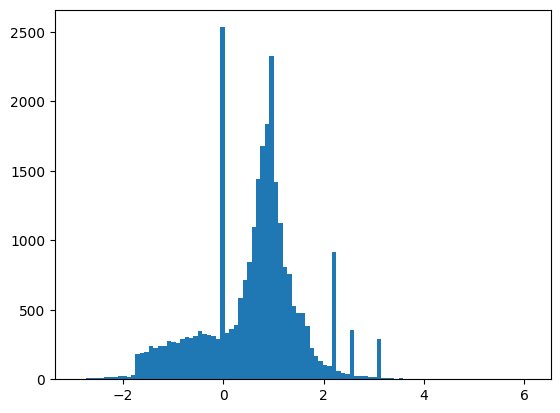

In [12]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

この短いチュートリアルでは、検証に最初の 1,000 サンプルのみを使用し、トレーニングに次の 10,000 サンプルを使用します。

In [13]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

`Dataset.skip` と `Dataset.take` メソッドを使うと簡単に実行できます。

また、`Dataset.cache` メソッドを使用して、ローダーが各エポックでファイルからデータを再読み取りする必要がないようにします。

In [14]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [15]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

これらのデータセットは、個々のサンプルを返します。`Dataset.batch` メソッドを使用して、トレーニングに適したサイズのバッチを作成します。バッチ処理する前に、トレーニングセットを `Dataset.shuffle` および `Dataset.repeat` することも忘れないでください。

In [16]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

## 過学習のデモ

過学習を防止するための最も単純な方法は、モデルのサイズ、すなわち、モデル内の学習可能なパラメータの数を小さくすることです（学習パラメータの数は、レイヤーの数とレイヤーごとのユニット数で決まります）。ディープラーニングでは、モデルの学習可能なパラメータ数を、しばしばモデルの「容量」と呼びます。

直感的に考えれば、パラメータ数の多いモデルほど「記憶容量」が大きくなり、トレーニング用のサンプルとその目的変数の間のディクショナリのようなマッピングをたやすく学習することができます。このマッピングには汎化能力がまったくなく、これまで見たことがないデータを使って予測をする際には役に立ちません。

ディープラーニングのモデルはトレーニング用データに適応しやすいけれど、本当のチャレレンジは汎化であって適応ではありません。

一方、ネットワークの記憶容量が限られている場合、前述のようなマッピングを簡単に学習することはできません。損失を減らすためには、より予測能力が高い圧縮された表現を学習しなければなりません。同時に、モデルを小さくしすぎると、トレーニング用データに適応するのが難しくなります。「多すぎる容量」と「容量不足」の間にちょうどよい容量があるのです。

残念ながら、（レイヤーの数や、レイヤーごとの大きさといった）モデルの適切なサイズやアーキテクチャを決める魔法の方程式はありません。一連の異なるアーキテクチャを使って実験を行う必要があります。

適切なモデルのサイズを見つけるには、比較的少ないレイヤーの数とパラメータから始めるのがベストです。それから、検証用データでの損失値の改善が見られなくなるまで、徐々にレイヤーの大きさを増やしたり、新たなレイヤーを加えたりします。

比較基準として、密に接続されたレイヤー（`tf.keras.layers.Dense`）だけを使ったシンプルなモデルを構築し、その後、大規模なバージョンを作って比較します。

### 比較基準を作る

トレーニング中に学習率を徐々に下げると、多くのモデルのトレーニングが向上します。`tf.keras.optimizers.schedules` を使用して、時間の経過とともに学習率を下げます。

In [17]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

上記のコードは、`tf.keras.optimizers.schedules.InverseTimeDecay` を設定し、学習率を 1000 エポックで基本率の 1/2 に、2000 エポックで 1/3 に双曲線的に減少させます。

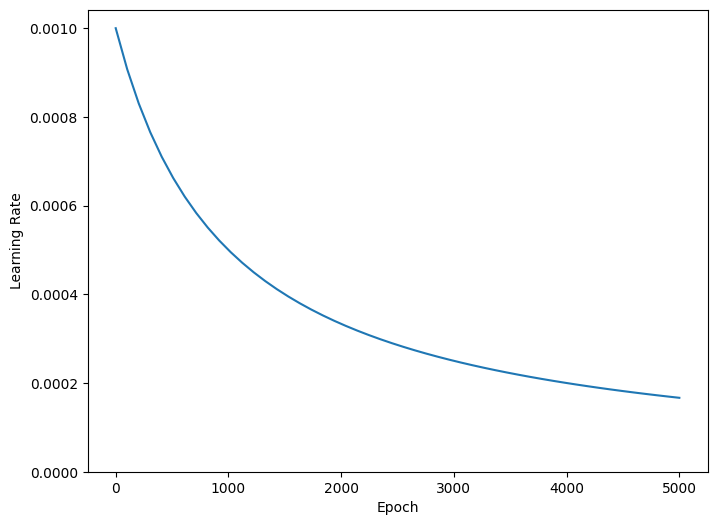

In [18]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')


このチュートリアルの各モデルは、同じトレーニング構成を使用します。したがって、コールバックのリストから始めて、再利用可能な方法でこれらを設定します。

このチュートリアルのトレーニングは、多くの短いエポックで実行されます。不要なログ情報を減らすためには、`tfdocs.EpochDots` を使用します。これは、エポックごとに `.` を出力し、100 エポックごとにメトリックのフルセットを出力します。

次に、`tf.keras.callbacks.EarlyStopping` を含めて、トレーニング時間が不必要に長くならないようにます。このコールバックは、`val_loss` ではなく、`val_binary_crossentropy` を監視するように設定されていることに注意してください。この違いは後で重要になります。

`callbacks.TensorBoard` を使用して、トレーニング用の TensorBoard ログを生成します。


In [19]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

同様に、各モデルは同じ `Model.compile` および `Model.fit` 設定を使用します。

In [20]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.metrics.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

### 非常に小規模のモデル（Tiny）

まず、モデルをトレーニングします。

In [21]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [22]:
size_histories = {}

In [23]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense (Dense)               (None, 16)                464       


 dense_1 (Dense)             (None, 1)                 17        


Total params: 481 (1.88 KB)


Trainable params: 481 (1.88 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


I0000 00:00:1705008762.552632  628217 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch: 0, accuracy:0.4619,  binary_crossentropy:0.8965,  loss:0.8965,  val_accuracy:0.4590,  val_binary_crossentropy:0.7837,  val_loss:0.7837,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.5999,  binary_crossentropy:0.6250,  loss:0.6250,  val_accuracy:0.5780,  val_binary_crossentropy:0.6241,  val_loss:0.6241,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6265,  binary_crossentropy:0.6132,  loss:0.6132,  val_accuracy:0.6120,  val_binary_crossentropy:0.6092,  val_loss:0.6092,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.6318,  binary_crossentropy:0.6057,  loss:0.6057,  val_accuracy:0.6310,  val_binary_crossentropy:0.6018,  val_loss:0.6018,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 400, accuracy:0.6432,  binary_crossentropy:0.5994,  loss:0.5994,  val_accuracy:0.6370,  val_binary_crossentropy:0.5971,  val_loss:0.5971,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 500, accuracy:0.6549,  binary_crossentropy:0.5941,  loss:0.5941,  val_accuracy:0.6550,  val_binary_crossentropy:0.5922,  val_loss:0.5922,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 600, accuracy:0.6631,  binary_crossentropy:0.5890,  loss:0.5890,  val_accuracy:0.6420,  val_binary_crossentropy:0.5883,  val_loss:0.5883,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 700, accuracy:0.6658,  binary_crossentropy:0.5857,  loss:0.5857,  val_accuracy:0.6450,  val_binary_crossentropy:0.5867,  val_loss:0.5867,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 800, accuracy:0.6733,  binary_crossentropy:0.5829,  loss:0.5829,  val_accuracy:0.6550,  val_binary_crossentropy:0.5851,  val_loss:0.5851,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 900, accuracy:0.6680,  binary_crossentropy:0.5814,  loss:0.5814,  val_accuracy:0.6610,  val_binary_crossentropy:0.5845,  val_loss:0.5845,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1000, accuracy:0.6761,  binary_crossentropy:0.5792,  loss:0.5792,  val_accuracy:0.6420,  val_binary_crossentropy:0.5873,  val_loss:0.5873,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1100, accuracy:0.6774,  binary_crossentropy:0.5769,  loss:0.5769,  val_accuracy:0.6790,  val_binary_crossentropy:0.5826,  val_loss:0.5826,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1200, accuracy:0.6838,  binary_crossentropy:0.5752,  loss:0.5752,  val_accuracy:0.6820,  val_binary_crossentropy:0.5826,  val_loss:0.5826,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1300, accuracy:0.6848,  binary_crossentropy:0.5747,  loss:0.5747,  val_accuracy:0.6700,  val_binary_crossentropy:0.5831,  val_loss:0.5831,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1400, accuracy:0.6835,  binary_crossentropy:0.5731,  loss:0.5731,  val_accuracy:0.6750,  val_binary_crossentropy:0.5824,  val_loss:0.5824,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1500, accuracy:0.6860,  binary_crossentropy:0.5720,  loss:0.5720,  val_accuracy:0.6710,  val_binary_crossentropy:0.5826,  val_loss:0.5826,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1600, accuracy:0.6892,  binary_crossentropy:0.5712,  loss:0.5712,  val_accuracy:0.6680,  val_binary_crossentropy:0.5828,  val_loss:0.5828,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

次に、モデルがどのように機能したかを確認します。

(0.5, 0.7)

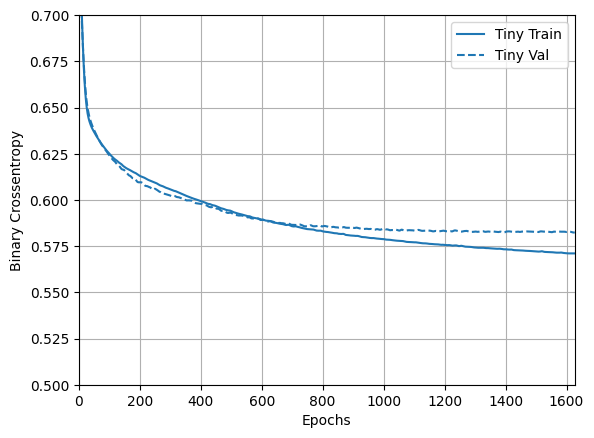

In [24]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

### 小規模のモデル（Small）

小規模なモデルのパフォーマンスを上回ることができるかどうかを確認するには、いくつかの大規模なモデルを段階的にトレーニングします。

隠れレイヤーが 2 つ、 1 つのレイヤー内のユニットが 16 あるモデルを構築します。

In [25]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [26]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_2 (Dense)             (None, 16)                464       


 dense_3 (Dense)             (None, 16)                272       


 dense_4 (Dense)             (None, 1)                 17        


Total params: 753 (2.94 KB)


Trainable params: 753 (2.94 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________



Epoch: 0, accuracy:0.4930,  binary_crossentropy:0.8314,  loss:0.8314,  val_accuracy:0.4820,  val_binary_crossentropy:0.7821,  val_loss:0.7821,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6133,  binary_crossentropy:0.6214,  loss:0.6214,  val_accuracy:0.5930,  val_binary_crossentropy:0.6208,  val_loss:0.6208,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6483,  binary_crossentropy:0.5955,  loss:0.5955,  val_accuracy:0.6510,  val_binary_crossentropy:0.5927,  val_loss:0.5927,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.6671,  binary_crossentropy:0.5817,  loss:0.5817,  val_accuracy:0.6780,  val_binary_crossentropy:0.5829,  val_loss:0.5829,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 400, accuracy:0.6741,  binary_crossentropy:0.5732,  loss:0.5732,  val_accuracy:0.6820,  val_binary_crossentropy:0.5791,  val_loss:0.5791,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 500, accuracy:0.6865,  binary_crossentropy:0.5669,  loss:0.5669,  val_accuracy:0.6600,  val_binary_crossentropy:0.5829,  val_loss:0.5829,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

### 中規模のモデル（Medium）

次に、隠れレイヤーが 3 つ、 1 つのレイヤー内のユニットが​ 64 あるモデルを構築します。

In [27]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

同じデータを使って訓練します。

In [28]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_5 (Dense)             (None, 64)                1856      


 dense_6 (Dense)             (None, 64)                4160      


 dense_7 (Dense)             (None, 64)                4160      


 dense_8 (Dense)             (None, 1)                 65        


Total params: 10241 (40.00 KB)


Trainable params: 10241 (40.00 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________



Epoch: 0, accuracy:0.5043,  binary_crossentropy:0.7034,  loss:0.7034,  val_accuracy:0.4630,  val_binary_crossentropy:0.6853,  val_loss:0.6853,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.7093,  binary_crossentropy:0.5366,  loss:0.5366,  val_accuracy:0.6420,  val_binary_crossentropy:0.6060,  val_loss:0.6060,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.7658,  binary_crossentropy:0.4515,  loss:0.4515,  val_accuracy:0.6510,  val_binary_crossentropy:0.6869,  val_loss:0.6869,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

### 大規模のモデル（Large）

演習として、より大規模なモデルを作成し、それがどれだけ迅速に過適合し始めるかを確認してみましょう。次に、このベンチマークに、ここで必要とされる容量を大幅に上回るネットワークを追加します。

In [29]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

このモデルもまた同じデータを使って訓練します。

In [30]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_3"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_9 (Dense)             (None, 512)               14848     


 dense_10 (Dense)            (None, 512)               262656    


 dense_11 (Dense)            (None, 512)               262656    


 dense_12 (Dense)            (None, 512)               262656    


 dense_13 (Dense)            (None, 1)                 513       


Total params: 803329 (3.06 MB)


Trainable params: 803329 (3.06 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________



Epoch: 0, accuracy:0.5052,  binary_crossentropy:0.8598,  loss:0.8598,  val_accuracy:0.4750,  val_binary_crossentropy:0.6900,  val_loss:0.6900,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:1.0000,  binary_crossentropy:0.0025,  loss:0.0025,  val_accuracy:0.6550,  val_binary_crossentropy:1.7593,  val_loss:1.7593,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:1.0000,  binary_crossentropy:0.0001,  loss:0.0001,  val_accuracy:0.6560,  val_binary_crossentropy:2.4404,  val_loss:2.4404,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

### 訓練時と検証時の損失をグラフにする

実線はトレーニング用データセットの損失、破線は検証用データセットでの損失です（検証用データでの損失が小さい方が良いモデルです）。

より大きなモデルを構築すると、より多くのパワーが得られますが、このパワーが何らかの形で制約されていない場合、トレーニングセットに簡単に過適合する可能性があります。

この例では、通常、`"Tiny"` モデルのみが過適合を完全に回避し、より大規模なモデルはデータをより迅速に過適合します。過適合は、`"large"` モデルでは非常に深刻になるため、実際に何が起こっているかを確認するには、プロットを対数スケールに切り替える必要があります。

これは、検証メトリックをトレーニングメトリックとプロットして比較すると明らかです。

- わずかな違いがあるのは正常です。
- 両方のメトリックが同じ方向に移動している場合、すべて正常です。
- トレーニングメトリックが改善し続けているのに検証メトリックが停滞し始めた場合は、おそらく過適合に近づいています。
- 検証メトリックが反対方向に進んでいる場合、モデルは明らかに過適合しています。

Text(0.5, 0, 'Epochs [Log Scale]')

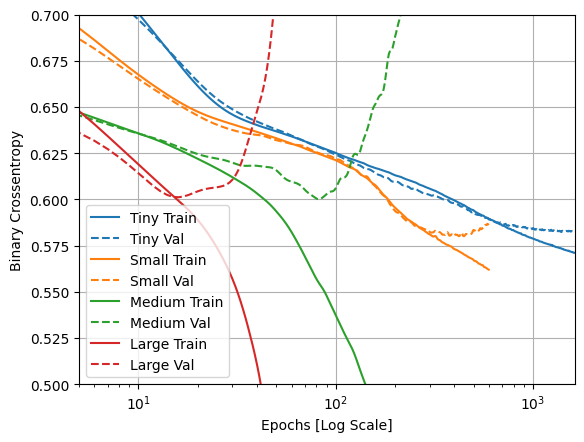

In [31]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

注意: 上記のすべてのトレーニング実行では、`callbacks.EarlyStopping` を使用して、モデルが進行していないことが明らかになった時点でトレーニングを終了しました。

### TensorBoard で表示する

これらのモデルはすべて、トレーニング中に TensorBoard ログを書き込みました。

ノートブック内の組み込みの TensorBoard ビューアーを開きます（残念ながら、tensorflow.org では表示されません）。

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/sizes

[TensorBoard.dev](https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97) で、このノートブックの[前回の実行結果](https://tensorboard.dev/)を閲覧できます。

## 過学習防止の戦略

このセクションの内容に入る前に、上記の `"Tiny"` モデルからトレーニングログをコピーして、比較のベースラインとして使用します。

In [32]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/tmpfs/tmp/tmpjhledfmm/tensorboard_logs/regularizers/Tiny')

In [33]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

### 重みの正則化を加える


「オッカムの剃刀」の原則をご存知でしょうか。何かの説明が2つあるとすると、最も正しいと考えられる説明は、仮定の数が最も少ない「一番単純な」説明だというものです。この原則は、ニューラルネットワークを使って学習されたモデルにも当てはまります。ある訓練用データとネットワーク構造があって、そのデータを説明できる重みの集合が複数ある時（つまり、複数のモデルがある時）、単純なモデルのほうが複雑なものよりも過学習しにくいのです。

ここで言う「単純なモデル」とは、パラメータ値の分布のエントロピーが小さいもの（あるいは、上記で見たように、そもそもパラメータの数が少ないもの）です。したがって、過学習を緩和するための一般的な手法は、重みが小さい値のみをとることで、重み値の分布がより整然となる（正則）ように制約を与えるものです。これを「重みの正則化」と呼ばれ、ネットワークの損失関数に、重みの大きさに関連するコストを加えることで行われます。このコストには 2 つの種類があります。

- [L1 正則化](https://developers.google.com/machine-learning/glossary/#L1_regularization): 重み係数の絶対値に比例するコストを加える（重みの「L1 ノルム」と呼ばれる）。

- [L2 正則化](https://developers.google.com/machine-learning/glossary/#L2_regularization): 重み係数の二乗に比例するコストを加える（重み係数の二乗「L2 ノルム」と呼ばれる）。L2 正則化はニューラルネットワーク用語では重み減衰（Weight Decay）と呼ばれる。呼び方が違うので混乱しないように。重み減衰は数学的には L2 正則化と同義である。

L1 正則化は重みパラメータの一部を 0 にすることでモデルを疎にする効果があります。L2 正則化は重みパラメータにペナルティを加えますがモデルを疎にすることはありません。そのため、L2 正則化のほうが一般的です。

`tf.keras`では、重みの正則化をするために、重み正則化のインスタンスをキーワード引数としてレイヤーに加えます。ここでは、L2 正則化を追加してみましょう。

In [34]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_4"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_14 (Dense)            (None, 512)               14848     


 dense_15 (Dense)            (None, 512)               262656    


 dense_16 (Dense)            (None, 512)               262656    


 dense_17 (Dense)            (None, 512)               262656    


 dense_18 (Dense)            (None, 1)                 513       


Total params: 803329 (3.06 MB)


Trainable params: 803329 (3.06 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________



Epoch: 0, accuracy:0.5148,  binary_crossentropy:0.8137,  loss:2.3356,  val_accuracy:0.4800,  val_binary_crossentropy:0.6744,  val_loss:2.1163,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6622,  binary_crossentropy:0.5936,  loss:0.6180,  val_accuracy:0.6230,  val_binary_crossentropy:0.5917,  val_loss:0.6160,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6739,  binary_crossentropy:0.5804,  loss:0.6030,  val_accuracy:0.6800,  val_binary_crossentropy:0.5736,  val_loss:0.5962,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.6888,  binary_crossentropy:0.5735,  loss:0.5964,  val_accuracy:0.6710,  val_binary_crossentropy:0.5844,  val_loss:0.6074,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 400, accuracy:0.6912,  binary_crossentropy:0.5710,  loss:0.5954,  val_accuracy:0.6930,  val_binary_crossentropy:0.5810,  val_loss:0.6054,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 500, accuracy:0.7014,  binary_crossentropy:0.5547,  loss:0.5826,  val_accuracy:0.6650,  val_binary_crossentropy:0.5870,  val_loss:0.6147,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 600, accuracy:0.6979,  binary_crossentropy:0.5508,  loss:0.5801,  val_accuracy:0.6850,  val_binary_crossentropy:0.5721,  val_loss:0.6011,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 700, accuracy:0.7131,  binary_crossentropy:0.5397,  loss:0.5691,  val_accuracy:0.6700,  val_binary_crossentropy:0.5811,  val_loss:0.6104,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

`l2(0.001)` というのは、レイヤーの重み行列の係数全てに対して `0.001 * weight_coefficient_value**2` をネットワークの損失値合計に加えることを意味します。

そのため、`binary_crossentropy` を直接監視しています。この正則化コンポーネントが混在していないためです。

したがって、`L2` 正則化ペナルティが設けられた同じ `"Large"` モデルのパフォーマンスははるかに優れています。


(0.5, 0.7)

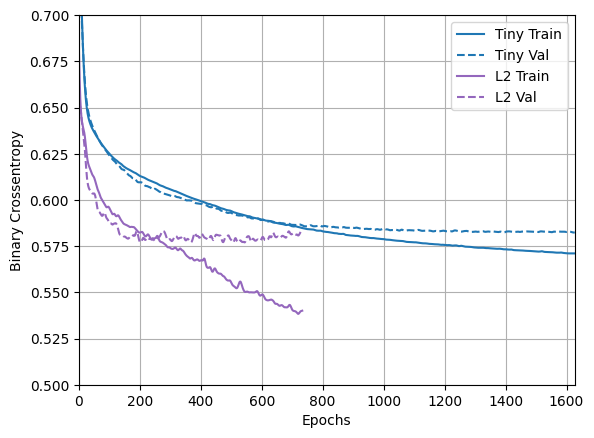

In [35]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

ご覧のように、`"L2"` 正則化ありのモデルは `"Tiny"` モデルとほぼ同等になりました。`"L2"` モデルは `"Large"` モデルと比べて過学習しにくくなっています。両方のモデルのパラメータ数は同じであるにもかかわらずです。

#### 詳細情報

このような正則化について注意すべき重要事項が 2 つあります。

1. 独自のトレーニングループを作成している場合は、モデルに正則化の損失を必ず確認する必要があります。

In [36]:
result = l2_model(features)
regularization_loss=tf.add_n(l2_model.losses)

1. この実装は、モデルの損失に対して重みペナルティを与えてから標準の最適化手順を適用します。

2 番目のアプローチでは、代わりに、生の損失に対してのみオプティマイザを実行します。オプティマイザは計算されたステップを適用しながら、重みの減衰も適用します。この「分離された重みの減衰」は、`tf.keras.optimizers.Ftrl` や `tfa.optimizers.AdamW` などのオプティマイザで使用されます。

### ドロップアウトを追加する

ドロップアウトは、ニューラルネットワークの正則化テクニックとして最もよく使われる手法の一つです。この手法は、トロント大学のヒントンと彼の学生が開発したものです。

ドロップアウトを簡単に説明すると、ネットワーク内の個々のノードは他のノードの出力に依存できないため、各ノードはそれ自体で役立つ特徴を出力する必要があるということです。

ドロップアウトはレイヤーに適用するもので、トレーニング時にレイヤーから出力された特徴量に対してランダムに「ドロップアウト（つまりゼロ化）」を行うものです。例えば、あるレイヤーがトレーニング時にある入力サンプルに対して、普通は`[0.2, 0.5, 1.3, 0.8, 1.1]` というベクトルを出力するとします。ドロップアウトを適用すると、このベクトルは例えば`[0, 0.5, 1.3, 0, 1.1]`のようにランダムに散らばったいくつかのゼロを含むようになります。

「ドロップアウト率」はゼロ化される特徴の割合で、通常は 0.2 から 0.5 の間に設定します。テスト時は、どのユニットもドロップアウトされず、代わりに出力値がドロップアウト率と同じ比率でスケールダウンされます。これは、トレーニング時に比べてたくさんのユニットがアクティブであることに対してバランスをとるためです。

Keras では、`tf.keras.layers.Dropout` レイヤーを使ってドロップアウトをネットワークに導入できます。ドロップアウトレイヤーは、その直前のレイヤーの出力に対してドロップアウトを適用します。

ネットワークに 2 つのドロップアウトレイヤーを追加して、過適合を減らすのにどれだけ効果を発揮するか見てみましょう。

In [37]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_5"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_19 (Dense)            (None, 512)               14848     


 dropout (Dropout)           (None, 512)               0         


 dense_20 (Dense)            (None, 512)               262656    


 dropout_1 (Dropout)         (None, 512)               0         


 dense_21 (Dense)            (None, 512)               262656    


 dropout_2 (Dropout)         (None, 512)               0         


 dense_22 (Dense)            (None, 512)               262656    


 dropout_3 (Dropout)         (None, 512)               0         


 dense_23 (Dense)            (None, 1)                 513       


Total params: 803329 (3.06 MB)


Trainable params: 803329 (3.06 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________



Epoch: 0, accuracy:0.5063,  binary_crossentropy:0.7907,  loss:0.7907,  val_accuracy:0.5420,  val_binary_crossentropy:0.6813,  val_loss:0.6813,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6606,  binary_crossentropy:0.5938,  loss:0.5938,  val_accuracy:0.6620,  val_binary_crossentropy:0.5849,  val_loss:0.5849,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6944,  binary_crossentropy:0.5534,  loss:0.5534,  val_accuracy:0.6830,  val_binary_crossentropy:0.5899,  val_loss:0.5899,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.7231,  binary_crossentropy:0.5122,  loss:0.5122,  val_accuracy:0.7020,  val_binary_crossentropy:0.6014,  val_loss:0.6014,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

(0.5, 0.7)

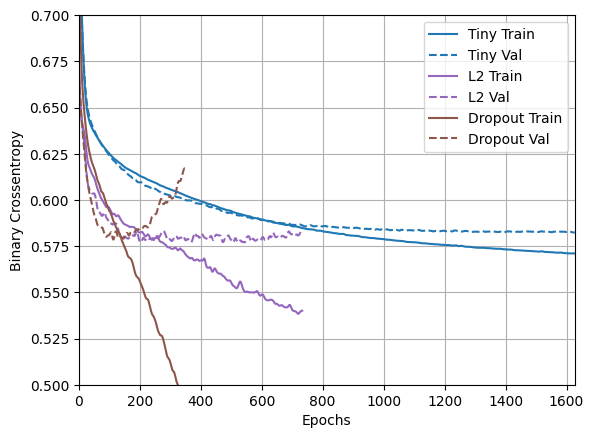

In [38]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

このプロットから、これらの正則化アプローチは両方とも `"Large"` モデルの動作を改善することが分かります。しかし、`"Tiny"` のベースラインと比較すると勝るものはありません。

次に、両方を一緒に試して、改善するかどうかを確認します。

### L2 とドロップアウトを組み合わせる

In [39]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_6"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_24 (Dense)            (None, 512)               14848     


 dropout_4 (Dropout)         (None, 512)               0         


 dense_25 (Dense)            (None, 512)               262656    


 dropout_5 (Dropout)         (None, 512)               0         


 dense_26 (Dense)            (None, 512)               262656    


 dropout_6 (Dropout)         (None, 512)               0         


 dense_27 (Dense)            (None, 512)               262656    


 dropout_7 (Dropout)         (None, 512)               0         


 dense_28 (Dense)            (None, 1)                 513       


Total params: 803329 (3.06 MB)


Trainable params: 803329 (3.06 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________



Epoch: 0, accuracy:0.4980,  binary_crossentropy:0.8100,  loss:0.9685,  val_accuracy:0.5030,  val_binary_crossentropy:0.6791,  val_loss:0.8370,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6519,  binary_crossentropy:0.6022,  loss:0.6328,  val_accuracy:0.6510,  val_binary_crossentropy:0.5852,  val_loss:0.6156,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6599,  binary_crossentropy:0.5926,  loss:0.6186,  val_accuracy:0.6670,  val_binary_crossentropy:0.5760,  val_loss:0.6021,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.6814,  binary_crossentropy:0.5803,  loss:0.6087,  val_accuracy:0.6700,  val_binary_crossentropy:0.5635,  val_loss:0.5920,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 400, accuracy:0.6776,  binary_crossentropy:0.5744,  loss:0.6051,  val_accuracy:0.6860,  val_binary_crossentropy:0.5593,  val_loss:0.5900,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 500, accuracy:0.6796,  binary_crossentropy:0.5724,  loss:0.6049,  val_accuracy:0.6950,  val_binary_crossentropy:0.5528,  val_loss:0.5854,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 600, accuracy:0.6834,  binary_crossentropy:0.5657,  loss:0.6002,  val_accuracy:0.6970,  val_binary_crossentropy:0.5436,  val_loss:0.5781,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 700, accuracy:0.6907,  binary_crossentropy:0.5590,  loss:0.5961,  val_accuracy:0.6760,  val_binary_crossentropy:0.5576,  val_loss:0.5947,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 800, accuracy:0.6974,  binary_crossentropy:0.5557,  loss:0.5944,  val_accuracy:0.6960,  val_binary_crossentropy:0.5380,  val_loss:0.5768,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

(0.5, 0.7)

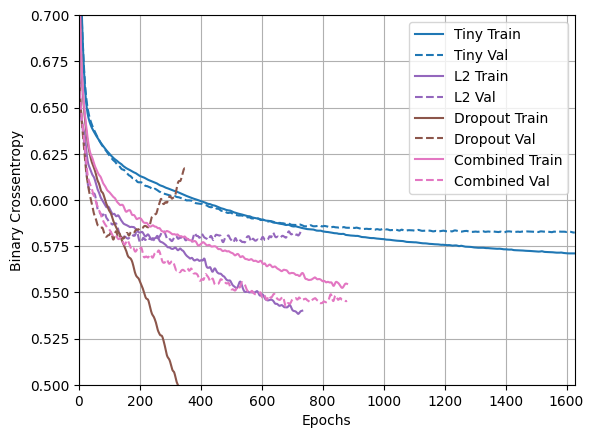

In [40]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

`"Combined"` 正則化を使用したモデルは、明らかに最も優れたモデルです。

### TensorBoard で表示する

これらのモデルは、TensorBoard ログも記録しました。

埋め込みを開くには、コードセルで以下を実行します（残念ながら、tensorflow.org では表示されません）。

In [ ]:
%tensorboard --logdir {logdir}/regularizers

[TensorBoard.dev](https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97) で、このノートブックの[前回の実行結果](https://tensorboard.dev/)を閲覧できます。

## まとめ

ニューラルネットワークの過適合を防ぐための最も一般的な方法は次のとおりです。

- より多くのトレーニングデータを取得します。
- ネットワークの容量を減らします。
- 重みの正則化を追加します。
- ドロップアウトを追加します。

このガイドで説明されていない 2 つの重要なアプローチは次のとおりです。

- [データ拡張](../images/data_augmentation.ipynb)
- バッチ正規化 (`tf.keras.layers.BatchNormalization`)

それぞれの方法は個別に利用しても役立つ可能性がありますが、多くの場合、組み合わせるとさらに効果的になります。